# CO<sub>2</sub>R Technoeconomics Figures and Analysis
Date updated: 2024/06/30 \
Update notes: Reordered and updated optimization \
Contact: Shashwati da Cunha, [shashwati.dacunha@austin.utexas.edu](mailto:shashwati.dacunha@austin.utexas.edu)

### What is this notebook?
This Jupyter notebook is only an integrator - no actual modeling is built in here. It is written to interactively generate plots seen in our paper, 
> Da Cunha, S.; Resasco, J. Insights from Techno-Economic Analysis Can Guide the Design of Low-Temperature CO₂ Electrolyzers towards Industrial Scaleup; preprint; ChemRxiv, 2024. https://chemrxiv.org/engage/chemrxiv/article-details/668eaa4c01103d79c59ceaf6. 

### Instructions
0. Download and locate the entire folder associated with this notebook, including the `Supplementary Workbook.xlsx` Excel template for constants and parameters (data). Please use the associated template and units, since this notebook will directly import the variable names in there as values, and look for those header and product names for model data.
1. Update the Excel sheet with constants, assumptions about efficiencies, and assumptions about costs. To make any changes in how this code calculates process costs (e.g. changing Tafel slopes, changing the cost of deionized water) please change data in the Excel file only. Note that changes in the process itself will require a change in the associated downstream model (see *How does it work?* below).
2. Run this code! Look at the `Run` menu > `Run all`. Enter simulation details when prompted. Please walk through the outputs cell by cell, since not everything is prompted through a user input. In particular, to change electricity prices, there is no user input.

### How does it work?
Constants, assumptions and empirical data are imported from `Supplementary Workbook.xlsx`, mostly directly into global variables. An evaluation of the technoeconomic assessment and emissions is carried out in other `.ipynb` notebook files that contain the model and are imported here. In particular, the file titled `"<version>_SingleRun.ipynb"` contains a function called `singlerun()`, which takes all inputs about the model as arguments, and generates a comprehensive TEA. This function returns information on cost breakdown, emissions, energy requirements etc in dataframes. `singlerun()` calls several other functions, which are split across `"<version>_ElectrolyzerModel.ipynb"` (electrolyzer model - voltage, currents and streams), `"<version>_DownstreamProcessModel.ipynb"` (process stream table and separations requirements), and `"<version>_ProcessEconomics.ipynb"` (all process costing.)

There is no actual modeling in this file. In any file, you can import the product data from `Supplementary Workbook.xlsx`, and `%run` `"<version>_ElectrolyzerModel.ipynb"`, `"<version>_DownstreamProcessModel.ipynb"`, `"<version>_ProcessEconomics.ipynb"`, and `<version>_SingleRun.ipynb` (or `import *` from them as packages). Then just call the `singlerun()` function with all its inputs to run the model.

### Requirements
File naming conventions are written for Windows; other operating systems may require adjustments to file names throughout.

This code was written in Python 3 and tested in Jupyter 7. It uses the following packages:
- `python 3.11.7`
- `numpy 1.26.4`
- `pandas 2.1.4`
- `scipy 1.11.4`
- `matplotlib 3.8.4`
- `openpyxl 3.0.10`
- Jupyter 7 (`notebook 7.0.8`, which includes `ipywidgets 7.6.5`, `ipython 8.20.0`, `jupyter_core 5.5.0` etc)


# 0. Imports and setup

## 0.1. Imports and styling

In [397]:
### Import packages
import pandas as pd
import numpy as np

import matplotlib as mp
from matplotlib import ticker
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from matplotlib.colors import LinearSegmentedColormap

# import csv

from datetime import datetime
# import timeit

from functools import reduce

from os.path import exists
import os

import openpyxl
from openpyxl.worksheet.dimensions import ColumnDimension, DimensionHolder
import openpyxl.utils.cell
from openpyxl.styles import PatternFill, Border, Side, Alignment, Protection, Font

from scipy import optimize

from IPython.display import display, HTML, clear_output

### 0.1.1 Import functions from other notebooks

In [398]:
%run "20241001_0_NonAq_ElectrolyteModel.ipynb"
%run "20241001_1_NonAq_ElectrolyzerModel.ipynb"
%run "20241001_2_NonAq_DownstreamProcessModel.ipynb"
%run "20241001_3_NonAq_ProcessEconomics.ipynb"
%run "20241001_4_NonAq_TEA_SingleRun.ipynb"

## 0.2. Matplotlib formatting

In [399]:
# All options at https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
# mp.style.use('bmh')

In [400]:
# Plot formatting for Matplotlib - rcParams. All options at https://matplotlib.org/stable/api/matplotlib_configuration_api.html#matplotlib.rcParams

# All fonts and font sizes
SMALL_SIZE = 20 # set smallest font size
MEDIUM_SIZE = 24 # set medium font size
BIGGER_SIZE = 27 # set
mp.rc('font', family = 'Arial') # font group is sans-serif
mp.rc('font', size=MEDIUM_SIZE)     # controls default text sizes if unspecified
mp.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title; I think this is for subplots 
mp.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
mp.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
mp.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
mp.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
mp.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# text padding
mp.rc('axes', labelpad= 18) # padding between axis label and axis
mp.rc('axes', titlepad= 22) # padding between axis title and labels; might be for subplots
mp.rc('legend', handletextpad = 0.3) # padding between each legend entry's icon and text
mp.rc('legend', borderaxespad = 1) # padding between legend border and axes
TICK_PADDING = 8
mp.rcParams['xtick.major.pad'] = TICK_PADDING
mp.rcParams['xtick.minor.pad'] = TICK_PADDING
mp.rcParams['ytick.major.pad'] = TICK_PADDING
mp.rcParams['ytick.minor.pad'] = TICK_PADDING
mp.rcParams['axes.xmargin'] = 1
mp.rcParams['axes.ymargin'] = 1

# figure settings
aspect_ratio = 1/1 # 3/4
mp.rc('figure', figsize = (5, 5*aspect_ratio)) # figure size
mp.rc('figure', dpi = 250) # figure dpi/ pix per inch
mp.rcParams['axes.spines.right'] = True # right border
mp.rcParams['axes.spines.top'] = True # top border

# legend
mp.rc('legend', loc = 'upper left') # legend location 
mp.rc('legend', frameon = False) # legend border - yes or no?
mp.rc('legend', markerscale = 1) # scale up markers in legend

# axes
mp.rc('axes', linewidth = 2) # linewidth of axes

# default axes
mp.rc('axes', autolimit_mode = 'round_numbers') # set default axis limits to be "round" numbers rather than data

# major x-ticks
mp.rcParams['xtick.top'] = False  # top or bottom of plot
mp.rcParams['xtick.direction'] = 'out' # ticks in or out of plot
mp.rcParams['xtick.major.width'] = 2 # linewidth of ticks
mp.rcParams['xtick.major.size'] = 12 # length of ticks

# minor x-ticks
mp.rcParams['xtick.minor.visible'] = True
mp.rcParams['xtick.minor.width'] = 2  # linewidth of ticks
mp.rcParams['xtick.minor.size'] = 6   # length of ticks

# major y-ticks
mp.rcParams['ytick.right'] = False  # right or left of plot
mp.rcParams['ytick.direction'] = 'out' # ticks in or out of plot
mp.rcParams['ytick.major.width'] = 2   # linewidth of ticks
mp.rcParams['ytick.major.size'] = 12  # length of ticks

# minor y-ticks
mp.rcParams['ytick.minor.visible'] = True
mp.rcParams['ytick.minor.right'] = False # right or left of plot
mp.rcParams['ytick.minor.width'] = 2 # linewidth of ticks
mp.rcParams['ytick.minor.size'] = 6  # length of ticks

# format for saving figures
mp.rcParams['savefig.format'] = 'tiff'
mp.rcParams['savefig.bbox'] = 'tight' # 'tight' # or standard; tight may break ffmpeg
# If using standard, be sure to use bbox_inches="tight" argument in savefig

# defaults for scatterplots
mp.rcParams['scatter.marker'] = 'o' # round markers unless otherwise specified
mp.rcParams['lines.markersize'] = 6 # sets the scatter/line marker size; roughly equivalent to s = 40 in my experience

# defaults for lines
mp.rcParams['lines.linestyle'] = '-' # solid lines unless otherwise specified
mp.rcParams['lines.linewidth'] = 2 # default linewidth

# defaults for errorbars
mp.rcParams['errorbar.capsize'] = 4

### Fix random state for reproducibility
np.random.seed(19680801)

### Some options for ticks:
# np.arange(min, max, step): returns a list of step-spaced entries between min and max EXCLUDING max
# np.linspace(min, max, n): returns a list of n linearly spaced entries between min and max, including max
# np.logspace(min, max, n, base=10.0): returns a list of n log-spaced entries between min and max
# axs.xaxis.set_major_locator(mpl.ticker.MultipleLocator(n)): sets axis ticks to be multiples of 
                                                             #n within the data range


## 0.3 Input file locations

In [401]:
# Prompt user to enter file path
# file_imports = r"{}".format(input('Enter filepath for costs of utilities and raw materials \
#                   \n \n').replace('"', '')

file_imports = r"Supplementary Workbook.xlsx"

In [402]:
# sheet_cost_imports = input('Enter sheet name for costs of utilities \
#                   \n \n')
# Prompt user to enter sheet name for utility costs

sheet_utility_imports = 'Utilities'

In [403]:
# sheet_constants = input('Enter sheet name for constants \
#                   \n \n').replace('"', '') 
# Prompt user to enter sheet name for constants

sheet_constants =  'Constants and assumptions'

In [404]:
# sheet_products = input('Enter sheet name for products \
#                   \n \n').replace('"', '') 
# Prompt user to enter sheet name for product data

sheet_products =  'Products'

In [405]:
# sheet_solvents = input('Enter sheet name for solvents \
#                   \n \n').replace('"', '') 
# Prompt user to enter sheet name for product data

sheet_solvents =  'Solvents'

In [406]:
# sheet_supporting = input('Enter sheet name for supporting electrolytes \
#                   \n \n').replace('"', '') 
# Prompt user to enter sheet name for product data

sheet_supporting =  'Supporting electrolytes'

## 0.4 Output file locations

In [407]:
root_folder = r'E:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R'

In [408]:
# Get current date and time to name files
time_now = datetime.now().time()
date_now = datetime.now().date()
current_date = date_now.strftime("%Y%m%d") # format string
current_time = time_now.strftime("%I-%M%p") # format string

# Output folder - must be written as r"path/folder"; the r at the front indicates a raw string literal
# root_folder = file_imports[::-1].split('\\', 1)[1][::-1] # Take the imports filepath, reverse it and split on the last \ character, and re-reverse it 
OP_folder = root_folder + '\LCA TEA non-aq results on ' + current_date
if not os.path.exists(OP_folder): # check if OP_folder path exists
    os.mkdir(OP_folder) # if path doesn't exist, create the folder
    
# Manually set OP_folder if desired:
# OP_folder = # r"D:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R"

## 0.5 Import Excel data

### 0.5.1 Import constants and product data

In [409]:
df_constants = pd.DataFrame # Create dataframe for constants
xlsx = pd.ExcelFile(file_imports) # Read each data Excel file
df_constants = xlsx.parse(sheet_name = sheet_constants) # Read the sheet with the constants
df_constants.set_index('Variable name', drop = True, inplace = True) # Reset index to variable name
xlsx.close() # close xlsx file

## Update constants as variables 
## NOTE: Modifying globals() is a very frowned on practice in Python - be VERY careful implementing this, it's easy to say 
# overwrite variables that are carelessly named. Consider indexing directly from df_constants (set its index to 'variable name')
# and df_utilities instead

for index, row in df_constants.iterrows(): # for each row in df_constants
    globals()[index] = row['Value'] # save its 'value' to a new variable called the 'variable name' column

df_constants

Name  \
Variable name                                                                  
catholyte_conc_M             Concentration: catholyte supporting electrolyte   
anolyte_conc_M                 Concentration: anolyte supporting electrolyte   
CO2_cost_USD_tCO2                                                  Cost: CO2   
water_cost_USD_kg                                             Cost: DI water   
electrolyzer_capex_USD_m2                                 Cost: Electrolyzer   
crossover_neutral                             Crossover: neutral electrolyte   
water_density_kg_m3                               Density: aqueous solutions   
carbon_capture_efficiency                         Efficiency: carbon capture   
LL_second_law_efficiency                Efficiency: separations (second-law)   
PSA_second_law_efficiency               Efficiency: separations (second-law)   
electrolyte_thickness_cm      Electrolyzer assumption: Electrolyte thickness   
R_membrane_ohmcm2          Electrolyzer assumption: Membrane ohmic resist...   
an_E_eqm                                          Equilibrium potential: OER   
F                                                         Faraday's constant   
R                                                               Gas constant   
MW_CO2                                                       Molar mass: CO2   
MW_K2CO3                                                   Molar mass: K2CO3   
MW_O2                                                         Molar mass: O2   
MW_H2O                                                     Molar mass: water   
P                                                                   Pressure   
capacity_factor                          Process assumption: capacity factor   
battery_capacity                Process assumption: default battery capacity   
lifetime_years                            Process assumption: plant lifetime   
product_rate_kg_day                     Process assumption: production basis   
stack_lifetime_years                      Process assumption: stack lifetime   
cathode_outlet_humidity    Ratio: Mole fraction of water in cathode outle...   
excess_water_ratio                         Ratio: Water feed vs product rate   
an_j_ref                                      Reference current density: OER   
an_eta_ref                                      Reference overpotential: OER   
an_Tafel_slope                                            Tafel slope: anode   
T_sep                                               Temperature: separations   
T_streams                                               Temperature: streams   
K_to_C                                              Unit conversion: K to °C   
kJ_per_kWh                                        Unit conversion: kWh to kJ   
kJ_per_mmBtu                                    Unit conversion: mmBtu to kJ   
kWh_per_mmBtu                                  Unit conversion: mmBtu to kWh   

                                  Value                          Unit  \
Variable name                                                           
catholyte_conc_M           1.000000e+00                             M   
anolyte_conc_M             1.000000e+00                             M   
CO2_cost_USD_tCO2          7.500000e+01                       $/t CO2   
water_cost_USD_kg          1.450000e-02                          $/kg   
electrolyzer_capex_USD_m2  5.000000e+03                          $/m2   
crossover_neutral          0.000000e+00                mol CO2/mol e-   
water_density_kg_m3        1.000000e+03                         kg/m3   
carbon_capture_efficiency  9.000000e-01                           NaN   
LL_second_law_efficiency   3.000000e-01                           NaN   
PSA_second_law_efficiency  7.000000e-02                           NaN   
electrolyte_thickness_cm   8.000000e-02                            cm   
R_membrane_ohmcm2          2.200000e-01                         Ω.cm2   
an_E_eqm 

In [410]:
df_products = pd.DataFrame # Create dataframe for product data
xlsx = pd.ExcelFile(file_imports) # Read each data Excel file
df_products = xlsx.parse(sheet_name = sheet_products) # Read the sheet with the product data
df_products.set_index('Product', drop = True, inplace = True) # reset index to product name
xlsx.close() # close xlsx file
    
df_products

Phase Molecular weight (g/mol)  \
Product                                        
H2              gas                 2.015894   
CO              gas                  28.0101   
Formic acid  liquid                   46.025   
Oxalic acid  liquid                    90.03   
References        -                        -   

                         n (mol e-/ mol product) z (mol CO2/ mol product)  \
Product                                                                     
H2                                             2                        0   
CO                                             2                        1   
Formic acid                                    2                        1   
Oxalic acid                                    2                        2   
References   Nitopi, Jaramillo (Chem. Rev. 2019)                        -   

                                  LHV (kJ/kg product)   Cost ($/kg product)  \
Product                                                                       
H2                                             120087                     2   
CO                                              10160                   0.6   
Formic acid                                       NaN                  0.74   
Oxalic acid                                       NaN                   0.7   
References   Engineering Toolbox, Engineering Toolbox  See References 2 col   

            Standard potential, pH = 0 (V vs SHE) Reference overpotential (V)  \
Product                                                                         
H2                                              0                         NaN   
CO                                          -0.06                      -2.487   
Formic acid                                 -0.07                      -0.712   
Oxalic acid                                 -0.51                      -1.093   
References           Bui, Weber (Chem. Rev. 2022)          See References col   

            Tafel slope (mV/dec) Reference current density (mA/cm2)  \
Product                                                               
H2                           NaN                                NaN   
CO                          -375                                  1   
Formic acid                 -416                                 10   
Oxalic acid                 -416                                5.6   
References    See References col                 See References col   

             FECO2R at SPC = 0  Optimal SPC @ 7.6 c/kWh, Hawks model  \
Product                                                                
H2                         NaN                                   NaN   
CO                        0.98                                   0.7   
Formic acid               0.90                                   0.7   
Oxalic acid               0.80                                   0.7   
References                 NaN                                   NaN   

             Optimal j @ 7.6 c/kWh, Hawks model  \
Product                                           
H2                                          NaN   
CO                                        332.4   
Formic acid                               100.0   
Oxalic acid                               331.6   
References                                  NaN   

                                    References  \
Product                                          
H2                                         NaN   
CO                Shin, Jiao (Nat. Sust. 2021)   
Formic acid       Shin, Jiao (Nat. Sust. 2021)   
Oxalic acid  Business Analytiq (accessed 2024)   
References                                 NaN   

                                         References 2  
Product                                                
H2                                                NaN  
CO             George (Kirk-Othmer Encyclopedia 2001)  
Formic acid  Jouny, Jiao I&EC 2020; Guerra 2023 $0.74  
Oxalic acid            

In [411]:
df_solvents = pd.DataFrame # Create dataframe for product data
xlsx = pd.ExcelFile(file_imports) # Read each data Excel file
df_solvents = xlsx.parse(sheet_name = sheet_solvents) # Read the sheet with the product data
df_solvents.set_index('Solvent', drop = True, inplace = True) # reset index to product name
xlsx.close() # close xlsx file
    
df_solvents

Molecular weight (g/mol)  Cost ($/kg solvent)  \
Solvent                                                              
Acetonitrile                            41.05                 0.06   
Propylene carbonate                    102.09                10.00   
DMSO                                    78.13                50.00   

                     Density (kg/m3)  Viscosity (cP)  \
Solvent                                                
Acetonitrile                     786            0.89   
Propylene carbonate             1200            2.50   
DMSO                            1095            1.99   

                     Reference viscosity (cP)  \
Solvent                                         
Acetonitrile                             0.89   
Propylene carbonate                       NaN   
DMSO                                      NaN   

                     CO2 solubility, 10 bar (mol CO2/ mol solvent)  \
Solvent                                                              
Acetonitrile                                                  0.07   
Propylene carbonate                                           0.15   
DMSO                                                           NaN   

                              References                 References 2  
Solvent                                                                
Acetonitrile         Izutsu (Wiley 2009)  Sigma-Aldrich; acetonitrile  
Propylene carbonate            TEST ONLY                    TEST ONLY  
DMSO                           TEST ONLY                    TEST ONLY

In [412]:
df_supporting = pd.DataFrame # Create dataframe for product data
xlsx = pd.ExcelFile(file_imports) # Read each data Excel file
df_supporting = xlsx.parse(sheet_name = sheet_supporting) # Read the sheet with the product data
df_supporting.set_index('Supporting electrolyte', drop = True, inplace = True) # reset index to product name
xlsx.close() # close xlsx file
    
df_supporting

Molecular weight (g/mol)  Cost ($/kg supporting)  \
Supporting electrolyte                                                     
TBA perchlorate                           341.91                     250   
TBA BF4                                   329.27                     250   
TEA BF4                                   217.06                     250   

                        Conductivity (S/cm)  Reference viscosity (cP)  \
Supporting electrolyte                                                  
TBA perchlorate                      0.0075                      0.89   
TBA BF4                              0.0100                       NaN   
TEA BF4                              0.0100                       NaN   

                        Molar conductivity (S/cm.mol)  \
Supporting electrolyte                                  
TBA perchlorate                          6.000000e-10   
TBA BF4                                           NaN   
TEA BF4                                           NaN   

                                            References         References 2  \
Supporting electrolyte                                                        
TBA perchlorate         Sigma-Aldrich; TBA perchlorate  Izutsu (Wiley 2009)   
TBA BF4                         Sigma-Aldrich; TBA BF4                  NaN   
TEA BF4                 Sigma-Aldrich; TEA perchlorate                  NaN   

                                                               Unnamed: 8  
Supporting electrolyte                                                     
TBA perchlorate         Tried Pathania et al, but gives very high cond...  
TBA BF4                                                               NaN  
TEA BF4                                                               NaN

### 0.5.2 Import utility cost and LCA database

In [413]:
df_utility_imports = pd.DataFrame # Create dataframe for costs
xlsx = pd.ExcelFile(file_imports) # Read each data Excel file
df_utility_imports = xlsx.parse(sheet_name = sheet_utility_imports) # Read the sheet with the costing
df_utility_imports.set_index('Utility', drop = True, inplace = True) # reset index to utility name
xlsx.close() # close xlsx file
    
df_utility_imports

Cost ($/kWh)  CO2 emissions (g CO2/kWh)  \
Utility                                                                         
NaN                                            NaN                        NaN   
Electricity - solar                       0.024000                  50.000000   
Electricity - onshore wind                0.024000                  20.000000   
Electricity - wind + storage              0.042000                        NaN   
Electricity - current California mix      0.160500                 230.930614   
Electricity - current US mix              0.076200                 414.104338   
Heat - NG                                 0.007569                 254.376000   
Shin, Jiao assumption                     0.030000                        NaN   
NaN                                            NaN                        NaN   
Electric utility chosen                   0.076200                 414.104338   
Heat utility chosen                       0.007569                 254.376000   
NaN                                            NaN                        NaN   
Battery storage                         200.000000                        NaN   

                                                                             References  \
Utility                                                                                   
NaN                                                                                 NaN   
Electricity - solar                                    Lazard (April 2023); NREL (2021)   
Electricity - onshore wind                             Lazard (April 2023); NREL (2021)   
Electricity - wind + storage                          Lazard (April 2023); GREET (2022)   
Electricity - current California mix  U.S. Energy Information Administration (April ...   
Electricity - current US mix          U.S. Energy Information Administration (April ...   
Heat - NG                             Henry Hub (via U.S. Energy Information Adminis...   
Shin, Jiao assumption                                      Shin, Jiao (Nat. Sust. 2021)   
NaN                                                                                 NaN   
Electric utility chosen                                                             NaN   
Heat utility chosen                                                                 NaN   
NaN                                                                                 NaN   
Battery storage                                                               NREL 2021   

                                                                             Unnamed: 4  \
Utility                                                                                   
NaN                                                                                 NaN   
Electricity - solar                   https://www.nrel.gov/analysis/life-cycle-asses...   
Electricity - onshore wind                                                          NaN   
Electricity - wind + storage                                                        NaN   
Electricity - current California mix                                                NaN   
Electricity - current US mix                                                        NaN   
Heat - NG                                                                           NaN   
Shin, Jiao assumption                                                               NaN   
NaN                                                                                 NaN   
Electric utility chosen                                                             NaN   
Heat utility chosen                                                                 NaN   
NaN                                                                                 NaN   
Battery storage                                                                     NaN   

                                                       Unnamed: 5  
Utility               

## 0.6 Manually adjust inputs

### 0.6.1 Check results

In [414]:
# Extract constants to use for costing and emissions calculations
electricity_cost_USD_kWh = df_utility_imports.loc['Electric utility chosen', 'Cost ($/kWh)'] 
heat_cost_USD_kWh = df_utility_imports.loc['Heat utility chosen', 'Cost ($/kWh)']

electricity_emissions_kgCO2_kWh = 0.001 * df_utility_imports.loc['Electric utility chosen', 'CO2 emissions (g CO2/kWh)'] # convert g CO2 to kg CO2
heat_emissions_kgCO2_kWh = 0.001 * df_utility_imports.loc['Heat utility chosen', 'CO2 emissions (g CO2/kWh)'] # convert g CO2 to kg CO2

battery_capex_USD_kWh = df_utility_imports.loc['Battery storage', 'Cost ($/kWh)']

In [415]:
# Have user verify electricity costs and say if they want to modify
print('Costs of utilities: \n    \
        Electricity ${:.3f}/kWh \n   \
         Heat ${:.3f}/kWh '.format(electricity_cost_USD_kWh, heat_cost_USD_kWh))
print('Carbon intensity of utilities: \n    \
        Electricity {:.3f} kg CO2/kWh \n   \
         Heat {:.3f} kg CO2/kWh '.format(electricity_emissions_kgCO2_kWh, heat_emissions_kgCO2_kWh))
display(df_utility_imports)

answer = input('Do you want to manually modify any of these? y/n \n \n')

if answer.lower() == 'y':
    clear_output()
    print('Uncomment the next code block as you need!')
else:
    print('Using chosen utility prices and carbon intensity')

Costs of utilities: 
            Electricity $0.076/kWh 
            Heat $0.008/kWh 
Carbon intensity of utilities: 
            Electricity 0.414 kg CO2/kWh 
            Heat 0.254 kg CO2/kWh 


Cost ($/kWh)  CO2 emissions (g CO2/kWh)  \
Utility                                                                         
NaN                                            NaN                        NaN   
Electricity - solar                       0.024000                  50.000000   
Electricity - onshore wind                0.024000                  20.000000   
Electricity - wind + storage              0.042000                        NaN   
Electricity - current California mix      0.160500                 230.930614   
Electricity - current US mix              0.076200                 414.104338   
Heat - NG                                 0.007569                 254.376000   
Shin, Jiao assumption                     0.030000                        NaN   
NaN                                            NaN                        NaN   
Electric utility chosen                   0.076200                 414.104338   
Heat utility chosen                       0.007569                 254.376000   
NaN                                            NaN                        NaN   
Battery storage                         200.000000                        NaN   

                                                                             References  \
Utility                                                                                   
NaN                                                                                 NaN   
Electricity - solar                                    Lazard (April 2023); NREL (2021)   
Electricity - onshore wind                             Lazard (April 2023); NREL (2021)   
Electricity - wind + storage                          Lazard (April 2023); GREET (2022)   
Electricity - current California mix  U.S. Energy Information Administration (April ...   
Electricity - current US mix          U.S. Energy Information Administration (April ...   
Heat - NG                             Henry Hub (via U.S. Energy Information Adminis...   
Shin, Jiao assumption                                      Shin, Jiao (Nat. Sust. 2021)   
NaN                                                                                 NaN   
Electric utility chosen                                                             NaN   
Heat utility chosen                                                                 NaN   
NaN                                                                                 NaN   
Battery storage                                                               NREL 2021   

                                                                             Unnamed: 4  \
Utility                                                                                   
NaN                                                                                 NaN   
Electricity - solar                   https://www.nrel.gov/analysis/life-cycle-asses...   
Electricity - onshore wind                                                          NaN   
Electricity - wind + storage                                                        NaN   
Electricity - current California mix                                                NaN   
Electricity - current US mix                                                        NaN   
Heat - NG                                                                           NaN   
Shin, Jiao assumption                                                               NaN   
NaN                                                                                 NaN   
Electric utility chosen                                                             NaN   
Heat utility chosen                                                                 NaN   
NaN                                                                                 NaN   
Battery storage                                                                     NaN   

                                                       Unnamed: 5  
Utility               

Using chosen utility prices and carbon intensity


In [416]:
# Adjust utility costs if desired

if answer.lower() == 'y':
    print('Manually entering inputs')
#     Uncomment lines below as needed

    # electricity_cost_USD_kWh = df_utility_imports.loc['Electricity - wind + storage', 'Cost ($/kWh)'] 
#     electricity_cost_USD_kWh = df_utility_imports.loc['Electricity - onshore wind', 'Cost ($/kWh)'] 
    electricity_cost_USD_kWh = df_utility_imports.loc['Electricity - solar', 'Cost ($/kWh)'] # 0.02 # $/kWh

    # electricity_emissions_kgCO2_kWh = 0.001 *df_utility_imports.loc['Electricity - wind + storage','CO2 emissions (g CO2/kWh)']  # df_utility_imports.loc['Electricity - current California mix','CO2 emissions (g CO2/kWh)']
#     electricity_emissions_kgCO2_kWh = 0.001 *df_utility_imports.loc['Electricity - onshore wind','CO2 emissions (g CO2/kWh)']  # df_utility_imports.loc['Electricity - current California mix','CO2 emissions (g CO2/kWh)']
    electricity_emissions_kgCO2_kWh = 0.001 *df_utility_imports.loc['Electricity - solar','CO2 emissions (g CO2/kWh)']  # df_utility_imports.loc['Electricity - current California mix','CO2 emissions (g CO2/kWh)']

#     heat_emissions_kgCO2_kWh = 0.001 * df_utility_imports.loc['Heat utility chosen', 'CO2 emissions (g CO2/kWh)'] # convert g CO2 to kg CO2

#     heat_cost_USD_kWh =  df_utility_imports.loc['Heat utility chosen', 'Cost ($/kWh)'] 

    print('Costs of utility_imports: \n    \
            Electricity ${:.3f}/kWh \n   \
             Heat ${:.3f}/kWh '.format(electricity_cost_USD_kWh, heat_cost_USD_kWh))
    print('Carbon intensity of utility_imports: \n    \
            Electricity {:.3f} kg CO2/kWh \n   \
             Heat {:.3f} kg CO2/kWh '.format(electricity_emissions_kgCO2_kWh, heat_emissions_kgCO2_kWh))


### 0.6.2 Set defaults for 'override' commands and modeling options

In [417]:
override_one = False
override_onebyone = False
overridde_multivbl = False
override_optimization = False
override_animation = False
override_single = False
override_2files = False
cell_E_V = np.NaN
BV_eta_cat_V = np.NaN
BV_eta_an_V = np.NaN
model_FE = 'Kas'
model_conductivity = False
is_battery = False

# 1. Output file setup

## 1.1 Excel file formatting

In [418]:
# Function to format sheets once written, otherwise they are hard to read

def book_format(writer):
        book  = writer.book # Get workbook
        for i in writer.sheets:
            sheet = writer.sheets[i] # Get worksheet

            # Note that when reading, openpyxl indexes from 1

            # General column and cell formatting
            for i in range(1, 100): # (1, df_expt.shape[1]+2) # Iterate through columns
                col = openpyxl.utils.cell.get_column_letter(i) # Get column's letter index (openpyxl col indexing starts at 1 = 'A')
                # Column formatting              
                sheet.column_dimensions[col].width = 25         

                # Cell formatting
                for row in range(1,200): # Iterate through rows; this takes a lot of time in large output files 
                    sheet[col + str(row)].alignment= Alignment(horizontal='center',
                                         vertical='center',
                                         text_rotation=0,
                                         wrap_text=True) # Format cell contents

    #         # Row formatting - text wrapping will take care of this so not necessary
    #         for row in range(1,50): # Iterate through rows, add 2 because indexing at 0 + range stops 1 before end; row 1 defined above
    #             sheet.row_dimensions[row].height = 15 # Set row height ## TODO: throws error on indexing

            # Specific formatting

    #         First 2 column widths
            sheet.column_dimensions['A'].width = 10
            sheet.column_dimensions['B'].width = 40

## 1.2 Define color scheme

In [419]:
## Theme colors 
theme_colors = ['#bf5700',  '#ffc919', '#8f275d', '#73a3b3', '#193770', '#e35555', '#191f24' ] #ffffff (white)

## Import colormaps
# summer = mp.colormaps['summer']
# summer_r = mp.colormaps['summer_r']
# PuOr = mp.colormaps['PuOr']
viridis = mp.colormaps['viridis']
# viridis_r = mp.colormaps['viridis_r']
# wistia = mp.colormaps['Wistia']
# greys = mp.colormaps['gist_yarg'] # 'Gray'
RdBu = mp.colormaps['RdBu'] # seismic
RdYlBu = mp.colormaps['RdYlBu']
# inferno = mp.colormaps['inferno_r']
# Blues = mp.colormaps['Blues']
# winter = mp.colormaps['winter_r']
# cool = mp.colormaps['cool_r']

## Custom colormaps
# Endpoint colors
colors = [ '#fff01f', '#00503d']  # gold to sherwood green
bright_summer_r = LinearSegmentedColormap.from_list('custom_cmap', colors) # create colormap

colors = ['#abd5e2', '#190033', '#a60027', theme_colors[1]  ] #  
diverging = LinearSegmentedColormap.from_list('diverging_cmap', colors) # create colormap

# colors = ['#a60027', theme_colors[1], theme_colors[3], '#012469'  ] #  
# RdYlBu = LinearSegmentedColormap.from_list('diverging_cmap', colors)

# colors = ['#a60027', '#ef7a7a', '#fde7cd', theme_colors[3], '#012469'  ] #  
# RdBu = LinearSegmentedColormap.from_list('diverging_cmap', colors)


## 1.3 Choose product and catholyte

In [420]:
# Choose a product
answer = input('Enter product number of choice: \n \
                (1) CO \n \
                (2) oxalic acid \n \
                (3) formic acid \n'
)

if answer != '1' and answer != '2' and answer != '3' and answer != '4' :
    print('Using default product, CO')
    answer = 1
               
product_name = ['CO', 'Oxalic acid', 'Formic acid'][int(answer)-1] # fix indexing from 0 to extract product name from this list

In [421]:
# Choose a solvent
answer = input('Enter solvent number of choice: \n \
                (1) Acetonitrile \n \
                (2) Propylene carbonate \n \
                (3) DMSO \n'
)

if answer != '1' and answer != '2' and answer != '3' and answer != '4' :
    print('Using default solvent, acetonitrile')
    answer = 1
               
solvent_name = ['Acetonitrile', 'Propylene carbonate', 'DMSO'][int(answer)-1] # fix indexing from 0 to extract product name from this list

Using default solvent, acetonitrile


In [422]:
# Choose a supporting electrolyte
answer = input('Enter solvent number of choice: \n \
                (1) TBA perchlorate \n \
                (2) TBA BF4 \n \
                (3) TEA BF4 \n'
                )

if answer != '1' and answer != '2' and answer != '3' and answer != '4' :
    print('Using default supporting electrolyte, TBA perchlorate')
    answer = 1
               
supporting_electrolyte_name = ['TBA perchlorate', 'TBA BF4', 'TEA BF4'][int(answer)-1] # fix indexing from 0 to extract product name from this list

Using default supporting electrolyte, TBA perchlorate


### 1.3.1. Extract product costs

In [423]:
# Extract product costs
product_cost_USD_kgprod = df_products.loc[product_name, 'Cost ($/kg product)']
H2_cost_USD_kgH2 =  df_products.loc['H2', 'Cost ($/kg product)'] # assume H2 is not sold


In [424]:
# Set default inputs for TEA. These can always be modified later
crossover_ratio = crossover_neutral
FE_product_specified =  df_products.loc[product_name, 'FECO2R at SPC = 0']  # 0.9 # 0.90 # %/100 # np.NaN
FE_CO2R_0 = df_products.loc[product_name, 'FECO2R at SPC = 0']
j_total_mA_cm2 = df_products.loc[product_name, 'Optimal j @ 7.6 c/kWh, Hawks model'] # 300 # mA/cm2
SPC = df_products.loc[product_name, 'Optimal SPC @ 7.6 c/kWh, Hawks model']  #0.3 # 0.5 # %/100

# Save variables that may be adjusted
SPC_original = SPC

avbl_renewables = 0

scaling = 4.7306 ## TODO: Move this option for modeling elsewhere
exponent = 5.4936 ## TODO: Move this option for modeling elsewhere

### 1.3.2 Extract catholyte solvent information

In [425]:
MW_solvent =  df_solvents.loc[solvent_name, 'Molecular weight (g/mol)']
solvent_cost_USD_kg = df_solvents.loc[solvent_name, 'Cost ($/kg solvent)']
electrolyte_density_kg_m3 = df_solvents.loc[solvent_name, 'Density (kg/m3)']
viscosity_cP = df_solvents.loc[solvent_name, 'Viscosity (cP)']
CO2_solubility_mol_mol = df_solvents.loc[solvent_name, 'CO2 solubility, 10 bar (mol CO2/ mol solvent)']

### 1.3.3 Extract catholyte supporting electrolyte information

In [426]:
MW_supporting =  df_supporting.loc[supporting_electrolyte_name, 'Molecular weight (g/mol)']
electrolyte_cost_USD_kg = df_supporting.loc[supporting_electrolyte_name, 'Cost ($/kg supporting)']
kappa_electrolyte_default_S_cm = df_supporting.loc[supporting_electrolyte_name, 'Conductivity (S/cm)']
viscosity_reference_cP = df_supporting.loc[supporting_electrolyte_name, 'Reference viscosity (cP)']
lambda_reference = df_supporting.loc[supporting_electrolyte_name, 'Molar conductivity (S/cm.mol)']

## 1.4 Function for generating variable ranges

In [427]:
def generate_range(vbl):
    
        print('NOTE: cathodic overpotentials are NEGATIVE if they are higher!')
        vbl_min = float(input('Minimum {}: ({})\n'.format(vbl_name, vbl_unit)))
        vbl_max = float(input('Maximum {}: ({}) \n'.format(vbl_name, vbl_unit)))

        # Reorder potential limits defined and generate a range of the chosen independent variable
        vbl_limits = [vbl_min, vbl_max]
        vbl_min = min(vbl_limits)
        vbl_max = max(vbl_limits)

        # Generate range
        answer_range = int(input('How should the points be spaced: \n \
                    (1) linear, defined step size \n \
                    (2) linear, defined number of points \n \
                    (3) logspace \n '
        ))

        # Linearly space points based on step size
        if answer_range == 1:
            vbl_step = float(input('Step for {}: ({}) \n'.format(vbl_name, vbl_unit)))
            vbl_range = np.arange(start = vbl_min, stop = vbl_max+vbl_step, step = vbl_step) # include the last point as close as possible

        # Linearly space points based on defined # of points
        elif answer_range == 2:
            vbl_num = int(
                input('Number of points: \n'))
            vbl_range = np.linspace(start = vbl_min, stop = vbl_max, num = vbl_num, endpoint = True)

        # Log space points
        elif answer_range == 3:
            vbl_num = int(input('Number of points: \n'))
            vbl_range = np.logspace(start = np.log10(vbl_min), stop = np.log10(vbl_max), num = vbl_num, base = 10, endpoint = True)

        return vbl_min, vbl_max, vbl_range, answer_range

#### 1.4.1 Flags for variables

In [ ]:
# Create flags for selecting variable
dict_flags = {   # Formatted as 'override_parameter': 'parameter name', 'unit', 'variable name', 'default value', 'minimum value', 'maximum value'
    'override_cell_voltage':[ 'Cell voltage', 'V', 'cell_E_V',                                             cell_E_V, 1.34, 15 ],
    'override_eta_cat': ['Cathodic overpotential', 'V', 'BV_eta_cat_V',                                    BV_eta_cat_V, 0, -5],
    'override_eta_an': ['Anodic overpotential', 'V', 'BV_eta_an_V',                                        BV_eta_an_V, 0, 2.5 ],
    'override_ohmic' : ['Membrane specific resistance', '$\Omega$.cm$^2$', 'R_membrane_ohmcm2',            R_membrane_ohmcm2, 0, 25],
    'override_electrolyte_conductivity' : ['Electrolyte conductivity', 'S/cm', 'kappa_electrolyte_default_S_cm',  kappa_electrolyte_default_S_cm, 1e-6, 0.1],
    'override_electrolye_thickness' : ['Electrolyte thickness', 'cm', 'electrolyte_thickness_cm',          electrolyte_thickness_cm, 0, 0.5],
    # TODO!! 
    # 'override_viscosity' : ['Electrolyte viscosity', 'cP', 'viscosity_cP',                                    viscosity_cP, 0, 1.5],
    # 'override_reference_conductivity': ['Reference molar conductivity', 'S/(cm$^2$.mol)', 'lambda_reference', lambda_reference, 0, 200],
    # 'override_reference_viscosity': ['Reference viscosity', 'cP', 'viscosity_reference',                      viscosity_reference_cP, 0, 1.5],
    # 'override_limiting_conductivity': ['Limiting molar conductivity', 'S/(cm$^2$.mol)', 'lambda_limiting',    lambda_limiting, 0, 200], 
    # 'override_catholyte_M': ['Catholyte concentration', 'M', 'catholyte_conc_M',                              catholyte_conc_M, 1e-6, 10 ] 

    'override_j': ['Current density', 'mA/cm$^2$', 'j_total_mA_cm2',                                       df_products.loc[product_name, 'Optimal j @ 7.6 c/kWh, Hawks model'], 25, 1275],
    'override_FE_specified': ['FE$_{{{} , specified}}$'.format(product_name), '', 'FE_product_specified',  df_products.loc[product_name, 'FECO2R at SPC = 0'], 1e-3, 1 ],
    # 'override_FE_CO2R_0': ['FE$_{CO_2R,0}$', '', 'FE_CO2R_0',                                              df_products.loc[product_name, 'FECO2R at SPC = 0'], 1e-3, 1 ],
    'override_SPC':['Single-pass conversion', '', 'SPC',                                                  df_products.loc[product_name, 'Optimal SPC @ 7.6 c/kWh, Hawks model'], 1e-4, 1],
    'override_crossover': ['Crossover', 'mol CO$_2$ per mol e$^-$', 'crossover_ratio',                    crossover_ratio, 1e-4, 0.5],
    
    'override_rate': ['{} production rate'.format(product_name), 'kg/day', 'product_rate_kg_day',          product_rate_kg_day, 1e-3, 1.25e6],
    'override_capacity': ['Capacity factor' , '', 'capacity_factor',                                       capacity_factor, 1e-4, 1 ],
    'override_lifetime': ['Plant lifetime' , 'years', 'lifetime_years',                                    lifetime_years, 1e-3, 50],
    'override_stack_lifetime': ['Stack lifetime' , 'years', 'stack_lifetime_years',                        stack_lifetime_years, 1e-3, 30],
    'override_gas_separation': ['PSA second-law separation efficiency', '', 'PSA_second_law_efficiency',   PSA_second_law_efficiency, 0.01, 0.5],
    'override_liq_separation': ['Liquid second-law separation efficiency', '', 'LL_second_law_efficiency', LL_second_law_efficiency, 0.01, 0.5],
    
    'override_electricity_cost': [ 'Electricity cost' , '$/kWh', 'electricity_cost_USD_kWh',               electricity_cost_USD_kWh, 0, 0.1 ],
    'override_CO2_cost': ['CO$_2$ cost'  , '\$/t CO$_2$', 'CO2_cost_USD_tCO2',                             CO2_cost_USD_tCO2, 0, 200],
    'override_H2_cost': ['H$_2$ cost'  , '\$/kg H$_2$', 'H2_cost_USD_kgH2',                                H2_cost_USD_kgH2, 0, 10],
    'override_water_cost': ['Water cost' , '\$/kg', 'water_cost_USD_kg',                                   water_cost_USD_kg, 0, 0.30],
    'override_solvent_cost': ['{} cost'.format(solvent_name)  , '\$/kg', 'solvent_cost_USD_kg',            solvent_cost_USD_kg, 0, 1000],
    'override_supporting_cost': ['{} cost'.format(supporting_electrolyte_name) , '\$/kg', 'electrolyte_cost_USD_kg', electrolyte_cost_USD_kg, 0, 5000],
    'override_electrolyzer_capex': ['Electrolyzer capital cost' , '\$/m$^2$', 'electrolyzer_capex_USD_m2', electrolyzer_capex_USD_m2, 3000, 10000],
    
    'override_carbon_intensity': ['Grid CO$_2$ intensity', 'kg CO$_2$/kWh', 'electricity_emissions_kgCO2_kWh',electricity_emissions_kgCO2_kWh, 0, 0.5],

    'override_battery_capacity': ['Renewables capacity factor' , '', 'avbl_renewables',                    avbl_renewables, 1e-4, 1 ],
    }
# Note that percentages here are expressed directly as decimals. E.g. entering 0.01 above for default FE will result in default FE = 1%

df_flags = pd.DataFrame(dict_flags).T
df_flags.reset_index(inplace = True, drop = False)
df_flags.set_index(0, inplace = True, drop = True) # Set independent variable name as index
df_flags.index.name = 'Independent variable'
df_flags.columns = ['Old flag name', 'Unit', 'Python variable', 'Default value', 'Range min', 'Range max']

----

# 2. Single model run

In [429]:
## Run single TEA? 

answer = input('Do you want to run a single TEA with default settings? y/n \n \n')
if answer == 'y':
    override_single = True
    print('Running single TEA')
else:
    override_single = False

In [430]:
## Make decisions about electrolyte

if override_single:
    answer = input('Do you want to model electrolyte conductivity? y/n \n \n')

    if answer.lower() == 'y':
        model_conductivity = True

    else:
        model_conductivity = False

In [431]:
## Make decisions about FE-SPC tradeoff
if override_single:
    answer = input('Do you want to model the FE-SPC tradeoff using catholyte model? y/n \n \n')

    if answer.lower() == 'y':
        model_FE = 'Kas'
        print('Using Kas and Smith model for FE-SPC tradeoff')

    else:
        # model_FE = 'Hawks'
        # print('Using Hawks and Baker model for FE-SPC tradeoff')
        # SPC = 0.410 # Uncomment for Fig 4i
        
        # SPC = 0.187 # Uncomment for Fig S_d-f, S_g-i        
        
        # SPC = 0.362 # Uncomment for Fig 4f
        # R_ohmcm2 = 16.67 # Uncomment for Fig 4f, S_d-f
        # j_total_mA_cm2 = 126 # Uncomment for Fig 4f, S_d-f
                
        model_FE = None
        print('Using manually specified selectivity - NO model')
        
        SPC_original = SPC # Uncomment for Fig 4f, 4i, S_d-f, S_g-i

In [432]:
## Make decisions about battery

if override_single:
    answer = input('Do you want to include a battery system? y/n \n \n')

    if answer.lower() == 'y':
                
        # Handle battery to flatten curve and maximize capacity
        is_battery = True
        avbl_renewables = float(input('What is the minimum fraction of time when renewables power the electrolyzer? \n \n'))
        # 0.23625

    else:
        is_battery = False
        battery_capacity = 0

In [433]:
# Single run of electrolyzer model    

if override_single:
    ### Generate modeling results 

    ### Handle battery to flatten curve
    if is_battery:
        battery_capacity = 1 - avbl_renewables # assumes daily storage battery
        capacity_factor = 350/365 # capacity is re-maximized
    else:
        battery_capacity = 0
 
    ### Generate physical and costing model
    df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
            df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
            df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
            cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run_nonaq(product_name = product_name,  
                                                                        solvent_name = solvent_name, 
                                                                        supporting_electrolyte_name = supporting_electrolyte_name,
                                                                        df_products = df_products, 
                                                                        
                                                                        product_rate_kg_day = product_rate_kg_day, 
                                                                        model_FE = model_FE,  
                                                                        model_conductivity = model_conductivity,  
                                                                        FE_CO2R_0 = FE_CO2R_0, 
                                                                        FE_product_specified = FE_product_specified, 
                                                                        j_total_mA_cm2 = j_total_mA_cm2,
                                                                        SPC = SPC, 
                                                                        crossover_ratio = crossover_ratio, 
                                                                        P = P, 
                                                                        T_streams = T_streams, 

                                                                        R_membrane_ohmcm2 = R_membrane_ohmcm2,             
                                                                        electrolyte_thickness_cm = electrolyte_thickness_cm,
                                                                        
                                                                        an_E_eqm = an_E_eqm,
                                                                        an_eta_ref = an_eta_ref, 
                                                                        an_Tafel_slope = an_Tafel_slope, 
                                                                        an_j_ref = an_j_ref, 

                                                                        cathode_outlet_humidity = cathode_outlet_humidity,
                                                                        excess_water_ratio = excess_water_ratio,
                                                                        catholyte_conc_M = catholyte_conc_M, 
                                                                        anolyte_conc_M = anolyte_conc_M,  
                                                                        water_density_kg_m3 = water_density_kg_m3,
                                                                        electrolyte_density_kg_m3 = electrolyte_density_kg_m3,
                                                                        
                                                                        LL_second_law_efficiency = LL_second_law_efficiency, 
                                                                        PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                        T_sep = T_sep, 
                                                                        CO2_solubility_mol_mol = CO2_solubility_mol_mol,
                                                                        
                                                                        carbon_capture_efficiency = carbon_capture_efficiency,
                                                                        electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                        heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                        
                                                                        electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                        heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                        product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                        H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                        water_cost_USD_kg = water_cost_USD_kg,
                                                                        CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                        electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                        solvent_cost_USD_kg = solvent_cost_USD_kg,
                                                                        electrolyte_cost_USD_kg = electrolyte_cost_USD_kg,    
                                                                        
                                                                        lifetime_years = lifetime_years,
                                                                        stack_lifetime_years = stack_lifetime_years,
                                                                        capacity_factor = capacity_factor,
                                                                        
                                                                        battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                        battery_capacity = battery_capacity, 
                                                                        
                                                                        viscosity_cP = viscosity_cP,              
                                                                        lambda_reference = lambda_reference,    
                                                                        viscosity_reference_cP = viscosity_reference_cP,        
                                                                        kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
                                                                        
                                                                        overridden_vbl = '', # No overrides per run
                                                                        overridden_value = np.NaN, # No overrides per run
                                                                        overridden_unit = '', # No overrides per run
                                                                        override_optimization =  override_optimization, # No overrides per run
                                                                        exponent = exponent, 
                                                                        scaling = scaling,
                                                                        
                                                                        MW_CO2 = MW_CO2, 
                                                                        MW_H2O = MW_H2O, 
                                                                        MW_O2 = MW_O2,  
                                                                        MW_MX = MW_K2CO3, # Anode salt specified here
                                                                        MW_solvent = MW_solvent, 
                                                                        MW_supporting = MW_supporting,
                                                                        R = R,
                                                                        F = F)
    
    df_emissions = pd.concat([ df_energy['Emissions (kg CO2/kg {})'.format(product_name)],pd.Series(df_outlet_assumptions.loc['Carbon capture loss', 'Value']) ])
    df_emissions.index = np.append(df_energy.index, 'Carbon capture')
    opex_USD_kg = df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)]
    capex_USD = df_capex_totals.loc['Total permanent investment', 'Cost ($)'] # All capex except working capital, which is recovered during operation
    levelized_USD_kg = df_opex_totals.loc['Levelized cost', 'Cost ($/kg {})'.format(product_name)]

    
    ### Adjust FE_product, SPC, capacity_factor and variable back to their original values in globals()
    FE_product = FE_product_specified
    SPC = SPC_original

    print('Done with single run')

    ### Write model results to Excel
    current_date = date_now.strftime("%Y%m%d") # format as string
    current_time = time_now.strftime("%I-%M%p") # format as string
    
    excel_file_name = os.path.join(OP_folder, '{} {} single run at {}'.format(current_date, product_name, current_time) )
    excel_file_name = excel_file_name.replace(".", ",") + '.xlsx'

    # Define Excel sheet names
    streams_sheet_name = 'Streams'
    econ_sheet_name = 'Economics'
    params_sheet_name = 'Parameters'
 
    # With an ExcelWriter object, write to Excel using openpyxl        
    with pd.ExcelWriter(excel_file_name, engine='openpyxl', mode = 'w',  
                        datetime_format = 'YYYY-MM-DD HH:MM:SS') as writer_obj:  
        
        # Write constants and imports first
        df_constants.reset_index(inplace = False).to_excel(writer_obj, 
                                                           sheet_name = params_sheet_name, 
                                                           startcol = 0, startrow = 0) # write to Excel - file names
        df_utility_imports.reset_index(inplace = False).to_excel(writer_obj, 
                                                         sheet_name = params_sheet_name, 
                                                         startcol = 0, startrow = df_constants.shape[0] + 4) # write to Excel - constants
        df_solvents.reset_index(inplace = False).to_excel(writer_obj, 
                                                         sheet_name = params_sheet_name, 
                                                         startcol = 0, startrow = df_constants.shape[0] + df_utility_imports.shape[0] + 4) # write to Excel - constants
        df_supporting.reset_index(inplace = False).to_excel(writer_obj, 
                                                         sheet_name = params_sheet_name, 
                                                         startcol = 0, startrow = df_constants.shape[0] + df_utility_imports.shape[0] + df_solvents.shape[0] + 4) # write to Excel - constants
        

        # Economics writing
        row = 0 # row counter
        for df in [df_costing_assumptions,df_capex_BM, 
                   df_capex_totals, 
                   df_opex, 
                   df_opex_totals, 
                   df_sales,  
                   df_feedstocks, 
                   df_utilities, 
                   df_operations, 
                   df_maintenance, 
                   df_overhead, 
                   df_taxes, 
                   df_depreciation, 
                   df_general]:
            df.reset_index(inplace=False).to_excel(writer_obj, 
                                                    sheet_name = econ_sheet_name, 
                                                    startrow = row, 
                                                    startcol = 0) # write to Excel - output sheet
#             df.fillna(-1e-20) # replace NaNs with approximately 0 to plot 
            row += (2 + df.shape[0])

        # Stream and energy table writing            
        row = 0 # row counter
        for df in [df_streams_formatted, 
                   df_electrolyzer_assumptions, 
                   df_outlet_assumptions, 
                   df_energy, 
                   df_potentials]:
            df.reset_index(inplace=False).to_excel(writer_obj, 
                                                sheet_name = streams_sheet_name, 
                                                startrow = row, 
                                                startcol = 0) # write to Excel - output sheet
            row += (2 + df.shape[0])
        book_format(writer = writer_obj) # apply sheet formatting

    print('Written single run to file {}'.format(excel_file_name))
    
    CO2_captured_ton_yr = df_streams.loc['Fresh CO2 feed', 'Mass flow rate (kg/day)'] *  capacity_factor * 365 / 1000
    CO2_captured_ton_total = CO2_captured_ton_yr * lifetime_years

In [434]:
df_streams.T

Fresh CO2 feed Cathode gas inlet  \
Stream number                           1.0               2.0   
Description                            <NA>              <NA>   
Temperature (∘C)                       40.0              40.0   
Phase                                 Vapor             Vapor   
Pressure (Pa)                      101325.0          101325.0   
Mass flow rate (kg/day)         2444.157503       3491.653576   
Molar flow rate (mol/s)             0.64279          0.918271   
x_Oxalic acid                           0.0               0.0   
x_H2                                    0.0               0.0   
x_H2O                                   0.0               0.0   
x_CO2                                   1.0               1.0   
x_O2                                    0.0               0.0   
x_MX                                    0.0               0.0   
x_Acetonitrile                          0.0               0.0   
x_TBA perchlorate                       0.0               0.0   
Volumetric flow rates (m3/s)       0.016517          0.023596   

                             Cathode gas outlet    Anode inlet   Anode outlet  \
Stream number                               3.0            4.0            5.0   
Description                                <NA>           <NA>           <NA>   
Temperature (∘C)                           40.0           40.0           40.0   
Phase                                     Vapor         Liquid         Liquid   
Pressure (Pa)                          101325.0            NaN            NaN   
Mass flow rate (kg/day)             1090.641867  889707.018099  889607.876345   
Molar flow rate (mol/s)                0.374558     511.226739     511.007139   
x_Oxalic acid                               0.0            0.0            0.0   
x_H2                                   0.214516            0.0            0.0   
x_H2O                                      0.05       0.982303       0.981902   
x_CO2                                  0.735484            0.0            0.0   
x_O2                                        0.0            0.0       0.000393   
x_MX                                        0.0       0.017697       0.017705   
x_Acetonitrile                              0.0            0.0            0.0   
x_TBA perchlorate                           0.0            0.0            0.0   
Volumetric flow rates (m3/s)           0.009625       0.010298       0.010296   

                             Anolyte recycle   O2 outlet Fresh water feed  \
Stream number                            6.0         8.0             10.0   
Description                             <NA>        <NA>             <NA>   
Temperature (∘C)                        40.0        40.0             40.0   
Phase                                 Liquid       Vapor           Liquid   
Pressure (Pa)                            NaN    101325.0              NaN   
Mass flow rate (kg/day)        889052.526739  555.349606       625.340164   
Molar flow rate (mol/s)           510.806267    0.200872         0.401744   
x_Oxalic acid                            0.0         0.0              0.0   
x_H2                                     0.0         0.0              0.0   
x_H2O                               0.982288         0.0              1.0   
x_CO2                                    0.0         0.0              0.0   
x_O2                                     0.0         1.0              0.0   
x_MX                                0.017712         0.0              0.0   
x_Acetonitrile                           0.0         0.0              0.0   
x_TBA perchlorate                        0.0         0.0              0.0   
Volumetric flow rates (m3/s)         0.01029    0.005162         0.000007   

                             Total DI feed Cathode CO2 recycle  \
Stream number                         11.0                12.0   
Description                           <NA>                <NA>   
Temperature (∘C)                     

## 2.1 Cost breakdowns

In [435]:
### Define colors
## WARNING: HARDCODED!

if override_single == True:
    if is_battery:
        # Capex colors for bare modules - was originally summer_r
        BM_capex_colors = [bright_summer_r(i) for i in np.linspace(0, 1, len(df_capex_BM.index)-1)] # battery gets its own color, so 1 less than capex length for other units
        BM_capex_colors.append('#cccccc') # add in battery 
    else:
        # Capex colors
        BM_capex_colors = [bright_summer_r(i) for i in np.linspace(0, 1, len(df_capex_BM.index))]
        
    # Blues from 0.2 to 1 not bad but low contrast; YlGnbu not but looks jank with PuOr; winter_r is best
    # Opex colors
    opex_colors = [diverging(i) for i in np.linspace(0, 1, len(df_opex.index))]
    levelized_colors = opex_colors + BM_capex_colors
    #PuOr okay but low contrast at ends
    
    # Potentials colors
    potentials_colors = [RdYlBu(i) for i in np.linspace(0, 1, np.shape(df_potentials.iloc[2:7])[0] )  ] # last rows are totals

    # Emissions colors
    emissions_colors = [RdYlBu(i) for i in np.linspace(0, 1, sum(~df_energy['Emissions (kg CO2/kg {})'.format(product_name)].iloc[:-3].isnull()) + 1)  ] # len(df_energy_vs_vbl.index) - 2)] # last rows are totals
    
    # Energy colors
    # energy_colors = [RdYlBu(i) for i in np.linspace(0, 1,  sum(~df_energy['Energy (kJ/kg {})'.format(product_name)].iloc[:-3].isnull()))  ] # last rows are totals
    energy_colors = emissions_colors # energy is 1 shorter than emissions

In [436]:
def opex_pie_label(cost):
    percentage = cost/df_opex_totals.loc[ 'Production cost', 'Cost ($/kg {})'.format(product_name)] / 100
    if percentage >= 0.03:
        text_percentage = '{:.1%}'.format(percentage)
    else:
        text_percentage = ''
    return text_percentage

### 2.1.1 Capex pie chart

In [437]:
if override_single == True:
  
    fig, axs = plt.subplots(figsize = (5, 5)) # Set up plot

    __, __, autopercents = axs.pie(df_capex_BM.loc[:, 'Cost ($)'], 
            labels = df_capex_BM.index, labeldistance = 1.1,
            autopct = lambda val: '{:.1f}%'.format(val) if val > 2 else '', 
            pctdistance = 0.7,
            colors = BM_capex_colors, startangle = 90, 
            textprops = {'fontsize' : SMALL_SIZE}, 
            radius = 2, wedgeprops= {'width' : 1}, # donut
            counterclock = False,
              )   
    plt.setp(autopercents, color="white")

    axs.text(0, 0,  
     'Capex: \n ${:.2f} million'.format(df_capex_totals.loc[ 'Total permanent investment', 'Cost ($)']/1e6 ), # All capex except working capital, which is recovered during operation
     ha='center', va='center',
      fontsize = MEDIUM_SIZE)  
         
    ## Save figure 
    capex_pie_fig_name = os.path.join(OP_folder, '{} Capex breakdown single run {}'.format(current_date, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(capex_pie_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(capex_pie_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(capex_pie_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    
    print('Saved at ' + capex_pie_fig_name)
    
    plt.show()

### 2.1.2 Opex pie chart

In [438]:
if override_single == True:
  
    fig, axs = plt.subplots(figsize = (5, 5)) # Set up plot
    
    __, __, autopercents = axs.pie(df_opex.loc[:, 'Cost ($/kg {})'.format(product_name)], 
            labels = df_opex.index, labeldistance = 1.1,
            autopct = lambda val: '{:.1f}%'.format(val) if val > 2 else '', 
            pctdistance = 0.8,
            colors = opex_colors, startangle = 90, 
            textprops = {'fontsize' : SMALL_SIZE}, 
            radius = 2, wedgeprops= {'width' : 1}, # donut
            counterclock = False,
            # explode = 0.2*np.ones(len(df_opex.index),
              )   
    plt.setp(autopercents, color="white")
    axs.text(0, 0,  
     'Opex: \n \${:.2f}/kg$_{{{}}}$'.format(df_opex_totals.loc[ 'Production cost', 'Cost ($/kg {})'.format(product_name)], product_name), # All capex except working capital, which is recovered during operation
     ha='center', va='center', 
      fontsize = MEDIUM_SIZE)  
         
    ## Save figure 
    opex_pie_fig_name = os.path.join(OP_folder, '{} Opex breakdown single run {}'.format(current_date, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(opex_pie_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex_pie_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex_pie_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    
    print('Saved at ' + opex_pie_fig_name)
    
    plt.show()

### 2.1.3 Levelized cost pie chart

In [439]:
if override_single == True:
    alternating = 1
    flag = False
    far_near = {1: 2.3, -1: 4.0}
  
    fig, axs = plt.subplots(figsize = (5, 5)) # Set up plot
    
    full_list_of_costs = pd.concat([df_opex.loc[:, 'Cost ($/kg {})'.format(product_name)],
                          df_capex_BM.loc[:,'Cost ($)']/(365*capacity_factor*lifetime_years*product_rate_kg_day)], axis = 0)

    wedges, __, autopercents = axs.pie(full_list_of_costs, 
                    # labels = full_list_of_costs.index, 
                    # labeldistance = 1.1,
                    autopct = lambda val: '{:.1f}%'.format(val) if val > 2 else '', 
                    pctdistance = 0.8,
                    colors = levelized_colors, startangle = 0, 
                    textprops = {'fontsize' : SMALL_SIZE}, 
                    radius = 2, wedgeprops= {'width' : 1}, # donut
                    counterclock = False,
                    # explode = 0.2*np.ones(len(df_opex.index),
                    )   
    axs.text(0, 0,  
    'Levelized cost: \n \${:.2f}/kg$_{{{}}}$'.format(df_opex_totals.loc[ 'Levelized cost', 'Cost ($/kg {})'.format(product_name)], product_name), # All capex except working capital, which is recovered during operation
    ha='center', va='center', 
    fontsize = MEDIUM_SIZE)
    
    box_properties = dict(boxstyle="square,pad=0.3", fc="none", lw=0)
    label_properties_away = dict(arrowprops=dict(arrowstyle="-"),
                        bbox=box_properties, zorder=0, va="center")
    label_properties_near = dict(arrowprops=dict(arrowstyle="-",alpha = 0),
                        bbox=box_properties, zorder=0, va="center")
    for i, wedge in enumerate(wedges):
        middle_angle = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1 # in degrees
        y_posn = np.sin(np.deg2rad(middle_angle))
        x_posn = np.cos(np.deg2rad(middle_angle))
        verticalalignment = {-1: "bottom", 1: "top"}[int(np.sign(y_posn))]
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x_posn))]
        if (wedge.theta2 - wedge.theta1) <22:
            alternating = -alternating
            connectionstyle = f"angle,angleA=0,angleB={middle_angle}"
            label_properties_away["arrowprops"].update({"connectionstyle": connectionstyle})
            axs.annotate(full_list_of_costs.index[i], xy=(x_posn, y_posn), 
                        xytext=(far_near[alternating]*1*x_posn, 3.7*y_posn),
                        horizontalalignment=horizontalalignment, 
                        **label_properties_away)
        else:                            
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x_posn))]
            axs.text(2.3*x_posn, 2.3*y_posn,
                    full_list_of_costs.index[i],
                    horizontalalignment=horizontalalignment, 
                    verticalalignment = verticalalignment)
 
    ## Save figure 
    levelized_pie_fig_name = os.path.join(OP_folder, '{} Levelized breakdown single run {}'.format(current_date, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(levelized_pie_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(levelized_pie_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(levelized_pie_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    
    print('Saved at ' + levelized_pie_fig_name)
    
    plt.show()

### 2.1.4 Emissions pie chart

In [440]:
if override_single == True:
    alternating = 1
    flag = False
    far_near = {1: 3.5, -1: 4.5}
  
    fig, axs = plt.subplots(figsize = (5, 5)) # Set up plot
    
    wedges, __, __ = axs.pie(df_emissions.drop(['Total', 'Cell potential', 'Efficiency vs LHV'], inplace = False, errors = 'ignore').loc[~np.isnan(df_emissions)], 
                  labels = df_emissions.drop(['Total', 'Cell potential', 'Efficiency vs LHV'], inplace = False, errors = 'ignore').loc[~np.isnan(df_emissions)].index, 
                  labeldistance = 1.1,
                  autopct = lambda val: '{:.1f}%'.format(val) if val > 2 else '', 
                  pctdistance = 0.8,
                  colors = emissions_colors, startangle = 0, 
                  textprops = {'fontsize' : SMALL_SIZE}, 
                  radius = 2, wedgeprops= {'width' : 1}, # donut
                  counterclock = False,
                  # explode = 0.2*np.ones(len(df_opex.index),
                  )   
    axs.text(0, 0,  
    'Emissions: \n {:.2f} kg$_{{CO_2}}$/kg$_{{{}}}$'.format(sum(df_emissions.fillna(0).drop(['Total', 'Cell potential', 'Efficiency vs LHV'], inplace = False, errors = 'ignore')), product_name), # All capex except working capital, which is recovered during operation
    ha='center', va='center', 
    fontsize = MEDIUM_SIZE)  
                            
    # Label pie chart with arrows
    # box_properties = dict(boxstyle="square,pad=0.3", fc="none", lw=0)
    # label_properties_away = dict(arrowprops=dict(arrowstyle="-"),
    #                     bbox=box_properties, zorder=0, va="center")
    # for i, wedge in enumerate(wedges):
    #     middle_angle = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1 # in degrees
    #     y_posn = np.sin(np.deg2rad(middle_angle))
    #     x_posn = np.cos(np.deg2rad(middle_angle))
    #     verticalalignment = {-1: "bottom", 1: "top"}[int(np.sign(y_posn))]
    #     if (wedge.theta2 - wedge.theta1) < 15:
    #         alternating = -alternating
    #         horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x_posn))]
    #         connectionstyle = f"angle,angleA=0,angleB={middle_angle}"
    #         label_properties_away["arrowprops"].update({"connectionstyle": connectionstyle})
    #         axs.annotate(df_emissions.drop(['Total', 'Cell potential', 'Efficiency vs LHV'], inplace = False, errors = 'ignore').loc[~np.isnan(df_emissions)].index[i], xy=(x_posn, y_posn), 
    #                       xytext=(far_near[alternating]*0.7*np.sign(x_posn), 3.5*y_posn),
    #                     horizontalalignment=horizontalalignment, verticalalignment = 'center',
    #                     **label_properties_away)
    #     else:                            
    #         horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x_posn))]
    #         axs.text(2.3*x_posn, 2.3*y_posn,
    #                     df_emissions.drop(['Total', 'Cell potential', 'Efficiency vs LHV'], inplace = False, errors = 'ignore').loc[~np.isnan(df_emissions)].index[i],
    #                     horizontalalignment=horizontalalignment,
    #                     verticalalignment=verticalalignment)
                     
    ## Save figure 
    emissions_pie_fig_name = os.path.join(OP_folder, '{} Emissions breakdown single run {}'.format(current_date, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(emissions_pie_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(emissions_pie_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(emissions_pie_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    
    print('Saved at ' + emissions_pie_fig_name)
    
    plt.show()

### 2.1.5 Energy pie chart

In [441]:
if override_single == True:
  
    fig, axs = plt.subplots(figsize = (5, 5)) # Set up plot

    axs.pie((abs(df_energy.iloc[2:-3].loc[:, 'Energy (kJ/kg {})'.format(product_name)])/1000)*df_products.loc[product_name, 'Molecular weight (g/mol)'],
            labels = df_energy.iloc[2:-3].index, labeldistance = 1.1,
            autopct = lambda val: '{:.1f}%'.format(val) if val > 2 else '', 
            pctdistance = 0.8,
            colors = energy_colors, startangle = 0, 
            textprops = {'fontsize' : SMALL_SIZE}, 
            radius = 2, wedgeprops= {'width' : 1}, # donut
            counterclock = False,
            # explode = 0.2*np.ones(len(df_opex.index),
          )   
    axs.text(0, 0,  
            'Energy: \n {:.0f} kJ/mol$_{{{}}}$'.format(df_energy.loc['Total', 'Energy (kJ/kg {})'.format(product_name)]*(df_products.loc[product_name, 'Molecular weight (g/mol)']/1000), product_name),
            ha='center', va='center', 
            fontsize = MEDIUM_SIZE)  
         
    ## Save figure 
    energy_pie_fig_name = os.path.join(OP_folder, '{} Energy breakdown single run {}'.format(current_date, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(energy_pie_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(energy_pie_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(energy_pie_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    
    print('Saved at ' + energy_pie_fig_name)
    
    plt.show()

### 2.1.5 Potentials pie chart

In [442]:
if override_single == True:
  
    fig, axs = plt.subplots(figsize = (5, 5)) # Set up plot
    
    ## WARNING: HARDCODED!
    axs.pie(abs(df_potentials.iloc[2:7].loc[:,'Value']),
            labels = df_potentials.iloc[2:7].index, labeldistance = 1.1,
            autopct = lambda val: '{:.1f}%'.format(val) if val > 2 else '', 
            pctdistance = 0.8,
            colors = potentials_colors, startangle = 90, 
            textprops = {'fontsize' : SMALL_SIZE}, 
            radius = 2, wedgeprops= {'width' : 1}, # donut
            counterclock = False,
            # explode = 0.2*np.ones(len(df_opex.index),
              )   
    axs.text(0, 0,  
     'Cell potential: \n {:.2f} V'.format(df_potentials.loc['Cell potential', 'Value']),
     ha='center', va='center', 
      fontsize = MEDIUM_SIZE)  
         
    ## Save figure 
    potentials_pie_fig_name = os.path.join(OP_folder, '{} Potential breakdown single run {}'.format(current_date, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(potentials_pie_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(potentials_pie_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(potentials_pie_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    
    print('Saved at ' + potentials_pie_fig_name)
    
    plt.show()

## 2.2 Profitability metrics

### 2.2.1 Plot formatting

In [443]:
if override_single == True:
    x_axis_max = lifetime_years # round to nearest 0.01)
    x_axis_min = 0 # round to nearest 0.01)
#     x_axis_step = 0.02
    x_axis_num = 6
#     x_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
#     x_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    x_axis_major_ticks = np.linspace(x_axis_min, x_axis_max, num = x_axis_num, endpoint = True) 
    barwidth = 1/(2.5*lifetime_years) * (x_axis_max - x_axis_min)
    

### 2.2.2 Discounted cash flow

In [444]:
if override_single == True:
    # Plot operating costs per product over voltage range - bar chart. Not designed for variable product cost

    fig, axs = plt.subplots() # Set up plot

    y_axis_max = max(10, (np.ceil(max(df_cashflows['Discounted cash flow'])/10e6) * 10e6) / 1e6) # round to nearest 0.01) # max(30 # max(10
    y_axis_min = np.floor(min(df_cashflows['Discounted cash flow'])/10e6) * 10e6 / 1e6 # round to nearest 0.01)
    y_axis_step = 10 # 10 # 30
    # y_axis_num = 6
    y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
    # y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    # y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs.set_ylabel('Discounted cash flow\n(million \$/year)  ')
    axs.set_xlabel('Year')

    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])
    
    axs.bar(df_cashflows['Year'], df_cashflows['Discounted cash flow']/1e6,  
                width = barwidth, color = theme_colors[3],
               )
    
    axs.text(x_axis_max * 0.98, (y_axis_max - y_axis_min )* 0.45 + y_axis_min,  
     'NPV: ${:.2f} million'.format(NPV/1e6 ), # All capex except working capital, which is recovered during operation
     ha='right', va='top', 
      fontsize = SMALL_SIZE)    
    axs.text(x_axis_max * 0.98, (y_axis_max - y_axis_min )* 0.3 + y_axis_min,  
         'Sale at \${:.2f}/kg$_{{{}}}$'.format(product_cost_USD_kgprod, product_name),
         ha='right', va='top', 
          fontsize = SMALL_SIZE)        
    axs.text(x_axis_max * 0.98, (y_axis_max - y_axis_min )* 0.2 + y_axis_min,  
         '{:.0f} t$_{{CO_2}}$ utilized'.format(CO2_captured_ton_total),
         ha='right', va='top', 
          fontsize = SMALL_SIZE)   
    axs.text(x_axis_max * 0.98, (y_axis_max - y_axis_min )* 0.1 + y_axis_min,  
     '${:.2f} million capex'.format(df_capex_totals.loc[ 'Total permanent investment', 'Cost ($)']/1e6 ), # All capex except working capital, which is recovered during operation
     ha='right', va='top', 
      fontsize = SMALL_SIZE)  

    ## Save figure 
    DCF_fig_name = os.path.join(OP_folder, '{} Discounted cash flow {}'.format(current_date, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(DCF_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(DCF_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(DCF_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    
    print('Saved at ' + DCF_fig_name)
    
    plt.show()

### 2.2.3 Cumulative value

In [445]:
if override_single == True:
    # Plot operating costs per product over voltage range - bar chart. Not designed for variable product cost

    fig, axs = plt.subplots() # Set up plot

    y_axis_max = max(10, (np.ceil(max(df_cashflows['Cumulative'])/10e6) * 10e6) / 1e6) # round to nearest 0.01) # max(30 # max(10
    y_axis_min = np.floor(min(df_cashflows['Cumulative'])/10e6) * 10e6 / 1e6 # round to nearest 0.01)
    y_axis_step = 10 # 30 # 10
    # y_axis_num = 6
    y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
    y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    # y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs.set_ylabel('Cumulative value \n (million \$/year)   ', fontsize = MEDIUM_SIZE, va = 'bottom')
    axs.yaxis.label.set_va('center')
    axs.set_xlabel('Year')

    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])
    
    axs.bar(df_cashflows['Year'], df_cashflows['Cumulative']/1e6, 
                width = barwidth, color = theme_colors[2],
               )
    axs.text(x_axis_max * 1.02, (y_axis_max - y_axis_min )* 0.98 + y_axis_min,  
     'NPV: ${:.2f} million'.format(NPV/1e6 ), # All capex except working capital, which is recovered during operation
     ha='left', va='bottom', 
      fontsize = SMALL_SIZE)   
    axs.text(x_axis_max * 1.02, (y_axis_max - y_axis_min )* 0.88 + y_axis_min, 
         'Sale at \${:.2f}/kg$_{{{}}}$'.format(product_cost_USD_kgprod, product_name),
         ha='left', va='top', 
          fontsize = SMALL_SIZE)        
    axs.text(x_axis_max * 1.02, (y_axis_max - y_axis_min )* 0.78 + y_axis_min, 
         '{:.0f} t$_{{CO_2}}$ utilized'.format(CO2_captured_ton_total),
         ha='left', va='top', 
          fontsize = SMALL_SIZE)   
    axs.text(x_axis_max * 1.02, (y_axis_max - y_axis_min )* 0.68 + y_axis_min,  
     '${:.2f} million capex'.format(df_capex_totals.loc[ 'Total permanent investment', 'Cost ($)']/1e6 ), # All capex except working capital, which is recovered during operation
     ha='left', va='top', 
      fontsize = SMALL_SIZE)  
         
    ## Save figure 
    cumulative_fig_name = os.path.join(OP_folder, '{} Cumulative cash flow {}'.format(current_date, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(cumulative_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(cumulative_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(cumulative_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    
    print('Saved at ' + cumulative_fig_name)
    
    plt.show()

## 2.3 Profitability measures at breakeven price

In [446]:
if override_single == True:
    # Calculate NPV at 15% interest rate
    df_cashflows, cashflows, NPV = cashflow_years(    
        plant_lifetime = int(lifetime_years),
        depreciation_schedule = 'linear', # 'MACRS' or 'linear'
        D = 0, # optional, used for MACRS only - depreciation%
        depreciation_lifetime = 12, # at roughly 8% depreciation per year, used elsewhere. optional, used for linear only - total time before salvage value is recovered
        salvage_value = 0, # conservative assumption. optional, used for linear only - fraction of original capital that is recovered
        interest = 0.15, # typical assumption
        f = 0.03, # typical inflation %
        sales = (product_rate_kg_day * capacity_factor * 365 * breakeven_price_USD_kgprod) + (df_streams.loc['H2 outlet', 'Mass flow rate (kg/day)'] * capacity_factor * 365 * H2_cost_USD_kgH2),
        production_cost = df_opex_totals.loc['Production cost', 'Cost ($/yr)'], 
        C_TDC = df_capex_totals.loc['Total depreciable capital', 'Cost ($)'], # df_capex_totals.loc['Total depreciable capital', 'Cost ($)'] 
        C_WC = df_capex_totals.loc['Working capital', 'Cost ($)'],
        t = 0.26, # tax in % per year,
        )

### 2.3.1 Discounted cash flow

In [447]:
if override_single == True:
    # Plot operating costs per product over voltage range - bar chart. Not designed for variable product cost

    fig, axs = plt.subplots() # Set up plot

    y_axis_max = max(10, (np.ceil(max(df_cashflows['Discounted cash flow'])/10e6) * 10e6) / 1e6) # round to nearest 0.01) # max(20 # max(10
    y_axis_min = np.floor(min(df_cashflows['Discounted cash flow'])/10e6) * 10e6 / 1e6 # round to nearest 0.01)
    y_axis_step = 10 # 20 # 10
    # y_axis_num = 6
    y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
    y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    # y_axis_major_sticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs.set_ylabel('Discounted cash flow\n(million \$/year)  ')
    axs.set_xlabel('Year')

    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])
    
    axs.bar(df_cashflows['Year'], df_cashflows['Discounted cash flow']/1e6, 
                width = barwidth, color = theme_colors[3],
               )
    
    axs.text(x_axis_max * 0.98, (y_axis_max - y_axis_min )* 0.45 + y_axis_min,  
     'NPV: ${:.2f} million'.format(NPV/1e6 ), # All capex except working capital, which is recovered during operation
     ha='right', va='top', 
      fontsize = SMALL_SIZE)    
    axs.text(x_axis_max * 0.98, (y_axis_max - y_axis_min )* 0.3 + y_axis_min,  
         'Sale at \${:.2f}/kg$_{{{}}}$'.format(breakeven_price_USD_kgprod, product_name),
         ha='right', va='top', 
          fontsize = SMALL_SIZE)        
    axs.text(x_axis_max * 0.98, (y_axis_max - y_axis_min )* 0.2 + y_axis_min,  
         '{:.0f} t$_{{CO_2}}$ utilized'.format(CO2_captured_ton_total),
         ha='right', va='top', 
          fontsize = SMALL_SIZE)   
    axs.text(x_axis_max * 0.98, (y_axis_max - y_axis_min )* 0.1 + y_axis_min,  
     '${:.2f} million capex'.format(df_capex_totals.loc[ 'Total permanent investment', 'Cost ($)']/1e6 ), # All capex except working capital, which is recovered during operation
     ha='right', va='top', 
      fontsize = SMALL_SIZE)    
    
    ## Save figure 
    DCF_breakeven_fig_name = os.path.join(OP_folder, '{} Discounted cash flow at breakeven cost {}'.format(current_date, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(DCF_breakeven_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(DCF_breakeven_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(DCF_breakeven_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    
    print('Saved at ' + DCF_breakeven_fig_name)
    
    plt.show()

### 2.3.2 Cumulative cash flow

In [448]:
if override_single == True:
    # Plot operating costs per product over voltage range - bar chart. Not designed for variable product cost

    fig, axs = plt.subplots() # Set up plot

    y_axis_max = max(10, (np.ceil(max(df_cashflows['Cumulative'])/10e6) * 10e6) / 1e6) # round to nearest 0.01) # max(20 # max(10
    y_axis_min = np.floor(min(df_cashflows['Cumulative'])/10e6) * 10e6 / 1e6 # round to nearest 0.01)
    y_axis_step = 10 # 20 # 10
    # y_axis_num = 5
    y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
    y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    # y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs.set_ylabel('Cumulative value \n (million \$/year)   ', fontsize = MEDIUM_SIZE, va = 'bottom')
    axs.yaxis.label.set_va('center')
    axs.set_xlabel('Year')

    axs.text(x_axis_max * 1.02, (y_axis_max - y_axis_min )* 0.98 + y_axis_min,  
     'NPV: ${:.2f} million'.format(NPV/1e6 ), # All capex except working capital, which is recovered during operation
     ha='left', va='bottom', 
      fontsize = SMALL_SIZE)   
    axs.text(x_axis_max * 1.02, (y_axis_max - y_axis_min )* 0.88 + y_axis_min, 
         'Sale at \${:.2f}/kg$_{{{}}}$'.format(breakeven_price_USD_kgprod, product_name),
         ha='left', va='top', 
          fontsize = SMALL_SIZE)        
    axs.text(x_axis_max * 1.02, (y_axis_max - y_axis_min )* 0.78 + y_axis_min, 
         '{:.0f} t$_{{CO_2}}$ utilized'.format(CO2_captured_ton_total),
         ha='left', va='top', 
          fontsize = SMALL_SIZE)   
    axs.text(x_axis_max * 1.02, (y_axis_max - y_axis_min )* 0.68 + y_axis_min,  
     '${:.2f} million capex'.format(df_capex_totals.loc[ 'Total permanent investment', 'Cost ($)']/1e6 ), # All capex except working capital, which is recovered during operation
     ha='left', va='top', 
      fontsize = SMALL_SIZE) 
    
    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])
    
    axs.bar(df_cashflows['Year'], df_cashflows['Cumulative']/1e6, 
                width = barwidth, color = theme_colors[2],
               )
        
    ## Save figure 
    cumulative_breakeven_fig_name = os.path.join(OP_folder, '{} Cumulative cash flow at breakeven price {}'.format(current_date, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(cumulative_breakeven_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(cumulative_breakeven_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(cumulative_breakeven_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    
    print('Saved at ' + cumulative_breakeven_fig_name)
    
    plt.show()

# 3. Coarse optimization framework

In [449]:
## Run optimization? 

answer = input('Do you want to run an optimization? y/n \n \n')
if answer == 'y':
    override_optimization = True
    print('Running optimization')
else:
    override_optimization = False

Running optimization


## 3.1 Setup

In [450]:
## Make decisions about electrolyte

if override_optimization:
    answer = input('Do you want to model electrolyte conductivity? y/n \n \n')

    if answer.lower() == 'y':
        model_conductivity = True

    else:
        model_conductivity = False

In [451]:
## Make decisions about FE-SPC tradeoff
if override_optimization:
    answer = input('Do you want to model the FE-SPC tradeoff using plug flow? y/n \n \n')

    if answer.lower() == 'y':
        model_FE = 'Kas'
        print('Using Kas and Smith model for FE-SPC tradeoff')

    else:
        # model_FE = 'Hawks'
        # print('Using Hawks and Baker model for FE-SPC tradeoff')

        # SPC = 0.410 # Uncomment for Fig 4i
        
        # SPC = 0.187 # Uncomment for Fig S_d-f, S_g-i        
        
        # SPC = 0.362 # Uncomment for Fig 4f
        # R_ohmcm2 = 16.67 # Uncomment for Fig 4f, S_d-f
        # j_total_mA_cm2 = 126 # Uncomment for Fig 4f, S_d-f
                
        model_FE = None
        print('Using manually specified selectivity - NO model')
        
        SPC_original = SPC # Uncomment for Fig 4f, 4i, S_d-f, S_g-i

Using manually specified selectivity - NO model


In [452]:
## Make decisions about battery

if override_optimization:
    answer = input('Do you want to include a battery system? y/n \n \n')

    if answer.lower() == 'y':
                
        # Handle battery to flatten curve and maximize capacity
        is_battery = True
        avbl_renewables = float(input('What is the minimum fraction of time when renewables power the electrolyzer? \n \n'))
        
    else:
        is_battery = False
        battery_capacity = 0

## 3.2 Cost functions

### 3.2.1 Levelized cost 

In [453]:
def levelized_vs_j(X):
    __, __, __, __, __, __,\
    __, __, __, __, __, __, df_opex_totals, df_outlet_assumptions,\
    __, __, __, __, __, __, __, __, \
    __, __, __, __ = single_run_nonaq(product_name = product_name,  
                            solvent_name = solvent_name, 
                            supporting_electrolyte_name = supporting_electrolyte_name,
                            df_products = df_products, 
                            
                            product_rate_kg_day = product_rate_kg_day, 
                            model_FE = model_FE,  
                            model_conductivity = model_conductivity,  
                            FE_CO2R_0 = FE_CO2R_0, 
                            FE_product_specified = FE_product_specified, 
                            j_total_mA_cm2 = X[0], # MODIFIED
                            SPC = SPC, 
                            crossover_ratio = crossover_ratio, 
                            P = P, 
                            T_streams = T_streams, 

                            R_membrane_ohmcm2 = R_membrane_ohmcm2,             
                            electrolyte_thickness_cm = electrolyte_thickness_cm,
                            
                            an_E_eqm = an_E_eqm,
                            an_eta_ref = an_eta_ref, 
                            an_Tafel_slope = an_Tafel_slope, 
                            an_j_ref = an_j_ref, 

                            cathode_outlet_humidity = cathode_outlet_humidity,
                            excess_water_ratio = excess_water_ratio,
                            catholyte_conc_M = catholyte_conc_M, 
                            anolyte_conc_M = anolyte_conc_M,  
                            water_density_kg_m3 = water_density_kg_m3,
                            electrolyte_density_kg_m3 = electrolyte_density_kg_m3,
                            
                            LL_second_law_efficiency = LL_second_law_efficiency, 
                            PSA_second_law_efficiency = PSA_second_law_efficiency, 
                            T_sep = T_sep, 
                            CO2_solubility_mol_mol = CO2_solubility_mol_mol,
                            
                            carbon_capture_efficiency = carbon_capture_efficiency,
                            electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                            heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                            
                            electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                            heat_cost_USD_kWh = heat_cost_USD_kWh,
                            product_cost_USD_kgprod = product_cost_USD_kgprod,
                            H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                            water_cost_USD_kg = water_cost_USD_kg,
                            CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                            electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                            solvent_cost_USD_kg = solvent_cost_USD_kg,
                            electrolyte_cost_USD_kg = electrolyte_cost_USD_kg,    
                            
                            lifetime_years = lifetime_years,
                            stack_lifetime_years = stack_lifetime_years,
                            capacity_factor = capacity_factor,
                            
                            battery_capex_USD_kWh = battery_capex_USD_kWh,               
                            battery_capacity = battery_capacity, 
                            
                            viscosity_cP = viscosity_cP,              
                            lambda_reference = lambda_reference,    
                            viscosity_reference_cP = viscosity_reference_cP,        
                            kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
                            
                            overridden_vbl = '', # No overrides per run
                            overridden_value = np.NaN, # No overrides per run
                            overridden_unit = '', # No overrides per run
                            override_optimization =  override_optimization, # No overrides per run
                            exponent = exponent, 
                            scaling = scaling,
                            
                            MW_CO2 = MW_CO2, 
                            MW_H2O = MW_H2O, 
                            MW_O2 = MW_O2,  
                            MW_MX = MW_K2CO3, # Anode salt specified here
                            MW_solvent = MW_solvent, 
                            MW_supporting = MW_supporting,
                            R = R,
                            F = F) 
    
    if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
        return 1e3*df_opex_totals.loc['Levelized cost', 'Cost ($/kg {})'.format(product_name)]
    else:
        return X[0]*1e12 # large number, but linearly dependent on X - this will bring it down

In [454]:
def levelized_vs_SPC(X):
    __, __, __, __, __, __,\
    __, __, __, __, __, __, df_opex_totals, df_outlet_assumptions,\
    __, __, __, __, __, __, __, __, \
    __, __, __, __ = single_run_nonaq(product_name = product_name,  
                            solvent_name = solvent_name, 
                            supporting_electrolyte_name = supporting_electrolyte_name,
                            df_products = df_products, 
                            
                            product_rate_kg_day = product_rate_kg_day, 
                            model_FE = model_FE,  
                            model_conductivity = model_conductivity,  
                            FE_CO2R_0 = FE_CO2R_0, 
                            FE_product_specified = FE_product_specified, 
                            j_total_mA_cm2 = j_total_mA_cm2,
                            SPC = X[0],  # MODIFIED
                            crossover_ratio = crossover_ratio, 
                            P = P, 
                            T_streams = T_streams, 

                            R_membrane_ohmcm2 = R_membrane_ohmcm2,             
                            electrolyte_thickness_cm = electrolyte_thickness_cm,
                            
                            an_E_eqm = an_E_eqm,
                            an_eta_ref = an_eta_ref, 
                            an_Tafel_slope = an_Tafel_slope, 
                            an_j_ref = an_j_ref, 

                            cathode_outlet_humidity = cathode_outlet_humidity,
                            excess_water_ratio = excess_water_ratio,
                            catholyte_conc_M = catholyte_conc_M, 
                            anolyte_conc_M = anolyte_conc_M,  
                            water_density_kg_m3 = water_density_kg_m3,
                            electrolyte_density_kg_m3 = electrolyte_density_kg_m3,
                            
                            LL_second_law_efficiency = LL_second_law_efficiency, 
                            PSA_second_law_efficiency = PSA_second_law_efficiency, 
                            T_sep = T_sep, 
                            CO2_solubility_mol_mol = CO2_solubility_mol_mol,
                            
                            carbon_capture_efficiency = carbon_capture_efficiency,
                            electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                            heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                            
                            electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                            heat_cost_USD_kWh = heat_cost_USD_kWh,
                            product_cost_USD_kgprod = product_cost_USD_kgprod,
                            H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                            water_cost_USD_kg = water_cost_USD_kg,
                            CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                            electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                            solvent_cost_USD_kg = solvent_cost_USD_kg,
                            electrolyte_cost_USD_kg = electrolyte_cost_USD_kg,    
                            
                            lifetime_years = lifetime_years,
                            stack_lifetime_years = stack_lifetime_years,
                            capacity_factor = capacity_factor,
                            
                            battery_capex_USD_kWh = battery_capex_USD_kWh,               
                            battery_capacity = battery_capacity, 
                            
                            viscosity_cP = viscosity_cP,              
                            lambda_reference = lambda_reference,    
                            viscosity_reference_cP = viscosity_reference_cP,        
                            kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
                            
                            overridden_vbl = '', # No overrides per run
                            overridden_value = np.NaN, # No overrides per run
                            overridden_unit = '', # No overrides per run
                            override_optimization =  override_optimization, # No overrides per run
                            exponent = exponent, 
                            scaling = scaling,
                            
                            MW_CO2 = MW_CO2, 
                            MW_H2O = MW_H2O, 
                            MW_O2 = MW_O2,  
                            MW_MX = MW_K2CO3, # Anode salt specified here
                            MW_solvent = MW_solvent, 
                            MW_supporting = MW_supporting,
                            R = R,
                            F = F) 
    if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
        return 1e3*df_opex_totals.loc['Levelized cost', 'Cost ($/kg {})'.format(product_name)]
    else:
        return X[0]*1e12 # large number, but linearly dependent on X - this will bring it down

In [455]:
def levelized_vs_multi(X):
    __, __, __, __, __, __,\
    __, __, __, __, __, __, df_opex_totals, df_outlet_assumptions,\
    __, __, __, __, __, __, __, __, \
    __, __, __, __ = single_run_nonaq(product_name = product_name,  
                            solvent_name = solvent_name, 
                            supporting_electrolyte_name = supporting_electrolyte_name,
                            df_products = df_products, 
                            
                            product_rate_kg_day = product_rate_kg_day, 
                            model_FE = model_FE,  
                            model_conductivity = model_conductivity,  
                            FE_CO2R_0 = FE_CO2R_0, 
                            FE_product_specified = FE_product_specified, 
                            j_total_mA_cm2 = X[0], # MODIFIED
                            SPC = X[1], # MODIFIED
                            crossover_ratio = crossover_ratio, 
                            P = P, 
                            T_streams = T_streams, 

                            R_membrane_ohmcm2 = R_membrane_ohmcm2,             
                            electrolyte_thickness_cm = electrolyte_thickness_cm,
                            
                            an_E_eqm = an_E_eqm,
                            an_eta_ref = an_eta_ref, 
                            an_Tafel_slope = an_Tafel_slope, 
                            an_j_ref = an_j_ref, 

                            cathode_outlet_humidity = cathode_outlet_humidity,
                            excess_water_ratio = excess_water_ratio,
                            catholyte_conc_M = catholyte_conc_M, 
                            anolyte_conc_M = anolyte_conc_M,  
                            water_density_kg_m3 = water_density_kg_m3,
                            electrolyte_density_kg_m3 = electrolyte_density_kg_m3,
                            
                            LL_second_law_efficiency = LL_second_law_efficiency, 
                            PSA_second_law_efficiency = PSA_second_law_efficiency, 
                            T_sep = T_sep, 
                            CO2_solubility_mol_mol = CO2_solubility_mol_mol,
                            
                            carbon_capture_efficiency = carbon_capture_efficiency,
                            electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                            heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                            
                            electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                            heat_cost_USD_kWh = heat_cost_USD_kWh,
                            product_cost_USD_kgprod = product_cost_USD_kgprod,
                            H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                            water_cost_USD_kg = water_cost_USD_kg,
                            CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                            electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                            solvent_cost_USD_kg = solvent_cost_USD_kg,
                            electrolyte_cost_USD_kg = electrolyte_cost_USD_kg,    
                            
                            lifetime_years = lifetime_years,
                            stack_lifetime_years = stack_lifetime_years,
                            capacity_factor = capacity_factor,
                            
                            battery_capex_USD_kWh = battery_capex_USD_kWh,               
                            battery_capacity = battery_capacity, 
                            
                            viscosity_cP = viscosity_cP,              
                            lambda_reference = lambda_reference,    
                            viscosity_reference_cP = viscosity_reference_cP,        
                            kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
                            
                            overridden_vbl = '', # No overrides per run
                            overridden_value = np.NaN, # No overrides per run
                            overridden_unit = '', # No overrides per run
                            override_optimization =  override_optimization, # No overrides per run
                            exponent = exponent, 
                            scaling = scaling,
                            
                            MW_CO2 = MW_CO2, 
                            MW_H2O = MW_H2O, 
                            MW_O2 = MW_O2,  
                            MW_MX = MW_K2CO3, # Anode salt specified here
                            MW_solvent = MW_solvent, 
                            MW_supporting = MW_supporting,
                            R = R,
                            F = F) 
    if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
        return 1e3*df_opex_totals.loc['Levelized cost', 'Cost ($/kg {})'.format(product_name)]
    else:
        return X[1]*1e12 # large number, but linearly dependent on SPC - this will bring it down
    # return X[0]**2 + X[1]**3

### 3.2.2 Opex

In [456]:
def opex_vs_j(X):
    __, __, __, __, __, __,\
    __, __, __, __, __, __, df_opex_totals, df_outlet_assumptions,\
    __, __, __, __, __, __, __, __, \
    __, __, __, __  = single_run_nonaq(product_name = product_name,  
                            solvent_name = solvent_name, 
                            supporting_electrolyte_name = supporting_electrolyte_name,
                            df_products = df_products, 
                            
                            product_rate_kg_day = product_rate_kg_day, 
                            model_FE = model_FE,  
                            model_conductivity = model_conductivity,  
                            FE_CO2R_0 = FE_CO2R_0, 
                            FE_product_specified = FE_product_specified, 
                            j_total_mA_cm2 = X[0], # MODIFIED
                            SPC = SPC, 
                            crossover_ratio = crossover_ratio, 
                            P = P, 
                            T_streams = T_streams, 

                            R_membrane_ohmcm2 = R_membrane_ohmcm2,             
                            electrolyte_thickness_cm = electrolyte_thickness_cm,
                            
                            an_E_eqm = an_E_eqm,
                            an_eta_ref = an_eta_ref, 
                            an_Tafel_slope = an_Tafel_slope, 
                            an_j_ref = an_j_ref, 

                            cathode_outlet_humidity = cathode_outlet_humidity,
                            excess_water_ratio = excess_water_ratio,
                            catholyte_conc_M = catholyte_conc_M, 
                            anolyte_conc_M = anolyte_conc_M,  
                            water_density_kg_m3 = water_density_kg_m3,
                            electrolyte_density_kg_m3 = electrolyte_density_kg_m3,
                            
                            LL_second_law_efficiency = LL_second_law_efficiency, 
                            PSA_second_law_efficiency = PSA_second_law_efficiency, 
                            T_sep = T_sep, 
                            CO2_solubility_mol_mol = CO2_solubility_mol_mol,
                            
                            carbon_capture_efficiency = carbon_capture_efficiency,
                            electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                            heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                            
                            electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                            heat_cost_USD_kWh = heat_cost_USD_kWh,
                            product_cost_USD_kgprod = product_cost_USD_kgprod,
                            H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                            water_cost_USD_kg = water_cost_USD_kg,
                            CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                            electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                            solvent_cost_USD_kg = solvent_cost_USD_kg,
                            electrolyte_cost_USD_kg = electrolyte_cost_USD_kg,    
                            
                            lifetime_years = lifetime_years,
                            stack_lifetime_years = stack_lifetime_years,
                            capacity_factor = capacity_factor,
                            
                            battery_capex_USD_kWh = battery_capex_USD_kWh,               
                            battery_capacity = battery_capacity, 
                            
                            viscosity_cP = viscosity_cP,              
                            lambda_reference = lambda_reference,    
                            viscosity_reference_cP = viscosity_reference_cP,        
                            kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
                            
                            overridden_vbl = '', # No overrides per run
                            overridden_value = np.NaN, # No overrides per run
                            overridden_unit = '', # No overrides per run
                            override_optimization =  override_optimization, # No overrides per run
                            exponent = exponent, 
                            scaling = scaling,
                            
                            MW_CO2 = MW_CO2, 
                            MW_H2O = MW_H2O, 
                            MW_O2 = MW_O2,  
                            MW_MX = MW_K2CO3, # Anode salt specified here
                            MW_solvent = MW_solvent, 
                            MW_supporting = MW_supporting,
                            R = R,
                            F = F) 
    if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
        return 1e3*df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)]
    else:
        return X[0]*1e12 # large number, but linearly dependent on X - this will bring it down
    

In [457]:
def opex_vs_SPC(X):
    __, __, __, __, __, __,\
    __, __, __, __, __, __, df_opex_totals, df_outlet_assumptions,\
    __, __, __, __, __, __, __, __, \
    __, __, __, __  = single_run_nonaq(product_name = product_name,  
                            solvent_name = solvent_name, 
                            supporting_electrolyte_name = supporting_electrolyte_name,
                            df_products = df_products, 
                            
                            product_rate_kg_day = product_rate_kg_day, 
                            model_FE = model_FE,  
                            model_conductivity = model_conductivity,  
                            FE_CO2R_0 = FE_CO2R_0, 
                            FE_product_specified = FE_product_specified, 
                            j_total_mA_cm2 = j_total_mA_cm2,
                            SPC = X[0],  # MODIFIED
                            crossover_ratio = crossover_ratio, 
                            P = P, 
                            T_streams = T_streams, 

                            R_membrane_ohmcm2 = R_membrane_ohmcm2,             
                            electrolyte_thickness_cm = electrolyte_thickness_cm,
                            
                            an_E_eqm = an_E_eqm,
                            an_eta_ref = an_eta_ref, 
                            an_Tafel_slope = an_Tafel_slope, 
                            an_j_ref = an_j_ref, 

                            cathode_outlet_humidity = cathode_outlet_humidity,
                            excess_water_ratio = excess_water_ratio,
                            catholyte_conc_M = catholyte_conc_M, 
                            anolyte_conc_M = anolyte_conc_M,  
                            water_density_kg_m3 = water_density_kg_m3,
                            electrolyte_density_kg_m3 = electrolyte_density_kg_m3,
                            
                            LL_second_law_efficiency = LL_second_law_efficiency, 
                            PSA_second_law_efficiency = PSA_second_law_efficiency, 
                            T_sep = T_sep, 
                            CO2_solubility_mol_mol = CO2_solubility_mol_mol,
                            
                            carbon_capture_efficiency = carbon_capture_efficiency,
                            electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                            heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                            
                            electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                            heat_cost_USD_kWh = heat_cost_USD_kWh,
                            product_cost_USD_kgprod = product_cost_USD_kgprod,
                            H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                            water_cost_USD_kg = water_cost_USD_kg,
                            CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                            electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                            solvent_cost_USD_kg = solvent_cost_USD_kg,
                            electrolyte_cost_USD_kg = electrolyte_cost_USD_kg,    
                            
                            lifetime_years = lifetime_years,
                            stack_lifetime_years = stack_lifetime_years,
                            capacity_factor = capacity_factor,
                            
                            battery_capex_USD_kWh = battery_capex_USD_kWh,               
                            battery_capacity = battery_capacity, 
                            
                            viscosity_cP = viscosity_cP,              
                            lambda_reference = lambda_reference,    
                            viscosity_reference_cP = viscosity_reference_cP,        
                            kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
                            
                            overridden_vbl = '', # No overrides per run
                            overridden_value = np.NaN, # No overrides per run
                            overridden_unit = '', # No overrides per run
                            override_optimization =  override_optimization, # No overrides per run
                            exponent = exponent, 
                            scaling = scaling,
                            
                            MW_CO2 = MW_CO2, 
                            MW_H2O = MW_H2O, 
                            MW_O2 = MW_O2,  
                            MW_MX = MW_K2CO3, # Anode salt specified here
                            MW_solvent = MW_solvent, 
                            MW_supporting = MW_supporting,
                            R = R,
                            F = F) 
    if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
        return 1e3*df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)]
    else:
        return X[0]*1e12 # large number, but linearly dependent on X - this will bring it down
    

In [458]:
def opex_vs_multi(X):
    __, __, __, __, __, __,\
    __, __, __, __, __, __, df_opex_totals, df_outlet_assumptions,\
    __, __, __, __, __, __, __, __, \
    __, __, __, __  = single_run_nonaq(product_name = product_name,  
                            solvent_name = solvent_name, 
                            supporting_electrolyte_name = supporting_electrolyte_name,
                            df_products = df_products, 
                            
                            product_rate_kg_day = product_rate_kg_day, 
                            model_FE = model_FE,  
                            model_conductivity = model_conductivity,  
                            FE_CO2R_0 = FE_CO2R_0, 
                            FE_product_specified = FE_product_specified, 
                            j_total_mA_cm2 = X[0], # MODIFIED
                            SPC = X[1],  # MODIFIED
                            crossover_ratio = crossover_ratio, 
                            P = P, 
                            T_streams = T_streams, 

                            R_membrane_ohmcm2 = R_membrane_ohmcm2,             
                            electrolyte_thickness_cm = electrolyte_thickness_cm,
                            
                            an_E_eqm = an_E_eqm,
                            an_eta_ref = an_eta_ref, 
                            an_Tafel_slope = an_Tafel_slope, 
                            an_j_ref = an_j_ref, 

                            cathode_outlet_humidity = cathode_outlet_humidity,
                            excess_water_ratio = excess_water_ratio,
                            catholyte_conc_M = catholyte_conc_M, 
                            anolyte_conc_M = anolyte_conc_M,  
                            water_density_kg_m3 = water_density_kg_m3,
                            electrolyte_density_kg_m3 = electrolyte_density_kg_m3,
                            
                            LL_second_law_efficiency = LL_second_law_efficiency, 
                            PSA_second_law_efficiency = PSA_second_law_efficiency, 
                            T_sep = T_sep, 
                            CO2_solubility_mol_mol = CO2_solubility_mol_mol,
                            
                            carbon_capture_efficiency = carbon_capture_efficiency,
                            electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                            heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                            
                            electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                            heat_cost_USD_kWh = heat_cost_USD_kWh,
                            product_cost_USD_kgprod = product_cost_USD_kgprod,
                            H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                            water_cost_USD_kg = water_cost_USD_kg,
                            CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                            electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                            solvent_cost_USD_kg = solvent_cost_USD_kg,
                            electrolyte_cost_USD_kg = electrolyte_cost_USD_kg,    
                            
                            lifetime_years = lifetime_years,
                            stack_lifetime_years = stack_lifetime_years,
                            capacity_factor = capacity_factor,
                            
                            battery_capex_USD_kWh = battery_capex_USD_kWh,               
                            battery_capacity = battery_capacity, 
                            
                            viscosity_cP = viscosity_cP,              
                            lambda_reference = lambda_reference,    
                            viscosity_reference_cP = viscosity_reference_cP,        
                            kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
                            
                            overridden_vbl = '', # No overrides per run
                            overridden_value = np.NaN, # No overrides per run
                            overridden_unit = '', # No overrides per run
                            override_optimization =  override_optimization, # No overrides per run
                            exponent = exponent, 
                            scaling = scaling,
                            
                            MW_CO2 = MW_CO2, 
                            MW_H2O = MW_H2O, 
                            MW_O2 = MW_O2,  
                            MW_MX = MW_K2CO3, # Anode salt specified here
                            MW_solvent = MW_solvent, 
                            MW_supporting = MW_supporting,
                            R = R,
                            F = F) 
    if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
        return 1e3*df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)]
    else:
        return X[1]*1e12 # large number, but linearly dependent on X - this will bring it down
    

### 3.2.3 Capex

In [459]:
def capex_vs_j(X):
    __, df_capex_totals, __, __, __, __,\
    __, __, __, __, __, __, __, df_outlet_assumptions,\
    __, __, __, __, __, __, __, __, \
    __, __, __, __ = single_run_nonaq(product_name = product_name,  
                            solvent_name = solvent_name, 
                            supporting_electrolyte_name = supporting_electrolyte_name,
                            df_products = df_products, 
                            
                            product_rate_kg_day = product_rate_kg_day, 
                            model_FE = model_FE,  
                            model_conductivity = model_conductivity,  
                            FE_CO2R_0 = FE_CO2R_0, 
                            FE_product_specified = FE_product_specified, 
                            j_total_mA_cm2 = X[0], # MODIFIED
                            SPC = SPC, 
                            crossover_ratio = crossover_ratio, 
                            P = P, 
                            T_streams = T_streams, 

                            R_membrane_ohmcm2 = R_membrane_ohmcm2,             
                            electrolyte_thickness_cm = electrolyte_thickness_cm,
                            
                            an_E_eqm = an_E_eqm,
                            an_eta_ref = an_eta_ref, 
                            an_Tafel_slope = an_Tafel_slope, 
                            an_j_ref = an_j_ref, 

                            cathode_outlet_humidity = cathode_outlet_humidity,
                            excess_water_ratio = excess_water_ratio,
                            catholyte_conc_M = catholyte_conc_M, 
                            anolyte_conc_M = anolyte_conc_M,  
                            water_density_kg_m3 = water_density_kg_m3,
                            electrolyte_density_kg_m3 = electrolyte_density_kg_m3,
                            
                            LL_second_law_efficiency = LL_second_law_efficiency, 
                            PSA_second_law_efficiency = PSA_second_law_efficiency, 
                            T_sep = T_sep, 
                            CO2_solubility_mol_mol = CO2_solubility_mol_mol,
                            
                            carbon_capture_efficiency = carbon_capture_efficiency,
                            electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                            heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                            
                            electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                            heat_cost_USD_kWh = heat_cost_USD_kWh,
                            product_cost_USD_kgprod = product_cost_USD_kgprod,
                            H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                            water_cost_USD_kg = water_cost_USD_kg,
                            CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                            electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                            solvent_cost_USD_kg = solvent_cost_USD_kg,
                            electrolyte_cost_USD_kg = electrolyte_cost_USD_kg,    
                            
                            lifetime_years = lifetime_years,
                            stack_lifetime_years = stack_lifetime_years,
                            capacity_factor = capacity_factor,
                            
                            battery_capex_USD_kWh = battery_capex_USD_kWh,               
                            battery_capacity = battery_capacity, 
                            
                            viscosity_cP = viscosity_cP,              
                            lambda_reference = lambda_reference,    
                            viscosity_reference_cP = viscosity_reference_cP,        
                            kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
                            
                            overridden_vbl = '', # No overrides per run
                            overridden_value = np.NaN, # No overrides per run
                            overridden_unit = '', # No overrides per run
                            override_optimization =  override_optimization, # No overrides per run
                            exponent = exponent, 
                            scaling = scaling,
                            
                            MW_CO2 = MW_CO2, 
                            MW_H2O = MW_H2O, 
                            MW_O2 = MW_O2,  
                            MW_MX = MW_K2CO3, # Anode salt specified here
                            MW_solvent = MW_solvent, 
                            MW_supporting = MW_supporting,
                            R = R,
                            F = F) 
    if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
        return df_capex_totals.loc['Total permanent investment', 'Cost ($)']
    else:
        return X[0]*1e12 # large number, but linearly dependent on X - this will bring it down
    

In [460]:
def capex_vs_SPC(X):
    __, df_capex_totals, __, __, __, __,\
    __, __, __, __, __, __, __, df_outlet_assumptions,\
    __, __, __, __, __, __, __, __, \
    __, __, __, __  = single_run_nonaq(product_name = product_name,  
                            solvent_name = solvent_name, 
                            supporting_electrolyte_name = supporting_electrolyte_name,
                            df_products = df_products, 
                            
                            product_rate_kg_day = product_rate_kg_day, 
                            model_FE = model_FE,  
                            model_conductivity = model_conductivity,  
                            FE_CO2R_0 = FE_CO2R_0, 
                            FE_product_specified = FE_product_specified, 
                            j_total_mA_cm2 = j_total_mA_cm2,
                            SPC = X[0],  # MODIFIED
                            crossover_ratio = crossover_ratio, 
                            P = P, 
                            T_streams = T_streams, 

                            R_membrane_ohmcm2 = R_membrane_ohmcm2,             
                            electrolyte_thickness_cm = electrolyte_thickness_cm,
                            
                            an_E_eqm = an_E_eqm,
                            an_eta_ref = an_eta_ref, 
                            an_Tafel_slope = an_Tafel_slope, 
                            an_j_ref = an_j_ref, 

                            cathode_outlet_humidity = cathode_outlet_humidity,
                            excess_water_ratio = excess_water_ratio,
                            catholyte_conc_M = catholyte_conc_M, 
                            anolyte_conc_M = anolyte_conc_M,  
                            water_density_kg_m3 = water_density_kg_m3,
                            electrolyte_density_kg_m3 = electrolyte_density_kg_m3,
                            
                            LL_second_law_efficiency = LL_second_law_efficiency, 
                            PSA_second_law_efficiency = PSA_second_law_efficiency, 
                            T_sep = T_sep, 
                            CO2_solubility_mol_mol = CO2_solubility_mol_mol,
                            
                            carbon_capture_efficiency = carbon_capture_efficiency,
                            electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                            heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                            
                            electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                            heat_cost_USD_kWh = heat_cost_USD_kWh,
                            product_cost_USD_kgprod = product_cost_USD_kgprod,
                            H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                            water_cost_USD_kg = water_cost_USD_kg,
                            CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                            electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                            solvent_cost_USD_kg = solvent_cost_USD_kg,
                            electrolyte_cost_USD_kg = electrolyte_cost_USD_kg,    
                            
                            lifetime_years = lifetime_years,
                            stack_lifetime_years = stack_lifetime_years,
                            capacity_factor = capacity_factor,
                            
                            battery_capex_USD_kWh = battery_capex_USD_kWh,               
                            battery_capacity = battery_capacity, 
                            
                            viscosity_cP = viscosity_cP,              
                            lambda_reference = lambda_reference,    
                            viscosity_reference_cP = viscosity_reference_cP,        
                            kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
                            
                            overridden_vbl = '', # No overrides per run
                            overridden_value = np.NaN, # No overrides per run
                            overridden_unit = '', # No overrides per run
                            override_optimization =  override_optimization, # No overrides per run
                            exponent = exponent, 
                            scaling = scaling,
                            
                            MW_CO2 = MW_CO2, 
                            MW_H2O = MW_H2O, 
                            MW_O2 = MW_O2,  
                            MW_MX = MW_K2CO3, # Anode salt specified here
                            MW_solvent = MW_solvent, 
                            MW_supporting = MW_supporting,
                            R = R,
                            F = F) 
    if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
        return df_capex_totals.loc['Total permanent investment', 'Cost ($)']
    else:
        return X[0]*1e12 # large number, but linearly dependent on X - this will bring it down
    

In [461]:
def capex_vs_multi(X):
    __, df_capex_totals, __, __, __, __,\
    __, __, __, __, __, __, __, df_outlet_assumptions,\
    __, __, __, __, __, __, __, __, \
    __, __, __, __  = single_run_nonaq(product_name = product_name,  
                            solvent_name = solvent_name, 
                            supporting_electrolyte_name = supporting_electrolyte_name,
                            df_products = df_products, 
                            
                            product_rate_kg_day = product_rate_kg_day, 
                            model_FE = model_FE,  
                            model_conductivity = model_conductivity,  
                            FE_CO2R_0 = FE_CO2R_0, 
                            FE_product_specified = FE_product_specified, 
                            j_total_mA_cm2 = X[0], # MODIFIED
                            SPC = X[1], # MODIFIED 
                            crossover_ratio = crossover_ratio, 
                            P = P, 
                            T_streams = T_streams, 

                            R_membrane_ohmcm2 = R_membrane_ohmcm2,             
                            electrolyte_thickness_cm = electrolyte_thickness_cm,
                            
                            an_E_eqm = an_E_eqm,
                            an_eta_ref = an_eta_ref, 
                            an_Tafel_slope = an_Tafel_slope, 
                            an_j_ref = an_j_ref, 

                            cathode_outlet_humidity = cathode_outlet_humidity,
                            excess_water_ratio = excess_water_ratio,
                            catholyte_conc_M = catholyte_conc_M, 
                            anolyte_conc_M = anolyte_conc_M,  
                            water_density_kg_m3 = water_density_kg_m3,
                            electrolyte_density_kg_m3 = electrolyte_density_kg_m3,
                            
                            LL_second_law_efficiency = LL_second_law_efficiency, 
                            PSA_second_law_efficiency = PSA_second_law_efficiency, 
                            T_sep = T_sep, 
                            CO2_solubility_mol_mol = CO2_solubility_mol_mol,
                            
                            carbon_capture_efficiency = carbon_capture_efficiency,
                            electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                            heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                            
                            electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                            heat_cost_USD_kWh = heat_cost_USD_kWh,
                            product_cost_USD_kgprod = product_cost_USD_kgprod,
                            H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                            water_cost_USD_kg = water_cost_USD_kg,
                            CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                            electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                            solvent_cost_USD_kg = solvent_cost_USD_kg,
                            electrolyte_cost_USD_kg = electrolyte_cost_USD_kg,    
                            
                            lifetime_years = lifetime_years,
                            stack_lifetime_years = stack_lifetime_years,
                            capacity_factor = capacity_factor,
                            
                            battery_capex_USD_kWh = battery_capex_USD_kWh,               
                            battery_capacity = battery_capacity, 
                            
                            viscosity_cP = viscosity_cP,              
                            lambda_reference = lambda_reference,    
                            viscosity_reference_cP = viscosity_reference_cP,        
                            kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
                            
                            overridden_vbl = '', # No overrides per run
                            overridden_value = np.NaN, # No overrides per run
                            overridden_unit = '', # No overrides per run
                            override_optimization =  override_optimization, # No overrides per run
                            exponent = exponent, 
                            scaling = scaling,
                            
                            MW_CO2 = MW_CO2, 
                            MW_H2O = MW_H2O, 
                            MW_O2 = MW_O2,  
                            MW_MX = MW_K2CO3, # Anode salt specified here
                            MW_solvent = MW_solvent, 
                            MW_supporting = MW_supporting,
                            R = R,
                            F = F) 
    if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
        return df_capex_totals.loc['Total permanent investment', 'Cost ($)']
    else:
        return X[1]*1e12 # large number, but linearly dependent on X - this will bring it down

## 3.3 Optimization

### 3.3.1 Define constraints, bounds and initial guess

In [462]:
if override_optimization == True:
    j0 = [j_total_mA_cm2] # Initial guess on current density
    SPC0 = [SPC] # Initial guess on single-pass conversion
    multi0 = [j_total_mA_cm2,
              SPC]

In [463]:
if override_optimization == True:
    j_bounds = [
          (1, 2000), # SPC,
         ]
    SPC_bounds = [ 
          (1e-5, 0.9999), # SPC,
         ]
    multi_bounds = [
          (1, 2000), # j_total_mA_cm2, 
          (5e-3, 0.9999), # SPC,
         ]

### 3.3.2 Run univariate minimization

In [464]:
## Get optimal current density
if override_optimization == True:
    j_optim_result = optimize.minimize(fun = levelized_vs_j, # opex_vs_j # capex_vs_j # levelized_vs_j
                                        x0 = j0,
                                        bounds = j_bounds)
    print(j_optim_result)

    j_total_mA_cm2_optim = j_optim_result.x[0]
    j_total_mA_cm2_optim

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124010797e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609725310095071e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 5501.116700985627
        x: [ 3.316e+02]
      nit: 1
      jac: [ 0.000e+00]
     nfev: 4
     njev: 2
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609725309953718e+40 reached.
  warnings.warn(msg, RuntimeWarning)


In [465]:
## Get optimal single-pass conversion
if override_optimization == True:
    SPC_optim_result = optimize.minimize(fun = levelized_vs_SPC,  # opex_vs_SPC # capex_vs_SPC # levelized_vs_SPC
                                        x0 = SPC0,
                                        bounds = SPC_bounds)
    print(SPC_optim_result)

    SPC_optim = SPC_optim_result.x[0]
    SPC_optim

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.000001%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723092406916e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Using manually specified FE_product = 0.8
SPC_check returned SPC = 99.99%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.63211322402124e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Using manually specified FE_product = 0.8
SPC_check returned SPC = 99.989999%; FE 80.0% 

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 5463.338000569315
        x: [ 9.999e-01]
      nit: 1
      jac: [-2.244e+02]
     nfev: 4
     njev: 2
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.632113188750554e+40 reached.
  warnings.warn(msg, RuntimeWarning)


### 3.3.3 Run bivariate minimimization

In [466]:
## Get optimal single-pass conversion
if override_optimization == True:
    multi_optim_result = optimize.minimize(fun = levelized_vs_multi,  # opex_vs_multi # capex_vs_multi # levelized_vs_multi
                                        x0 = multi0,
                                        bounds = multi_bounds)
    print(multi_optim_result)

    j_total_mA_cm2_optim = multi_optim_result.x[0]
    SPC_optim = multi_optim_result.x[1]

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124010797e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.000001%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723092406916e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Using manually specified FE_product = 0.8
SPC_check returned SPC = 99.99%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.632119428845071e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Using manually specified FE_product = 0.8
SPC_check returned SPC = 99.99%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.632119428725667e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Using manually specified FE_product = 0.8
SPC_check returned SPC = 99.989999%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.632119393574407e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Using manually specified FE_product = 0.8
SPC_check returned SPC = 99.99%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.632123046933014e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Using manually specified FE_product = 0.8
SPC_check returned SPC = 99.99%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.632123046817339e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Using manually specified FE_product = 0.8
SPC_check returned SPC = 99.989999%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.632123012237866e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Using manually specified FE_product = 0.8
SPC_check returned SPC = 99.99%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.632146311283614e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Using manually specified FE_product = 0.8
SPC_check returned SPC = 99.99%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.632146311164256e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Using manually specified FE_product = 0.8
SPC_check returned SPC = 99.989999%; FE 80.0% 

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 5463.338000476966
        x: [ 3.316e+02  9.999e-01]
      nit: 2
      jac: [ 0.000e+00 -2.244e+02]
     nfev: 12
     njev: 4
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.632146276004974e+40 reached.
  warnings.warn(msg, RuntimeWarning)


## 3.4 Testing optimization against a single variable change

In [467]:
# # Test optimization over a range of values 
# if override_optimization:
#         # Clear flags
#     df_flags['T/F?'] = False # add column for truth value of given override
    
#     display(df_flags.reset_index(inplace = False, drop = False)) # print df_flags

#     vbl_row = input('Enter a row number from the below table: \n ')
#     vbl_row = int(vbl_row) # convert input into integer
#     vbl_name = df_flags.index[vbl_row] # set vbl_name from that row
#     vbl_unit = df_flags['Unit'].iloc[vbl_row] # set vbl_unit from that row
#     df_flags.iloc[vbl_row, 6] = True # set that flag to be True
    
#     override_one = True # are you varying any basis? set to true by default, below will falsify if needed

In [468]:
# ### Get user to input variables to calculate process costs over

# if override_optimization == True:
#     answer = input('Change from default range? (y/n) \n \n')
    
#     default_vbl_num = 41 # Number of datapoints to generate in general. In paper, this is 41
    
#     if answer.lower() != 'y':
#         vbl_min = df_flags.loc[vbl_name, 'Range min']
#         vbl_max = df_flags.loc[vbl_name, 'Range max']
#         vbl_unit = df_flags['Unit'].loc[vbl_name] # set vbl_unit from that row
#         vbl_range = np.linspace(start = vbl_min, stop = vbl_max, num = default_vbl_num, endpoint = True)
#         answer_range = 2

#     else:  
#         vbl_min, vbl_max, vbl_range, answer_range = generate_range(vbl_name)
        
#     vbl_range_text = ['{} {}'.format(x, vbl_unit) for x in vbl_range]
#     print(vbl_range_text)

In [469]:
# ### Generate modeling results for variable range 

# if override_optimization == True:
#     #### Create empty variables     
#     # # Storage for individual runs
#     dict_stream_tables = {}
#     dict_econ_tables = {}

#     # Storage for summary results across varied independent variable
#     df_potentials_vs_vbl = pd.DataFrame()
#     df_energy_vs_vbl = pd.DataFrame()
#     df_emissions_vs_vbl = pd.DataFrame()
#     df_electrolyzer_assumptions_vs_vbl = pd.DataFrame()
#     df_outlet_assumptions_vs_vbl = pd.DataFrame()
#     df_opex_vs_vbl = pd.DataFrame()
#     df_opex_totals_vs_vbl = pd.DataFrame()
#     df_capex_BM_vs_vbl = pd.DataFrame()
#     df_capex_totals_vs_vbl = pd.DataFrame()
#     df_costing_assumptions_vs_vbl = pd.DataFrame()
#     df_sales_vs_vbl = pd.DataFrame()

#     #### Loop through variable
  
#     for vbl in vbl_range:
        
#         ### Update variable in its place
#         if vbl_name != 'Cell voltage' and vbl_name != 'Cathodic overpotential' and vbl_name != 'Anodic overpotential':
#             value_original = globals()[df_flags.loc[vbl_name,'Python variable']] # Save the original value of the adjusted variable
#             globals()[df_flags.loc[vbl_name,'Python variable']] = vbl # Overwrite the global variable whose override flag is True

#         ### Generate physical and costing model
        
#         # Handle battery to flatten curve
#         if is_battery:
#             battery_capacity = 1 - avbl_renewables # assumes daily storage battery
#             capacity_factor = 350/365 # capacity is re-maximized
#         else:
#             battery_capacity = 0

#         # TODO: give these as arguments rather than redefining the function itself
#         def levelized_vs_multi(X):
#             df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
#             df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
#             df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
#             cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run_nonaq(product_name = product_name,  solvent_name = solvent_name, supporting_electrolyte_name = supporting_electrolyte_name,
#                                                                 product_rate_kg_day = product_rate_kg_day, 
#                                                                 df_products = df_products, 
#                                                                 FE_CO2R_0 = FE_CO2R_0, 
#                                                                 FE_product_specified = FE_product_specified, 
#                                                                 j_total_mA_cm2 = X[0], # MODIFIED
#                                                                 SPC = X[1], # MODIFIED
#                                                                 crossover_ratio = crossover_ratio, 
#                                                                 model_FE = model_FE, 
#                                                                 overridden_vbl = '', 
#                                                                 overridden_value = np.NaN, overridden_unit = '', 
#                                                                 override_optimization = override_optimization, 
#                                                                 P = P, T_streams = T_streams,         R_membrane_ohmcm2 = R_membrane_ohmcm2,             model_conductivity = model_conductivity,         viscosity_cP = viscosity_cP,           lambda_reference = lambda_reference,      
#                                                                 diffusion_coeff_cm2_s = diffusion_coeff_cm2_s,    viscosity_reference_cP = viscosity_reference_cP,         kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
#                                                                 an_E_eqm = an_E_eqm,
#                                                                 an_eta_ref = an_eta_ref,
#                                                                 an_Tafel_slope = an_Tafel_slope,
#                                                                 an_j_ref = an_j_ref,
#                                                                 MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
#                                                                 MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
#                                                                 cathode_outlet_humidity = cathode_outlet_humidity,
#                                                                 excess_water_ratio = excess_water_ratio, 
#                                                                 catholyte_conc_M = catholyte_conc_M, anolyte_conc_M = anolyte_conc_M,  
#                                                                 density_kgm3 = density_kgm3,
#                                                                 PSA_second_law_efficiency = PSA_second_law_efficiency, 
#                                                                 T_sep = T_sep, CO2_solubility_mol_mol = CO2_solubility_mol_mol,electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
#                                                                 heat_cost_USD_kWh = heat_cost_USD_kWh,
#                                                                 electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
#                                                                 heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
#                                                                 product_cost_USD_kgprod = product_cost_USD_kgprod,
#                                                                 H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
#                                                                 water_cost_USD_kg = water_cost_USD_kg,
#                                                                 CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
#                                                                 lifetime_years = lifetime_years,
#                                                                 stack_lifetime_years = stack_lifetime_years,
#                                                                 electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
#                                                                 capacity_factor = capacity_factor,
#                                                                 battery_capex_USD_kWh = battery_capex_USD_kWh,               
#                                                                 battery_capacity = battery_capacity,
#                                                                 carbon_capture_efficiency = carbon_capture_efficiency,
#                                                                 exponent=exponent, 
#                                                                 scaling=scaling,
#                                                                 R = R,
#                                                                 F = F)
#             if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
#                 return 1e3*df_opex_totals.loc['Levelized cost', 'Cost ($/kg {})'.format(product_name)]
#             else:
#                 return X[1]*1e12 # large number, but linearly dependent on SPC - this will bring it down
#             # return X[0]**2 + X[1]**3

#         # Extract optimal jtotal and SPC
#         multi_optim_result = optimize.minimize(fun = levelized_vs_multi,  # opex_vs_multi # capex_vs_multi # levelized_vs_multi
#                                         x0 = multi0,
#                                         bounds = multi_bounds)

#         j_total_mA_cm2_optim = multi_optim_result.x[0]
#         SPC_optim = multi_optim_result.x[1]
        
#         ### Generate physical and costing model
#         df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
#             df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
#             df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
#             cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run_nonaq(product_name = product_name,  solvent_name = solvent_name, supporting_electrolyte_name = supporting_electrolyte_name,
#                                                                         product_rate_kg_day = product_rate_kg_day, 
#                                                                         df_products = df_products, FE_CO2R_0 = FE_CO2R_0, 
#                                                                         FE_product_specified = FE_product_specified, 
#                                                                         j_total_mA_cm2 = j_total_mA_cm2_optim,
#                                                                         SPC = SPC_optim, 
#                                                                         crossover_ratio = crossover_ratio, 
#                                                                         model_FE = model_FE, 
#                                                                         overridden_vbl = vbl_name, 
#                                                                         overridden_value = vbl, overridden_unit = vbl_unit, 
#                                                                         override_optimization =  override_optimization, 
#                                                                         P = P, T_streams = T_streams,         R_membrane_ohmcm2 = R_membrane_ohmcm2,             model_conductivity = model_conductivity,         viscosity_cP = viscosity_cP,                   lambda_reference = lambda_reference,    
#                                                                         viscosity_reference_cP = viscosity_reference_cP,         kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
#                                                                         an_E_eqm = an_E_eqm,
#                                                                         an_eta_ref = an_eta_ref,
#                                                                         an_Tafel_slope = an_Tafel_slope,
#                                                                         an_j_ref = an_j_ref,
#                                                                         MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
#                                                                         MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
#                                                                         cathode_outlet_humidity = cathode_outlet_humidity,
#                                                                         excess_water_ratio = excess_water_ratio,
#                                                                         catholyte_conc_M = catholyte_conc_M, anolyte_conc_M = anolyte_conc_M,  
#                                                                         density_kgm3 = density_kgm3,
#                                                                         PSA_second_law_efficiency = PSA_second_law_efficiency, 
#                                                                         T_sep = T_sep, CO2_solubility_mol_mol = CO2_solubility_mol_mol,
#                                                                         electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
#                                                                         heat_cost_USD_kWh = heat_cost_USD_kWh,
#                                                                         electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
#                                                                         heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
#                                                                         product_cost_USD_kgprod = product_cost_USD_kgprod,
#                                                                         H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
#                                                                         water_cost_USD_kg = water_cost_USD_kg,
#                                                                         CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
#                                                                         electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
#                                                                         lifetime_years = lifetime_years,
#                                                                         stack_lifetime_years = stack_lifetime_years,
#                                                                         capacity_factor = capacity_factor,
#                                                                         battery_capex_USD_kWh = battery_capex_USD_kWh,               
#                                                                         battery_capacity = battery_capacity,
#                                                                         carbon_capture_efficiency = carbon_capture_efficiency,
#                                                                         exponent=exponent, 
#                                                                         scaling=scaling,
#                                                                         R = R,
#                                                                         F = F)
        
#         ### Store results of models                             
#         dict_stream_tables[vbl] = {
#             df_streams_formatted.index.name: df_streams_formatted, 
#             df_electrolyzer_assumptions.index.name: df_electrolyzer_assumptions, 
#             df_outlet_assumptions.index.name: df_outlet_assumptions, 
#             df_energy.index.name: df_energy,
#             df_potentials.index.name: df_potentials
#             }
        
#         dict_econ_tables[vbl] = {
#              df_costing_assumptions.index.name: df_costing_assumptions, 
#              df_capex_BM.index.name: df_capex_BM,
#              df_capex_totals.index.name: df_capex_totals, 
#              df_opex.index.name: df_opex, 
#              df_opex_totals.index.name: df_opex_totals, 
#              df_sales.index.name: df_sales, 
#              df_feedstocks.index.name: df_feedstocks, 
#              df_utilities.index.name: df_utilities, 
#              df_operations.index.name: df_operations, 
#              df_maintenance.index.name: df_maintenance, 
#              df_overhead.index.name: df_overhead,
#              df_taxes.index.name: df_taxes, 
#              df_depreciation.index.name: df_depreciation, 
#              df_general.index.name: df_general,
#             }
        
#         df_potentials_vs_vbl = pd.concat([df_potentials_vs_vbl, 
#                                           df_potentials['Value']], axis = 1)  # Store cell voltages
#         df_energy_vs_vbl = pd.concat([df_energy_vs_vbl, 
#                                     df_energy['Energy (kJ/kg {})'.format(product_name)]], axis = 1) # Store energy utility for plotting
#         df_emissions_vs_vbl = pd.concat([df_emissions_vs_vbl, 
#                                          pd.concat([df_energy['Emissions (kg CO2/kg {})'.format(product_name)], pd.Series(df_outlet_assumptions.loc['Carbon capture loss', 'Value'])]) ], 
#                                         axis = 1) # Store emissions for plotting
#         df_electrolyzer_assumptions_vs_vbl = pd.concat([df_electrolyzer_assumptions_vs_vbl, 
#                                                         df_electrolyzer_assumptions['Value']], axis = 1) # Store assumptions
#         df_outlet_assumptions_vs_vbl = pd.concat([df_outlet_assumptions_vs_vbl, 
#                                                   df_outlet_assumptions['Value']], axis = 1) # Store assumptions
#         df_opex_vs_vbl = pd.concat([df_opex_vs_vbl, 
#                                     df_opex['Cost ($/kg {})'.format(product_name)]], axis = 1) # Store opex for plotting
#         df_opex_totals_vs_vbl = pd.concat([df_opex_totals_vs_vbl, 
#                                     df_opex_totals['Cost ($/kg {})'.format(product_name)]], axis = 1) # Store opex for plotting
#         df_capex_BM_vs_vbl = pd.concat([df_capex_BM_vs_vbl, 
#                                     df_capex_BM['Cost ($)']], axis = 1) # Store capex for plotting
#         df_capex_totals_vs_vbl = pd.concat([df_capex_totals_vs_vbl, 
#                                     df_capex_totals['Cost ($)']], axis = 1) # Store capex for plotting
#         df_costing_assumptions_vs_vbl = pd.concat([df_costing_assumptions_vs_vbl, 
#                                     df_costing_assumptions['Cost']], axis = 1) # Store costing assumptions for plotting
#         df_sales_vs_vbl = pd.concat([df_sales_vs_vbl, 
#                                     df_sales['Earnings ($/yr)']], axis = 1) # Store costing assumptions for plotting

#         ### Adjust FE_product, SPC, capacity_factor and variable back to their original values in globals()
#         if vbl_name != 'Cell voltage' and vbl_name != 'Cathodic overpotential' and vbl_name != 'Anodic overpotential':
#             globals()[df_flags.loc[vbl_name,'Python variable']] = value_original
            
#         FE_product = FE_product_specified
#         SPC = SPC_original

#         print('Done testing {} = {:.2f} \n'.format(vbl_name, vbl))


In [470]:
# # Format completed "summary" dataframes

# if override_one == True:
    
#     for df in [df_energy_vs_vbl, df_potentials_vs_vbl,  df_emissions_vs_vbl,
#                    df_electrolyzer_assumptions_vs_vbl, df_outlet_assumptions_vs_vbl, df_costing_assumptions_vs_vbl, 
#                    df_capex_BM_vs_vbl, df_capex_totals_vs_vbl, df_opex_vs_vbl, df_opex_totals_vs_vbl, 
#                    df_sales_vs_vbl
#                   ]:
#         df.columns = vbl_range_text # rename columns
    
#     ## Rename index (rows) for collected dataframes; columns will be renamed in the next section
#     ## Add in units column but only after duplicating the df, otherwise indexing for plots is very complicated
#     df_electrolyzer_assumptions_vs_vbl.index = df_electrolyzer_assumptions.index
#     df_electrolyzer_assumptions_vs_vbl_2 = df_electrolyzer_assumptions_vs_vbl.copy()
#     df_electrolyzer_assumptions_vs_vbl_2.insert(0, 'Units', df_electrolyzer_assumptions['Units'])

#     df_outlet_assumptions_vs_vbl.index = df_outlet_assumptions.index
#     df_outlet_assumptions_vs_vbl_2 = df_outlet_assumptions_vs_vbl.copy()
#     df_outlet_assumptions_vs_vbl_2.insert(0, 'Units', df_outlet_assumptions['Units'])

#     df_costing_assumptions_vs_vbl.index = df_costing_assumptions.index
#     df_costing_assumptions_vs_vbl_2 = df_costing_assumptions_vs_vbl.copy()
#     df_costing_assumptions_vs_vbl_2.insert(0, 'Units', df_costing_assumptions['Units'])

#     df_potentials_vs_vbl.index = df_potentials.index
#     df_potentials_vs_vbl_2 = df_potentials_vs_vbl.copy()
#     df_potentials_vs_vbl_2.insert(0, 'Units', df_potentials['Units'])
    
#     df_opex_vs_vbl.index = df_opex.index
#     df_opex_vs_vbl_2 = df_opex_vs_vbl.copy()
#     df_opex_vs_vbl_2.insert(0, 'Units', '$/kg {}'.format(product_name))
    
#     df_sales_vs_vbl.index = df_sales.index
#     df_sales_vs_vbl_2 = df_sales_vs_vbl.copy()
#     df_sales_vs_vbl_2.insert(0, 'Units', '$/yr')

#     try:
#         df_capex_BM_vs_vbl.index = df_capex_BM.index 
#     except:
#         df_capex_BM_vs_vbl.index = np.append(df_capex_BM.index, 'Battery storage')
#     df_capex_BM_vs_vbl_2 = df_capex_BM_vs_vbl.copy()
#     df_capex_BM_vs_vbl_2.insert(0, 'Units', '$')

#     df_opex_totals_vs_vbl.index = df_opex_totals.index
#     df_opex_totals_vs_vbl_2 = df_opex_totals_vs_vbl.copy()
#     df_opex_totals_vs_vbl_2.insert(0, 'Units', '$/kg {}'.format(product_name))
   
#     df_capex_totals_vs_vbl.index = df_capex_totals.index
#     df_capex_totals_vs_vbl_2 = df_capex_totals_vs_vbl.copy()
#     df_capex_totals_vs_vbl_2.insert(0, 'Units', '$')
    
#     df_energy_vs_vbl.index = df_energy_vs_vbl.index    
#     df_energy_vs_vbl_2 = df_energy_vs_vbl.copy()    
#     df_energy_vs_vbl_2.index.name  = 'Energy'
#     df_energy_vs_vbl_2.insert(0, 'Units', 'kJ/kg {}'.format(product_name))
    
#     df_emissions_vs_vbl.index = np.append(df_energy.index, 'Carbon capture')
#     df_emissions_vs_vbl_2 = df_emissions_vs_vbl.copy()  
#     df_emissions_vs_vbl_2.index.name  = 'Emissions'
#     df_emissions_vs_vbl_2.insert(0, 'Units', 'kg CO2/kg {}'.format(product_name))

----

# 4. Single independent variable analysis

## 4.1 Choose independent variable

In [471]:
# Choose a variable to vary independently

answer = input('Do you want to vary a single assumption? y/n \n \n')

if answer.lower() == 'y':
    override_one = True # are you varying any basis? set to true by default, below will falsify if needed
else:
    override_one = False

In [472]:
if override_one:
    # Clear flags
    df_flags['T/F?'] = False # add column for truth value of given override
    
    display(df_flags.reset_index(inplace = False, drop = False)) # print df_flags

    vbl_row = input('Enter a row number from the below table: \n ')
    vbl_row = int(vbl_row) # convert input into integer
    vbl_name = df_flags.index[vbl_row] # set vbl_name from that row
    vbl_unit = df_flags['Unit'].iloc[vbl_row] # set vbl_unit from that row
    df_flags.iloc[vbl_row, 6] = True # set that flag to be True
    
    override_one = True # are you varying any basis? set to true by default, below will falsify if needed

## 4.2 Define variable range

In [473]:
### Get user to input variables to calculate process costs over

if override_one == True:
    answer = input('Change from default range? (y/n) \n \n')
    
    default_vbl_num = 41 # Number of datapoints to generate in general. In paper, this is 41
    
    if answer.lower() != 'y':
        vbl_min = df_flags.loc[vbl_name, 'Range min']
        vbl_max = df_flags.loc[vbl_name, 'Range max']
        vbl_unit = df_flags['Unit'].loc[vbl_name] # set vbl_unit from that row
        vbl_range = np.linspace(start = vbl_min, stop = vbl_max, num = default_vbl_num, endpoint = True)
        answer_range = 2

    else:  
        vbl_min, vbl_max, vbl_range, answer_range = generate_range(vbl_name)
        
    vbl_range_text = ['{} {}'.format(x, vbl_unit) for x in vbl_range]
    print(vbl_range_text)

In [474]:
## Make decisions about electrolyte

if override_one:
    answer = input('Do you want to model electrolyte conductivity? y/n \n \n')

    if answer.lower() == 'y':
        model_conductivity = True

    else:
        model_conductivity = False

In [475]:
## Make decisions about FE-SPC model
if override_one:
    answer = input('Do you want to model the FE-SPC tradeoff using plug flow? y/n \n \n')

    if answer.lower() == 'y':
        model_FE = 'Hawks'
        print('Using Hawks and Baker model for FE-SPC tradeoff')

    else:
        # model_FE = 'Kas'
        # print('Using Kas and Smith model for FE-SPC tradeoff')
        # SPC = 0.410 # Uncomment for Fig 4i
        
        # SPC = 0.187 # Uncomment for Fig S_d-f, S_g-i        
        
        # SPC = 0.362 # Uncomment for Fig 4f
        # R_ohmcm2 = 16.67 # Uncomment for Fig 4f, S_d-f
        # j_total_mA_cm2 = 126 # Uncomment for Fig 4f, S_d-f
        
        model_FE = None
        print('Using manually specified selectivity - NO model')

        SPC_original = SPC # Uncomment for Fig 4f, 4i, S_d-f, S_g-i

In [476]:
## Make decisions about battery

if override_one:
    answer = input('Do you want to include a battery system? y/n \n \n')

    if answer.lower() == 'y':
                
        # Handle battery to flatten curve and maximize capacity
        is_battery = True
        avbl_renewables = float(input('What is the minimum fraction of time when renewables power the electrolyzer? \n \n'))
        #  0.23625
        
    else:
        is_battery = False
        battery_capacity = 0

## 4.3 Generate model over variable range

In [477]:
### Generate modeling results for variable range 

if override_one == True:
    #### Create empty variables
    # Storage for individual runs
    dict_stream_tables = {}
    dict_econ_tables = {}

    # Storage for summary results across varied independent variable
    df_potentials_vs_vbl = pd.DataFrame()
    df_energy_vs_vbl = pd.DataFrame()
    df_emissions_vs_vbl = pd.DataFrame()
    df_electrolyzer_assumptions_vs_vbl = pd.DataFrame()
    df_outlet_assumptions_vs_vbl = pd.DataFrame()
    df_opex_vs_vbl = pd.DataFrame()
    df_opex_totals_vs_vbl = pd.DataFrame()
    df_capex_BM_vs_vbl = pd.DataFrame()
    df_capex_totals_vs_vbl = pd.DataFrame()
    df_costing_assumptions_vs_vbl = pd.DataFrame()
    df_sales_vs_vbl = pd.DataFrame()

    #### Loop through variable

    for vbl in vbl_range:
        
        ### Update variable in its place
        if vbl_name != 'Cell voltage' and vbl_name != 'Cathodic overpotential' and vbl_name != 'Anodic overpotential':
            value_original = globals()[df_flags.loc[vbl_name,'Python variable']] # Save the original value of the adjusted variable
            globals()[df_flags.loc[vbl_name,'Python variable']] = vbl # Overwrite the global variable whose override flag is True

        ### Generate physical and costing model
        
        # Handle battery to flatten curve
        if is_battery:
            battery_capacity = 1 - avbl_renewables # assumes daily storage battery
            capacity_factor = 350/365 # capacity is re-maximized
        else:
            battery_capacity = 0
        
        ### Generate physical and costing model
        df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
            df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
            df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
            cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run_nonaq(product_name = product_name,  
                                                                        solvent_name = solvent_name, 
                                                                        supporting_electrolyte_name = supporting_electrolyte_name,
                                                                        df_products = df_products, 
                                                                        
                                                                        product_rate_kg_day = product_rate_kg_day, 
                                                                        model_FE = model_FE,  
                                                                        model_conductivity = model_conductivity,  
                                                                        FE_CO2R_0 = FE_CO2R_0, 
                                                                        FE_product_specified = FE_product_specified, 
                                                                        j_total_mA_cm2 = j_total_mA_cm2,
                                                                        SPC = SPC, 
                                                                        crossover_ratio = crossover_ratio, 
                                                                        P = P, 
                                                                        T_streams = T_streams, 

                                                                        R_membrane_ohmcm2 = R_membrane_ohmcm2,             
                                                                        electrolyte_thickness_cm = electrolyte_thickness_cm,
                                                                        
                                                                        an_E_eqm = an_E_eqm,
                                                                        an_eta_ref = an_eta_ref, 
                                                                        an_Tafel_slope = an_Tafel_slope, 
                                                                        an_j_ref = an_j_ref, 

                                                                        cathode_outlet_humidity = cathode_outlet_humidity,
                                                                        excess_water_ratio = excess_water_ratio,
                                                                        catholyte_conc_M = catholyte_conc_M, 
                                                                        anolyte_conc_M = anolyte_conc_M,  
                                                                        water_density_kg_m3 = water_density_kg_m3,
                                                                        electrolyte_density_kg_m3 = electrolyte_density_kg_m3,
                                                                        
                                                                        LL_second_law_efficiency = LL_second_law_efficiency, 
                                                                        PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                        T_sep = T_sep, 
                                                                        CO2_solubility_mol_mol = CO2_solubility_mol_mol,
                                                                        
                                                                        carbon_capture_efficiency = carbon_capture_efficiency,
                                                                        electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                        heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                        
                                                                        electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                        heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                        product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                        H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                        water_cost_USD_kg = water_cost_USD_kg,
                                                                        CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                        electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                        solvent_cost_USD_kg = solvent_cost_USD_kg,
                                                                        electrolyte_cost_USD_kg = electrolyte_cost_USD_kg,    
                                                                        
                                                                        lifetime_years = lifetime_years,
                                                                        stack_lifetime_years = stack_lifetime_years,
                                                                        capacity_factor = capacity_factor,
                                                                        
                                                                        battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                        battery_capacity = battery_capacity, 
                                                                        
                                                                        viscosity_cP = viscosity_cP,              
                                                                        lambda_reference = lambda_reference,    
                                                                        viscosity_reference_cP = viscosity_reference_cP,        
                                                                        kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
                                                                        
                                                                        overridden_vbl = vbl_name, # MODIFIED
                                                                        overridden_value = vbl, # MODIFIED
                                                                        overridden_unit = vbl_unit, # MODIFIED
                                                                        override_optimization =  override_optimization, # MODIFIED
                                                                        exponent = exponent, 
                                                                        scaling = scaling,
                                                                        
                                                                        MW_CO2 = MW_CO2, 
                                                                        MW_H2O = MW_H2O, 
                                                                        MW_O2 = MW_O2,  
                                                                        MW_MX = MW_K2CO3, # Anode salt specified here
                                                                        MW_solvent = MW_solvent, 
                                                                        MW_supporting = MW_supporting,
                                                                        R = R,
                                                                        F = F)
        
        
        ### Store results of models                             
        dict_stream_tables[vbl] = {
            df_streams_formatted.index.name: df_streams_formatted, 
            df_electrolyzer_assumptions.index.name: df_electrolyzer_assumptions, 
            df_outlet_assumptions.index.name: df_outlet_assumptions, 
            df_energy.index.name: df_energy,
            df_potentials.index.name: df_potentials
            }
        
        dict_econ_tables[vbl] = {
             df_costing_assumptions.index.name: df_costing_assumptions, 
             df_capex_BM.index.name: df_capex_BM,
             df_capex_totals.index.name: df_capex_totals, 
             df_opex.index.name: df_opex, 
             df_opex_totals.index.name: df_opex_totals, 
             df_sales.index.name: df_sales, 
             df_feedstocks.index.name: df_feedstocks, 
             df_utilities.index.name: df_utilities, 
             df_operations.index.name: df_operations, 
             df_maintenance.index.name: df_maintenance, 
             df_overhead.index.name: df_overhead,
             df_taxes.index.name: df_taxes, 
             df_depreciation.index.name: df_depreciation, 
             df_general.index.name: df_general,
            }
        
        df_potentials_vs_vbl = pd.concat([df_potentials_vs_vbl, 
                                          df_potentials['Value']], axis = 1)  # Store cell voltages
        df_energy_vs_vbl = pd.concat([df_energy_vs_vbl, 
                                    df_energy['Energy (kJ/kg {})'.format(product_name)]], axis = 1) # Store energy utility for plotting
        df_emissions_vs_vbl = pd.concat([df_emissions_vs_vbl, 
                                         pd.concat([df_energy['Emissions (kg CO2/kg {})'.format(product_name)], pd.Series(df_outlet_assumptions.loc['Carbon capture loss', 'Value'])]) ], 
                                        axis = 1) # Store emissions for plotting
        df_electrolyzer_assumptions_vs_vbl = pd.concat([df_electrolyzer_assumptions_vs_vbl, 
                                                        df_electrolyzer_assumptions['Value']], axis = 1) # Store assumptions
        df_outlet_assumptions_vs_vbl = pd.concat([df_outlet_assumptions_vs_vbl, 
                                                  df_outlet_assumptions['Value']], axis = 1) # Store assumptions
        df_opex_vs_vbl = pd.concat([df_opex_vs_vbl, 
                                    df_opex['Cost ($/kg {})'.format(product_name)]], axis = 1) # Store opex for plotting
        df_opex_totals_vs_vbl = pd.concat([df_opex_totals_vs_vbl, 
                                    df_opex_totals['Cost ($/kg {})'.format(product_name)]], axis = 1) # Store opex for plotting
        df_capex_BM_vs_vbl = pd.concat([df_capex_BM_vs_vbl, 
                                    df_capex_BM['Cost ($)']], axis = 1) # Store capex for plotting
        df_capex_totals_vs_vbl = pd.concat([df_capex_totals_vs_vbl, 
                                    df_capex_totals['Cost ($)']], axis = 1) # Store capex for plotting
        df_costing_assumptions_vs_vbl = pd.concat([df_costing_assumptions_vs_vbl, 
                                    df_costing_assumptions['Cost']], axis = 1) # Store costing assumptions for plotting
        df_sales_vs_vbl = pd.concat([df_sales_vs_vbl, 
                                    df_sales['Earnings ($/yr)']], axis = 1) # Store costing assumptions for plotting

        ### Adjust FE_product, SPC, capacity_factor and variable back to their original values in globals()
        if vbl_name != 'Cell voltage' and vbl_name != 'Cathodic overpotential' and vbl_name != 'Anodic overpotential':
            globals()[df_flags.loc[vbl_name,'Python variable']] = value_original
            
        FE_product = FE_product_specified
        SPC = SPC_original

        print('Done testing {} = {:.2f} \n'.format(vbl_name, vbl))

        ### End loop through variable value

In [478]:
# Format completed "summary" dataframes

if override_one == True:
    
    for df in [df_energy_vs_vbl, df_potentials_vs_vbl,  df_emissions_vs_vbl,
                   df_electrolyzer_assumptions_vs_vbl, df_outlet_assumptions_vs_vbl, df_costing_assumptions_vs_vbl, 
                   df_capex_BM_vs_vbl, df_capex_totals_vs_vbl, df_opex_vs_vbl, df_opex_totals_vs_vbl, 
                   df_sales_vs_vbl
                  ]:
        df.columns = vbl_range_text # rename columns
    
    ## Rename index (rows) for collected dataframes; columns will be renamed in the next section
    ## Add in units column but only after duplicating the df, otherwise indexing for plots is very complicated
    df_electrolyzer_assumptions_vs_vbl.index = df_electrolyzer_assumptions.index
    df_electrolyzer_assumptions_vs_vbl_2 = df_electrolyzer_assumptions_vs_vbl.copy()
    df_electrolyzer_assumptions_vs_vbl_2.insert(0, 'Units', df_electrolyzer_assumptions['Units'])

    df_outlet_assumptions_vs_vbl.index = df_outlet_assumptions.index
    df_outlet_assumptions_vs_vbl_2 = df_outlet_assumptions_vs_vbl.copy()
    df_outlet_assumptions_vs_vbl_2.insert(0, 'Units', df_outlet_assumptions['Units'])

    df_costing_assumptions_vs_vbl.index = df_costing_assumptions.index
    df_costing_assumptions_vs_vbl_2 = df_costing_assumptions_vs_vbl.copy()
    df_costing_assumptions_vs_vbl_2.insert(0, 'Units', df_costing_assumptions['Units'])

    df_potentials_vs_vbl.index = df_potentials.index
    df_potentials_vs_vbl_2 = df_potentials_vs_vbl.copy()
    df_potentials_vs_vbl_2.insert(0, 'Units', df_potentials['Units'])
    
    df_opex_vs_vbl.index = df_opex.index
    df_opex_vs_vbl_2 = df_opex_vs_vbl.copy()
    df_opex_vs_vbl_2.insert(0, 'Units', '$/kg {}'.format(product_name))
    
    df_sales_vs_vbl.index = df_sales.index
    df_sales_vs_vbl_2 = df_sales_vs_vbl.copy()
    df_sales_vs_vbl_2.insert(0, 'Units', '$/yr')

    try:
        df_capex_BM_vs_vbl.index = df_capex_BM.index 
    except:
        df_capex_BM_vs_vbl.index = np.append(df_capex_BM.index, 'Battery storage')
    df_capex_BM_vs_vbl_2 = df_capex_BM_vs_vbl.copy()
    df_capex_BM_vs_vbl_2.insert(0, 'Units', '$')

    df_opex_totals_vs_vbl.index = df_opex_totals.index
    df_opex_totals_vs_vbl_2 = df_opex_totals_vs_vbl.copy()
    df_opex_totals_vs_vbl_2.insert(0, 'Units', '$/kg {}'.format(product_name))
   
    df_capex_totals_vs_vbl.index = df_capex_totals.index
    df_capex_totals_vs_vbl_2 = df_capex_totals_vs_vbl.copy()
    df_capex_totals_vs_vbl_2.insert(0, 'Units', '$')
    
    df_energy_vs_vbl.index = df_energy_vs_vbl.index    
    df_energy_vs_vbl_2 = df_energy_vs_vbl.copy()    
    df_energy_vs_vbl_2.index.name  = 'Energy'
    df_energy_vs_vbl_2.insert(0, 'Units', 'kJ/kg {}'.format(product_name))
    
    df_emissions_vs_vbl.index = np.append( df_energy.index, 'Carbon capture')
    df_emissions_vs_vbl_2 = df_emissions_vs_vbl.copy()  
    df_emissions_vs_vbl_2.index.name  = 'Emissions'
    df_emissions_vs_vbl_2.insert(0, 'Units', 'kg CO2/kg {}'.format(product_name))

In [479]:
# vbl_range_text.insert(0, 'Units')

## 4.4. Plot formatting

### 4.4.1 Colors

In [480]:
### Define colors
## WARNING: HARDCODED!

if override_one == True:
    if is_battery:
        # Capex colors for bare modules
        BM_capex_colors = [bright_summer_r(i) for i in np.linspace(0, 1, len(df_capex_BM_vs_vbl.index)-1)] # battery gets its own color, so 1 less than capex length for other units
        BM_capex_colors.append('#cccccc') # add in battery 
    else:
        # Capex colors
        BM_capex_colors = [bright_summer_r(i) for i in np.linspace(0, 1, len(df_capex_BM_vs_vbl.index))]
        
    # Blues from 0.2 to 1 not bad but low contrast; YlGnbu not but looks jank with PuOr; winter_r is best
    # Opex colors
    opex_colors = [diverging(i) for i in np.linspace(0, 1, len(df_opex_vs_vbl.index))]
    #PuOr okay but low contrast at ends
    # Emissions colors
    emissions_colors = [RdYlBu(i) for i in np.linspace(0, 1, sum(~df_emissions_vs_vbl.T.isnull().all()) - 1 )  ] # len(df_energy_vs_vbl.index) - 2)] # last rows are totals

    # Potentials colors
    potentials_colors = [RdYlBu(i) for i in np.linspace(0, 1, np.shape(df_potentials_vs_vbl.iloc[2:7])[0] )  ] # last rows are totals

    # Energy colors
    energy_colors = emissions_colors # [RdYlBu(i) for i in np.linspace(0, 1, sum(~df_energy_vs_vbl.iloc[:-3].T.isnull().all())  )  ] # len(df_energy_vs_vbl.index) - 2)] # last rows are totals


### 4.4.2 x-axis ticks

In [481]:
if override_one == True:
    ## Define axis limits and ticks - see note below for options
    x_axis_max = max(vbl_range)
    x_axis_min = min(vbl_range)

    if answer_range != 3:
        if len(vbl_range) < 7:
            x_axis_major_ticks = vbl_range
        else:
            x_axis_step = (x_axis_max - x_axis_min) / 5 # Generate 6 linearly spaced ticks
            x_axis_major_ticks = np.arange(x_axis_min, x_axis_max, step = x_axis_step)
            x_axis_major_ticks = np.append(x_axis_major_ticks, x_axis_max) # since arange omits the last point, have to add it back in manually
    else:
        if len(vbl_range) < 7:
            x_axis_major_ticks = vbl_range
        else:
            x_axis_major_ticks = np.logspace(np.log10(x_axis_min), np.log10(x_axis_max), 6, endpoint = True)

    # Some options for ticks:
    # np.arange(min, max, step): returns a list of step-spaced entries between min and max EXCLUDING max
    # np.linspace(min, max, n): returns a list of n linearly spaced entries between min and max, including max
    # np.logspace(min, max, n, base=10.0): returns a list of n log-spaced entries between min and max
    # axs.xaxis.set_major_locator(mpl.ticker.MultipleLocator(n)): sets axis ticks to be multiples of 
                                                                 #n within the data range


In [482]:
# Manually override ranges - if yes, then code in next block will be executed
if override_one == True:
    answer = input('Do you want to change axis parameters? y/n \n')

In [483]:
if override_one == True:
    if answer.lower() == 'y':
        x_axis_min = 0 #1 # 0 
        x_axis_max = 1 # 0.5 # 50000 #0.1 # 1200 # 1000 # 0.9 #  0.5 # 1
        x_axis_step = 0.2 # 0.1 # 10000 # 0.02 # 300 # 0.2 # 0.1 # 0.2
        x_axis_major_ticks = np.arange(x_axis_min, x_axis_max, x_axis_step)
        x_axis_major_ticks = np.append(x_axis_major_ticks, x_axis_max)    


### 4.4.3 x-axis labels

In [484]:
if override_one == True:
    if vbl_unit == '':
        x_axis_label = vbl_name
    else:
        x_axis_label = '{} ({})'.format(vbl_name, vbl_unit)

### 4.4.4 Bar width for bar charts

In [485]:
if override_one == True:
    barwidth = 1/(1.5*len(vbl_range)) * (x_axis_max - x_axis_min)
    # To get a target of 1/(2.5) spacing, calculate linewidth, which will be drawn on top of bars
    #linewidth_calc = (0.2*barwidth) * (0.8 / 1) * (mp.rcParams['figure.figsize'][0]/(x_axis_max - x_axis_min)) * 72 # convert barwidth fraction in x-data units into points
    # Fix linewidth to be uniform in all plots
linewidth_calc = 1.4 # 1.4769 

### 4.4.5 Current timestamp

In [486]:
# Get current date and time to name files
time_now = datetime.now().time()
date_now = datetime.now().date()
current_date = date_now.strftime("%Y%m%d") # format string
current_time = time_now.strftime("%I-%M%p") # format string

## 4.5 Plot SPC-FE tradeoff

In [487]:
## Define axis limits and ticks

if override_one == True:
    fig, axs = plt.subplots() # Set up plot
    
    ## Axis labels
    axs.set_ylabel('FE$_{{{}}}$'.format(product_name))
    axs.set_xlabel('Single-pass conversion') 

    ## Draw axis ticks
    axs.xaxis.set_major_locator(mp.ticker.MultipleLocator(0.2))
    axs.yaxis.set_major_locator(mp.ticker.MultipleLocator(0.2))
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)

    ## Apply axis limits
    axs.set_xlim([0,1])
    axs.set_ylim([0,1])

    # Plot FE vs SPC
    axs.scatter(df_outlet_assumptions_vs_vbl.loc['Single-pass conversion'],
                df_outlet_assumptions_vs_vbl.loc['FE {}'.format(product_name)],
                            color = theme_colors[3], 
                            label = 'FE$_{{CO_2R, 0}}$ > {}'.format(min(df_electrolyzer_assumptions_vs_vbl.loc['FE {} at 0% SPC'.format(product_name)])),
                            s = 200, 
                            alpha = 1, marker = 'o') 
#     axs.scatter(df_products.loc[product_name, 'Typical SPC']*100, df_products.loc[product_name, 'FECO2R at SPC = 0']*100, 
#                 marker = 'X', c = 'k', s = 200, alpha = 1, label = 'Limits')
    
    # axs.legend(loc= 'lower right') # bbox_to_anchor = (1,1)
    
    ## Save figure 
    SPC_FE_fig_name = os.path.join(OP_folder,'{} SPC vs FE {} {}'.format(current_date, product_name, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(SPC_FE_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(SPC_FE_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + SPC_FE_fig_name)
    
    plt.show()

## 4.6 Generate cost plots

### 4.6.1 Opex ($/kg) vs variable

In [488]:
if override_one == True:
    # Plot operating costs per product over voltage range - bar chart. Not designed for variable product cost

    fig, axs = plt.subplots() # Set up plot

    y_axis_max =  min(10, np.ceil(max(np.sum(df_opex_vs_vbl.loc[:, ~np.isinf(df_opex_vs_vbl).any(axis=0)], axis = 0))/0.5) * 0.5) # round to nearest 0.01)
    y_axis_min = 0 # np.floor(min(cost_vs_vbl)/0.01) * 0.01 
#     y_axis_step = 0.02
    y_axis_num = 6
#     y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
#     y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs.set_ylabel('Operating cost (\$/kg$_{{{}}}$)'.format(product_name))
    axs.set_xlabel(x_axis_label)

    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])
    
    ## Plot series
    axs.plot([x_axis_min, x_axis_max], 
             [df_costing_assumptions_vs_vbl.loc[product_name][0],df_costing_assumptions_vs_vbl.loc[product_name][-1]], 
             alpha = 1, c = theme_colors[6]) # Plot line for cost 
    axs.text(x_axis_max * 1.025, product_cost_USD_kgprod, 'Market price', ha='left', va='center', 
              fontsize = SMALL_SIZE)
    
    cumsum = 0
    for i, category in enumerate(df_opex.index):
        axs.bar(vbl_range, df_opex_vs_vbl.loc[category], label=category , bottom = cumsum, width = barwidth, color = opex_colors[i],
               edgecolor = 'w', linewidth = linewidth_calc)
        cumsum += df_opex_vs_vbl.loc[category]

    if df_flags.loc['Electricity cost', 'T/F?'] == True:
        axs.text(df_utility_imports.loc['Electricity - current US mix','Cost ($/kWh)'], 
                 y_axis_max*1.025, 'U.S. average', ha='center', va='bottom', 
              fontsize = SMALL_SIZE, rotation = 90)
        axs.plot([df_utility_imports.loc['Electricity - current US mix', 'Cost ($/kWh)'], df_utility_imports.loc['Electricity - current US mix', 'Cost ($/kWh)']], 
                 [y_axis_min, y_axis_max], alpha = 1,
             c = theme_colors[6]) # Plot line for cost 
    
    if df_flags.loc['{} production rate'.format(product_name), 'T/F?'] == True:
        plt.xticks(rotation=35)  # Rotate text labels

    ## Legend
    axs.legend(bbox_to_anchor=(1.4, 1.1), loc='upper left', reverse = True) # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Save figure 
    opex_fig_name = os.path.join(OP_folder, '{} Opex per kg vs {} {}'.format(current_date, vbl_name, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(opex_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
     
    print('Saved at ' + opex_fig_name)
    
    plt.show()

### 4.6.2 Opex ($/day) vs variable

In [489]:
if override_one == True:
    # Plot operating costs per day over voltage range - bar chart. Not designed for variable product cost or production rate

    fig, axs = plt.subplots() # Set up plot 
    
    y_axis_max = 15 #  np.ceil(max(np.sum(df_opex_vs_vbl.loc[:, ~np.isinf(df_opex_vs_vbl).any(axis=0)]*df_electrolyzer_assumptions_vs_vbl.loc['Production rate'], axis = 0))/1000 / 10) * 10  # round to nearest 10
    y_axis_min = 0 # np.floor(min(cost_vs_vbl)/0.01) * 0.01 
    y_axis_step = 20
    y_axis_num = 6
    y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
    # if y_axis_max // 10 == y_axis_max/10:
    #     y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs.set_ylabel('   Operating cost \n (thousand \$/day)')
    axs.yaxis.set_label_coords(-0.25, 0.4) # WARNING: manually placed y-label may cause misalignment issues
    axs.set_xlabel(x_axis_label)

    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min, y_axis_max])

    ## Plot series   
    cumsum = 0
    for i, category in enumerate(df_opex.index):
        axs.bar(vbl_range, df_opex_vs_vbl.fillna(0).loc[category]*df_electrolyzer_assumptions_vs_vbl.loc['Production rate']/1000, label=category , bottom = cumsum, 
                width = barwidth, color = opex_colors[i],
               edgecolor = 'w', linewidth = linewidth_calc)
        cumsum += df_opex_vs_vbl.loc[category]*df_electrolyzer_assumptions_vs_vbl.loc['Production rate']/1000

    axs.plot([x_axis_min, x_axis_max], 
             [df_costing_assumptions_vs_vbl.loc[product_name][0]*df_electrolyzer_assumptions_vs_vbl.loc['Production rate'][0]/1000,
             df_costing_assumptions_vs_vbl.loc[product_name][-1]*df_electrolyzer_assumptions_vs_vbl.loc['Production rate'][-1]/1000],
             alpha = 1, c = theme_colors[6]) # Plot line for cost 
    axs.text(x_axis_max * 1.025, product_cost_USD_kgprod*product_rate_kg_day/1000, 'Market price', ha='left', va='center', 
              fontsize = SMALL_SIZE)

    if df_flags.loc['Electricity cost', 'T/F?'] == True:
        axs.text(df_utility_imports.loc['Electricity - current US mix','Cost ($/kWh)'], 
                 y_axis_max*1.025, 'U.S. average', ha='center', va='bottom', 
              fontsize = SMALL_SIZE, rotation = 90)
        axs.plot([df_utility_imports.loc['Electricity - current US mix', 'Cost ($/kWh)'], df_utility_imports.loc['Electricity - current US mix', 'Cost ($/kWh)']], 
                 [y_axis_min, y_axis_max], alpha = 1,
             c = theme_colors[6]) # Plot line for cost 
    
    if df_flags.loc['{} production rate'.format(product_name), 'T/F?'] == True:
        plt.xticks(rotation=35)  # Rotate text labels
        
    ## Legend
    axs.legend(bbox_to_anchor=(1.4, 1.1), loc='upper left', reverse = True) # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Save figure 
    opex2_fig_name = os.path.join(OP_folder, '{} Opex per day vs {} {}'.format(current_date, vbl_name, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(opex2_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex2_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex2_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + opex2_fig_name)
    
    plt.show()

### 4.6.3 Bare-module capex vs variable

In [490]:
if override_one == True:
    # Plot capital costs for lifetime over voltage range - bar chart

    fig, axs = plt.subplots() # Set up plot
    #fig.subplots_adjust(left=0.9, bottom=0.9, right=1, top=1, wspace=None, hspace=None)

    y_axis_max = 50 #np.ceil(max(np.sum(df_capex_BM_vs_vbl.loc[:, ~np.isinf(df_opex_vs_vbl).any(axis=0)], axis = 0))/1e6 / 5) * 5  # round to nearest 5 million
    y_axis_min = 0 # np.floor(min(cost_vs_vbl)/0.01) * 0.01 
    y_axis_step = 10
#     y_axis_num = 6
    y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
    if y_axis_max // 10 == y_axis_max/10:
        y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
#     y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs.set_ylabel('Capital cost (million \$)')
    axs.set_xlabel(x_axis_label)

    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])

    ## Plot series
    if df_flags.loc['Capacity factor', 'T/F?'] == True or df_flags.loc['Renewables capacity factor', 'T/F?'] == True:
        axs.plot([0.23625,0.23625], [y_axis_min, y_axis_max], alpha = 1,
             c = theme_colors[6]) # Plot line for cost 
        axs.text(0.23625, y_axis_max*1.025, 'Average solar', ha='center', va='bottom', 
              fontsize = SMALL_SIZE, rotation = 90)
    if df_flags.loc['{} production rate'.format(product_name), 'T/F?'] == True:
        axs.text(x_axis_max*0.1, y_axis_max*0.975, 'Lifetime sales', #.format(product_cost_USD_kgprod*product_rate_kg_day*capacity_factor*365*20/1e6), 
                 ha='left', va='top', c = 'grey',
              fontsize = SMALL_SIZE)
        axs.plot(vbl_range, df_sales_vs_vbl.loc['Total']*lifetime_years/1e6,
             alpha = 1, c = 'grey', label = 'Lifetime sales') # Plot line for cost 
        plt.xticks(rotation=35)  # Rotate text labels
    else:
        axs.text(x_axis_max*0.975, y_axis_max*0.975, 'Lifetime sales > ${:.0f} million'.format(min(df_sales_vs_vbl.loc['Total', df_sales_vs_vbl.loc['Total'] > 0]*lifetime_years)/1e6), ha='right', va='top', 
              fontsize = SMALL_SIZE)
    
    cumsum = 0
    for i, category in enumerate(df_capex_BM_vs_vbl.index):
        axs.bar(vbl_range, df_capex_BM_vs_vbl.fillna(0).loc[category]/1e6, label=category , bottom = cumsum, width = barwidth, color = BM_capex_colors[i],
               edgecolor = 'w', linewidth = linewidth_calc)
        cumsum += df_capex_BM_vs_vbl.fillna(0).loc[category]/1e6
    axs.plot(vbl_range[df_capex_totals_vs_vbl.loc['Total permanent investment'] > 0], 
            df_capex_totals_vs_vbl.loc['Total permanent investment', df_capex_totals_vs_vbl.loc['Total permanent investment'] > 0]/1e6, # All capex except working capital, which is recovered during operation
            label = 'Total permanent investment', alpha = 1, c = theme_colors[6]) # Plot line for Total permanent investment cost 

    ## Legend
    axs.legend(bbox_to_anchor=(1, 1), loc='upper left', reverse = True) # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Save figure 
    capex_fig_name = os.path.join(OP_folder, '{} Capex vs {} {}'.format(current_date, vbl_name, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(capex_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(capex_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(capex_fig_name + '.jpg', transparent = True,  dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + capex_fig_name)

    plt.show()

### 4.6.4 Levelized capex and opex per kg vs variable

In [491]:
if override_one == True:
    # Plot capex and opex per kg product over voltage range - bar chart

    fig, axs = plt.subplots() # Set up plot
    #fig.subplots_adjust(left=0.9, bottom=0.9, right=1, top=1, wspace=None, hspace=None)

    y_axis_max = 15 # min ( 2, np.ceil( max(df_opex_totals_vs_vbl.loc['Levelized cost', ~np.isinf(df_opex_totals_vs_vbl).any(axis=0)]) / 0.5 ) * 0.5 ) # round to nearest 0.5
    y_axis_min = 0 # np.floor(min(cost_vs_vbl)/0.01) * 0.01 
#     y_axis_step = 0.02
    y_axis_num = 6
#     y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
#     y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs.set_ylabel('Levelized cost (\$/kg$_{{{}}}$)'.format(product_name))
    axs.set_xlabel(x_axis_label)
    
    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])

    ## Plot series
    axs.plot([x_axis_min, x_axis_max],
             [df_costing_assumptions_vs_vbl.loc[product_name][0],df_costing_assumptions_vs_vbl.loc[product_name][-1]],
             alpha = 1, 
             c = theme_colors[6]) # Plot line for cost 
    axs.text(x_axis_max * 1.025, product_cost_USD_kgprod, 'Market price', ha='left', va='center', 
              fontsize = SMALL_SIZE)
    
    # Additional lines
    if df_flags.loc['Capacity factor', 'T/F?'] == True or df_flags.loc['Renewables capacity factor', 'T/F?'] == True:
        axs.plot([0.23625,0.23625], [y_axis_min, y_axis_max], alpha = 1,
             c = theme_colors[6]) # Plot line for solar 
        axs.text(0.23625, y_axis_max*1.025, 'Average solar', ha='center', va='bottom', 
              fontsize = SMALL_SIZE, rotation = 90)
#     axs.plot([0.0677,0.0677], [y_axis_min, y_axis_max], alpha = 1,
#              c = theme_colors[6]) # Plot line for solar 
#     axs.text(0.0677, y_axis_max*0.975, 'Texas (EIA, Jul 2023)', ha='right', va='top', 
#               fontsize = SMALL_SIZE, rotation = 90)
        # axs.plot([capacity_factor,capacity_factor], [y_axis_min, y_axis_max], alpha = 1,
        #      c = theme_colors[6]) # Plot line for operating capacity 
        # axs.text(capacity_factor, y_axis_max*1.025, 'Operating capacity', ha='center', va='bottom', 
        #       fontsize = SMALL_SIZE, rotation = 90)
        
    axs.plot(vbl_range[df_opex_totals_vs_vbl.loc['Levelized cost'] > 0], 
             df_opex_totals_vs_vbl.loc['Levelized cost', df_opex_totals_vs_vbl.loc['Levelized cost'] > 0],
             label = 'Levelized cost', alpha = 1, c = theme_colors[6]) # Plot line for total levelized cost
            # Levelized cost includes all capex except working capital, which is recovered during operation
    
    cumsum = 0
    for i, category in enumerate(df_opex.index):
        axs.bar(vbl_range, df_opex_vs_vbl.fillna(0).loc[category], label=category , bottom = cumsum, width = barwidth, color = opex_colors[i],
               edgecolor = 'w', linewidth = linewidth_calc)
        cumsum += df_opex_vs_vbl.fillna(0).loc[category]
        
    for i, category in enumerate(df_capex_BM_vs_vbl.index):
        axs.bar(vbl_range, df_capex_BM_vs_vbl.fillna(0).loc[category]/(df_costing_assumptions_vs_vbl.loc['Plant lifetime']*365*df_costing_assumptions_vs_vbl.loc['Capacity factor']*df_electrolyzer_assumptions_vs_vbl.loc['Production rate']),
                label=category , bottom = cumsum, width = barwidth, color = BM_capex_colors[i],
               edgecolor = 'w', linewidth = linewidth_calc)
        cumsum += df_capex_BM_vs_vbl.fillna(0).loc[category]/(df_costing_assumptions_vs_vbl.loc['Plant lifetime']*365*df_costing_assumptions_vs_vbl.loc['Capacity factor']*df_electrolyzer_assumptions_vs_vbl.loc['Production rate'])
    
    if df_flags.loc['{} production rate'.format(product_name), 'T/F?'] == True:
        plt.xticks(rotation=35)  # Rotate text labels

    if df_flags.loc['Electricity cost', 'T/F?'] == True:
        axs.text(df_utility_imports.loc['Electricity - current US mix','Cost ($/kWh)'], 
                 y_axis_max*1.025, 'U.S. average industrial', ha='center', va='bottom', 
              fontsize = SMALL_SIZE, rotation = 90)
        axs.plot([df_utility_imports.loc['Electricity - current US mix', 'Cost ($/kWh)'], df_utility_imports.loc['Electricity - current US mix', 'Cost ($/kWh)']], 
                 [y_axis_min, y_axis_max], alpha = 1,
             c = theme_colors[6]) # Plot line for cost 

    ## Legend
    axs.legend(ncol = 1, bbox_to_anchor=(1.4, 1.15), loc='upper left', reverse = True, fontsize = 16) # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position
#     axs.legend(bbox_to_anchor=(1, 1), loc='upper left') # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Save figure 
    opex_capex_fig_name = os.path.join(OP_folder, '{} Opex and capex per kg vs {} {}'.format(current_date, vbl_name, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(opex_capex_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex_capex_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex_capex_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + opex_capex_fig_name)
    
    plt.show()

## 4.7 Generate emissions plots

In [492]:
if override_one == True:
    # Plot emissions per kg product over voltage range - bar chart
    ## TODO: figure out why this gives 0 when the SPC = np.NaN, FE = np.NaN

    fig, axs = plt.subplots() # Set up plot
    #fig.subplots_adjust(left=0.9, bottom=0.9, right=1, top=1, wspace=None, hspace=None)

    y_axis_max = 10 # np.ceil(max(df_emissions_vs_vbl.loc['Total'])/1) * 1 # round to nearest 1
    y_axis_min = 0 # np.floor(min(cost_vs_vbl)/0.01) * 0.01 
#     y_axis_step = 0.02
    y_axis_num = 6
#     y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
#     y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs.set_ylabel('Emissions (kg CO$_2$ /kg$_{{{}}}$)'.format(product_name))
    axs.set_xlabel(x_axis_label)

    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
#     plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])

    ## Plot series
    axs.plot([x_axis_min, x_axis_max], [MW_CO2/df_products.loc[product_name, 'Molecular weight (g/mol)'],MW_CO2/df_products.loc[product_name, 'Molecular weight (g/mol)']], alpha = 1,
             c = theme_colors[6]) # Plot line for negative emissions
    axs.text(x_axis_max * 0.975, MW_CO2/df_products.loc[product_name, 'Molecular weight (g/mol)']*0.95, 'Negative emissions', ha='right', va='top', 
              fontsize = SMALL_SIZE)
    if df_flags.loc['Grid CO$_2$ intensity', 'T/F?'] == True:
        axs.plot([df_utility_imports.loc['Electricity - current US mix', 'CO2 emissions (g CO2/kWh)']/1000,df_utility_imports.loc['Electricity - current US mix', 'CO2 emissions (g CO2/kWh)']/1000], 
                 [y_axis_min, y_axis_max], alpha = 1,
             c = theme_colors[6]) # Plot line for cost 
        axs.text(df_utility_imports.loc['Electricity - current US mix','CO2 emissions (g CO2/kWh)']/1000, 
                 y_axis_max*0.975, 'U.S. mix', ha='right', va='top', 
              fontsize = SMALL_SIZE, rotation = 90)
        
        axs.plot([df_utility_imports.loc['Electricity - current California mix', 'CO2 emissions (g CO2/kWh)']/1000,df_utility_imports.loc['Electricity - current California mix', 'CO2 emissions (g CO2/kWh)']/1000], 
                 [y_axis_min, y_axis_max], alpha = 1,
             c = theme_colors[6]) # Plot line for cost 
        axs.text(df_utility_imports.loc['Electricity - current California mix', 'CO2 emissions (g CO2/kWh)']/1000, 
                 y_axis_max*0.975, 'California mix', ha='right', va='top', 
              fontsize = SMALL_SIZE, rotation = 90)
        
        axs.plot([df_utility_imports.loc['Electricity - solar', 'CO2 emissions (g CO2/kWh)']/1000,df_utility_imports.loc['Electricity - solar', 'CO2 emissions (g CO2/kWh)']/1000], 
                 [y_axis_min, y_axis_max], alpha = 1,
             c = theme_colors[6]) # Plot line for cost 
        axs.text(df_utility_imports.loc['Electricity - solar', 'CO2 emissions (g CO2/kWh)']/1000, 
                         y_axis_max*0.975, 'Solar', ha='right', va='top', 
              fontsize = SMALL_SIZE, rotation = 90)
   
    cumsum = 0
    counter = 0
    for i, category in enumerate(df_emissions_vs_vbl.drop(['Total', 'Cell potential', 'Efficiency vs LHV'], inplace = False, errors = 'ignore').index):
        if not df_emissions_vs_vbl.loc[category].isnull().all():
            axs.bar(vbl_range, abs(df_emissions_vs_vbl.fillna(0).loc[category]), label=category , 
                    bottom = cumsum, width = barwidth, color = emissions_colors[counter],
            edgecolor = 'w', linewidth = linewidth_calc)
            cumsum += abs(df_emissions_vs_vbl.fillna(0).loc[category])
            counter += 1
            
    ## Legend
    axs.legend(bbox_to_anchor=(1, 1), loc='upper left', reverse = True) # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Save figure 
    emissions_fig_name = os.path.join(OP_folder,'{} Emissions per kg vs {} {}'.format(current_date, vbl_name, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(emissions_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(emissions_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(emissions_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + emissions_fig_name)
    
    plt.show()

## 4.8 Generate energy plots

### 4.8.1 Plot cell voltages vs variable

In [493]:
if override_one == True:
    # Plot emissions per kg product over voltage range - bar chart

    fig, axs = plt.subplots() # Set up plot
    #fig.subplots_adjust(left=0.9, bottom=0.9, right=1, top=1, wspace=None, hspace=None)

    y_axis_max = np.ceil(max(abs(df_potentials_vs_vbl.fillna(0).loc['Cell potential']))/1) * 1 # round to nearest 1
    y_axis_min = 0 # np.floor(min(cost_vs_vbl)/0.01) * 0.01 
#     y_axis_step = 0.02
    y_axis_num = 5 # 6
#     y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
#     y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    # Some options for ticks:
    # np.arange(min, max, step): returns a list of step-spaced entries between min and max EXCLUDING max
    # np.linspace(min, max, n): returns a list of n linearly spaced entries between min and max, including max
    # np.logspace(min, max, n, base=10.0): returns a list of n log-spaced entries between min and max
    # axs.xaxis.set_major_locator(mpl.ticker.MultipleLocator(n)): sets axis ticks to be multiples of 
                                                                 #n within the data range

    ## Axis labels
    axs.set_ylabel('Cell potential (V)')
    axs.set_xlabel(x_axis_label)

    ## Hide or show plot borders 
    axs.spines['right'].set_visible(True)
    axs.spines['top'].set_visible(True)

    ## Draw axis ticks
    plt.minorticks_on()
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])
    #axs.set_ylim([i_.iloc[:,0].min(axis=0),i_.iloc[:,0].max(axis=0)])

    ## Plot title
    # axs.set_title('Chronoamperometry at {:.3f} V for {:.2f} hrs'.format(vbl_we_avg, expt_time) )

    ## Plot series
    cumsum = 0
    counter = 0
    for i, category in enumerate(df_potentials_vs_vbl.iloc[2:7].index):
        if not df_potentials_vs_vbl.loc[category].isnull().all():
            axs.bar(vbl_range, abs(df_potentials_vs_vbl.fillna(0).loc[category]), label=category , bottom = cumsum, 
                    width = barwidth, color = potentials_colors[counter],
               edgecolor = 'w', linewidth = linewidth_calc)
            cumsum += abs(df_potentials_vs_vbl.fillna(0).loc[category])
            counter += 1
            
    ## Legend
    axs.legend(bbox_to_anchor=(1, 1), loc='upper left', reverse = True) # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Save figure 
    E_fig_name = os.path.join(OP_folder,'{} Potentials vs {} {}'.format(current_date, vbl_name, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(E_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(E_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(E_fig_name + '.jpg', transparent = True, dpi = 80, ) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + E_fig_name)
    
    plt.show()

### 4.8.2 Generate energy plots

In [494]:
if override_one == True:
    
    ## TODO: figure out why this gives 0 when the SPC = np.NaN, FE = np.NaN
    # Plot emissions per kg product over voltage range - bar chart

    fig, axs = plt.subplots() # Set up plot
    #fig.subplots_adjust(left=0.9, bottom=0.9, right=1, top=1, wspace=None, hspace=None)

    y_axis_max = np.ceil(max(abs(df_energy_vs_vbl.loc['Total']))/1e4) * 1e4 # round to nearest 1e3
    y_axis_min = 0 # np.floor(min(cost_vs_vbl)/0.01) * 0.01 
#     y_axis_step = 0.02
    y_axis_num = 6
#     y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
#     y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs.set_ylabel('Energy (kJ/kg$_{{{}}}$)'.format(product_name))
    axs.set_xlabel(x_axis_label)

    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])

    ## Plot series
    cumsum = 0
    counter = 0
    for i, category in enumerate(df_energy_vs_vbl.iloc[:-3].index):
        if not df_energy_vs_vbl.loc[category].isnull().all():
            axs.bar(vbl_range, abs(df_energy_vs_vbl.fillna(0).loc[category]), label=category , 
                    bottom = cumsum, width = barwidth, color = energy_colors[counter],
               edgecolor = 'w', linewidth = linewidth_calc)
            cumsum += abs(df_energy_vs_vbl.fillna(0).loc[category])
            counter += 1
            
    ## Legend
    axs.legend(bbox_to_anchor=(1, 1), loc='upper left', reverse = True) 
    # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Save figure 
    energy_fig_name = os.path.join(OP_folder,'{} Energy vs {}, kg {}'.format(current_date, vbl_name, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(energy_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(energy_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(energy_fig_name + '.jpg', transparent = True, dpi = 80, ) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + energy_fig_name)
    
    plt.show()

In [495]:
if override_one == True:
    
    ## TODO: figure out why this gives 0 when the SPC = np.NaN, FE = np.NaN
    # Plot emissions per kg product over voltage range - bar chart

    fig, axs = plt.subplots() # Set up plot
    #fig.subplots_adjust(left=0.9, bottom=0.9, right=1, top=1, wspace=None, hspace=None)

    y_axis_max = 1800 # np.ceil(max(abs(df_energy_vs_vbl.loc['Total'])/1000)*df_products.loc[product_name, 'Molecular weight (g/mol)']/100) * 100 # round to nearest 1e3
    y_axis_min = 0 # np.floor(min(cost_vs_vbl)/0.01) * 0.01 
#     y_axis_step = 0.02
    y_axis_num = 7
#     y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
#     y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs.set_ylabel('Energy (kJ/mol$_{{{}}}$)'.format(product_name))
    axs.set_xlabel(x_axis_label)

    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])

    ## Plot series
    cumsum = 0
    counter = 0
    for i, category in enumerate(df_energy_vs_vbl.iloc[:-3].index):
        if not df_energy_vs_vbl.loc[category].isnull().all():
            axs.bar(vbl_range, 
                    (abs(df_energy_vs_vbl.fillna(0).loc[category])/1000)*df_products.loc[product_name, 'Molecular weight (g/mol)'], # energy kJ/kg * 0.001 g/kg * MW g/mol
                    label=category , 
                    bottom = cumsum, width = barwidth, color = energy_colors[counter],
                    edgecolor = 'w', linewidth = linewidth_calc)
            cumsum += (abs(df_energy_vs_vbl.fillna(0).loc[category])/1000)*df_products.loc[product_name, 'Molecular weight (g/mol)'] # energy kJ/kg * 0.001 g/kg * MW g/mol
            counter += 1
            
    ## Legend
    axs.legend(bbox_to_anchor=(1, 1), loc='upper left', reverse = True) 
    # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Save figure 
    energy_fig_name = os.path.join(OP_folder,'{} Energy vs {}, mol {}'.format(current_date, vbl_name, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(energy_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(energy_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(energy_fig_name + '.jpg', transparent = True, dpi = 80, ) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + energy_fig_name)
    
    plt.show()

## 4.9 Save results to Excel
Both compiled ('Results') and at each point in the range ('Economics' and 'Streams')

In [496]:
# # CHANGE the output file and sheet name below. {} will be replaced with variables in the format.
# Get current date and time to name files
time_now = datetime.now().time()
date_now = datetime.now().date()
current_date = date_now.strftime("%Y%m%d") # format as string
current_time = time_now.strftime("%I-%M%p") # format as string

params_sheet_name = 'Parameters'
if override_one == True:
    excel_file_name = os.path.join(OP_folder, '{} {} {} at {}'.format(current_date, product_name, vbl_name, current_time) )

    # Sheet name skeletons
    results_sheet_name = 'Results vs {}'.format(vbl_name)[:30]  # Name results sheet
    streams_sheet_name_skeleton = 'Streams {}'.format(vbl_unit).replace('.', ',').replace('/','_').replace('\\', '').replace('$', '')  
    econ_sheet_name_skeleton = 'Economics {}'.format(vbl_unit).replace('.', ',').replace('/','_').replace('\\', '').replace('$', '')    
    
    excel_file_name = excel_file_name.replace(".", ",") + '.xlsx'


In [497]:
# # # Find location of minimum levelized cost
if override_one:   
    min_cost = df_opex_totals_vs_vbl.loc['Levelized cost', df_opex_totals_vs_vbl.loc['Levelized cost'] >0].min()
    display(df_opex_totals_vs_vbl.loc['Levelized cost', df_opex_totals_vs_vbl.loc['Levelized cost']==min_cost])
    display(df_opex_totals_vs_vbl.loc['Levelized cost'])

In [498]:
### Save modeled results to Excel

if override_one == True:
    print('Writing new file {} \n'.format(excel_file_name)) # Print
    
    # With an ExcelWriter object, write to Excel using openpyxl        
    with pd.ExcelWriter(excel_file_name, engine='openpyxl', mode = 'w', 
                    datetime_format = 'YYYY-MM-DD HH:MM:SS') as writer_obj:  
        # Open a writer object in mode write ('w'); it will close itself at the end of with loop
        
        # Write constants and imports first
        df_constants.reset_index(inplace = False).to_excel(writer_obj, 
                                                           sheet_name = params_sheet_name, 
                                                           startcol = 0, startrow = 0) # write to Excel - file names
        df_utility_imports.reset_index(inplace = False).to_excel(writer_obj, 
                                                         sheet_name = params_sheet_name, 
                                                         startcol = 0, startrow = df_constants.shape[0] + 4) # write to Excel - constants
        df_solvents.reset_index(inplace = False).to_excel(writer_obj, 
                                                         sheet_name = params_sheet_name, 
                                                         startcol = 0, startrow = df_constants.shape[0] + df_utility_imports.shape[0] + 4) # write to Excel - constants
        df_supporting.reset_index(inplace = False).to_excel(writer_obj, 
                                                         sheet_name = params_sheet_name, 
                                                         startcol = 0, startrow = df_constants.shape[0] + df_utility_imports.shape[0] + df_solvents.shape[0] + 4) # write to Excel - constants
        
        # Iterate through vbl range and save each stream and econ table
        for i in vbl_range:
            # Name sheets
            streams_sheet_name = '{:.2f} {}'.format(i, streams_sheet_name_skeleton).replace('.', ',')[:30]
            econ_sheet_name = '{:.2f} {}'.format(i, econ_sheet_name_skeleton).replace('.', ',')[:30]      
            
            # Economics writing
            row = 0 # row counter
            for df in [dict_econ_tables[i][df_costing_assumptions.index.name], 
                       dict_econ_tables[i][df_capex_BM.index.name], 
                       dict_econ_tables[i][df_capex_totals.index.name], 
                       dict_econ_tables[i][df_opex.index.name], 
                       dict_econ_tables[i][df_opex_totals.index.name], 
                       dict_econ_tables[i][df_sales.index.name],  
                       dict_econ_tables[i][df_feedstocks.index.name], 
                       dict_econ_tables[i][df_utilities.index.name], 
                       dict_econ_tables[i][df_operations.index.name], 
                       dict_econ_tables[i][df_maintenance.index.name], 
                       dict_econ_tables[i][df_overhead.index.name], 
                       dict_econ_tables[i][df_taxes.index.name], 
                       dict_econ_tables[i][df_depreciation.index.name], 
                       dict_econ_tables[i][df_general.index.name]]:

                df.reset_index(inplace=False).to_excel(writer_obj, 
                                                        sheet_name = econ_sheet_name, 
                                                        startrow = row, 
                                                        startcol = 0) # write to Excel - output sheet
                row += (2 + df.shape[0])

            # Stream and energy table writing            
            row = 0 # row counter
            for df in [dict_stream_tables[i][df_streams_formatted.index.name], 
                       dict_stream_tables[i][df_electrolyzer_assumptions.index.name], 
                       dict_stream_tables[i][df_outlet_assumptions.index.name], 
                       dict_stream_tables[i][df_energy.index.name], 
                       dict_stream_tables[i][df_potentials.index.name]]:
                df.reset_index(inplace=False).to_excel(writer_obj, 
                                                    sheet_name = streams_sheet_name, 
                                                    startrow = row, 
                                                    startcol = 0) # write to Excel - output sheet
                row += (2 + df.shape[0])
            print('Done writing sheets for {:.2f} {}'.format(i, vbl_unit))

        # Write completed "summary" dataframes
  
        row = 0 # row counter
        for df in [df_energy_vs_vbl_2, df_potentials_vs_vbl_2,  df_emissions_vs_vbl_2,
                   df_electrolyzer_assumptions_vs_vbl_2, df_outlet_assumptions_vs_vbl_2, df_costing_assumptions_vs_vbl_2, 
                   df_capex_BM_vs_vbl_2, df_capex_totals_vs_vbl_2, df_opex_vs_vbl_2, df_sales_vs_vbl_2
                  ]:
            df.reset_index(inplace=False).to_excel(writer_obj, 
                                                   sheet_name = results_sheet_name, 
                                                   startrow = row, 
                                                   startcol = 0) # write to Excel - output sheet
            row += (2 + df.shape[0])
                
        print('Done writing results sheet \n')
        
        # Format all sheets
        # book_format(writer = writer_obj) # apply sheet formatting
        
        # print('\n')
        # print('Done formatting sheets \n')
        
        ## Write figure to Excel
        book  = writer_obj.book # Get workbook
        try:
            sheet = writer_obj.sheets[results_sheet_name] # Get worksheet   
        except KeyError: 
            sheet = book.create_sheet(results_sheet_name) # Create worksheet
            
        counter = 1
        for fig_name in [opex_fig_name, capex_fig_name, opex_capex_fig_name, opex2_fig_name, 
                         E_fig_name, emissions_fig_name, energy_fig_name]:
                img = openpyxl.drawing.image.Image(fig_name + '.jpg') # Image cannot be a .svg
                img.width = 300*aspect_ratio #px
                img.height = 300
                sheet.add_image(img, 'G' + str(counter)) # Add to the sheet
                
                counter += 20
                
        print('Saved figures \n')
            
    print('Written to file ', excel_file_name) # Print 

----

# 5. Single-variable sensitivity analysis

## 5.1 Range in variables

### 5.1.1 Choose variables

In [499]:
# Choose variables to vary independently
answer = input('Do you want to vary multiple assumptions independently (univariate sensitivity)? (y/n) \n ')

if answer.lower() == 'y':
    override_onebyone = True # are you varying any basis? set to true by default, below will falsify if needed
else:
    override_onebyone = False

In [500]:
if override_onebyone == True:
    display(df_flags.reset_index(inplace = False, drop = False)) # print df_flags

    answer = input('Enter comma-separated row numbers from the below table: \n')

    vbl_rows = answer.split(',')

    # Clear flags
    df_flags['T/F?'] = False # add column for truth value of given override

    try:
        vbl_rows = [int(vbl_row) for vbl_row in vbl_rows] # convert input into integer
        vbl_names = df_flags.index[vbl_rows] # set vbl_name from those rows
        vbl_units = df_flags['Unit'].loc[vbl_names] # set vbl_unit from that row
        df_flags.iloc[vbl_rows, df_flags.keys()=='T/F?'] = True # set those flags to be True

    except ValueError:
        print('Valid values were not entered')

# Electrolyzer and process variables
# 0,1,2,3,4,5,9,10,12,14,15,16,17,18
# TODO: FE-SPC model, conductivity model

# Market variables
# 19,20,21,22,23

# Relevant
# 0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,18

# All
# 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22

# Optimization
# 1,2,3,5,7,8,9,10,11,12,13,14,15,16,17

Independent variable  \
0                              Cell voltage   
1                    Cathodic overpotential   
2                      Anodic overpotential   
3              Membrane specific resistance   
4                  Electrolyte conductivity   
5                     Electrolyte thickness   
6                           Current density   
7            FE$_{Oxalic acid , specified}$   
8                    Single-pass conversion   
9                                 Crossover   
10              Oxalic acid production rate   
11                          Capacity factor   
12                           Plant lifetime   
13                           Stack lifetime   
14     PSA second-law separation efficiency   
15  Liquid second-law separation efficiency   
16                         Electricity cost   
17                              CO$_2$ cost   
18                               H$_2$ cost   
19                               Water cost   
20                        Acetonitrile cost   
21                     TBA perchlorate cost   
22                Electrolyzer capital cost   
23                    Grid CO$_2$ intensity   
24               Renewables capacity factor   

                        Old flag name                      Unit  \
0               override_cell_voltage                         V   
1                    override_eta_cat                         V   
2                     override_eta_an                         V   
3                      override_ohmic           $\Omega$.cm$^2$   
4   override_electrolyte_conductivity                      S/cm   
5       override_electrolye_thickness                        cm   
6                          override_j                 mA/cm$^2$   
7               override_FE_specified                             
8                        override_SPC                             
9                  override_crossover  mol CO$_2$ per mol e$^-$   
10                      override_rate                    kg/day   
11                  override_capacity                             
12                  override_lifetime                     years   
13            override_stack_lifetime                     years   
14            override_gas_separation                             
15            override_liq_separation                             
16          override_electricity_cost                     $/kWh   
17                  override_CO2_cost               \$/t CO$_2$   
18                   override_H2_cost               \$/kg H$_2$   
19                override_water_cost                     \$/kg   
20              override_solvent_cost                     \$/kg   
21           override_supporting_cost                     \$/kg   
22        override_electrolyzer_capex                  \$/m$^2$   
23          override_carbon_intensity             kg CO$_2$/kWh   
24          override_battery_capacity                             

                    Python variable Default value Range min  Range max  
0                          cell_E_V           NaN      1.34         15  
1                      BV_eta_cat_V           NaN         0         -5  
2                       BV_eta_an_V           NaN         0        2.5  
3                 R_membrane_ohmcm2          0.22         0         25  
4    kappa_electrolyte_default_S_cm        0.0075  0.000001        0.1  
5          electrolyte_thickness_cm          0.08         0        0.5  
6                    j_total_mA_cm2         331.6        25       1275  
7              FE_product_specified           0.8     0.001          1  
8                               SPC           0.7    0.0001          1  
9                   crossover_ratio           0.0    0.0001        0.5  
10              product_rate_kg_day        2500.0     0.001  1250000.0  
11                  capacity_factor      0.958904    0.0001          1  
12                   lifetime_years          10.0     0.001         50  
13             stack_lifetime_years

In [501]:
### Get user to input variables to calculate process costs over

print('NOTE: cathodic overpotentials are NEGATIVE if they are higher!')

dict_sensitivity = {}

if override_onebyone == True:
    answer = input('Change from default values? y/n \n \n')
    default_vbl_num = 51 # In the paper, this is 51 and 11 for optimization

    for i, vbl_name in enumerate(vbl_names):
        
        if answer.lower() != 'y':
            vbl_min = df_flags.loc[vbl_name, 'Range min']
            vbl_max = df_flags.loc[vbl_name, 'Range max']
            vbl_range = np.linspace(start = vbl_min, stop = vbl_max, num = default_vbl_num, endpoint = True)
            answer_range = 2

        else:    
            vbl_unit = vbl_units[i]
            vbl_min, vbl_max, vbl_range, answer_range = generate_range(vbl_name)
            
        vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in vbl_range]
        print(vbl_range_text, '\n')
        dict_sensitivity[vbl_name] = {'Range': vbl_range}

NOTE: cathodic overpotentials are NEGATIVE if they are higher!
['1.34 V', '1.6132 V', '1.8864 V', '2.1596 V', '2.4328000000000003 V', '2.7060000000000004 V', '2.9792 V', '3.2523999999999997 V', '3.5256 V', '3.7988 V', '4.072 V', '4.3452 V', '4.6184 V', '4.8916 V', '5.1648 V', '5.438 V', '5.7112 V', '5.9844 V', '6.2576 V', '6.5308 V', '6.804 V', '7.0771999999999995 V', '7.3504 V', '7.6236 V', '7.8968 V', '8.17 V', '8.443200000000001 V', '8.7164 V', '8.9896 V', '9.2628 V', '9.536 V', '9.8092 V', '10.0824 V', '10.355599999999999 V', '10.6288 V', '10.902 V', '11.1752 V', '11.4484 V', '11.7216 V', '11.9948 V', '12.268 V', '12.5412 V', '12.8144 V', '13.0876 V', '13.3608 V', '13.634 V', '13.9072 V', '14.1804 V', '14.4536 V', '14.726799999999999 V', '15.0 V'] 

['0.0 V', '-0.1 V', '-0.2 V', '-0.30000000000000004 V', '-0.4 V', '-0.5 V', '-0.6000000000000001 V', '-0.7000000000000001 V', '-0.8 V', '-0.9 V', '-1.0 V', '-1.1 V', '-1.2000000000000002 V', '-1.3 V', '-1.4000000000000001 V', '-1.5 V', 

C:\Users\shash\AppData\Local\Temp\ipykernel_31352\1566189836.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in vbl_range]


## 5.2 Generate and save sensitivity results

### 5.2.1 Process model over variable range

In [502]:
## Make decisions about FE-SPC tradeoff

if override_onebyone:
    answer = input('Do you want to model the FE-SPC tradeoff using plug flow? y/n \n \n')

    if answer.lower() == 'y':
        model_FE = 'Kas'
        print('Using Kas and Smith model for FE-SPC tradeoff')

    else:
        # model_FE = 'Hawks'
        # print('Using Hawks and Baker model for FE-SPC tradeoff')
        # SPC = 0.410 # Uncomment for Fig 4i
        
        # SPC = 0.187 # Uncomment for Fig S_d-f, S_g-i        
        
        # SPC = 0.362 # Uncomment for Fig 4f
        
        # R_ohmcm2 = 16.67 # Uncomment for Fig 4f, S_d-f
        
        # j_total_mA_cm2 = 126 # Uncomment for Fig 4f, S_d-f
        # j_total_mA_cm2 = 100 # Uncomment for Fig S_
        
        model_FE = None
        print('Using manually specified selectivity - NO model')
        
        SPC_original = SPC # Uncomment for Fig 4f, 4i, S_d-f, S_g-i

Using manually specified selectivity - NO model


In [503]:
## Make decisions about electrolyte

if override_onebyone:
    answer = input('Do you want to model electrolyte conductivity? y/n \n \n')

    if answer.lower() == 'y':
        model_conductivity = True

    else:
        model_conductivity = False

In [504]:
## Make decisions about battery

if override_onebyone:
    answer = input('Do you want to include a battery system? y/n \n \n')

    if answer.lower() == 'y':
                
        # Handle battery to flatten curve and maximize capacity
        is_battery = True
        avbl_renewables = float(input('What is the minimum fraction of time when renewables power the electrolyzer? \n \n'))
        battery_capacity = 1 - avbl_renewables # assumes daily storage battery
        capacity_factor = 350/365 # capacity is re-maximized
        
    else:
        is_battery = False
        battery_capacity = 0

In [505]:
if override_onebyone:
    answer = input('Do you want to run an internal optimization for each datapoint in the sensitivity analysis (multivariate sensitivity)? (y/n) \n ')

    if answer.lower() == 'y':
        override_optimization = True # are you varying any basis? set to true by default, below will falsify if needed
        j0 = [j_total_mA_cm2] # Initial guess on current density
        SPC0 = [SPC] # Initial guess on single-pass conversion
        multi0 = [j_total_mA_cm2,
                SPC]
        j_bounds = [
            (1, 2000), # SPC,
            ]
        SPC_bounds = [ 
            (1e-5, 0.5), # SPC,
            ]
        multi_bounds = [
            (1, 2000), # j_total_mA_cm2, 
            (5e-3, 0.5), # SPC,
            ]
    else:
        override_optimization = False

In [ ]:
### Generate modeling results for variable range 

if override_onebyone == True:
    
    #### Iterate through variables being changed
    for i, vbl_name in enumerate(vbl_names):
        
        df_flags.iloc[vbl_rows[i], df_flags.keys()=='T/F?'] = True # set those flags to be True
        vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]

        # Storage for individual runs
        dict_stream_tables = {}
        dict_econ_tables = {}

        # Storage for summary results across varied independent variable
        df_potentials_vs_vbl = pd.DataFrame()
        df_energy_vs_vbl = pd.DataFrame()
        df_emissions_vs_vbl = pd.DataFrame()
        df_electrolyzer_assumptions_vs_vbl = pd.DataFrame()
        df_outlet_assumptions_vs_vbl = pd.DataFrame()
        df_opex_vs_vbl = pd.DataFrame()
        df_opex_totals_vs_vbl = pd.DataFrame()
        df_capex_BM_vs_vbl = pd.DataFrame()
        df_capex_totals_vs_vbl = pd.DataFrame()
        df_costing_assumptions_vs_vbl = pd.DataFrame()
        df_sales_vs_vbl = pd.DataFrame()

        if vbl_name != 'Cell voltage' and vbl_name != 'Cathodic overpotential' and vbl_name != 'Anodic overpotential':
            value_original = globals()[df_flags.loc[vbl_name,'Python variable']] # Save the original value of the adjusted variable

        #### Loop through variable
        for vbl in dict_sensitivity[vbl_name]['Range']:
            ### Update variable in its place
            globals()[df_flags.loc[vbl_name,'Python variable']] = vbl # Overwrite the global variable whose override flag is True

            ## Handle battery to flatten curve
            if is_battery:
                battery_capacity = 1 - avbl_renewables # assumes daily storage battery
                capacity_factor = 350/365 # capacity is re-maximized
            else:
                battery_capacity = 0
        
            if override_optimization:
                # TODO: give these as arguments rather than redefining the function itself
                # TODO: make these a single bivariate optimization rather than consecutive univariate optimizations
                def levelized_vs_j(X):
                        __, __, __, __, __, __,\
                        __, __, __, __, __, __, df_opex_totals, df_outlet_assumptions,\
                        __, __, __, __, __, __, __, __, \
                        __, __, __, __  = single_run_nonaq(product_name = product_name,  
                                                                        solvent_name = solvent_name, 
                                                                        supporting_electrolyte_name = supporting_electrolyte_name,
                                                                        df_products = df_products, 
                                                                        
                                                                        product_rate_kg_day = product_rate_kg_day, 
                                                                        model_FE = model_FE,  
                                                                        model_conductivity = model_conductivity,  
                                                                        FE_CO2R_0 = FE_CO2R_0, 
                                                                        FE_product_specified = FE_product_specified, 
                                                                        j_total_mA_cm2 = X[0],
                                                                        SPC = SPC, 
                                                                        crossover_ratio = crossover_ratio, 
                                                                        P = P, 
                                                                        T_streams = T_streams, 

                                                                        R_membrane_ohmcm2 = R_membrane_ohmcm2,             
                                                                        electrolyte_thickness_cm = electrolyte_thickness_cm,
                                                                        
                                                                        an_E_eqm = an_E_eqm,
                                                                        an_eta_ref = an_eta_ref, 
                                                                        an_Tafel_slope = an_Tafel_slope, 
                                                                        an_j_ref = an_j_ref, 

                                                                        cathode_outlet_humidity = cathode_outlet_humidity,
                                                                        excess_water_ratio = excess_water_ratio,
                                                                        catholyte_conc_M = catholyte_conc_M, 
                                                                        anolyte_conc_M = anolyte_conc_M,  
                                                                        water_density_kg_m3 = water_density_kg_m3,
                                                                        electrolyte_density_kg_m3 = electrolyte_density_kg_m3,
                                                                        
                                                                        LL_second_law_efficiency = LL_second_law_efficiency, 
                                                                        PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                        T_sep = T_sep, 
                                                                        CO2_solubility_mol_mol = CO2_solubility_mol_mol,
                                                                        
                                                                        carbon_capture_efficiency = carbon_capture_efficiency,
                                                                        electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                        heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                        
                                                                        electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                        heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                        product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                        H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                        water_cost_USD_kg = water_cost_USD_kg,
                                                                        CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                        electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                        solvent_cost_USD_kg = solvent_cost_USD_kg,
                                                                        electrolyte_cost_USD_kg = electrolyte_cost_USD_kg,    
                                                                        
                                                                        lifetime_years = lifetime_years,
                                                                        stack_lifetime_years = stack_lifetime_years,
                                                                        capacity_factor = capacity_factor,
                                                                        
                                                                        battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                        battery_capacity = battery_capacity, 
                                                                        
                                                                        viscosity_cP = viscosity_cP,              
                                                                        lambda_reference = lambda_reference,    
                                                                        viscosity_reference_cP = viscosity_reference_cP,        
                                                                        kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
                                                                        
                                                                        overridden_vbl = vbl_name, # No overrides per run
                                                                        overridden_value = vbl, # No overrides per run
                                                                        overridden_unit = vbl_units[i], # No overrides per run
                                                                        override_optimization =  override_optimization, # No overrides per run
                                                                        exponent = exponent, 
                                                                        scaling = scaling,
                                                                        
                                                                        MW_CO2 = MW_CO2, 
                                                                        MW_H2O = MW_H2O, 
                                                                        MW_O2 = MW_O2,  
                                                                        MW_MX = MW_K2CO3, # Anode salt specified here
                                                                        MW_solvent = MW_solvent, 
                                                                        MW_supporting = MW_supporting,
                                                                        R = R,
                                                                        F = F)

                        if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
                                return 1e3*df_opex_totals.loc['Levelized cost', 'Cost ($/kg {})'.format(product_name)]
                        else:
                                return X[0]*1e12 # large number, but linearly dependent on X - this will bring it down
                j_optim_result = optimize.minimize(fun = levelized_vs_j, # opex_vs_j # capex_vs_j # levelized_vs_j
                                        x0 = j0,
                                        bounds = j_bounds) 
                j_total_mA_cm2_optim = j_optim_result.x[0]       
                        
                def levelized_vs_SPC(X):
                        __, __, __, __, __, __,\
                        __, __, __, __, __, __, df_opex_totals, df_outlet_assumptions,\
                        __, __, __, __, __, __, __, __, \
                        __, __, __, __  = single_run_nonaq(product_name = product_name,  
                                                                        solvent_name = solvent_name, 
                                                                        supporting_electrolyte_name = supporting_electrolyte_name,
                                                                        df_products = df_products, 
                                                                        
                                                                        product_rate_kg_day = product_rate_kg_day, 
                                                                        model_FE = model_FE,  
                                                                        model_conductivity = model_conductivity,  
                                                                        FE_CO2R_0 = FE_CO2R_0, 
                                                                        FE_product_specified = FE_product_specified, 
                                                                        j_total_mA_cm2 = j_total_mA_cm2_optim,
                                                                        SPC = X[0], 
                                                                        crossover_ratio = crossover_ratio, 
                                                                        P = P, 
                                                                        T_streams = T_streams, 

                                                                        R_membrane_ohmcm2 = R_membrane_ohmcm2,             
                                                                        electrolyte_thickness_cm = electrolyte_thickness_cm,
                                                                        
                                                                        an_E_eqm = an_E_eqm,
                                                                        an_eta_ref = an_eta_ref, 
                                                                        an_Tafel_slope = an_Tafel_slope, 
                                                                        an_j_ref = an_j_ref, 

                                                                        cathode_outlet_humidity = cathode_outlet_humidity,
                                                                        excess_water_ratio = excess_water_ratio,
                                                                        catholyte_conc_M = catholyte_conc_M, 
                                                                        anolyte_conc_M = anolyte_conc_M,  
                                                                        water_density_kg_m3 = water_density_kg_m3,
                                                                        electrolyte_density_kg_m3 = electrolyte_density_kg_m3,
                                                                        
                                                                        LL_second_law_efficiency = LL_second_law_efficiency, 
                                                                        PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                        T_sep = T_sep, 
                                                                        CO2_solubility_mol_mol = CO2_solubility_mol_mol,
                                                                        
                                                                        carbon_capture_efficiency = carbon_capture_efficiency,
                                                                        electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                        heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                        
                                                                        electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                        heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                        product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                        H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                        water_cost_USD_kg = water_cost_USD_kg,
                                                                        CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                        electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                        solvent_cost_USD_kg = solvent_cost_USD_kg,
                                                                        electrolyte_cost_USD_kg = electrolyte_cost_USD_kg,    
                                                                        
                                                                        lifetime_years = lifetime_years,
                                                                        stack_lifetime_years = stack_lifetime_years,
                                                                        capacity_factor = capacity_factor,
                                                                        
                                                                        battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                        battery_capacity = battery_capacity, 
                                                                        
                                                                        viscosity_cP = viscosity_cP,              
                                                                        lambda_reference = lambda_reference,    
                                                                        viscosity_reference_cP = viscosity_reference_cP,        
                                                                        kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
                                                                        
                                                                        overridden_vbl = vbl_name, # No overrides per run
                                                                        overridden_value = vbl, # No overrides per run
                                                                        overridden_unit = vbl_units[i], # No overrides per run
                                                                        override_optimization =  override_optimization, # No overrides per run
                                                                        exponent = exponent, 
                                                                        scaling = scaling,
                                                                        
                                                                        MW_CO2 = MW_CO2, 
                                                                        MW_H2O = MW_H2O, 
                                                                        MW_O2 = MW_O2,  
                                                                        MW_MX = MW_K2CO3, # Anode salt specified here
                                                                        MW_solvent = MW_solvent, 
                                                                        MW_supporting = MW_supporting,
                                                                        R = R,
                                                                        F = F)
                        if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
                                return 1e3*df_opex_totals.loc['Levelized cost', 'Cost ($/kg {})'.format(product_name)]
                        else:
                                return X[0]*1e12 # large number, but linearly dependent on X - this will bring it down     
                
                SPC_optim_result = optimize.minimize(fun = levelized_vs_SPC,  # opex_vs_SPC # capex_vs_SPC # levelized_vs_SPC
                                        x0 = SPC0,
                                        bounds = SPC_bounds)
                SPC_optim = SPC_optim_result.x[0]

                ### Generate physical and costing model
                df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
                df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
                df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
                cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run_nonaq(product_name = product_name,  
                                                                        solvent_name = solvent_name, 
                                                                        supporting_electrolyte_name = supporting_electrolyte_name,
                                                                        df_products = df_products, 
                                                                        
                                                                        product_rate_kg_day = product_rate_kg_day, 
                                                                        model_FE = model_FE,  
                                                                        model_conductivity = model_conductivity,  
                                                                        FE_CO2R_0 = FE_CO2R_0, 
                                                                        FE_product_specified = FE_product_specified, 
                                                                        j_total_mA_cm2 = j_total_mA_cm2_optim,
                                                                        SPC = SPC_optim, 
                                                                        crossover_ratio = crossover_ratio, 
                                                                        P = P, 
                                                                        T_streams = T_streams, 

                                                                        R_membrane_ohmcm2 = R_membrane_ohmcm2,             
                                                                        electrolyte_thickness_cm = electrolyte_thickness_cm,
                                                                        
                                                                        an_E_eqm = an_E_eqm,
                                                                        an_eta_ref = an_eta_ref, 
                                                                        an_Tafel_slope = an_Tafel_slope, 
                                                                        an_j_ref = an_j_ref, 

                                                                        cathode_outlet_humidity = cathode_outlet_humidity,
                                                                        excess_water_ratio = excess_water_ratio,
                                                                        catholyte_conc_M = catholyte_conc_M, 
                                                                        anolyte_conc_M = anolyte_conc_M,  
                                                                        water_density_kg_m3 = water_density_kg_m3,
                                                                        electrolyte_density_kg_m3 = electrolyte_density_kg_m3,
                                                                        
                                                                        LL_second_law_efficiency = LL_second_law_efficiency, 
                                                                        PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                        T_sep = T_sep, 
                                                                        CO2_solubility_mol_mol = CO2_solubility_mol_mol,
                                                                        
                                                                        carbon_capture_efficiency = carbon_capture_efficiency,
                                                                        electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                        heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                        
                                                                        electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                        heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                        product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                        H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                        water_cost_USD_kg = water_cost_USD_kg,
                                                                        CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                        electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                        solvent_cost_USD_kg = solvent_cost_USD_kg,
                                                                        electrolyte_cost_USD_kg = electrolyte_cost_USD_kg,    
                                                                        
                                                                        lifetime_years = lifetime_years,
                                                                        stack_lifetime_years = stack_lifetime_years,
                                                                        capacity_factor = capacity_factor,
                                                                        
                                                                        battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                        battery_capacity = battery_capacity, 
                                                                        
                                                                        viscosity_cP = viscosity_cP,              
                                                                        lambda_reference = lambda_reference,    
                                                                        viscosity_reference_cP = viscosity_reference_cP,        
                                                                        kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
                                                                        
                                                                        overridden_vbl = vbl_name, # No overrides per run
                                                                        overridden_value = vbl, # No overrides per run
                                                                        overridden_unit = vbl_units[i], # No overrides per run
                                                                        override_optimization =  override_optimization, # No overrides per run
                                                                        exponent = exponent, 
                                                                        scaling = scaling,
                                                                        
                                                                        MW_CO2 = MW_CO2, 
                                                                        MW_H2O = MW_H2O, 
                                                                        MW_O2 = MW_O2,  
                                                                        MW_MX = MW_K2CO3, # Anode salt specified here
                                                                        MW_solvent = MW_solvent, 
                                                                        MW_supporting = MW_supporting,
                                                                        R = R,
                                                                        F = F)

            else:    
                ### Generate physical and costing model            
                df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
                        df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
                        df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
                        cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run_nonaq(product_name = product_name,  
                                                                        solvent_name = solvent_name, 
                                                                        supporting_electrolyte_name = supporting_electrolyte_name,
                                                                        df_products = df_products, 
                                                                        
                                                                        product_rate_kg_day = product_rate_kg_day, 
                                                                        model_FE = model_FE,  
                                                                        model_conductivity = model_conductivity,  
                                                                        FE_CO2R_0 = FE_CO2R_0, 
                                                                        FE_product_specified = FE_product_specified, 
                                                                        j_total_mA_cm2 = j_total_mA_cm2,
                                                                        SPC = SPC, 
                                                                        crossover_ratio = crossover_ratio, 
                                                                        P = P, 
                                                                        T_streams = T_streams, 

                                                                        R_membrane_ohmcm2 = R_membrane_ohmcm2,             
                                                                        electrolyte_thickness_cm = electrolyte_thickness_cm,
                                                                        
                                                                        an_E_eqm = an_E_eqm,
                                                                        an_eta_ref = an_eta_ref, 
                                                                        an_Tafel_slope = an_Tafel_slope, 
                                                                        an_j_ref = an_j_ref, 

                                                                        cathode_outlet_humidity = cathode_outlet_humidity,
                                                                        excess_water_ratio = excess_water_ratio,
                                                                        catholyte_conc_M = catholyte_conc_M, 
                                                                        anolyte_conc_M = anolyte_conc_M,  
                                                                        water_density_kg_m3 = water_density_kg_m3,
                                                                        electrolyte_density_kg_m3 = electrolyte_density_kg_m3,
                                                                        
                                                                        LL_second_law_efficiency = LL_second_law_efficiency, 
                                                                        PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                        T_sep = T_sep, 
                                                                        CO2_solubility_mol_mol = CO2_solubility_mol_mol,
                                                                        
                                                                        carbon_capture_efficiency = carbon_capture_efficiency,
                                                                        electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                        heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                        
                                                                        electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                        heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                        product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                        H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                        water_cost_USD_kg = water_cost_USD_kg,
                                                                        CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                        electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                        solvent_cost_USD_kg = solvent_cost_USD_kg,
                                                                        electrolyte_cost_USD_kg = electrolyte_cost_USD_kg,    
                                                                        
                                                                        lifetime_years = lifetime_years,
                                                                        stack_lifetime_years = stack_lifetime_years,
                                                                        capacity_factor = capacity_factor,
                                                                        
                                                                        battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                        battery_capacity = battery_capacity, 
                                                                        
                                                                        viscosity_cP = viscosity_cP,              
                                                                        lambda_reference = lambda_reference,    
                                                                        viscosity_reference_cP = viscosity_reference_cP,        
                                                                        kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
                                                                        
                                                                        overridden_vbl = vbl_name, # No overrides per run
                                                                        overridden_value = vbl, # No overrides per run
                                                                        overridden_unit = vbl_units[i], # No overrides per run
                                                                        override_optimization =  override_optimization, # No overrides per run
                                                                        exponent = exponent, 
                                                                        scaling = scaling,
                                                                        
                                                                        MW_CO2 = MW_CO2, 
                                                                        MW_H2O = MW_H2O, 
                                                                        MW_O2 = MW_O2,  
                                                                        MW_MX = MW_K2CO3, # Anode salt specified here
                                                                        MW_solvent = MW_solvent, 
                                                                        MW_supporting = MW_supporting,
                                                                        R = R,
                                                                        F = F)
            
            ### Store results of models                             
            dict_sensitivity[vbl_name][vbl] = { 'Streams' : {
                df_streams_formatted.index.name: df_streams_formatted, 
                df_electrolyzer_assumptions.index.name: df_electrolyzer_assumptions, 
                df_outlet_assumptions.index.name: df_outlet_assumptions, 
                df_energy.index.name: df_energy,
                df_potentials.index.name: df_potentials
                }
                }

            dict_sensitivity[vbl_name][vbl]['Economics']= {
             df_costing_assumptions.index.name: df_costing_assumptions, 
             df_capex_BM.index.name: df_capex_BM,
             df_capex_totals.index.name: df_capex_totals, 
             df_opex.index.name: df_opex, 
             df_opex_totals.index.name: df_opex_totals, 
             df_sales.index.name: df_sales, 
             df_feedstocks.index.name: df_feedstocks, 
             df_utilities.index.name: df_utilities, 
             df_operations.index.name: df_operations, 
             df_maintenance.index.name: df_maintenance, 
             df_overhead.index.name: df_overhead,
             df_taxes.index.name: df_taxes, 
             df_depreciation.index.name: df_depreciation, 
             df_general.index.name: df_general,
            }

            df_potentials_vs_vbl = pd.concat([df_potentials_vs_vbl, 
                                          df_potentials['Value']], axis = 1)  # Store cell voltages
            df_energy_vs_vbl = pd.concat([df_energy_vs_vbl, 
                                        df_energy['Energy (kJ/kg {})'.format(product_name)]], axis = 1) # Store energy utility for plotting
            df_emissions_vs_vbl = pd.concat([df_emissions_vs_vbl, 
                                         pd.concat([df_energy['Emissions (kg CO2/kg {})'.format(product_name)], pd.Series(df_outlet_assumptions.loc['Carbon capture loss', 'Value'])]) ], 
                                        axis = 1) # Store emissions for plotting
            df_electrolyzer_assumptions_vs_vbl = pd.concat([df_electrolyzer_assumptions_vs_vbl, 
                                                            df_electrolyzer_assumptions['Value']], axis = 1) # Store assumptions
            df_outlet_assumptions_vs_vbl = pd.concat([df_outlet_assumptions_vs_vbl, 
                                                      df_outlet_assumptions['Value']], axis = 1) # Store assumptions
            df_opex_vs_vbl = pd.concat([df_opex_vs_vbl, 
                                        df_opex['Cost ($/kg {})'.format(product_name)]], axis = 1) # Store opex for plotting
            df_opex_totals_vs_vbl = pd.concat([df_opex_totals_vs_vbl, 
                                        df_opex_totals['Cost ($/kg {})'.format(product_name)]], axis = 1) # Store opex for plotting
            df_capex_BM_vs_vbl = pd.concat([df_capex_BM_vs_vbl, 
                                        df_capex_BM['Cost ($)']], axis = 1) # Store capex for plotting
            df_capex_totals_vs_vbl = pd.concat([df_capex_totals_vs_vbl, 
                            df_capex_totals['Cost ($)']], axis = 1) # Store capex for plotting
            df_costing_assumptions_vs_vbl = pd.concat([df_costing_assumptions_vs_vbl, 
                                        df_costing_assumptions['Cost']], axis = 1) # Store costing assumptions for plotting
            df_sales_vs_vbl = pd.concat([df_sales_vs_vbl, 
                                    df_sales['Earnings ($/yr)']], axis = 1) # Store costing assumptions for plotting

            ### Adjust FE_product, SPC, capacity_factor and variable back to their original values in globals()
            if vbl_name != 'Cell voltage' and vbl_name != 'Cathodic overpotential' and vbl_name != 'Anodic overpotential':
                globals()[df_flags.loc[vbl_name,'Python variable']] = value_original
            FE_product = FE_product_specified
            SPC = SPC_original

            print('Done testing {} = {:.1f}; levelized cost = ${}/ kg {} \n'.format(vbl_name, vbl, df_opex_totals.loc['Levelized cost', 'Cost ($/kg {})'.format(product_name)], product_name))

            ### End inner loop (vbl values)

        df_flags['T/F?'] = False # set those flags to be True

        ### Format completed "summary" dataframes
        for df in [df_energy_vs_vbl, df_potentials_vs_vbl,  df_emissions_vs_vbl,
                       df_electrolyzer_assumptions_vs_vbl, df_outlet_assumptions_vs_vbl, df_costing_assumptions_vs_vbl, 
                       df_capex_BM_vs_vbl, df_capex_totals_vs_vbl, df_opex_vs_vbl, df_opex_totals_vs_vbl, df_sales_vs_vbl
                      ]:
            df.columns = vbl_range_text # rename columns   
  
        ## Rename index (rows) for collected dataframes; columns will be renamed in the next section
        ## Add in units column but only after duplicating the df, otherwise indexing for plots is very complicated
        df_electrolyzer_assumptions_vs_vbl.index = df_electrolyzer_assumptions.index
#         df_electrolyzer_assumptions_vs_vbl_2 = df_electrolyzer_assumptions_vs_vbl.copy()
#         df_electrolyzer_assumptions_vs_vbl_2.insert(0, 'Units', df_electrolyzer_assumptions['Units'])

        df_outlet_assumptions_vs_vbl.index = df_outlet_assumptions.index
#         df_outlet_assumptions_vs_vbl_2 = df_outlet_assumptions_vs_vbl.copy()
#         df_outlet_assumptions_vs_vbl_2.insert(0, 'Units', df_outlet_assumptions['Units'])

        df_costing_assumptions_vs_vbl.index = df_costing_assumptions.index
#         df_costing_assumptions_vs_vbl_2 = df_costing_assumptions_vs_vbl.copy()
#         df_costing_assumptions_vs_vbl_2.insert(0, 'Units', df_costing_assumptions['Units'])

        df_potentials_vs_vbl.index = df_potentials.index
#         df_potentials_vs_vbl_2 = df_potentials_vs_vbl.copy()
#         df_potentials_vs_vbl_2.insert(0, 'Units', df_potentials['Units'])

        df_opex_vs_vbl.index = df_opex.index
#         df_opex_vs_vbl_2 = df_opex_vs_vbl.copy()
#         df_opex_vs_vbl_2.insert(0, 'Units', '\$/kg {}'.format(product_name))

        df_sales_vs_vbl.index = df_sales.index
#         df_sales_vs_vbl_2 = df_sales_vs_vbl.copy()
#         df_sales_vs_vbl_2.insert(0, 'Units', '\$/yr'.format(product_name))

        df_opex_totals_vs_vbl.index = df_opex_totals_vs_vbl.index
#         df_opex_vs_vbl_2 = df_opex_vs_vbl.copy()
#         df_opex_vs_vbl_2.insert(0, 'Units', '\$/kg {}'.format(product_name))

        try:
                df_capex_BM_vs_vbl.index = df_capex_BM.index 
        except:
                df_capex_BM_vs_vbl.index = np.append(df_capex_BM.index, 'Battery storage')
#         df_capex_BM_vs_vbl_2 = df_capex_BM_vs_vbl.copy()
#         df_capex_BM_vs_vbl_2.insert(0, 'Units', '\$')

        df_capex_totals_vs_vbl.index = df_capex_totals.index
#         df_capex_totals_vs_vbl_2 = df_capex_totals_vs_vbl.copy()
#         df_capex_totals_vs_vbl_2.insert(0, 'Units', '\$')

        df_energy_vs_vbl.index = df_energy.index    
#         df_energy_vs_vbl_2 = df_energy_vs_vbl.copy()    
#         df_energy_vs_vbl_2.index.name  = 'Energy'
#         df_energy_vs_vbl_2.insert(0, 'Units', 'kJ/kg {}'.format(product_name))

        df_emissions_vs_vbl.index = np.append(df_energy.index, 'Carbon capture')
#         df_emissions_vs_vbl_2 = df_emissions_vs_vbl.copy()  
#         df_emissions_vs_vbl_2.index.name  = 'Emissions'
#         df_emissions_vs_vbl_2.insert(0, 'Units', 'kg CO2/kg {}'.format(product_name))
        
        # Levelized cost includes all capex except working capital, which is recovered during operation
        dict_sensitivity[vbl_name]['Potentials vs vbl'] = df_potentials_vs_vbl
        dict_sensitivity[vbl_name]['Energy vs vbl'] = df_energy_vs_vbl
        dict_sensitivity[vbl_name]['Emissions vs vbl'] = df_emissions_vs_vbl
        dict_sensitivity[vbl_name]['Electrolyzer assumptions vs vbl'] = df_electrolyzer_assumptions_vs_vbl
        dict_sensitivity[vbl_name]['Opex vs vbl'] = df_opex_vs_vbl
        dict_sensitivity[vbl_name]['Opex totals vs vbl'] = df_opex_totals_vs_vbl
        dict_sensitivity[vbl_name]['Bare-module investment vs vbl'] = df_capex_BM_vs_vbl        
        dict_sensitivity[vbl_name]['Capex vs vbl'] = df_capex_totals_vs_vbl
        dict_sensitivity[vbl_name]['Costing assumptions vs vbl'] = df_costing_assumptions_vs_vbl

        ### End outer loop (vbls of choice)

C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.479375218701175e+27 reached.
  warnings.warn(msg, RuntimeWarning)


Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Cell voltage = 1.3; levelized cost = $5.154648346881332/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Cell voltage = 1.6; levelized cost = $5.170141764249076/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.481361536432839e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.11981749

Done testing Cell voltage = 1.9; levelized cost = $5.185635181616821/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Cell voltage = 2.2; levelized cost = $5.201128598984565/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.5408483008626744e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Done testing Cell voltage = 2.4; levelized cost = $5.216622016352309/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.092729633606992e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.79436212585811e+26 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cell voltage = 2.7; levelized cost = $5.232115433720053/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Cell voltage = 3.0; levelized cost = $5.247608851087797/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.591064897156027e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 3.3; levelized cost = $5.263102268455541/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.032652187605637e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 3.5; levelized cost = $5.278595685823285/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.9241022678534004e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.1312977850502105e+26 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cell voltage = 3.8; levelized cost = $5.2940891031910295/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Cell voltage = 4.1; levelized cost = $5.309582520558774/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Cell voltage = 4.3; levelized cost = $5.325075937926518/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.5612793486469688e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1493237

Done testing Cell voltage = 4.6; levelized cost = $5.340569355294262/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Cell voltage = 4.9; levelized cost = $5.356062772662006/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.317083386821385e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cell voltage = 5.2; levelized cost = $5.37155619002975/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.715461567482995e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cell voltage = 5.4; levelized cost = $5.387049607397494/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Cell voltage = 5.7; levelized cost = $5.402543024765238/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.5354231730905595e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.6620794

Done testing Cell voltage = 6.0; levelized cost = $5.4180364421329825/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.528200504593465e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cell voltage = 6.3; levelized cost = $5.4335298595007275/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Cell voltage = 6.5; levelized cost = $5.449023276868471/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Cell voltage = 6.8; levelized cost = $5.464516694236215/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.049208373887112e+41 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Done testing Cell voltage = 7.1; levelized cost = $5.480010111603959/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.166741819605698e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 7.4; levelized cost = $5.495503528971704/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.754206250405895e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 7.6; levelized cost = $5.510996946339447/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.678467738118302e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 7.9; levelized cost = $5.526490363707191/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.85617871582034e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 8.2; levelized cost = $5.5419837810749355/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.225348944840478e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 8.4; levelized cost = $5.5574771984426805/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.698432623102294e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 8.7; levelized cost = $5.572970615810424/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.822448997065284e+39 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 9.0; levelized cost = $5.588464033178168/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.3682697463527086e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 9.3; levelized cost = $5.603957450545912/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.824885853351398e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 9.5; levelized cost = $5.619450867913657/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.2366198947593876e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 9.8; levelized cost = $5.6349442852814/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.3321396203428169e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 10.1; levelized cost = $5.650437702649145/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.061015849060515e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 10.4; levelized cost = $5.6659311200168885/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.780058028822801e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 10.6; levelized cost = $5.6814245373846335/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.52580746070712e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 10.9; levelized cost = $5.696917954752377/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.115945301579241e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 11.2; levelized cost = $5.712411372120122/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.1958899315637674e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 11.4; levelized cost = $5.727904789487865/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.5762256699313056e+38 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 11.7; levelized cost = $5.74339820685561/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1485382035572747e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 12.0; levelized cost = $5.758891624223353/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.47498273890144e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 12.3; levelized cost = $5.774385041591097/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.8351708155548425e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 12.5; levelized cost = $5.789878458958843/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.1250462491142444e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 12.8; levelized cost = $5.8053718763265865/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.1619874693793717e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 13.1; levelized cost = $5.82086529369433/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.0731318893165284e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 13.4; levelized cost = $5.836358711062075/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.5481308805685423e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 13.6; levelized cost = $5.85185212842982/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1683428954678284e+37 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 13.9; levelized cost = $5.867345545797563/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.262925751075167e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 14.2; levelized cost = $5.882838963165306/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.978509632326424e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 14.5; levelized cost = $5.898332380533051/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.403668609424994e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 14.7; levelized cost = $5.913825797900796/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.291070922135536e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cell voltage = 15.0; levelized cost = $5.9293192152685394/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.73275789606345e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = 0.0; levelized cost = $5.399603350827539/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.3618964167546453e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -0.1; levelized cost = $5.405274440640037/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.029615543026208e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -0.2; levelized cost = $5.410945530452534/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.7317191939877642e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -0.3; levelized cost = $5.4166166202650325/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.46450821870094e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -0.4; levelized cost = $5.422287710077531/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.224661393226644e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -0.5; levelized cost = $5.427958799890028/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.0092660908129697e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -0.6; levelized cost = $5.433629889702527/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.8157190216692462e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -0.7; levelized cost = $5.439300979515025/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.6417021158178636e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -0.8; levelized cost = $5.444972069327522/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.4851579822547804e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -0.9; levelized cost = $5.450643159140021/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.3442577868288628e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -1.0; levelized cost = $5.456314248952519/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0965039372780258e+41 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -1.1; levelized cost = $5.4619853387650155/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.935155094322787e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -1.2; levelized cost = $5.467656428577514/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.006643971697222e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -1.3; levelized cost = $5.473327518390011/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.169106183394291e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -1.4; levelized cost = $5.4789986082025095/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.413209602826426e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -1.5; levelized cost = $5.484669698015007/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.730637179831074e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -1.6; levelized cost = $5.490340787827504/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.113972594818676e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -1.7; levelized cost = $5.496011877640003/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.55654648937482e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -1.8; levelized cost = $5.501682967452501/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.052426190263548e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -1.9; levelized cost = $5.507354057264998/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.596271117482442e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -2.0; levelized cost = $5.513025147077497/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.1833120820700477e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -2.1; levelized cost = $5.518696236889995/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.809276293763896e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -2.2; levelized cost = $5.524367326702492/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.4703239637447866e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -2.3; levelized cost = $5.530038416514991/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.163018421841304e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -2.4; levelized cost = $5.535709506327487/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.8842655326769943e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -2.5; levelized cost = $5.541380596139986/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.6312912976437077e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -2.6; levelized cost = $5.547051685952484/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.401605819808033e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -2.7; levelized cost = $5.552722775764981/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.192964125245113e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -2.8; levelized cost = $5.55839386557748/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0016743388978456e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -2.9; levelized cost = $5.564064955389976/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.154724359367482e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -3.0; levelized cost = $5.5697360452024745/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.370591667694272e+39 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -3.1; levelized cost = $5.575407135014973/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.656972609709319e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -3.2; levelized cost = $5.58107822482747/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.007245193438718e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -3.3; levelized cost = $5.5867493146399685/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.415414085321138e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -3.4; levelized cost = $5.592420404452467/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.87607935215119e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -3.5; levelized cost = $5.598091494264964/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.3843722481996177e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -3.6; levelized cost = $5.6037625840774625/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.935886128459808e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -3.7; levelized cost = $5.609433673889961/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.0177664768376886e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -3.8; levelized cost = $5.615104763702458/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.768706006532754e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -3.9; levelized cost = $5.620775853514956/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.5412440988640407e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -4.0; levelized cost = $5.626446943327453/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.333418852676534e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -4.1; levelized cost = $5.632118033139951/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.143456416867817e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -4.2; levelized cost = $5.63778912295245/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.96974741349178e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -4.3; levelized cost = $5.643460212764946/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.3581284243682177e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -4.4; levelized cost = $5.649131302577445/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.2490524208983697e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -4.5; levelized cost = $5.654802392389943/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1491870261622014e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -4.6; levelized cost = $5.66047348220244/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0577159794495185e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -4.7; levelized cost = $5.666144572014939/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.791213738419614e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -4.8; levelized cost = $5.671815661827437/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.176567137282779e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -4.9; levelized cost = $5.677486751639934/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.612921744945071e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Cathodic overpotential = -5.0; levelized cost = $5.683157841452433/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.553361719532233e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 0.0; levelized cost = $5.483573457132569/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.196424711408818e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 0.1; levelized cost = $5.486409002038818/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.857226258614603e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 0.1; levelized cost = $5.489244546945067/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.534827202044073e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 0.2; levelized cost = $5.4920800918513155/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.228362834348734e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 0.2; levelized cost = $5.494915636757566/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.937001764796481e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 0.2; levelized cost = $5.497751181663813/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.659970732997023e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 0.3; levelized cost = $5.500586726570063/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.396531678639472e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 0.4; levelized cost = $5.503422271476311/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.145976229041431e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 0.4; levelized cost = $5.50625781638256/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.907655270991429e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 0.5; levelized cost = $5.5090933612888096/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.6809346061248815e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 0.5; levelized cost = $5.511928906195059/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.465232463882499e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 0.6; levelized cost = $5.514764451101307/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.2599767362575284e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 0.6; levelized cost = $5.517599996007556/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.0646464052845064e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 0.7; levelized cost = $5.520435540913805/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.878729285716678e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 0.7; levelized cost = $5.523271085820054/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.701758346429928e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 0.8; levelized cost = $5.526106630726304/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.533277660326855e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 0.8; levelized cost = $5.528942175632553/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.372859210163561e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 0.9; levelized cost = $5.531777720538801/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.2201057580150977e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 0.9; levelized cost = $5.534613265445049/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.0746247312384486e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 1.0; levelized cost = $5.537448810351299/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.936057531913063e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 1.0; levelized cost = $5.540284355257548/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.8040591809275366e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 1.1; levelized cost = $5.543119900163798/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.678304912205991e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 1.1; levelized cost = $5.545955445070045/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.558480843682422e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 1.2; levelized cost = $5.548790989976294/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.444297470665464e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 1.2; levelized cost = $5.551626534882543/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.335476254054025e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 1.2; levelized cost = $5.5544620797887925/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.231751544051747e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 1.3; levelized cost = $5.557297624695042/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0664381083509987e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 1.4; levelized cost = $5.560133169601291/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0193034602107461e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 1.4; levelized cost = $5.562968714507539/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.743615487221422e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 1.5; levelized cost = $5.565804259413788/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.315042611321353e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 1.5; levelized cost = $5.568639804320037/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.906309816963466e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 1.6; levelized cost = $5.571475349226286/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.516450056140353e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 1.6; levelized cost = $5.574310894132536/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.144546365884435e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 1.7; levelized cost = $5.577146439038783/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.789743450939127e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 1.7; levelized cost = $5.579981983945033/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.451204639931106e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 1.8; levelized cost = $5.582817528851281/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.128146392495038e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 1.8; levelized cost = $5.5856530737575305/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.81983705377983e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 1.9; levelized cost = $5.58848861866378/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.525561120828931e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 1.9; levelized cost = $5.591324163570028/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.244654919321383e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 2.0; levelized cost = $5.594159708476277/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.976476981624012e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 2.0; levelized cost = $5.596995253382526/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.720425013004965e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 2.1; levelized cost = $5.599830798288775/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.47592046249416e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 2.1; levelized cost = $5.6026663431950245/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.2424197767107376e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 2.1; levelized cost = $5.605501888101274/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.019403346622296e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 2.2; levelized cost = $5.608337433007522/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.204251581094814e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 2.2; levelized cost = $5.611172977913771/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.068581663317319e+39 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 2.3; levelized cost = $5.614008522820019/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.9389587923238945e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 2.4; levelized cost = $5.616844067726269/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.8151020011376925e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 2.4; levelized cost = $5.619679612632518/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.6967425347605158e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 2.5; levelized cost = $5.622515157538768/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.583623554926343e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Anodic overpotential = 2.5; levelized cost = $5.625350702445015/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.014838764032162e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 0.0; levelized cost = $5.496979527554167/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.13527032692258e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 0.5; levelized cost = $5.5063821944632885/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.39019237531032e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 1.0; levelized cost = $5.51578486137241/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.758169410094998e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 1.5; levelized cost = $5.525187528281531/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.221316631801396e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 2.0; levelized cost = $5.5345901951906535/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.7646950923717814e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 2.5; levelized cost = $5.543992862099774/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.3757975143234225e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 3.0; levelized cost = $5.553395529008895/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.022074997214047e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 3.5; levelized cost = $5.562798195918017/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.804796651472808e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 4.0; levelized cost = $5.572200862827139/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.594205380713438e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 4.5; levelized cost = $5.5816035297362605/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.557882866414048e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 5.0; levelized cost = $5.591006196645381/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.669660679433751e+39 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 5.5; levelized cost = $5.600408863554503/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.271629631896874e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 6.0; levelized cost = $5.609811530463624/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.835047695516137e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 6.5; levelized cost = $5.619214197372745/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.459505079339009e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 7.0; levelized cost = $5.6286168642818675/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.1360931180736232e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 7.5; levelized cost = $5.638019531190989/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.3929393239386e+39 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 8.0; levelized cost = $5.64742219810011/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.2124251108193968e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 8.5; levelized cost = $5.656824865009232/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0564368456363868e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 9.0; levelized cost = $5.666227531918353/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.37194187450533e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 9.5; levelized cost = $5.675630198827474/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.437010100044042e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 10.0; levelized cost = $5.685032865736597/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.688710624144356e+38 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 10.5; levelized cost = $5.694435532645717/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.102475763371e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 11.0; levelized cost = $5.7038381995548395/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.0798422171944836e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 11.5; levelized cost = $5.71324086646396/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.700155688998797e+38 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 12.0; levelized cost = $5.722643533373081/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.073399441478246e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 12.5; levelized cost = $5.732046200282204/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.618962961524522e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 13.0; levelized cost = $5.741448867191324/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.42350343776375e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 13.5; levelized cost = $5.7508515341004465/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1275415081378185e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 14.0; levelized cost = $5.760254201009567/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.029761489985278e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 14.5; levelized cost = $5.769656867918689/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.298342275636943e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 15.0; levelized cost = $5.779059534827811/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.945572790112819e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 15.5; levelized cost = $5.788462201736932/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.87675412850595e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 16.0; levelized cost = $5.797864868646053/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.024158259101089e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 16.5; levelized cost = $5.807267535555176/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.338371030351157e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 17.0; levelized cost = $5.816670202464296/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.6281312477297983e+37 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Membrane specific resistance = 17.5; levelized cost = $5.826072869373418/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.096651739206891e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 18.0; levelized cost = $5.835475536282539/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.860075336022221e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 18.5; levelized cost = $5.844878203191661/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.5014312024362374e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 19.0; levelized cost = $5.854280870100781/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.2230475861804174e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 19.5; levelized cost = $5.863683537009903/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0040668239282464e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 20.0; levelized cost = $5.8730862039190255/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.298698246565833e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 20.5; levelized cost = $5.882488870828146/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.89962326089103e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 21.0; levelized cost = $5.891891537737268/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.766574677131761e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 21.5; levelized cost = $5.90129420464639/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.842271648790029e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 22.0; levelized cost = $5.910696871555511/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.868472234586249e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 22.5; levelized cost = $5.920099538464632/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.283894728469358e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 23.0; levelized cost = $5.929502205373754/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.6696246667471957e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 23.5; levelized cost = $5.938904872282875/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.285190065703994e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 24.0; levelized cost = $5.948307539191997/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.8828150519562322e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 24.5; levelized cost = $5.957710206101118/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.5624206377379237e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Membrane specific resistance = 25.0; levelized cost = $5.967112873010239/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.338095141855109e+32 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte conductivity = 0.0; levelized cost = $1509.7272319330314/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.2580102157827527e+35 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte conductivity = 0.0; levelized cost = $6.052371422304441/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.27520021531321e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte conductivity = 0.0; levelized cost = $5.676542906020667/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.460137040714502e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte conductivity = 0.0; levelized cost = $5.551224981743219/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.937754090619915e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte conductivity = 0.0; levelized cost = $5.488558188134847/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.477005362267312e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.3093354527977775e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Electrolyte conductivity = 0.0; levelized cost = $5.45095560552366/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.1988943786298306e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Electrolyte conductivity = 0.0; levelized cost = $5.42588617267661/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.09967703053951e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Electrolyte conductivity = 0.0; levelized cost = $5.407978923339065/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Electrolyte conductivity = 0.0; levelized cost = $5.394548206549825/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.98351455731128e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Electrolyte conductivity = 0.0; levelized cost = $5.384101927687761/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.8343589347803446e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Electrolyte conductivity = 0.0; levelized cost = $5.3757448001395/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.643940231839053e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Electrolyte conductivity = 0.0; levelized cost = $5.368907081262565/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.408782296488943e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Electrolyte conductivity = 0.0; levelized cost = $5.3632089347157965/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.128263023796008e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Electrolyte conductivity = 0.0; levelized cost = $5.358387392383418/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Electrolyte conductivity = 0.0; levelized cost = $5.3542546172137335/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.803439827188041e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

Done testing Electrolyte conductivity = 0.0; levelized cost = $5.350672860365879/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Electrolyte conductivity = 0.0; levelized cost = $5.3475388091330665/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Electrolyte conductivity = 0.0; levelized cost = $5.344773458965739/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.058526207259755e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.11065737

Done testing Electrolyte conductivity = 0.0; levelized cost = $5.342315361393235/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Electrolyte conductivity = 0.0; levelized cost = $5.340116004124603/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1595934699163473e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.2055747975166486e+26 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Electrolyte conductivity = 0.0; levelized cost = $5.338136577084523/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Electrolyte conductivity = 0.0; levelized cost = $5.336345662416969/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.2488261373856531e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.2895679

Done testing Electrolyte conductivity = 0.0; levelized cost = $5.334717554473547/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Electrolyte conductivity = 0.0; levelized cost = $5.333231018056229/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.364259380302427e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte conductivity = 0.0; levelized cost = $5.331868357092923/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.3985521826517567e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte conductivity = 0.1; levelized cost = $5.330614706826446/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.431015085071052e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte conductivity = 0.1; levelized cost = $5.329457489341357/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.4617741869619868e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte conductivity = 0.1; levelized cost = $5.3283859900825865/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.4909665956030978e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte conductivity = 0.1; levelized cost = $5.327391025118461/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.5186960853722566e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte conductivity = 0.1; levelized cost = $5.326464677244656/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.5450612037991139e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte conductivity = 0.1; levelized cost = $5.325600084866505/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.570159723685389e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte conductivity = 0.1; levelized cost = $5.324791271742107/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.594082097066305e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte conductivity = 0.1; levelized cost = $5.324033008648134/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.6169042039916394e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte conductivity = 0.1; levelized cost = $5.3233207001968985/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.6387040084519425e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte conductivity = 0.1; levelized cost = $5.322650291626614/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.6595304351099965e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte conductivity = 0.1; levelized cost = $5.322018191570218/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.6794641854476195e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte conductivity = 0.1; levelized cost = $5.321421207695892/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Electrolyte conductivity = 0.1; levelized cost = $5.320856492784109/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.6985431235424117e+26 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.716837296267561e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as posit

Done testing Electrolyte conductivity = 0.1; levelized cost = $5.320321499318712/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.7343851204926822e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte conductivity = 0.1; levelized cost = $5.319813941063904/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.7512247182159434e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.767400845645302e+26 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Electrolyte conductivity = 0.1; levelized cost = $5.319331760404616/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Electrolyte conductivity = 0.1; levelized cost = $5.318873100466256/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.7829516187782726e+26 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Electrolyte conductivity = 0.1; levelized cost = $5.3184362812173305/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Electrolyte conductivity = 0.1; levelized cost = $5.318019778906528/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.797922111046587e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.81232953

Done testing Electrolyte conductivity = 0.1; levelized cost = $5.317622208303809/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Electrolyte conductivity = 0.1; levelized cost = $5.317242307309323/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.8262116423819512e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.8395919544818164e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

Done testing Electrolyte conductivity = 0.1; levelized cost = $5.316878923569845/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.8525081381677304e+26 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.8649687290048483e+26 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Electrolyte conductivity = 0.1; levelized cost = $5.316531002803714/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Electrolyte conductivity = 0.1; levelized cost = $5.3161975785851645/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Electrolyte conductivity = 0.1; levelized cost = $5.3158777633795244/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.877003655325825e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.88863541

Done testing Electrolyte conductivity = 0.1; levelized cost = $5.3155707406541834/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Electrolyte thickness = 0.0; levelized cost = $5.256286541141476/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.7153173659360485e+26 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0907830840902887e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as posit

Done testing Electrolyte thickness = 0.0; levelized cost = $5.286890311123064/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.019211617085793e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.0; levelized cost = $5.317494081104651/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.568491070338361e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.0; levelized cost = $5.34809785108624/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.0059629336972545e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.0; levelized cost = $5.378701621067829/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.9986010239060156e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.1; levelized cost = $5.409305391049417/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.3421949259799145e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.1; levelized cost = $5.439909161031005/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.197264720582179e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.1; levelized cost = $5.4705129310125935/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.1; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.873187763711959e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.1; levelized cost = $5.5317204709757695/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.6971417129420403e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.1; levelized cost = $5.562324240957358/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.46844918494538e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.1; levelized cost = $5.592928010938945/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.700721070751702e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.1; levelized cost = $5.623531780920534/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.778347711022332e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.1; levelized cost = $5.654135550902122/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.716325853410557e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.1; levelized cost = $5.68473932088371/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.2417491232269306e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.04573336345007e+38 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Electrolyte thickness = 0.1; levelized cost = $5.715343090865299/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Electrolyte thickness = 0.2; levelized cost = $5.745946860846885/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.422185664471331e+38 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Electrolyte thickness = 0.2; levelized cost = $5.776550630828474/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.447708202616507e+38 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Electrolyte thickness = 0.2; levelized cost = $5.807154400810063/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.81763128888855e+38 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Electrolyte thickness = 0.2; levelized cost = $5.83775817079165/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0862733713809874e+38 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Electrolyte thickness = 0.2; levelized cost = $5.86836194077324/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.801648494708617e+37 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Electrolyte thickness = 0.2; levelized cost = $5.898965710754827/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.854469090466227e+37 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Done testing Electrolyte thickness = 0.2; levelized cost = $5.929569480736415/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.6028982028979027e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.2; levelized cost = $5.960173250718004/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.703877833767545e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.2; levelized cost = $5.990777020699592/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Electrolyte thickness = 0.2; levelized cost = $6.021380790681179/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0986481860012132e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.306126053722743e+36 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positi

Done testing Electrolyte thickness = 0.3; levelized cost = $6.051984560662768/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.692293628571506e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.3; levelized cost = $6.082588330644357/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.1972834862416057e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.3; levelized cost = $6.113192100625944/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.0842446516242002e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.3; levelized cost = $6.1437958706075335/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.4036373677565007e+36 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.3; levelized cost = $6.17439964058912/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.541846713289657e+35 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.3; levelized cost = $6.205003410570709/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.465954530666201e+35 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.3; levelized cost = $6.2356071805522975/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.493398231130845e+35 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.3; levelized cost = $6.2662109505338845/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.1220610050435954e+35 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.3; levelized cost = $6.2968147205154725/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.1764246579707315e+35 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.4; levelized cost = $6.3274184904970605/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.5029520609731631e+35 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.4; levelized cost = $6.3580222604786485/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0699909330905814e+35 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.4; levelized cost = $6.388626030460237/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.531532930977887e+34 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.4; levelized cost = $6.419229800441825/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.358872858283981e+34 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.4; levelized cost = $6.449833570423415/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.8352739894734157e+34 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.4; levelized cost = $6.480437340405001/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.7635549141952266e+34 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.4; levelized cost = $6.51104111038659/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.9990802883007003e+34 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.4; levelized cost = $6.541644880368177/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.4493707192087654e+34 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.4; levelized cost = $6.572248650349766/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0608119531804603e+34 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.4; levelized cost = $6.602852420331355/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.778525472607588e+33 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.5; levelized cost = $6.633456190312943/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.748318080570307e+33 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.5; levelized cost = $6.664059960294531/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.2487810437047337e+33 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.5; levelized cost = $6.69466373027612/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.168603775040464e+33 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.5; levelized cost = $6.725267500257707/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.368722639637965e+33 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.5; levelized cost = $6.755871270239296/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.7772603334478387e+33 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electrolyte thickness = 0.5; levelized cost = $6.786475040220883/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.203645024875715e+35 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 25.0; levelized cost = $7.931159728936421/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.099617608203402e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 50.0; levelized cost = $6.52220452900465/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.981303101109045e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 75.0; levelized cost = $6.064805823070511/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.0631255660994393e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 100.0; levelized cost = $5.844780032401996/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.661506127833836e+24 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 125.0; levelized cost = $5.719507276284661/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.003319353418722e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 150.0; levelized cost = $5.641514771648461/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.131128467092031e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 175.0; levelized cost = $5.590485031390786/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.156820649694961e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 200.0; levelized cost = $5.55627311162342/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1072677082537086e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 225.0; levelized cost = $5.533250536692692/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.112174923252585e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 250.0; levelized cost = $5.518044760334711/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.051128677430525e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 275.0; levelized cost = $5.50851249526906/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.941160558132767e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 300.0; levelized cost = $5.5032267976197105/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.876167991757686e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 325.0; levelized cost = $5.501201106072217/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.907220408503624e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 350.0; levelized cost = $5.501731677621849/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.0562931681439927e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 375.0; levelized cost = $5.504303125344774/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.3272646935357916e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 400.0; levelized cost = $5.508529427075931/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.7136946534525843e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 425.0; levelized cost = $5.514115785268416/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.203988011779031e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 450.0; levelized cost = $5.520833220674406/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.923175380095534e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 475.0; levelized cost = $5.528501203040724/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.210420132318036e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 500.0; levelized cost = $5.536975502361056/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.818757684342291e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 525.0; levelized cost = $5.546139518167379/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.1282375997379724e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 550.0; levelized cost = $5.555897978623985/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.5221048213978572e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 575.0; levelized cost = $5.566172287076324/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.0337712137450167e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 600.0; levelized cost = $5.5768970347661755/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.2306039033070266e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 625.0; levelized cost = $5.588017352624758/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.935819335399419e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 650.0; levelized cost = $5.599486875827888/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.423973488471618e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 675.0; levelized cost = $5.611266161945284/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.3314578344919824e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 700.0; levelized cost = $5.6233214490577454/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.0078973835337825e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 725.0; levelized cost = $5.635623671608391/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.1353165695477628e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 750.0; levelized cost = $5.648147673717712/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.5422614309903266e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 775.0; levelized cost = $5.660871575271415/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1296385716600333e+38 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 800.0; levelized cost = $5.673776257282074/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.37150302039428e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 825.0; levelized cost = $5.686844941161068/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.784271723853508e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 850.0; levelized cost = $5.700062842516369/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.1006442526813082e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 875.0; levelized cost = $5.713416884530974/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.9649270106001854e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 900.0; levelized cost = $5.7268954593046715/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.1777409331646588e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 925.0; levelized cost = $5.740488228058876/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.6203960583521256e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 950.0; levelized cost = $5.7541859530242565/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1681473177715815e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 975.0; levelized cost = $5.767980355307016/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.570435133270983e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 1000.0; levelized cost = $5.78186399417316/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.979488551536995e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 1025.0; levelized cost = $5.795830164082067/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.402982965481992e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 1050.0; levelized cost = $5.80987280650118/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.2885956198716105e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 1075.0; levelized cost = $5.823986434087283/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.4303039159679306e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 1100.0; levelized cost = $5.838166065259903/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.7860048548961002e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 1125.0; levelized cost = $5.852407167544394/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.333304167413384e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 1150.0; levelized cost = $5.866705608345162/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.925237865972624e+35 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 1175.0; levelized cost = $5.881057612038155/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.386931394359892e+35 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 1200.0; levelized cost = $5.895459722457388/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.576144196341434e+35 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 1225.0; levelized cost = $5.909908770001821/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.211198423616903e+35 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 1250.0; levelized cost = $5.924401842713059/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.154306990243582e+35 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Current density = 1275.0; levelized cost = $5.9389362607765195/ kg Oxalic acid 

Using manually specified FE_product = 0.001
SPC_check returned SPC = 70.0%; FE 0.1% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.251552339289101e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.0; levelized cost = $473.88682363223205/ kg Oxalic acid 

Using manually specified FE_product = 0.020980000000000002
SPC_check returned SPC = 70.0%; FE 2.0980000000000003% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0559644145593444e+31 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.0; levelized cost = $28.79965737115467/ kg Oxalic acid 

Using manually specified FE_product = 0.04096
SPC_check returned SPC = 70.0%; FE 4.096% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.007351165693286e+35 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.0; levelized cost = $17.31785785551948/ kg Oxalic acid 

Using manually specified FE_product = 0.06094000000000001
SPC_check returned SPC = 70.0%; FE 6.094000000000001% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.387216224494974e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.1; levelized cost = $13.31067942815898/ kg Oxalic acid 

Using manually specified FE_product = 0.08092
SPC_check returned SPC = 70.0%; FE 8.092% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.1560144978291715e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.1; levelized cost = $11.264175143158628/ kg Oxalic acid 

Using manually specified FE_product = 0.1009
SPC_check returned SPC = 70.0%; FE 10.09% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.0684215978210184e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.1; levelized cost = $10.019729413409292/ kg Oxalic acid 

Using manually specified FE_product = 0.12088000000000002
SPC_check returned SPC = 70.0%; FE 12.088000000000001% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0779808037566926e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.1; levelized cost = $9.182013583854259/ kg Oxalic acid 

Using manually specified FE_product = 0.14086
SPC_check returned SPC = 70.0%; FE 14.086000000000002% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.3330155145047758e+29 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.1; levelized cost = $8.579081123079828/ kg Oxalic acid 

Using manually specified FE_product = 0.16084
SPC_check returned SPC = 70.0%; FE 16.084% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.2308706429388421e+30 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.2; levelized cost = $8.124042661723825/ kg Oxalic acid 

Using manually specified FE_product = 0.18082
SPC_check returned SPC = 70.0%; FE 18.082% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.940521172332523e+30 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.2; levelized cost = $7.76822967192918/ kg Oxalic acid 

Using manually specified FE_product = 0.2008
SPC_check returned SPC = 70.0%; FE 20.080000000000002% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.312505802008075e+31 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.2; levelized cost = $7.482246917641927/ kg Oxalic acid 

Using manually specified FE_product = 0.22078
SPC_check returned SPC = 70.0%; FE 22.078% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.665167218901545e+32 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.2; levelized cost = $7.247284284688004/ kg Oxalic acid 

Using manually specified FE_product = 0.24076000000000003
SPC_check returned SPC = 70.0%; FE 24.076000000000004% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1562493142702104e+33 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.2; levelized cost = $7.050741844329817/ kg Oxalic acid 

Using manually specified FE_product = 0.26074
SPC_check returned SPC = 70.0%; FE 26.074% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.418245711301036e+33 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.3; levelized cost = $6.883860146946432/ kg Oxalic acid 

Using manually specified FE_product = 0.28072
SPC_check returned SPC = 70.0%; FE 28.072000000000003% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.5183759513222011e+34 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.3; levelized cost = $6.7403592340271565/ kg Oxalic acid 

Using manually specified FE_product = 0.3007
SPC_check returned SPC = 70.0%; FE 30.070000000000004% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.764203307620448e+34 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.3; levelized cost = $6.615618434357911/ kg Oxalic acid 

Using manually specified FE_product = 0.32068
SPC_check returned SPC = 70.0%; FE 32.068000000000005% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.3705323619445974e+35 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.3; levelized cost = $6.506161731105794/ kg Oxalic acid 

Using manually specified FE_product = 0.34066
SPC_check returned SPC = 70.0%; FE 34.066% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.651884006802454e+35 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.3; levelized cost = $6.409323597289466/ kg Oxalic acid 

Using manually specified FE_product = 0.36064
SPC_check returned SPC = 70.0%; FE 36.064% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.064561731313096e+35 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.4; levelized cost = $6.323025513189319/ kg Oxalic acid 

Using manually specified FE_product = 0.38062
SPC_check returned SPC = 70.0%; FE 38.062000000000005% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.0945303567778713e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.4; levelized cost = $6.245622614807939/ kg Oxalic acid 

Using manually specified FE_product = 0.4006
SPC_check returned SPC = 70.0%; FE 40.06% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.8089453694205853e+36 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.4; levelized cost = $6.175796062222939/ kg Oxalic acid 

Using manually specified FE_product = 0.42058
SPC_check returned SPC = 70.0%; FE 42.058% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0325681217856345e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.4; levelized cost = $6.112475970545367/ kg Oxalic acid 

Using manually specified FE_product = 0.44056
SPC_check returned SPC = 70.0%; FE 44.056% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.0881256168901328e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.4; levelized cost = $6.05478523121933/ kg Oxalic acid 

Using manually specified FE_product = 0.46054
SPC_check returned SPC = 70.0%; FE 46.054% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.7188560721712258e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.5; levelized cost = $6.001997899527735/ kg Oxalic acid 

Using manually specified FE_product = 0.48052000000000006
SPC_check returned SPC = 70.0%; FE 48.05200000000001% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.272060836066858e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.5; levelized cost = $5.953507922196718/ kg Oxalic acid 

Using manually specified FE_product = 0.5005000000000001
SPC_check returned SPC = 70.0%; FE 50.050000000000004% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.2538779548945167e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.5; levelized cost = $5.908805324969708/ kg Oxalic acid 

Using manually specified FE_product = 0.52048
SPC_check returned SPC = 70.0%; FE 52.048% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.2101197666132414e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.5; levelized cost = $5.8674578620629445/ kg Oxalic acid 

Using manually specified FE_product = 0.54046
SPC_check returned SPC = 70.0%; FE 54.04600000000001% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.084014367098635e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.5; levelized cost = $5.829096718676154/ kg Oxalic acid 

Using manually specified FE_product = 0.56044
SPC_check returned SPC = 70.0%; FE 56.044000000000004% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.5703627523516135e+38 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.6; levelized cost = $5.793405258373822/ kg Oxalic acid 

Using manually specified FE_product = 0.58042
SPC_check returned SPC = 70.0%; FE 58.042% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1229388780164721e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.6; levelized cost = $5.760110083964636/ kg Oxalic acid 

Using manually specified FE_product = 0.6004
SPC_check returned SPC = 70.0%; FE 60.040000000000006% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.488656600308598e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.6; levelized cost = $5.728973874605709/ kg Oxalic acid 

Using manually specified FE_product = 0.62038
SPC_check returned SPC = 70.0%; FE 62.038000000000004% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.897131136253071e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.6; levelized cost = $5.6997895998208/ kg Oxalic acid 

Using manually specified FE_product = 0.64036
SPC_check returned SPC = 70.0%; FE 64.036% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.041215811553171e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.6; levelized cost = $5.672375810418408/ kg Oxalic acid 

Using manually specified FE_product = 0.66034
SPC_check returned SPC = 70.0%; FE 66.034% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.449801277745592e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.7; levelized cost = $5.646572778590075/ kg Oxalic acid 

Using manually specified FE_product = 0.68032
SPC_check returned SPC = 70.0%; FE 68.03200000000001% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.167691105949015e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.7; levelized cost = $5.622239312659916/ kg Oxalic acid 

Using manually specified FE_product = 0.7003
SPC_check returned SPC = 70.0%; FE 70.03% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.024443742044165e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.7; levelized cost = $5.5992501114597015/ kg Oxalic acid 

Using manually specified FE_product = 0.72028
SPC_check returned SPC = 70.0%; FE 72.028% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.5469012177746424e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.7; levelized cost = $5.577493552874374/ kg Oxalic acid 

Using manually specified FE_product = 0.74026
SPC_check returned SPC = 70.0%; FE 74.026% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.1394984000941193e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.7; levelized cost = $5.556869833361316/ kg Oxalic acid 

Using manually specified FE_product = 0.76024
SPC_check returned SPC = 70.0%; FE 76.024% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.8396500811845416e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.8; levelized cost = $5.537289392021195/ kg Oxalic acid 

Using manually specified FE_product = 0.78022
SPC_check returned SPC = 70.0%; FE 78.022% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.661420752952538e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.8; levelized cost = $5.51867156533697/ kg Oxalic acid 

Using manually specified FE_product = 0.8002
SPC_check returned SPC = 70.0%; FE 80.02% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.620050109796851e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.8; levelized cost = $5.500943427783943/ kg Oxalic acid 

Using manually specified FE_product = 0.82018
SPC_check returned SPC = 70.0%; FE 82.018% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.731955007017756e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.8; levelized cost = $5.484038779479335/ kg Oxalic acid 

Using manually specified FE_product = 0.84016
SPC_check returned SPC = 70.0%; FE 84.016% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.014883325961608e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.8; levelized cost = $5.467897244627783/ kg Oxalic acid 

Using manually specified FE_product = 0.86014
SPC_check returned SPC = 70.0%; FE 86.014% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.4879978989813e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.9; levelized cost = $5.452463442422086/ kg Oxalic acid 

Using manually specified FE_product = 0.88012
SPC_check returned SPC = 70.0%; FE 88.012% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1172098907611809e+41 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.9; levelized cost = $5.437686181608989/ kg Oxalic acid 

Using manually specified FE_product = 0.9001
SPC_check returned SPC = 70.0%; FE 90.01% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.453269897852382e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.9; levelized cost = $5.423517601213318/ kg Oxalic acid 

Using manually specified FE_product = 0.92008
SPC_check returned SPC = 70.0%; FE 92.008% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.6949370382918214e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.9; levelized cost = $5.409912103824773/ kg Oxalic acid 

Using manually specified FE_product = 0.94006
SPC_check returned SPC = 70.0%; FE 94.006% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.9685381176155426e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 0.9; levelized cost = $5.3968247049401095/ kg Oxalic acid 

Using manually specified FE_product = 0.9600400000000001
SPC_check returned SPC = 70.0%; FE 96.004% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.2779063827028013e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 1.0; levelized cost = $5.384207622286505/ kg Oxalic acid 

Using manually specified FE_product = 0.9800200000000001
SPC_check returned SPC = 70.0%; FE 98.00200000000001% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.628279700790568e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 1.0; levelized cost = $5.371999774292454/ kg Oxalic acid 

Using manually specified FE_product = 1.0
SPC_check returned SPC = 70.0%; FE 100.0% 

1.0


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.032699259893515e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing FE$_{Oxalic acid , specified}$ = 1.0; levelized cost = $5.360026199312881/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 0.01%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -2.2232490339257317e+24 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.0; levelized cost = $53.59999642768148/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 2.0098000000000003%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.0395852798556093e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.0; levelized cost = $6.621720804661062/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 4.009600000000001%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.067186042060248e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.0; levelized cost = $6.166157645574399/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 6.009400000000001%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.6574123245693442e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.1; levelized cost = $5.984070409619721/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 8.009200000000002%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.2040314212662265e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.1; levelized cost = $5.882045270582952/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 10.009%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.146939939589077e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.1; levelized cost = $5.815400188683022/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 12.0088%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.915913163282097e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.1; levelized cost = $5.767812182710207/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 14.0086%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.700438889645261e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.1; levelized cost = $5.731786307223403/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 16.0084%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.9567151000609353e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.2; levelized cost = $5.703359822893192/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 18.008200000000002%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.4631360959035444e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.2; levelized cost = $5.680224822015442/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 20.008%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.1154242708183605e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.2; levelized cost = $5.660938608775696/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 22.0078%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.8590739257693906e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.2; levelized cost = $5.644549134742496/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 24.0076%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.6631842094844007e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.2; levelized cost = $5.630400610924569/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 26.007400000000004%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.5091310778944734e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.3; levelized cost = $5.618025312930229/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 28.007199999999997%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.385087109301962e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.3; levelized cost = $5.607079880768414/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 30.007%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.28321864459111e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.3; levelized cost = $5.597306043301201/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 32.0068%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.198158074003038e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.3; levelized cost = $5.588505447973173/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 34.006600000000006%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.126110101898545e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.3; levelized cost = $5.580522991284687/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 36.006400000000006%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0643338962745631e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.4; levelized cost = $5.573235462198634/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 38.0062%; FE 80.0% 

Done testing Single-pass conversion = 0.4; levelized cost = $5.566543612119693/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 40.006%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.010789130760674e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.639397866780165e+24 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

Done testing Single-pass conversion = 0.4; levelized cost = $5.560366496285154/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 42.00580000000001%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.226025411519641e+24 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.4; levelized cost = $5.554637357628069/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 44.0056%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.858566522106282e+24 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.4; levelized cost = $5.549300580777061/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 46.0054%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.529737657232469e+24 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.5; levelized cost = $5.54430940282131/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 48.0052%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.416271501911444e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.5; levelized cost = $5.5396241684861325/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 50.00500000000001%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.174896913833467e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.5; levelized cost = $5.535210983039007/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 52.0048%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.955316625897936e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.5; levelized cost = $5.531040659829703/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 54.0046%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.754656157697057e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.5; levelized cost = $5.527087888832823/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 56.0044%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.570521851167713e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.6; levelized cost = $5.523330572816543/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 58.004200000000004%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.400937729279472e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.6; levelized cost = $5.519749291895808/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 60.004000000000005%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.24417679434106e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.6; levelized cost = $5.516326867221571/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 62.00380000000001%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.098839764568769e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.6; levelized cost = $5.513048001700417/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 64.0036%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.963688515886857e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.6; levelized cost = $5.5098989807837215/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 66.0034%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.837668402238717e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.7; levelized cost = $5.506867420080842/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 68.0032%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.719886098002046e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.7; levelized cost = $5.503942049214783/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.003%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609557480985463e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.7; levelized cost = $5.501112523197201/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 72.00280000000001%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.506020445923016e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.7; levelized cost = $5.49836925379797/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 74.0026%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.408686500238213e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.7; levelized cost = $5.495703253981932/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 76.00240000000001%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.31705884597975e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.8; levelized cost = $5.493105988447789/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 78.00220000000002%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.23071245114886e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.8; levelized cost = $5.49056922247069/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 80.00200000000001%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.149293394104463e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.8; levelized cost = $5.488084859250307/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 82.0018%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.072520081598491e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.8; levelized cost = $5.485644752032463/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 84.00160000000001%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.000167440779648e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.8; levelized cost = $5.48324046981137/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 86.0014%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.932105177232191e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.9; levelized cost = $5.480862980977618/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 88.0012%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.86831072439477e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.9; levelized cost = $5.478502189826272/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 90.001%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.808875826832874e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.9; levelized cost = $5.476146195912049/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 92.0008%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.754144527704785e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.9; levelized cost = $5.473779986910276/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 94.0006%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.7048429580151e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 0.9; levelized cost = $5.47138282196873/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 96.00040000000001%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.662547700985404e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 1.0; levelized cost = $5.468921952694486/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 98.0002%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.631233500599183e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\665267452.py:102: RuntimeWarning: divide by zero encountered in scalar divide
  min_FE = (n_product*crossover_ratio/z_product)*(SPC/(1-SPC))
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\665267452.py:102: RuntimeWarning: invalid value encounte

Done testing Single-pass conversion = 1.0; levelized cost = $5.4663319982813245/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 100.0%; FE 80.0% 

0.0


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.632829404233717e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Single-pass conversion = 1.0; levelized cost = $5.463313813781095/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.0; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.0; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.0; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.0; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.0; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.1; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.1; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.1; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.1; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.1; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.1; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.1; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.1; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.1; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.1; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.2; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.2; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.2; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.2; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.2; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.2; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.2; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.2; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.2; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.2; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.3; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.3; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.3; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.3; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.3; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.3; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.3; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.3; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Crossover = 0.3; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Crossover = 0.3; levelized cost = $5.501116700994181/ kg Oxalic acid 

Specified SPC 0.7 is impossibly high given the crossover! Instead, using nan; max SPC is 0.6956340269384277
SPC_check returned SPC = nan%; FE nan% 

Done testing Crossover = 0.4; levelized cost = $0.0/ kg Oxalic acid 

Specified SPC 0.7 is impossibly high given the crossover! Instead, using nan; max SPC is 0.6896385259666146
SPC_check returned SPC = nan%; FE nan% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wi

Done testing Crossover = 0.4; levelized cost = $0.0/ kg Oxalic acid 

Specified SPC 0.7 is impossibly high given the crossover! Instead, using nan; max SPC is 0.6837454894164745
SPC_check returned SPC = nan%; FE nan% 

Done testing Crossover = 0.4; levelized cost = $0.0/ kg Oxalic acid 

Specified SPC 0.7 is impossibly high given the crossover! Instead, using nan; max SPC is 0.6779523128343153
SPC_check returned SPC = nan%; FE nan% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\L

Done testing Crossover = 0.4; levelized cost = $0.0/ kg Oxalic acid 

Specified SPC 0.7 is impossibly high given the crossover! Instead, using nan; max SPC is 0.6722564792919795
SPC_check returned SPC = nan%; FE nan% 

Done testing Crossover = 0.4; levelized cost = $0.0/ kg Oxalic acid 

Specified SPC 0.7 is impossibly high given the crossover! Instead, using nan; max SPC is 0.6666555557407376
SPC_check returned SPC = nan%; FE nan% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Crossover = 0.4; levelized cost = $0.0/ kg Oxalic acid 

Specified SPC 0.7 is impossibly high given the crossover! Instead, using nan; max SPC is 0.6611471895459407
SPC_check returned SPC = nan%; FE nan% 

Done testing Crossover = 0.4; levelized cost = $0.0/ kg Oxalic acid 

Specified SPC 0.7 is impossibly high given the crossover! Instead, using nan; max SPC is 0.6557291051920631
SPC_check returned SPC = nan%; FE nan% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], #

Done testing Crossover = 0.4; levelized cost = $0.0/ kg Oxalic acid 

Specified SPC 0.7 is impossibly high given the crossover! Instead, using nan; max SPC is 0.6503991011484421
SPC_check returned SPC = nan%; FE nan% 

Done testing Crossover = 0.4; levelized cost = $0.0/ kg Oxalic acid 

Specified SPC 0.7 is impossibly high given the crossover! Instead, using nan; max SPC is 0.645155046886643
SPC_check returned SPC = nan%; FE nan% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\L

Done testing Crossover = 0.4; levelized cost = $0.0/ kg Oxalic acid 

Specified SPC 0.7 is impossibly high given the crossover! Instead, using nan; max SPC is 0.6399948800409597
SPC_check returned SPC = nan%; FE nan% 

Done testing Crossover = 0.5; levelized cost = $0.0/ kg Oxalic acid 

Specified SPC 0.7 is impossibly high given the crossover! Instead, using nan; max SPC is 0.6349166037041035
SPC_check returned SPC = nan%; FE nan% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\L

Done testing Crossover = 0.5; levelized cost = $0.0/ kg Oxalic acid 

Specified SPC 0.7 is impossibly high given the crossover! Instead, using nan; max SPC is 0.6299182838506275
SPC_check returned SPC = nan%; FE nan% 

Done testing Crossover = 0.5; levelized cost = $0.0/ kg Oxalic acid 

Specified SPC 0.7 is impossibly high given the crossover! Instead, using nan; max SPC is 0.6249980468811036
SPC_check returned SPC = nan%; FE nan% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\L

Done testing Crossover = 0.5; levelized cost = $0.0/ kg Oxalic acid 

Specified SPC 0.7 is impossibly high given the crossover! Instead, using nan; max SPC is 0.6201540772805003
SPC_check returned SPC = nan%; FE nan% 

Done testing Crossover = 0.5; levelized cost = $0.0/ kg Oxalic acid 

Specified SPC 0.7 is impossibly high given the crossover! Instead, using nan; max SPC is 0.6153846153846154
SPC_check returned SPC = nan%; FE nan% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

Done testing Crossover = 0.5; levelized cost = $0.0/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.4277447780636079e+32 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 0.0; levelized cost = $2303829.5024943966/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Oxalic acid production rate = 25000.0; levelized cost = $3.1308964628433267/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.5215940830211455e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.261037820807301e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Done testing Oxalic acid production rate = 50000.0; levelized cost = $2.7941411189328904/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Oxalic acid production rate = 75000.0; levelized cost = $2.6347495270197157/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.1409622956838607e+36 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Oxalic acid production rate = 100000.0; levelized cost = $2.5349966918070543/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Oxalic acid production rate = 125000.0; levelized cost = $2.4642473240317377/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.6025253466204485e+35 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.1120243

Done testing Oxalic acid production rate = 150000.0; levelized cost = $2.410325792435425/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.8706069852055014e+34 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 175000.0; levelized cost = $2.367256269763614/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Oxalic acid production rate = 200000.0; levelized cost = $2.331698964656534/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.321515684778026e+33 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.7765168748955523e+33 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Oxalic acid production rate = 225000.0; levelized cost = $2.3016138410321734/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.726730133879611e+32 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.81923997

Done testing Oxalic acid production rate = 250000.0; levelized cost = $2.2756712121789895/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Oxalic acid production rate = 275000.0; levelized cost = $2.2529603131739715/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Oxalic acid production rate = 300000.0; levelized cost = $2.232832379635293/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.2831355288635157e+32 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.2638833

Done testing Oxalic acid production rate = 325000.0; levelized cost = $2.2148103556476877/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.245925731963897e+31 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.767681459050437e+31 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Oxalic acid production rate = 350000.0; levelized cost = $2.1985341000096774/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Oxalic acid production rate = 375000.0; levelized cost = $2.183725649325552/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0060946871496366e+31 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Oxalic acid production rate = 400000.0; levelized cost = $2.170166376265129/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.949982060596221e+30 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 425000.0; levelized cost = $2.1576814958280544/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.6390031275879696e+30 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 450000.0; levelized cost = $2.146129271149862/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.2935915013352607e+30 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 475000.0; levelized cost = $2.1353933165035333/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.4846482147386516e+30 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 500000.0; levelized cost = $2.1253769956131863/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.842917335780997e+29 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 525000.0; levelized cost = $2.115999270534081/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.668413972495583e+29 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 550000.0; levelized cost = $2.1071915754977715/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.607543744570668e+29 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 575000.0; levelized cost = $2.0988954283535124/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.2409321893964166e+29 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 600000.0; levelized cost = $2.0910605816025467/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.317135043738441e+29 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 625000.0; levelized cost = $2.0836435740843893/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.681707612443446e+29 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 650000.0; levelized cost = $2.076606584194508/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.23746173998763e+29 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 675000.0; levelized cost = $2.0699165128489736/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.222431793956568e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 700000.0; levelized cost = $2.0635442434893276/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.954628615522218e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 725000.0; levelized cost = $2.057464039937129/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.302157268383819e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 750000.0; levelized cost = $2.051653052617146/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.0837547827670946e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 775000.0; levelized cost = $2.046090910732773/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.175416942117723e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 800000.0; levelized cost = $2.0407593831784423/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.491066555597517e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 825000.0; levelized cost = $2.035642094845342/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.9705438096949975e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 850000.0; levelized cost = $2.030724287888039/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.5709667590445324e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.2616591670826507e+28 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Oxalic acid production rate = 875000.0; levelized cost = $2.025992619729791/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Oxalic acid production rate = 900000.0; levelized cost = $2.021434991277181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Oxalic acid production rate = 925000.0; levelized cost = $2.017040400122223/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0202722399271118e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.3047212

Done testing Oxalic acid production rate = 950000.0; levelized cost = $2.0127988145278866/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Oxalic acid production rate = 975000.0; levelized cost = $2.0087010647911128/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.602973285893708e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 1000000.0; levelized cost = $2.00473874920765/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.6411757176668396e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 1025000.0; levelized cost = $2.00090415236397/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.864623022023092e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 1050000.0; levelized cost = $1.9971901738821731/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Oxalic acid production rate = 1075000.0; levelized cost = $1.993590266066098/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.23412258500871e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.71925802811137e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
 

Done testing Oxalic acid production rate = 1100000.0; levelized cost = $1.9900983791576021/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Oxalic acid production rate = 1125000.0; levelized cost = $1.9867089131240403/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.2966948859782232e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.9481490352132248e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

Done testing Oxalic acid production rate = 1150000.0; levelized cost = $1.9834166750712767/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.659291081576039e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 1175000.0; levelized cost = $1.98021684151897/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Oxalic acid production rate = 1200000.0; levelized cost = $1.9771049248922703/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.4187897296667934e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.217684974962992e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Done testing Oxalic acid production rate = 1225000.0; levelized cost = $1.9740767436814484/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.048842055270423e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Oxalic acid production rate = 1250000.0; levelized cost = $1.9711283958019314/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.573271535605891e+30 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.0; levelized cost = $40530.167044589645/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.7760277777371014e+30 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.0; levelized cost = $202.93087866042282/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.2333427333368712e+30 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -1.4210854715202004e-14 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.0; levelized cost = $102.35417234076694/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Capacity factor = 0.1; levelized cost = $68.71702647574807/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.61691202708733e+29 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.054694958766466e+29 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Done testing Capacity factor = 0.1; levelized cost = $51.877454476000324/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.2787559588498006e+29 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.1; levelized cost = $41.76698150414658/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.0403931905790312e+29 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.1; levelized cost = $35.02385978289459/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.172177640380217e+29 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.1; levelized cost = $30.205968965253195/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.5599686903029693e+29 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.552713678800501e-15 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.2; levelized cost = $26.59179845159212/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1259829352191818e+29 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -3.552713678800501e-15 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.2; levelized cost = $23.780330950249805/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.167485569255833e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.2; levelized cost = $21.53087591483956/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.952777762768181e+28 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.552713678800501e-15 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.2; levelized cost = $19.690226864563076/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.359155423907298e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.2; levelized cost = $18.15622487361305/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.2066912138946923e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.3; levelized cost = $16.85813244544145/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.3693973036938795e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.3; levelized cost = $15.745415580543408/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.7584041390506388e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.3; levelized cost = $14.781011521752147/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.3104783488257875e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.3; levelized cost = $13.937120306279851/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.806876918162658e+27 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -1.7763568394002505e-15 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.3; levelized cost = $13.19248121555402/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.368459168256323e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.4; levelized cost = $12.530556822972601/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.558138680833496e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.4; levelized cost = $11.93829034937726/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.208716418836325e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.4; levelized cost = $11.405235718700279/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Capacity factor = 0.4; levelized cost = $10.92293610996921/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.198891099239154e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.4402441462265267e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Done testing Capacity factor = 0.4; levelized cost = $10.484471956613842/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.8682057332697984e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.5; levelized cost = $10.084126833367112/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.435252592547446e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.5; levelized cost = $9.717136854040996/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1064219994991094e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.5; levelized cost = $9.379500201808419/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.557775655854507e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.5; levelized cost = $9.067830605583548/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.640767443016519e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.5; levelized cost = $8.779243371177138/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.169664474970545e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.6; levelized cost = $8.511265829986469/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.037086478922451e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.6; levelized cost = $8.261766312348335/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.162288823541458e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.6; levelized cost = $8.028897323854023/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.4844735182561807e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.6; levelized cost = $7.811049718023059/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.9576748632867557e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.6; levelized cost = $7.606815460258163/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.5470156494219021e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.7; levelized cost = $7.414957160964448/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.2259408799715615e+26 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.7; levelized cost = $7.234382984386354/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.741817664224942e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.7; levelized cost = $7.064125858172415/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.762170007348418e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.7; levelized cost = $6.903326147531273/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.20119879978553e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.7; levelized cost = $6.751217138604403/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.96700383035188e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.8; levelized cost = $6.607112813636248/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.988554721645832e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.8; levelized cost = $6.470397506646336/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.2108541624077677e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.8; levelized cost = $6.340517110556613/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.5911157465954523e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.8; levelized cost = $6.216971570923707/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Capacity factor = 0.8; levelized cost = $6.099308451867499/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.096013833784868e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.699505694995357e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positi

Done testing Capacity factor = 0.9; levelized cost = $5.987117399672728/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.3811919537550632e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Capacity factor = 0.9; levelized cost = $5.880025361268206/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Capacity factor = 0.9; levelized cost = $5.777692440171297/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0133466890548407e+41 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.2725099

Done testing Capacity factor = 0.9; levelized cost = $5.679808292902651/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.768066260793969e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 0.9; levelized cost = $5.586088985384132/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.549089049706516e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 1.0; levelized cost = $5.496274242246084/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.55924177365787e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Capacity factor = 1.0; levelized cost = $5.410125032919752/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.7537057419138848e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureW

Done testing Capacity factor = 1.0; levelized cost = $5.327421447369637/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Plant lifetime = 0.0; levelized cost = $15520.062810759819/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Plant lifetime = 1.0; levelized cost = $19.315885849786024/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.908461502752316e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 2.0; levelized cost = $11.644007666121112/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Plant lifetime = 3.0; levelized cost = $9.085010610436926/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.3723383783808317e+31 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.4816652610239123e+28 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Plant lifetime = 4.0; levelized cost = $7.805192281517121/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Plant lifetime = 5.0; levelized cost = $7.03719891712499/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.334648155615799e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.54300077

Done testing Plant lifetime = 6.0; levelized cost = $6.525160680822355/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Plant lifetime = 7.0; levelized cost = $6.159398186510819/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Plant lifetime = 8.0; levelized cost = $5.885064886899254/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.805221728414743e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.19476890

Done testing Plant lifetime = 9.0; levelized cost = $5.671687769712306/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.610738789557207e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 10.0; levelized cost = $5.500981808761779/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.2364424121626765e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 11.0; levelized cost = $5.361310473870733/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.952350951227532e+37 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 12.0; levelized cost = $5.244915755038061/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.9756657341127324e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 13.0; levelized cost = $5.146426538651912/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.5671032540885926e+35 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 14.0; levelized cost = $5.062006205380604/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.064820200870631e+34 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 15.0; levelized cost = $4.988841166177528/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.739220747616566e+33 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 16.0; levelized cost = $4.924821185297257/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.011061279142417e+32 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 17.0; levelized cost = $4.868332523845838/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.047796169967534e+32 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 18.0; levelized cost = $4.818120031650424/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.413051812663558e+31 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 19.0; levelized cost = $4.773192786772789/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.6318353424619027e+31 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 20.0; levelized cost = $4.73275804175343/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.505680233790286e+30 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 21.0; levelized cost = $4.696174041458691/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.05087985386753e+30 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 22.0; levelized cost = $4.662915708202856/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.331923465312831e+29 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 23.0; levelized cost = $4.632549278188352/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.654316125662549e+29 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 24.0; levelized cost = $4.604713278571682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.715347118956234e+29 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 25.0; levelized cost = $4.579104069850927/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.55494156569909e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 26.0; levelized cost = $4.555464724497047/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.504470824151436e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 27.0; levelized cost = $4.533576376908907/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.490057400756035e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 28.0; levelized cost = $4.513251426883176/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.4383053078983454e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 29.0; levelized cost = $4.494328149214378/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.643804897620677e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 30.0; levelized cost = $4.476666381338999/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.38510776272654e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 31.0; levelized cost = $4.460144045602196/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.4664444390417754e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 32.0; levelized cost = $4.444654323579119/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.298906044647211e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 33.0; levelized cost = $4.43010334414043/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.5666843198256322e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 34.0; levelized cost = $4.416408279494254/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.094638819019358e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 35.0; levelized cost = $4.403495767611619/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.825122183379326e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 36.0; levelized cost = $4.391300597573681/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.712712234807235e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 37.0; levelized cost = $4.379764608100126/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.2520668673616975e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 38.0; levelized cost = $4.368835759989558/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.221894355995365e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 39.0; levelized cost = $4.358467351257723/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.4819422783251366e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 40.0; levelized cost = $4.348617350002035/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.9413423091131654e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 41.0; levelized cost = $4.339247824893312/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.5401361374749534e+26 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 42.0; levelized cost = $4.330324457023906/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.2379978760706862e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 43.0; levelized cost = $4.321816119868449/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0073520102217497e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 44.0; levelized cost = $4.313694516521386/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.290433733466985e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 45.0; levelized cost = $4.305933865301762/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.895548535376743e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 46.0; levelized cost = $4.298510626365187/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.792248159719458e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 47.0; levelized cost = $4.291403263215655/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.9105474942502175e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 48.0; levelized cost = $4.284592034027773/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.199100821851233e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 49.0; levelized cost = $4.278058808520841/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.619807786054206e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Plant lifetime = 50.0; levelized cost = $4.271786906807605/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.298251690533896e+35 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Stack lifetime = 0.0; levelized cost = $154.9620831149058/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.56953157374867e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Stack lifetime = 0.6; levelized cost = $5.5908920337085135/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Stack lifetime = 1.2; levelized cost = $5.471191590089403/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.345145181344107e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.2920011383201504e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Done testing Stack lifetime = 1.8; levelized cost = $5.426303923732237/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Stack lifetime = 2.4; levelized cost = $5.411341368279848/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.0077540841824865e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.96260574503105e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

Done testing Stack lifetime = 3.0; levelized cost = $5.396378812827459/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.241729413733906e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Stack lifetime = 3.6; levelized cost = $5.38141625737507/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.241729413733906e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Stack lifetime = 4.2; levelized cost = $5.38141625737507/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.241729413733906e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Stack lifetime = 4.8; levelized cost = $5.38141625737507/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Stack lifetime = 5.4; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Stack lifetime = 6.0; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-1

Done testing Stack lifetime = 6.6; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Stack lifetime = 7.2; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Stack lifetime = 7.8; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Stack lifetime = 8.4; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Stack lifetime = 9.0; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Stack lifetime = 9.6; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Stack lifetime = 10.2; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Stack lifetime = 10.8; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Stack lifetime = 11.4; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positio

Done testing Stack lifetime = 12.0; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Stack lifetime = 12.6; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Stack lifetime = 13.2; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Stack lifetime = 13.8; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Stack lifetime = 14.4; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Stack lifetime = 15.0; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positio

Done testing Stack lifetime = 15.6; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Stack lifetime = 16.2; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Stack lifetime = 16.8; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Stack lifetime = 17.4; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-1

Done testing Stack lifetime = 18.0; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Stack lifetime = 18.6; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positio

Done testing Stack lifetime = 19.2; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Stack lifetime = 19.8; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Stack lifetime = 20.4; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Stack lifetime = 21.0; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Stack lifetime = 21.6; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Stack lifetime = 22.2; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

Done testing Stack lifetime = 22.8; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Stack lifetime = 23.4; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

Done testing Stack lifetime = 24.0; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Stack lifetime = 24.6; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Stack lifetime = 25.2; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Stack lifetime = 25.8; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-1

Done testing Stack lifetime = 26.4; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Stack lifetime = 27.0; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Stack lifetime = 27.6; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Stack lifetime = 28.2; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Stack lifetime = 28.8; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.962550300470249e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Stack lifetime = 29.4; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364:

Done testing Stack lifetime = 30.0; levelized cost = $5.366453701922682/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing PSA second-law separation efficiency = 0.0; levelized cost = $5.532146576470488/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing PSA second-law separation efficiency = 0.0; levelized cost = $5.514228651742586/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.505174521629765e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.98351620

Done testing PSA second-law separation efficiency = 0.0; levelized cost = $5.508175298793971/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.24384466709405e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.0; levelized cost = $5.505133258479692/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.407331914515674e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.0; levelized cost = $5.50330308788411/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.519503886567075e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.1; levelized cost = $5.502080906164348/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.60121627333105e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.1; levelized cost = $5.501206904120565/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.663389746329909e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.1; levelized cost = $5.500550846606784/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.712284057911903e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.1; levelized cost = $5.500040249808728/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.751733252812208e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.1; levelized cost = $5.499631564387881/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.784243478242451e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.1; levelized cost = $5.499297047802669/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.811488978703506e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.1; levelized cost = $5.499018189325013/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.834662003431401e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.1; levelized cost = $5.498782164908189/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.854596800169885e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.1; levelized cost = $5.498579809185467/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.87194262017747e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.1; levelized cost = $5.498404397567129/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.887164395237501e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.2; levelized cost = $5.498250884469298/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.900628067529794e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.2; levelized cost = $5.498115410080805/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing PSA second-law separation efficiency = 0.2; levelized cost = $5.497994971354907/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.912635807771486e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.923394292807724e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

Done testing PSA second-law separation efficiency = 0.2; levelized cost = $5.497887196786882/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.933096892469751e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.2; levelized cost = $5.497790188689466/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.941886349414211e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.2; levelized cost = $5.497702410488697/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.949902562546279e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.2; levelized cost = $5.497622604728776/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.957217308632834e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.2; levelized cost = $5.497549732447998/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.963942632324149e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.2; levelized cost = $5.49748292769782/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.970132914373665e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.2; levelized cost = $5.497421462968454/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.975854997761474e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.3; levelized cost = $5.497364722586915/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.98115179460107e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.3; levelized cost = $5.497312182022135/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.986080805595193e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.3; levelized cost = $5.497263391621486/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.990677195777188e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.3; levelized cost = $5.497217963709768/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.994960574930395e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.3; levelized cost = $5.497175562266678/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.998979559774122e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.3; levelized cost = $5.497135894600839/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.002749183441201e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.3; levelized cost = $5.497098704583982/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.006295294969708e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.3; levelized cost = $5.497063767114499/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.009629588494156e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.3; levelized cost = $5.497030883557438/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.012775071995989e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.3; levelized cost = $5.496999877965759/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.015747313828595e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.4; levelized cost = $5.496970593931011/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.018567234386911e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.4; levelized cost = $5.496942891944446/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.021235900786743e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.4; levelized cost = $5.496916647174566/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.023766291114666e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.4; levelized cost = $5.496891747586406/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.026164391956612e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.4; levelized cost = $5.496868092342784/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.028461004928919e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.4; levelized cost = $5.496845590439398/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.030641995950177e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.4; levelized cost = $5.496824159534814/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.032724517185393e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.4; levelized cost = $5.496803724943631/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.034712625875883e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.4; levelized cost = $5.496784218766883/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.036616377541765e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.4; levelized cost = $5.496765579138331/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.038426426378255e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.5; levelized cost = $5.496747749569025/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.040171321711432e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.5; levelized cost = $5.496730678375496/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.041841175999225e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.5; levelized cost = $5.496714318179402/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.043438592906704e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.5; levelized cost = $5.496698625468412/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.04497872146038e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing PSA second-law separation efficiency = 0.5; levelized cost = $5.496683560209758/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.046457407093841e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

Done testing PSA second-law separation efficiency = 0.5; levelized cost = $5.496669085509243/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.3455430344272116e+35 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.0; levelized cost = $6.025727283967556/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1764923164293135e+38 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.0; levelized cost = $5.757117894566351/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0542200229778456e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.0; levelized cost = $5.666371479228105/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.76903754477268e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.0; levelized cost = $5.62076795070787/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.325341370197682e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.0; levelized cost = $5.593331681516835/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.423148002761361e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.1; levelized cost = $5.575009833955363/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0366799817848839e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.1; levelized cost = $5.56190758250152/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.4268330410873104e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.1; levelized cost = $5.552072559145582/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.745727106609262e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.1; levelized cost = $5.544418151827839/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.03273749208684e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.1; levelized cost = $5.538291508088789/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.291174356039487e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.1; levelized cost = $5.533276736732012/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.5243505441267478e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.1; levelized cost = $5.529096341594189/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.7353159785157577e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.1; levelized cost = $5.525558076117035/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.9267909942648234e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.1; levelized cost = $5.522524541377524/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.101141086656082e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.1; levelized cost = $5.519894928383221/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.26042924628283e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.2; levelized cost = $5.51759359828502/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.406415197276199e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.2; levelized cost = $5.515562688270301/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.540632779953835e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.2; levelized cost = $5.51375717936707/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.664389115979537e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.2; levelized cost = $5.512141520112461/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.77882359348246e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.2; levelized cost = $5.5106872620881795/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.884921944673451e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.2; levelized cost = $5.509371370361355/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.983541249119283e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.2; levelized cost = $5.508174994287197/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.075422686541206e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.2; levelized cost = $5.507082558687568/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.161231945744529e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.2; levelized cost = $5.506081082041859/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.241524936208322e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.2; levelized cost = $5.505159658178596/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.316817422697437e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.3; levelized cost = $5.504309057482862/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.387556079588499e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.3; levelized cost = $5.503521416657356/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Liquid second-law separation efficiency = 0.3; levelized cost = $5.502789994914808/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.454130717548695e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.516894031411357e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

Done testing Liquid second-law separation efficiency = 0.3; levelized cost = $5.502108980577864/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.576166439399133e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.3; levelized cost = $5.501473336332707/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.63222974660742e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.3; levelized cost = $5.500878674413884/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.685331996332808e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.3; levelized cost = $5.500321155177052/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.735692748094188e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.3; levelized cost = $5.499797404101659/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.783520762704462e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.3; levelized cost = $5.49930444343142/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.829002531304553e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.3; levelized cost = $5.498839635526729/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.872314382391526e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.4; levelized cost = $5.498400635653007/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.913592010559805e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.4; levelized cost = $5.497985352420755/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.95297928998936e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.4; levelized cost = $5.497591914468567/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.990610597104664e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.4; levelized cost = $5.497218642269158/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.026585656227257e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.4; levelized cost = $5.496864024162327/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.06101990752611e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.4; levelized cost = $5.496526695893539/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.094007009978483e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.4; levelized cost = $5.496205423074164/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.125637978041819e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.4; levelized cost = $5.495899086087949/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.155994971345184e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.4; levelized cost = $5.495606667054744/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.185151383514133e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.4; levelized cost = $5.49532723853163/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.213171895355607e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.5; levelized cost = $5.495059953687125/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.240132511914614e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Liquid second-law separation efficiency = 0.5; levelized cost = $5.494804037729236/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Liquid second-law separation efficiency = 0.5; levelized cost = $5.4945587804045255/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.266080966154666e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.291076575203024e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

Done testing Liquid second-law separation efficiency = 0.5; levelized cost = $5.494323529415295/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Liquid second-law separation efficiency = 0.5; levelized cost = $5.494097684626369/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Liquid second-law separation efficiency = 0.5; levelized cost = $5.4938806929531685/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.338426048664549e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWa

Done testing Electricity cost = 0.0; levelized cost = $5.0553940773786135/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Electricity cost = 0.0; levelized cost = $5.067092833903955/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.949580585470651e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.362457990956979e+28 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Electricity cost = 0.0; levelized cost = $5.078791590429298/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.2132325118272946e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.0; levelized cost = $5.090490346954642/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.377257934820493e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.0; levelized cost = $5.102189103479985/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.7663122881243098e+28 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.0; levelized cost = $5.1138878600053275/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.3178845656870098e+28 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.0; levelized cost = $5.12558661653067/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Electricity cost = 0.0; levelized cost = $5.137285373056014/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.873619597506426e+27 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.426836086111588e+27 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-

Done testing Electricity cost = 0.0; levelized cost = $5.148984129581357/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.608209060545847e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.0; levelized cost = $5.1606828861067/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.251085897625778e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.0; levelized cost = $5.172381642632042/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.2343593269621533e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.0; levelized cost = $5.184080399157386/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.4697352018488991e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.0; levelized cost = $5.195779155682729/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.892621721104473e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.0; levelized cost = $5.207477912208072/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.4553837908831516e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.0; levelized cost = $5.2191766687334145/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1229601155364206e+27 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.0; levelized cost = $5.230875425258758/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.693404302015202e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.0; levelized cost = $5.242574181784101/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.751889276719855e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.0; levelized cost = $5.254272938309444/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.260603865442368e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.0; levelized cost = $5.2659716948347866/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.111471245302157e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.0; levelized cost = $5.27767045136013/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.223126557858557e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.0; levelized cost = $5.289369207885472/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.5342637488312216e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.0; levelized cost = $5.301067964410816/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.9984278830684577e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.0; levelized cost = $5.312766720936158/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Electricity cost = 0.0; levelized cost = $5.324465477461502/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.5803952510936703e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.2532977106658706e+26 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

Done testing Electricity cost = 0.0; levelized cost = $5.336164233986844/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.966276066752182e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.1; levelized cost = $5.347862990512188/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.946508509091112e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.1; levelized cost = $5.35956174703753/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.352715909761069e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.1; levelized cost = $5.371260503562874/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.091701728558169e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Electricity cost = 0.1; levelized cost = $5.382959260088216/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Electricity cost = 0.1; levelized cost = $5.39465801661356/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.091319734850139e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.29563763

Done testing Electricity cost = 0.1; levelized cost = $5.406356773138902/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.6611535795732897e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.1; levelized cost = $5.418055529664245/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.1539547743746595e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.1; levelized cost = $5.429754286189588/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.7475001788824973e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.4210014088876406e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Electricity cost = 0.1; levelized cost = $5.441453042714931/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Electricity cost = 0.1; levelized cost = $5.453151799240274/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.043134435773852e+41 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.1; levelized cost = $5.464850555765617/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.5202914520653555e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.1; levelized cost = $5.4765493122909605/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.974470017305587e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.1; levelized cost = $5.488248068816303/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing Electricity cost = 0.1; levelized cost = $5.499946825341646/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.721279758993487e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.703085954160903e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positio

Done testing Electricity cost = 0.1; levelized cost = $5.511645581866989/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.8740458994699936e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.1; levelized cost = $5.523344338392333/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.1975925859089415e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.1; levelized cost = $5.535043094917675/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.6444907057610967e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.1; levelized cost = $5.546741851443018/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.1913264662432057e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.1; levelized cost = $5.558440607968361/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.096480281904096e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.1; levelized cost = $5.570139364493704/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.566347008167486e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.1; levelized cost = $5.581838121019047/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.305243752273227e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.1; levelized cost = $5.59353687754439/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.263892242700752e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.1; levelized cost = $5.605235634069733/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.9349262794503156e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.1; levelized cost = $5.616934390595076/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.458902838894586e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.1; levelized cost = $5.62863314712042/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.0636502614161985e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Electricity cost = 0.1; levelized cost = $5.640331903645762/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.231352387543231e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 0.0; levelized cost = $5.427791975902545/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.0798930926354164e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 4.0; levelized cost = $5.431702627907431/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.9392167685531026e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 8.0; levelized cost = $5.435613279912318/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.8085217637324048e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 12.0; levelized cost = $5.439523931917205/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.6870712647664429e+25 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 16.0; levelized cost = $5.443434583922094/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.5741777137238358e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 20.0; levelized cost = $5.4473452359269805/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.4692121511701887e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 24.0; levelized cost = $5.451255887931868/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.3715918511009431e+25 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 28.0; levelized cost = $5.455166539936755/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1536232390350892e+41 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 32.0; levelized cost = $5.459077191941643/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.077510897576663e+41 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 36.0; levelized cost = $5.46298784394653/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.006667506262111e+41 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 40.0; levelized cost = $5.466898495951416/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.407145549660102e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 44.0; levelized cost = $5.470809147956304/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.7929820498424e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 48.0; levelized cost = $5.474719799961191/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.220896300344973e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 52.0; levelized cost = $5.47863045196608/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.687899364999839e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 56.0; levelized cost = $5.482541103970966/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.191187031406413e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 60.0; levelized cost = $5.486451755975853/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.728167939415645e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 64.0; levelized cost = $5.49036240798074/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.296459677256293e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 68.0; levelized cost = $5.494273059985628/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.893836236308538e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 72.0; levelized cost = $5.4981837119905155/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.518250852500125e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 76.0; levelized cost = $5.502094363995402/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.167812221919278e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 80.0; levelized cost = $5.50600501600029/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.840737956602634e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 84.0; levelized cost = $5.509915668005177/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.535412013766094e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 88.0; levelized cost = $5.513826320010064/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.250317228040465e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 92.0; levelized cost = $5.5177369720149505/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.9840481152878524e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 96.0; levelized cost = $5.521647624019839/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.735305308203742e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 100.0; levelized cost = $5.525558276024726/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.502877201240853e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 104.0; levelized cost = $5.529468928029614/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.285646260565851e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 108.0; levelized cost = $5.5333795800345005/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.082572258894245e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 112.0; levelized cost = $5.537290232039387/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.89268964571601e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 116.0; levelized cost = $5.541200884044275/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.715097695456298e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 120.0; levelized cost = $5.545111536049162/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.5489646947167606e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 124.0; levelized cost = $5.54902218805405/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.393515991663068e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 128.0; levelized cost = $5.552932840058936/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.248031961193301e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 132.0; levelized cost = $5.556843492063825/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0559226571565028e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 136.0; levelized cost = $5.560754144068712/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.921649742623131e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 140.0; levelized cost = $5.564664796073599/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.324548266905864e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 144.0; levelized cost = $5.5685754480784855/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.765223124992087e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 148.0; levelized cost = $5.572486100083372/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.241181179354808e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 152.0; levelized cost = $5.57639675208826/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.750076228903385e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 156.0; levelized cost = $5.580307404093148/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.289754760125704e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 160.0; levelized cost = $5.5842180560980355/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.858180123451254e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 164.0; levelized cost = $5.588128708102922/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.453474612788641e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 168.0; levelized cost = $5.592039360107809/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.073892107371617e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 172.0; levelized cost = $5.595950012112696/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.71778880988736e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 176.0; levelized cost = $5.599860664117583/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.3836498914813124e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 180.0; levelized cost = $5.603771316122471/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.070051319339179e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 184.0; levelized cost = $5.607681968127358/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.1837810699811754e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 188.0; levelized cost = $5.611592620132246/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.9995143401807235e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 192.0; levelized cost = $5.615503272137133/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.8264698463586305e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 196.0; levelized cost = $5.6194139241420205/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.6639289731709183e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing CO$_2$ cost = 200.0; levelized cost = $5.623324576146907/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.734734152056991e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 0.0; levelized cost = $5.500047513628857/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.815368368782089e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 0.2; levelized cost = $5.50015443236539/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.897457386535662e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 0.4; levelized cost = $5.500261351101922/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.981023195510983e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 0.6; levelized cost = $5.500368269838455/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.0660877957186555e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 0.8; levelized cost = $5.5004751885749865/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.152693577857417e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 1.0; levelized cost = $5.500582107311519/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.240853518804883e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 1.2; levelized cost = $5.500689026048051/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.330606346093154e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 1.4; levelized cost = $5.500795944784584/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.421981326639599e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 1.6; levelized cost = $5.500902863521116/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.515013847255714e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 1.8; levelized cost = $5.501009782257649/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.609723124157147e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 2.0; levelized cost = $5.501116700994181/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.706145451147669e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 2.2; levelized cost = $5.501223619730713/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.804318203500951e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 2.4; levelized cost = $5.501330538467245/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.9042860416169735e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 2.6; levelized cost = $5.501437457203778/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.006057479561546e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 2.8; levelized cost = $5.50154437594031/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.109678031664245e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 3.0; levelized cost = $5.501651294676843/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.21518836912097e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 3.2; levelized cost = $5.501758213413375/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.322616824113501e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 3.4; levelized cost = $5.5018651321499075/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.432012549952934e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 3.6; levelized cost = $5.501972050886439/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.543398167033462e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 3.8; levelized cost = $5.502078969622972/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.656810169555735e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 4.0; levelized cost = $5.502185888359504/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.772315551008688e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 4.2; levelized cost = $5.502292807096035/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.889915977403146e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 4.4; levelized cost = $5.502399725832568/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.009680677903258e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 4.6; levelized cost = $5.5025066445691/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.131634379979609e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 4.8; levelized cost = $5.502613563305633/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.255833889697733e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing H$_2$ cost = 5.0; levelized cost = $5.5027204820421645/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.382304600582948e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing H$_2$ cost = 5.2; levelized cost = $5.502827400778697/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.511114187426104e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 5.4; levelized cost = $5.502934319515229/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.642280502877997e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 5.6; levelized cost = $5.503041238251762/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.775864923726618e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 5.8; levelized cost = $5.503148156988294/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.911922045004476e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 6.0; levelized cost = $5.503255075724825/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.050479645358442e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 6.2; levelized cost = $5.503361994461358/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.1915937209438835e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 6.4; levelized cost = $5.50346891319789/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.335332000303757e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 6.6; levelized cost = $5.503575831934422/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.4817240954588755e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 6.8; levelized cost = $5.503682750670954/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.630809011659422e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 7.0; levelized cost = $5.503789669407487/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.782679279797359e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 7.2; levelized cost = $5.503896588144019/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.937355470442099e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 7.4; levelized cost = $5.504003506880552/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing H$_2$ cost = 7.6; levelized cost = $5.504110425617084/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.094912277745438e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.255392857258873e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positio

Done testing H$_2$ cost = 7.8; levelized cost = $5.504217344353616/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 

Done testing H$_2$ cost = 8.0; levelized cost = $5.504324263090148/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.418863898927314e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.585369952042856e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing H$_2$ cost = 8.2; levelized cost = $5.504431181826681/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.754992693690218e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing H$_2$ cost = 8.4; levelized cost = $5.504538100563213/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.92776628050965e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 8.6; levelized cost = $5.504645019299746/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0103775672458841e+41 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 8.8; levelized cost = $5.504751938036278/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0283082676419772e+41 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 9.0; levelized cost = $5.5048588567728105/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0465722785748768e+41 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 9.2; levelized cost = $5.504965775509342/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0651800201881075e+41 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 9.4; levelized cost = $5.505072694245875/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0841366751799118e+41 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 9.6; levelized cost = $5.505179612982407/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1034488813710627e+41 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 9.8; levelized cost = $5.50528653171894/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1231218823524388e+41 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing H$_2$ cost = 10.0; levelized cost = $5.505393450455472/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.963254280594944e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.0; levelized cost = $5.497489728040721/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.814198007296927e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.0; levelized cost = $5.498990544435256/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.66906187102179e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.0; levelized cost = $5.500491360829791/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.527741216480069e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.0; levelized cost = $5.501992177224325/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.390123179931538e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.0; levelized cost = $5.503492993618861/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.256114738104921e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.0; levelized cost = $5.504993810013397/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.125609423006224e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.0; levelized cost = $5.506494626407932/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.998524175943721e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.0; levelized cost = $5.507995442802467/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.87474388596932e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.0; levelized cost = $5.509496259197002/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.754195509644866e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.1; levelized cost = $5.510997075591536/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.636788653400764e+40 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.1; levelized cost = $5.512497891986072/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.522427222925453e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.1; levelized cost = $5.5139987083806075/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.41103951256315e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.1; levelized cost = $5.515499524775142/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.3025388122742685e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.1; levelized cost = $5.517000341169678/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.196845327874435e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.1; levelized cost = $5.518501157564212/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.09388908747176e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.1; levelized cost = $5.520001973958748/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.9935871589934506e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.1; levelized cost = $5.521502790353283/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.8958771518404903e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.1; levelized cost = $5.523003606747819/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.800680777337886e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.1; levelized cost = $5.5245044231423535/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.707932497404709e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.1; levelized cost = $5.526005239536888/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.6175746155383167e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.1; levelized cost = $5.527506055931424/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.5295261278698394e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.1; levelized cost = $5.529006872325959/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.4437391215963555e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.1; levelized cost = $5.530507688720495/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.3601459047385766e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.1; levelized cost = $5.532008505115029/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.278686838517178e+40 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\81773618.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run


Done testing Water cost = 0.1; levelized cost = $5.533509321509564/ kg Oxalic acid 

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



### 5.2.2 Single run at default variable values 
This the assumed "standard" or "center point" cost

In [ ]:
# Single run of electrolyzer model    

if override_onebyone:
### Generate modeling results for variable range 

    ### Generate physical and costing model
    
    # Handle battery to flatten curve
    if is_battery:
        battery_capacity = 1 - avbl_renewables # assumes daily storage battery
        capacity_factor = 350/365 # capacity is re-maximized
    else:
        battery_capacity = 0

    if override_optimization:
        # TODO: give these as arguments rather than redefining the function itself
        def levelized_vs_multi(X):
            df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
            df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
            df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
            cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run_nonaq(product_name = product_name,  
                                                                        solvent_name = solvent_name, 
                                                                        supporting_electrolyte_name = supporting_electrolyte_name,
                                                                        df_products = df_products, 
                                                                        
                                                                        product_rate_kg_day = product_rate_kg_day, 
                                                                        model_FE = model_FE,  
                                                                        model_conductivity = model_conductivity,  
                                                                        FE_CO2R_0 = FE_CO2R_0, 
                                                                        FE_product_specified = FE_product_specified, 
                                                                        j_total_mA_cm2 = X[0],
                                                                        SPC = X[1], 
                                                                        crossover_ratio = crossover_ratio, 
                                                                        P = P, 
                                                                        T_streams = T_streams, 

                                                                        R_membrane_ohmcm2 = R_membrane_ohmcm2,             
                                                                        electrolyte_thickness_cm = electrolyte_thickness_cm,
                                                                        
                                                                        an_E_eqm = an_E_eqm,
                                                                        an_eta_ref = an_eta_ref, 
                                                                        an_Tafel_slope = an_Tafel_slope, 
                                                                        an_j_ref = an_j_ref, 

                                                                        cathode_outlet_humidity = cathode_outlet_humidity,
                                                                        excess_water_ratio = excess_water_ratio,
                                                                        catholyte_conc_M = catholyte_conc_M, 
                                                                        anolyte_conc_M = anolyte_conc_M,  
                                                                        water_density_kg_m3 = water_density_kg_m3,
                                                                        electrolyte_density_kg_m3 = electrolyte_density_kg_m3,
                                                                        
                                                                        LL_second_law_efficiency = LL_second_law_efficiency, 
                                                                        PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                        T_sep = T_sep, 
                                                                        CO2_solubility_mol_mol = CO2_solubility_mol_mol,
                                                                        
                                                                        carbon_capture_efficiency = carbon_capture_efficiency,
                                                                        electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                        heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                        
                                                                        electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                        heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                        product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                        H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                        water_cost_USD_kg = water_cost_USD_kg,
                                                                        CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                        electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                        solvent_cost_USD_kg = solvent_cost_USD_kg,
                                                                        electrolyte_cost_USD_kg = electrolyte_cost_USD_kg,    
                                                                        
                                                                        lifetime_years = lifetime_years,
                                                                        stack_lifetime_years = stack_lifetime_years,
                                                                        capacity_factor = capacity_factor,
                                                                        
                                                                        battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                        battery_capacity = battery_capacity, 
                                                                        
                                                                        viscosity_cP = viscosity_cP,              
                                                                        lambda_reference = lambda_reference,    
                                                                        viscosity_reference_cP = viscosity_reference_cP,        
                                                                        kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
                                                                        
                                                                        overridden_vbl = vbl_name, # No overrides per run
                                                                        overridden_value = vbl, # No overrides per run
                                                                        overridden_unit = vbl_units[i], # No overrides per run
                                                                        override_optimization =  override_optimization, # No overrides per run
                                                                        exponent = exponent, 
                                                                        scaling = scaling,
                                                                        
                                                                        MW_CO2 = MW_CO2, 
                                                                        MW_H2O = MW_H2O, 
                                                                        MW_O2 = MW_O2,  
                                                                        MW_MX = MW_K2CO3, # Anode salt specified here
                                                                        MW_solvent = MW_solvent, 
                                                                        MW_supporting = MW_supporting,
                                                                        R = R,
                                                                        F = F)
            if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
                return 1e3*df_opex_totals.loc['Levelized cost', 'Cost ($/kg {})'.format(product_name)]
            else:
                return X[1]*1e12 # large number, but linearly dependent on SPC - this will bring it down
            # return X[0]**2 + X[1]**3

        # Extract optimal jtotal and SPC
        multi_optim_result = optimize.minimize(fun = levelized_vs_multi,  # opex_vs_multi # capex_vs_multi # levelized_vs_multi
                                        x0 = multi0,
                                        bounds = multi_bounds)

        j_total_mA_cm2_optim = multi_optim_result.x[0]
        SPC_optim = multi_optim_result.x[1]
        
        ### Generate physical and costing model
        df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
            df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
            df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
            cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run_nonaq(product_name = product_name,  
                                                                        solvent_name = solvent_name, 
                                                                        supporting_electrolyte_name = supporting_electrolyte_name,
                                                                        df_products = df_products, 
                                                                        
                                                                        product_rate_kg_day = product_rate_kg_day, 
                                                                        model_FE = model_FE,  
                                                                        model_conductivity = model_conductivity,  
                                                                        FE_CO2R_0 = FE_CO2R_0, 
                                                                        FE_product_specified = FE_product_specified, 
                                                                        j_total_mA_cm2 = j_total_mA_cm2_optim,
                                                                        SPC = SPC_optim, 
                                                                        crossover_ratio = crossover_ratio, 
                                                                        P = P, 
                                                                        T_streams = T_streams, 

                                                                        R_membrane_ohmcm2 = R_membrane_ohmcm2,             
                                                                        electrolyte_thickness_cm = electrolyte_thickness_cm,
                                                                        
                                                                        an_E_eqm = an_E_eqm,
                                                                        an_eta_ref = an_eta_ref, 
                                                                        an_Tafel_slope = an_Tafel_slope, 
                                                                        an_j_ref = an_j_ref, 

                                                                        cathode_outlet_humidity = cathode_outlet_humidity,
                                                                        excess_water_ratio = excess_water_ratio,
                                                                        catholyte_conc_M = catholyte_conc_M, 
                                                                        anolyte_conc_M = anolyte_conc_M,  
                                                                        water_density_kg_m3 = water_density_kg_m3,
                                                                        electrolyte_density_kg_m3 = electrolyte_density_kg_m3,
                                                                        
                                                                        LL_second_law_efficiency = LL_second_law_efficiency, 
                                                                        PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                        T_sep = T_sep, 
                                                                        CO2_solubility_mol_mol = CO2_solubility_mol_mol,
                                                                        
                                                                        carbon_capture_efficiency = carbon_capture_efficiency,
                                                                        electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                        heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                        
                                                                        electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                        heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                        product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                        H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                        water_cost_USD_kg = water_cost_USD_kg,
                                                                        CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                        electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                        solvent_cost_USD_kg = solvent_cost_USD_kg,
                                                                        electrolyte_cost_USD_kg = electrolyte_cost_USD_kg,    
                                                                        
                                                                        lifetime_years = lifetime_years,
                                                                        stack_lifetime_years = stack_lifetime_years,
                                                                        capacity_factor = capacity_factor,
                                                                        
                                                                        battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                        battery_capacity = battery_capacity, 
                                                                        
                                                                        viscosity_cP = viscosity_cP,              
                                                                        lambda_reference = lambda_reference,    
                                                                        viscosity_reference_cP = viscosity_reference_cP,        
                                                                        kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
                                                                        
                                                                        overridden_vbl = vbl_name, # No overrides per run
                                                                        overridden_value = vbl, # No overrides per run
                                                                        overridden_unit = vbl_units[i], # No overrides per run
                                                                        override_optimization =  override_optimization, # No overrides per run
                                                                        exponent = exponent, 
                                                                        scaling = scaling,
                                                                        
                                                                        MW_CO2 = MW_CO2, 
                                                                        MW_H2O = MW_H2O, 
                                                                        MW_O2 = MW_O2,  
                                                                        MW_MX = MW_K2CO3, # Anode salt specified here
                                                                        MW_solvent = MW_solvent, 
                                                                        MW_supporting = MW_supporting,
                                                                        R = R,
                                                                        F = F)
    else:    
    ### Generate physical and costing model
        df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
            df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
            df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
            cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run_nonaq(product_name = product_name,  
                                                                        solvent_name = solvent_name, 
                                                                        supporting_electrolyte_name = supporting_electrolyte_name,
                                                                        df_products = df_products, 
                                                                        
                                                                        product_rate_kg_day = product_rate_kg_day, 
                                                                        model_FE = model_FE,  
                                                                        model_conductivity = model_conductivity,  
                                                                        FE_CO2R_0 = FE_CO2R_0, 
                                                                        FE_product_specified = FE_product_specified, 
                                                                        j_total_mA_cm2 = j_total_mA_cm2,
                                                                        SPC = SPC, 
                                                                        crossover_ratio = crossover_ratio, 
                                                                        P = P, 
                                                                        T_streams = T_streams, 

                                                                        R_membrane_ohmcm2 = R_membrane_ohmcm2,             
                                                                        electrolyte_thickness_cm = electrolyte_thickness_cm,
                                                                        
                                                                        an_E_eqm = an_E_eqm,
                                                                        an_eta_ref = an_eta_ref, 
                                                                        an_Tafel_slope = an_Tafel_slope, 
                                                                        an_j_ref = an_j_ref, 

                                                                        cathode_outlet_humidity = cathode_outlet_humidity,
                                                                        excess_water_ratio = excess_water_ratio,
                                                                        catholyte_conc_M = catholyte_conc_M, 
                                                                        anolyte_conc_M = anolyte_conc_M,  
                                                                        water_density_kg_m3 = water_density_kg_m3,
                                                                        electrolyte_density_kg_m3 = electrolyte_density_kg_m3,
                                                                        
                                                                        LL_second_law_efficiency = LL_second_law_efficiency, 
                                                                        PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                        T_sep = T_sep, 
                                                                        CO2_solubility_mol_mol = CO2_solubility_mol_mol,
                                                                        
                                                                        carbon_capture_efficiency = carbon_capture_efficiency,
                                                                        electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                        heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                        
                                                                        electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                        heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                        product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                        H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                        water_cost_USD_kg = water_cost_USD_kg,
                                                                        CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                        electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                        solvent_cost_USD_kg = solvent_cost_USD_kg,
                                                                        electrolyte_cost_USD_kg = electrolyte_cost_USD_kg,    
                                                                        
                                                                        lifetime_years = lifetime_years,
                                                                        stack_lifetime_years = stack_lifetime_years,
                                                                        capacity_factor = capacity_factor,
                                                                        
                                                                        battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                        battery_capacity = battery_capacity, 
                                                                        
                                                                        viscosity_cP = viscosity_cP,              
                                                                        lambda_reference = lambda_reference,    
                                                                        viscosity_reference_cP = viscosity_reference_cP,        
                                                                        kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
                                                                        
                                                                        overridden_vbl = vbl_name, # No overrides per run
                                                                        overridden_value = vbl, # No overrides per run
                                                                        overridden_unit = vbl_units[i], # No overrides per run
                                                                        override_optimization =  override_optimization, # No overrides per run
                                                                        exponent = exponent, 
                                                                        scaling = scaling,
                                                                        
                                                                        MW_CO2 = MW_CO2, 
                                                                        MW_H2O = MW_H2O, 
                                                                        MW_O2 = MW_O2,  
                                                                        MW_MX = MW_K2CO3, # Anode salt specified here
                                                                        MW_solvent = MW_solvent, 
                                                                        MW_supporting = MW_supporting,
                                                                        R = R,
                                                                        F = F)
    
    ### Adjust FE_product, SPC, capacity_factor and variable back to their original values in globals()
    FE_product = FE_product_specified
    SPC = SPC_original

    print('Done with single run')

    ### Write model results to Excel
    current_date = date_now.strftime("%Y%m%d") # format as string
    current_time = time_now.strftime("%I-%M%p") # format as string
    
    excel_file_name = os.path.join(OP_folder, '{} {} single run at {}'.format(current_date, product_name, current_time) )
    excel_file_name = excel_file_name.replace(".", ",") + '.xlsx'

    # Define Excel sheet names
    streams_sheet_name = 'Streams'
    econ_sheet_name = 'Economics'
    params_sheet_name = 'Parameters'
 
    # With an ExcelWriter object, write to Excel using openpyxl        
    with pd.ExcelWriter(excel_file_name, engine='openpyxl', mode = 'w',  
                        datetime_format = 'YYYY-MM-DD HH:MM:SS') as writer_obj:  
        
        # Write constants and imports first
        df_constants.reset_index(inplace = False).to_excel(writer_obj, 
                                                           sheet_name = params_sheet_name, 
                                                           startcol = 0, startrow = 0) # write to Excel - file names
        df_utility_imports.reset_index(inplace = False).to_excel(writer_obj, 
                                                         sheet_name = params_sheet_name, 
                                                         startcol = 0, startrow = df_constants.shape[0] + 4) # write to Excel - constants
        df_solvents.reset_index(inplace = False).to_excel(writer_obj, 
                                                         sheet_name = params_sheet_name, 
                                                         startcol = 0, startrow = df_constants.shape[0] + df_utility_imports.shape[0] + 4) # write to Excel - constants
        df_supporting.reset_index(inplace = False).to_excel(writer_obj, 
                                                         sheet_name = params_sheet_name, 
                                                         startcol = 0, startrow = df_constants.shape[0] + df_utility_imports.shape[0] + df_solvents.shape[0] + 4) # write to Excel - constants
        

        # Economics writing
        row = 0 # row counter
        for df in [df_costing_assumptions,df_capex_BM, 
                   df_capex_totals, 
                   df_opex, 
                   df_opex_totals, 
                   df_sales,  
                   df_feedstocks, 
                   df_utilities, 
                   df_operations, 
                   df_maintenance, 
                   df_overhead, 
                   df_taxes, 
                   df_depreciation, 
                   df_general]:
            df.reset_index(inplace=False).to_excel(writer_obj, 
                                                    sheet_name = econ_sheet_name, 
                                                    startrow = row, 
                                                    startcol = 0) # write to Excel - output sheet
#             df.fillna(-1e-20) # replace NaNs with approximately 0 to plot 
            row += (2 + df.shape[0])

        # Stream and energy table writing            
        row = 0 # row counter
        for df in [df_streams_formatted, 
                   df_electrolyzer_assumptions, 
                   df_outlet_assumptions, 
                   df_energy, 
                   df_potentials]:
            df.reset_index(inplace=False).to_excel(writer_obj, 
                                                sheet_name = streams_sheet_name, 
                                                startrow = row, 
                                                startcol = 0) # write to Excel - output sheet
#             df.fillna(-1e-20) # replace NaNs with approximately 0 to plot 
            row += (2 + df.shape[0])
        book_format(writer = writer_obj) # apply sheet formatting

    print('Written single run to file {}'.format(excel_file_name))

Using manually specified FE_product = 0.8
SPC_check returned SPC = 70.0%; FE 80.0% 



C:\Users\shash\AppData\Local\Temp\ipykernel_31352\3429011039.py:259: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overridden_unit = vbl_units[i], # No overrides per run
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.961121779243563e+37 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.552713678800501e-15 reached.
  warnings.warn(msg, RuntimeWarning)


Done with single run
Written single run to file E:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R\LCA TEA non-aq results on 20241111\20241111 Oxalic acid single run at 04-40PM.xlsx


## 5.3 Plot formatting for sensitivity tornadoes

### 5.3.1 Set axis ranges

In [ ]:
opex_x_axis_min = 0
capex_x_axis_min = 0
levelized_x_axis_min = 0

opex_x_axis_max = 6 
capex_x_axis_max = 25 # 10 
levelized_x_axis_max = 8 

In [ ]:
# for vbl_name in vbl_names:
#     print(vbl_name)
#     display(dict_sensitivity[vbl_name]['Opex vs vbl'])
#     display(dict_sensitivity[vbl_name]['Potentials vs vbl'])

### 5.3.2 Take valid runs only

In [ ]:
dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl']

3000.0 \$/m$^2$  3140.0 \$/m$^2$  3280.0 \$/m$^2$  \
Cost of manufacture        15.006852        15.010995        15.015138   
Production cost            15.074771        15.078914        15.083057   
Levelized cost             27.260178        27.264986        27.269794   
Profit                    -26.548982       -26.553790       -26.558598   

                     3420.0 \$/m$^2$  3560.0 \$/m$^2$  3700.0 \$/m$^2$  \
Cost of manufacture        15.019281        15.023424        15.027567   
Production cost            15.087200        15.091343        15.095486   
Levelized cost             27.274602        27.279409        27.284217   
Profit                    -26.563406       -26.568214       -26.573022   

                     3840.0 \$/m$^2$  3980.0 \$/m$^2$  4120.0 \$/m$^2$  \
Cost of manufacture        15.031710        15.035853        15.039996   
Production cost            15.099629        15.103772        15.107915   
Levelized cost             27.289025        27.293833        27.298641   
Profit                    -26.577830       -26.582638       -26.587446   

                     4260.0 \$/m$^2$  ...  8740.0 \$/m$^2$  8880.0 \$/m$^2$  \
Cost of manufacture        15.044139  ...        15.176715        15.180858   
Production cost            15.112058  ...        15.244634        15.248777   
Levelized cost             27.303449  ...        27.457303        27.462111   
Profit                    -26.592253  ...       -26.746107       -26.750915   

                     9020.0 \$/m$^2$  9160.0 \$/m$^2$  9300.0 \$/m$^2$  \
Cost of manufacture        15.185001        15.189144        15.193287   
Production cost            15.252920        15.257063        15.261206   
Levelized cost             27.466919        27.471727        27.476535   
Profit                    -26.755723       -26.760531       -26.765339   

                     9440.0 \$/m$^2$  9580.0 \$/m$^2$  9720.0 \$/m$^2$  \
Cost of manufacture        15.197430        15.201573        15.205716   
Production cost            15.265349        15.269492        15.273635   
Levelized cost             27.481343        27.486150        27.490958   
Profit                    -26.770147       -26.774955       -26.779763   

                     9860.0 \$/m$^2$  10000.0 \$/m$^2$  
Cost of manufacture        15.209859         15.214002  
Production cost            15.277778         15.281921  
Levelized cost             27.495766         27.500574  
Profit                    -26.784571        -26.789379  

[4 rows x 51 columns]

In [ ]:
if override_onebyone:
    dict_sensitivity_cleaned = {}

    for vbl_name in vbl_names:
        # For each variable, take the valid runs (valid => there will be no np.NaN or np.inf values in df_potentials for that run). vbl_name cycles through 
        # variables and each column of dict_sensitivity[vbl_name]['Potentials vs vbl'] is a run (value of that variable)
        # can also just use np.nanmin to handle NaNs

        dict_sensitivity_cleaned[vbl_name] = {}
        is_row_valid = ~np.isinf(dict_sensitivity[vbl_name]['Opex vs vbl']).any() & ~np.isnan(dict_sensitivity[vbl_name]['Potentials vs vbl'].loc['Cell potential'])

        dict_sensitivity_cleaned[vbl_name]['Range'] = dict_sensitivity[vbl_name]['Range'][is_row_valid]
        dict_sensitivity_cleaned[vbl_name]['Opex vs vbl'] = dict_sensitivity[vbl_name]['Opex vs vbl'].loc[:, is_row_valid]
        dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'] = dict_sensitivity[vbl_name]['Opex totals vs vbl'].loc[:, is_row_valid]
        dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'] = dict_sensitivity[vbl_name]['Capex vs vbl'].loc[:, is_row_valid]
        dict_sensitivity_cleaned[vbl_name]['Colors'] = [RdBu(i) for i in np.linspace(0, 1, len(dict_sensitivity_cleaned[vbl_name]['Range']))][::-1]

### 5.3.3 Get limits for bar chart

In [ ]:
if override_onebyone == True:
    # If this throws errors because of empty series, use true min/max rather than visible
    
    # For minima, pick the first value in the vbl range that's == minimum opex value and within the x-axis ranges
    opex_minima = [np.min(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost']) for vbl_name in vbl_names]
    visible_opex_minima = [np.min(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost', (dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'] > opex_x_axis_min) & (dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'] < opex_x_axis_max)]) for vbl_name in vbl_names] 
#     # Use true minimima
#     opex_minima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost']] == opex_minima[i])[0][0] for i, vbl_name in enumerate(vbl_names)]
    # Use visible minima
    opex_minima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'] == visible_opex_minima[i])[0][0] for i, vbl_name in enumerate(vbl_names)]
    
    # For maxima, pick the last value in the vbl range that's == maximum opex value and within the x-axis ranges
    opex_maxima = [np.max(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost']) for vbl_name in vbl_names]
    visible_opex_maxima = [np.max(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost', (dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'] > opex_x_axis_min) & (dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'] < opex_x_axis_max)]) for vbl_name in vbl_names] 
#     # Use true maxima
#     opex_maxima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'] == opex_maxima[i])[0][-1] for i, vbl_name in enumerate(vbl_names)]
    # Use visible maxima
    opex_maxima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'] == visible_opex_maxima[i])[0][-1] for i, vbl_name in enumerate(vbl_names)]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
if override_onebyone == True:
    # If this throws errors because of empty series, use true min/max rather than visible
    # # All capex except working capital, which is recovered during operation
    
    # For minima, pick the first value in the vbl range that's == minimum capex value and within the x-axis ranges
    capex_minima = [np.min(dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment']) for vbl_name in vbl_names]
    visible_capex_minima = [np.min(dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment', (dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment']/1e6 > capex_x_axis_min) & (dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment']/1e6 < capex_x_axis_max)]) for vbl_name in vbl_names] 
#     # Use true minimima
#     capex_minima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total'] == capex_minima[i])[0][0] for i, vbl_name in enumerate(vbl_names)]
    # Use visible minima
    capex_minima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment'] == visible_capex_minima[i])[0][0] for i, vbl_name in enumerate(vbl_names)]
    
    # For maxima, pick the last value in the vbl range that's == maximum capex value and within the x-axis ranges
    capex_maxima = [np.max(dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment']) for vbl_name in vbl_names]
    visible_capex_maxima = [np.max(dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment', (dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment']/1e6 > capex_x_axis_min) & (dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment']/1e6 < capex_x_axis_max)]) for vbl_name in vbl_names] 
#     # Use true maxima
#     capex_maxima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment'] == capex_maxima[i])[0][-1] for i, vbl_name in enumerate(vbl_names)]
    # Use visible maxima
    capex_maxima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment'] == visible_capex_maxima[i])[0][-1] for i, vbl_name in enumerate(vbl_names)]


In [ ]:
if override_onebyone == True:
    # If this throws errors because of empty series, use true min/max rather than visible
     
    # For minima, pick the first value in the vbl range that's == minimum levelized value and within the x-axis ranges
    levelized_minima = [np.min(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost']) for vbl_name in vbl_names]
    visible_levelized_minima = [np.min(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost', (dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'] > levelized_x_axis_min) & (dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'] < levelized_x_axis_max)]) for vbl_name in vbl_names] 
#     # Use true minimima
#     levelized_minima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'] == levelized_minima[i])[0][0] for i, vbl_name in enumerate(vbl_names)]
    # Use visible minima
    levelized_minima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'] == visible_levelized_minima[i])[0][0] for i, vbl_name in enumerate(vbl_names)]
    
    # For maxima, pick the last value in the vbl range that's == maximum levelized value and within the x-axis ranges
    levelized_maxima = [np.max(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost']) for vbl_name in vbl_names]
    visible_levelized_maxima = [np.max(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost', (dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'] > levelized_x_axis_min) & (dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'] < levelized_x_axis_max)]) for vbl_name in vbl_names] 
#     # Use true maxima
#     levelized_maxima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'] == levelized_maxima[i])[0][-1] for i, vbl_name in enumerate(vbl_names)]
    # Use visible maxima
    levelized_maxima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'] == visible_levelized_maxima[i])[0][-1] for i, vbl_name in enumerate(vbl_names)]


### 5.3.4 Bar width

In [ ]:
if override_onebyone == True:
    barwidth = (len(vbl_names) + 0.5 )/(len(vbl_names)*2)

### 5.3.5 Current time

In [ ]:
# Get current date and time to name files
time_now = datetime.now().time()
date_now = datetime.now().date()
current_date = date_now.strftime("%Y%m%d") # format string
current_time = time_now.strftime("%I-%M%p") # format string

## 5.4. Plot opex sensitivity 

C:\Users\shash\AppData\Local\Temp\ipykernel_31352\683836432.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label='', left=opex_minima, height = barwidth, tick_label = ['{} ({})'.format(vbl_names[i], vbl_units[i]) for i in range(len(vbl_names))],
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\683836432.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'][opex_minima_idx[i]] - label_padding,
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\683836432.py:93: FutureWarning: Series.__getitem__ treating keys as positions is de

Saved at E:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R\LCA TEA non-aq results on 20241111\20241111 Opex sensitivity CO 04-34PM


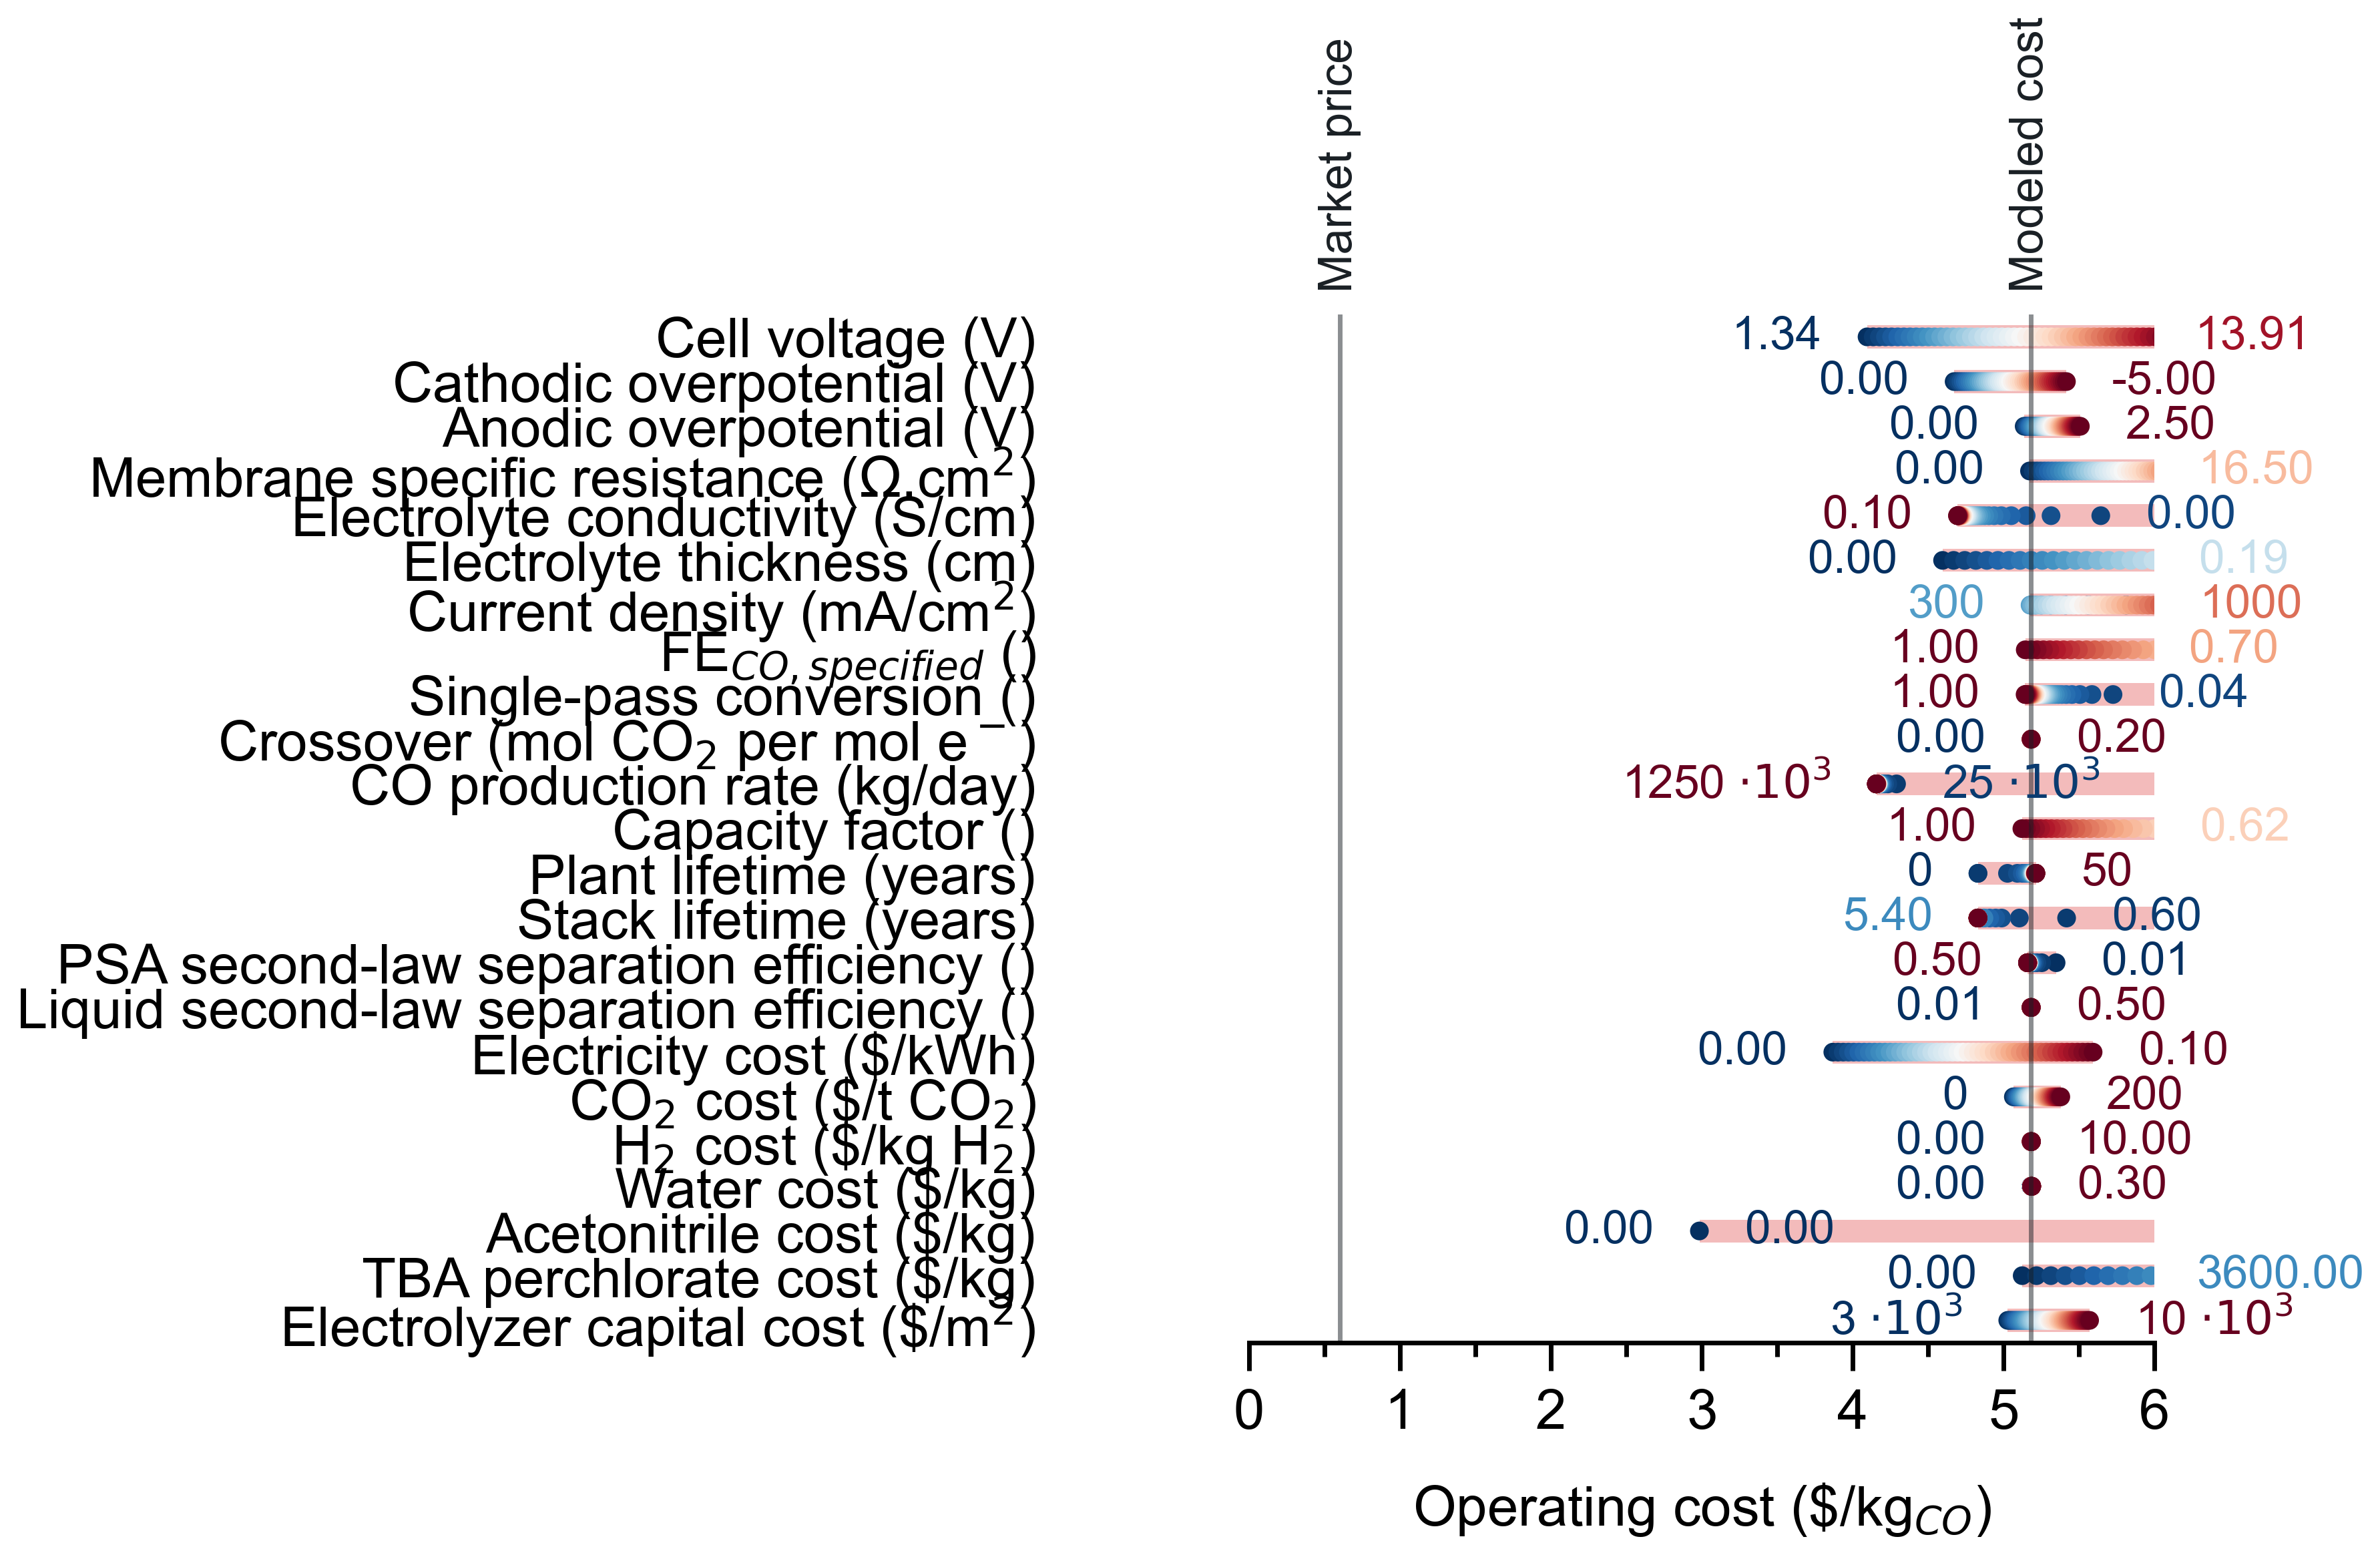

In [ ]:
if override_onebyone == True:
    # Plot emissions per kg product over voltage range - bar chart

    fig, axs = plt.subplots(figsize = (7, 7*aspect_ratio + 1)) # Set up plot

    y_axis_min = 0.5
    y_axis_max = len(vbl_names) + 0.5
    
    x_axis_max = opex_x_axis_max
    x_axis_min = opex_x_axis_min 
    x_axis_step = 1 # 1 # 0.4
#     x_axis_num = 6
    x_axis_major_ticks =  np.arange(x_axis_min, x_axis_max, step = x_axis_step)
    x_axis_major_ticks = np.append(x_axis_major_ticks, x_axis_max) # since arange omits the last point, have to add it back in manually
#     x_axis_major_ticks = np.linspace(x_axis_min, x_axis_max, num = x_axis_num, endpoint = True) # 

    label_padding = abs(x_axis_max - x_axis_min)/20

    ## Axis labels
    axs.set_xlabel('Operating cost (\$/kg$_{{{}}}$)'.format(product_name))

    ## Hide or show plot borders 
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    axs.spines['left'].set_visible(False)
    axs.spines['bottom'].set_visible(True)
    
    ## Handle axis ticks
    axs.minorticks_off()
    axs.tick_params(bottom = True, top = False, left = False, right = False)
            
    ## Draw axis ticks
    axs.tick_params(axis = 'y', pad = 80) # Spacing between y-axis and origin
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, 
                                                     # then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])

    ## Plot bar charts  
    axs.barh(np.arange(1, len(vbl_names) + 1), width = [opex_maxima[i] - opex_minima[i] for i in range(len(vbl_names))], 
             label='', left=opex_minima, height = barwidth, tick_label = ['{} ({})'.format(vbl_names[i], vbl_units[i]) for i in range(len(vbl_names))],
            color = theme_colors[5], alpha = 0.4)
    
    ## Plot lines for average cost and price
    axs.plot([product_cost_USD_kgprod, product_cost_USD_kgprod], [y_axis_min - 1, y_axis_max], 
             c = theme_colors[6], alpha = 0.5)
    axs.text(product_cost_USD_kgprod, y_axis_min - 0.5, 
             'Market price', 
             ha = 'center', va = 'bottom', fontsize = SMALL_SIZE,
              rotation = 90, c = theme_colors[6])
    
    axs.plot([df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)], df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)]], 
             [y_axis_min - 1, y_axis_max], 
             c = theme_colors[6], alpha = 0.5)
    axs.text(df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)], y_axis_min - 0.5, 
             'Modeled cost', 
             ha = 'center', va = 'bottom', fontsize = SMALL_SIZE,
              rotation = 90, c = theme_colors[6])
            
    ## Plot scatter and min/max labels
    for i, vbl_name in enumerate(vbl_names):
        # Scatterplot
        axs.scatter(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'], 
                    (i+1)*np.ones(len(dict_sensitivity_cleaned[vbl_name]['Range'])),
                   s = 50, marker = 'o', c = dict_sensitivity_cleaned[vbl_name]['Colors'])
        # Labels 
        if vbl_name == '{} production rate'.format(product_name) or vbl_name == 'Electrolyzer capital cost':
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'][opex_minima_idx[i]] - label_padding, 
                     i+1, '{:.0f} $ \cdot 10^3$'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][opex_minima_idx[i]]/1000)),
                    horizontalalignment = 'right', verticalalignment = 'center',
                    fontsize = SMALL_SIZE, c = dict_sensitivity_cleaned[vbl_name]['Colors'][opex_minima_idx[i]])
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'][opex_maxima_idx[i]] + label_padding, 
                     i+1, '{:.0f} $ \cdot 10^3$'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][opex_maxima_idx[i]]/1000)),
                    horizontalalignment = 'left', verticalalignment = 'center', c = dict_sensitivity_cleaned[vbl_name]['Colors'][opex_maxima_idx[i]],
                    fontsize = SMALL_SIZE)
        elif vbl_name == 'Current density' or vbl_name == 'Plant lifetime' or vbl_name == 'CO$_2$ cost':
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'][opex_minima_idx[i]] - label_padding, 
                     i+1, '{:.0f}'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][opex_minima_idx[i]])),
                    horizontalalignment = 'right', verticalalignment = 'center',
                    fontsize = SMALL_SIZE, c = dict_sensitivity_cleaned[vbl_name]['Colors'][opex_minima_idx[i]])
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'][opex_maxima_idx[i]] + label_padding, 
                     i+1, '{:.0f}'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][opex_maxima_idx[i]])),
                    horizontalalignment = 'left', verticalalignment = 'center', c = dict_sensitivity_cleaned[vbl_name]['Colors'][opex_maxima_idx[i]],
                    fontsize = SMALL_SIZE)
        else:
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'][opex_minima_idx[i]] - label_padding, 
                     i+1, '{:.2f}'.format(dict_sensitivity_cleaned[vbl_name]['Range'][opex_minima_idx[i]]),
                    horizontalalignment = 'right', verticalalignment = 'center',
                    fontsize = SMALL_SIZE, c = dict_sensitivity_cleaned[vbl_name]['Colors'][opex_minima_idx[i]])
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'][opex_maxima_idx[i]] + label_padding, 
                     i+1, '{:.2f}'.format(dict_sensitivity_cleaned[vbl_name]['Range'][opex_maxima_idx[i]]),
                    horizontalalignment = 'left', verticalalignment = 'center', c = dict_sensitivity_cleaned[vbl_name]['Colors'][opex_maxima_idx[i]],
                    fontsize = SMALL_SIZE)
            
    ## Legend
#     axs.legend(bbox_to_anchor=(1, 1), loc='upper left') 
    # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position
    
    ## Flip the horizontal bars
    axs.invert_yaxis()
    
    ## Save figure 
    opex_sens_fig_name = os.path.join(OP_folder,'{} Opex sensitivity {} {}'.format(current_date, product_name, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(opex_sens_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex_sens_fig_name + '.jpg', transparent = True, dpi = 80, ) 
    fig.savefig(opex_sens_fig_name + '.pdf', transparent = True )
    # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + opex_sens_fig_name )
    
    plt.show()

## 5.5. Plot capex sensitivity

C:\Users\shash\AppData\Local\Temp\ipykernel_31352\2419400362.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label='', left=[i/1e6 for i in capex_minima], height = barwidth, tick_label = ['{} ({})'.format(vbl_names[i], vbl_units[i]) for i in range(len(vbl_names))],
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\2419400362.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axs.text((dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment'][capex_minima_idx[i]]/1e6) - label_padding,
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\2419400362.py:90: FutureWarning: Series.__getitem__

Saved at E:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R\LCA TEA non-aq results on 20241111\20241111 Capex sensitivity CO 04-34PM


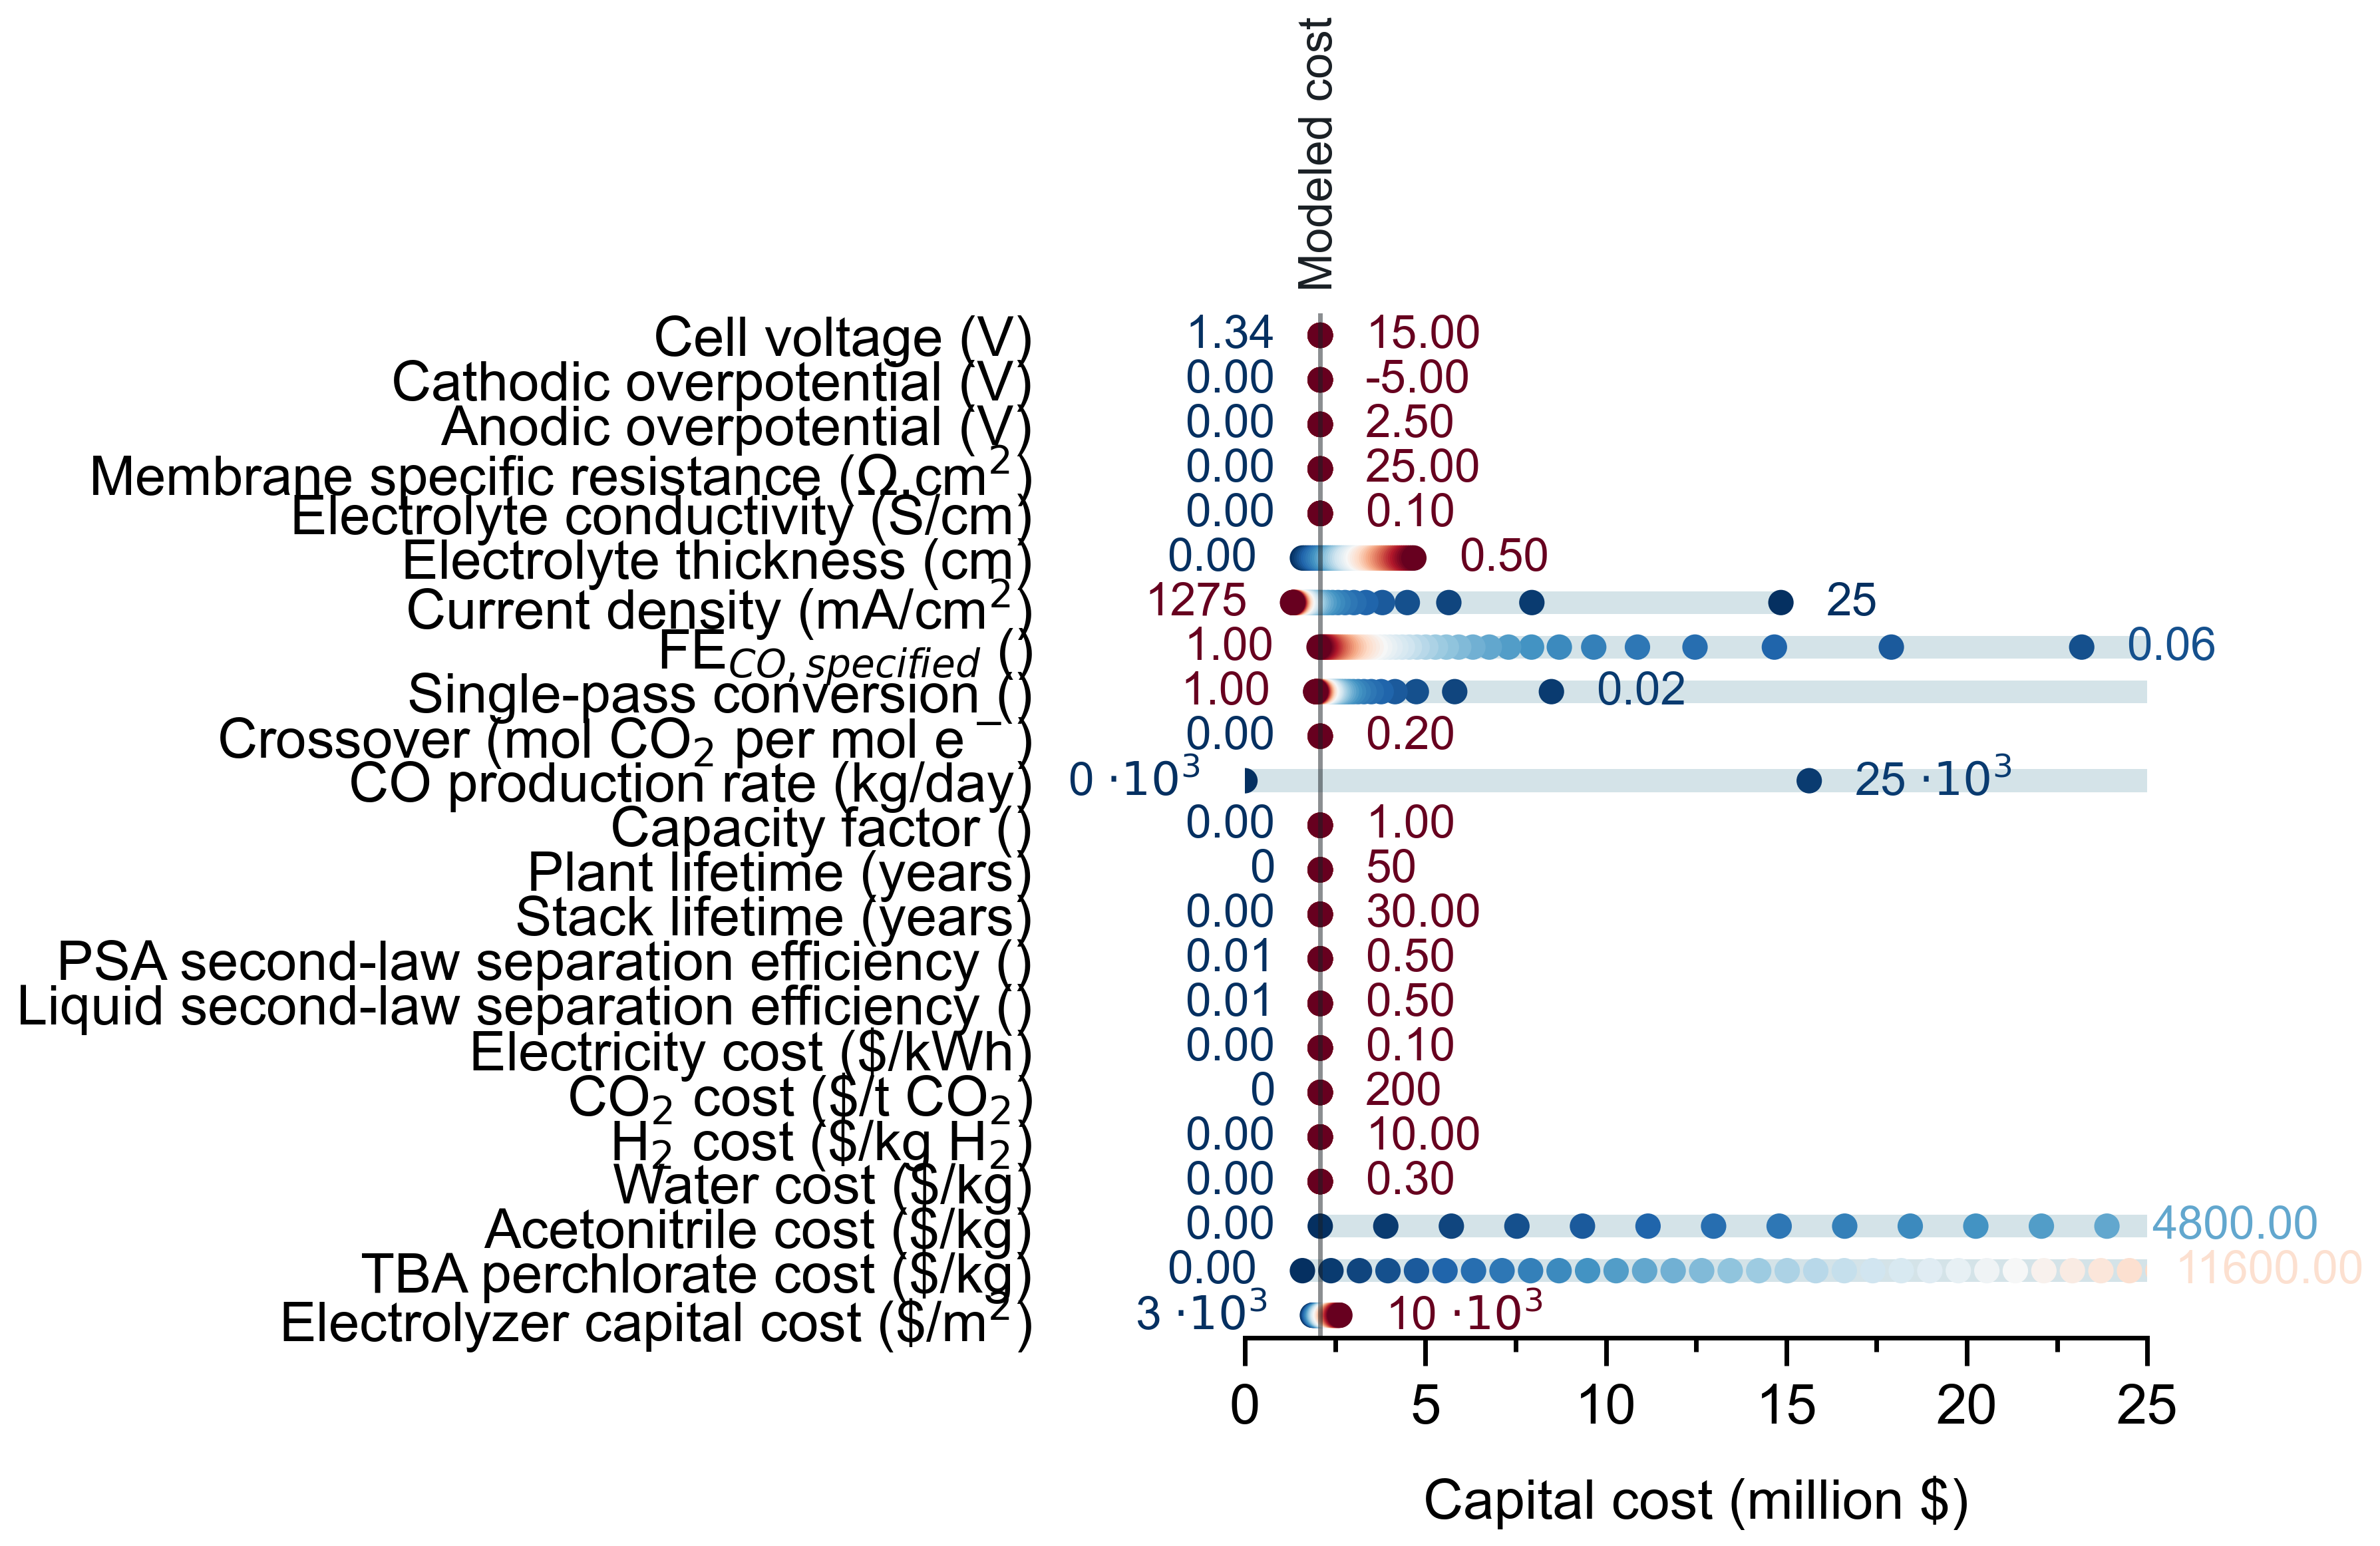

In [ ]:
if override_onebyone == True:
    # Plot emissions per kg product over voltage range - bar chart

    fig, axs = plt.subplots(figsize = (7,7*aspect_ratio + 1)) # Set up plot

    y_axis_min = 0.5
    y_axis_max = len(vbl_names) + 0.5
    
    x_axis_max = capex_x_axis_max # 500 # np.ceil(max(capex_maxima)/1e6)   # round to nearest million
    x_axis_min = capex_x_axis_min # np.floor(min(capex_minima)/1e6) 
    x_axis_step = 5 # 2
#     x_axis_num = 6
    x_axis_major_ticks =  np.arange(x_axis_min, x_axis_max, step = x_axis_step)
    x_axis_major_ticks = np.append(x_axis_major_ticks, x_axis_max) # since arange omits the last point, have to add it back in manually
#     x_axis_major_ticks = np.linspace(x_axis_min, x_axis_max, num = x_axis_num, endpoint = True) # 

    label_padding = abs(x_axis_max - x_axis_min)/20

    ## Axis labels
    axs.set_xlabel('Capital cost (million \$)'.format(product_name))

    ## Hide or show plot borders 
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    axs.spines['left'].set_visible(False)
    axs.spines['bottom'].set_visible(True)
    axs.tick_params(bottom = True, top = False, left = False, right = False)
    
    ## Handle axis ticks
    axs.minorticks_off()
    axs.tick_params(bottom = True, top = False, left = False, right = False)
            
    ## Draw axis ticks
    axs.tick_params(axis = 'y', pad = 80) # Spacing between y-axis and origin
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, 
                                                     # then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])

    ## Plot series  
    # All capex except working capital, which is recovered during operation
    axs.barh(np.arange(1, len(vbl_names) + 1), width = [(capex_maxima[i] - capex_minima[i])/1e6 for i in range(len(vbl_names))], 
             label='', left=[i/1e6 for i in capex_minima], height = barwidth, tick_label = ['{} ({})'.format(vbl_names[i], vbl_units[i]) for i in range(len(vbl_names))],
             alpha = 0.3,
            color = theme_colors[3])
    
    axs.plot([df_capex_totals.loc['Total permanent investment', 'Cost ($)']/1e6, df_capex_totals.loc['Total permanent investment', 'Cost ($)']/1e6], 
             [y_axis_min - 1, y_axis_max], 
             c = theme_colors[6], alpha = 0.5)
    axs.text(df_capex_totals.loc['Total permanent investment', 'Cost ($)']/1e6, y_axis_min - 0.5, 
             'Modeled cost', 
             ha = 'center', va = 'bottom', fontsize = SMALL_SIZE,
              rotation = 90, c = theme_colors[6])
     
    ## Plot scatter and min/max labels    
    for i, vbl_name in enumerate(vbl_names):
        # Scatterplot
        axs.scatter(dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment']/1e6, 
                    (i+1)*np.ones(len(dict_sensitivity_cleaned[vbl_name]['Range'])),
                   s = 100, marker = 'o', c = dict_sensitivity_cleaned[vbl_name]['Colors'])

        # Labels 
                # Label text, formatted to basically maintain 2-3 sig figs
        if vbl_name == '{} production rate'.format(product_name) or vbl_name == 'Electrolyzer capital cost':
            axs.text((dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment'][capex_minima_idx[i]]/1e6) - label_padding, 
                    i+1, '{:.0f} $ \cdot 10^3$'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][capex_minima_idx[i]]/1000)),
                    horizontalalignment = 'right', verticalalignment = 'center',
                    fontsize = SMALL_SIZE, c = dict_sensitivity_cleaned[vbl_name]['Colors'][capex_minima_idx[i]])
            axs.text((dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment'][capex_maxima_idx[i]]/1e6) + label_padding, 
                     i+1, '{:.0f} $ \cdot 10^3$'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][capex_maxima_idx[i]]/1000)),
                    horizontalalignment = 'left', verticalalignment = 'center', c = dict_sensitivity_cleaned[vbl_name]['Colors'][capex_maxima_idx[i]],
                    fontsize = SMALL_SIZE)  
        elif vbl_name == 'Current density' or vbl_name == 'Plant lifetime' or vbl_name == 'CO$_2$ cost':
            axs.text((dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment'][capex_minima_idx[i]]/1e6) - label_padding, 
                     i+1, '{:.0f}'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][capex_minima_idx[i]])),
                    horizontalalignment = 'right', verticalalignment = 'center',
                    fontsize = SMALL_SIZE, c = dict_sensitivity_cleaned[vbl_name]['Colors'][capex_minima_idx[i]])
            axs.text((dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment'][capex_maxima_idx[i]]/1e6) + label_padding, 
                     i+1, '{:.0f}'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][capex_maxima_idx[i]])),
                    horizontalalignment = 'left', verticalalignment = 'center',c = dict_sensitivity_cleaned[vbl_name]['Colors'][capex_maxima_idx[i]],
                fontsize = SMALL_SIZE) 
        else:
            axs.text((dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment'][capex_minima_idx[i]]/1e6) - label_padding, 
                     i+1, '{:.2f}'.format(dict_sensitivity_cleaned[vbl_name]['Range'][capex_minima_idx[i]]),
                    horizontalalignment = 'right', verticalalignment = 'center',
                    fontsize = SMALL_SIZE, c = dict_sensitivity_cleaned[vbl_name]['Colors'][capex_minima_idx[i]])
            axs.text((dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment'][capex_maxima_idx[i]]/1e6) + label_padding, 
                     i+1, '{:.2f}'.format(dict_sensitivity_cleaned[vbl_name]['Range'][capex_maxima_idx[i]]),
                    horizontalalignment = 'left', verticalalignment = 'center',c = dict_sensitivity_cleaned[vbl_name]['Colors'][capex_maxima_idx[i]],
                fontsize = SMALL_SIZE) 
      
    ## Flip the horizontal bars
    axs.invert_yaxis()

    ## Legend
#     axs.legend(bbox_to_anchor=(1, 1), loc='upper left') 
    # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Save figure 
    capex_sens_fig_name = os.path.join(OP_folder,'{} Capex sensitivity {} {}'.format(current_date, product_name, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(capex_sens_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(capex_sens_fig_name + '.jpg', transparent = True, dpi = 80, ) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(capex_sens_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + capex_sens_fig_name )
    
    plt.show()

## 5.6. Plot opex+capex sensitivity

C:\Users\shash\AppData\Local\Temp\ipykernel_31352\1892366172.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label='', left=levelized_minima, height = barwidth, tick_label = ['{} ({})'.format(vbl_names[i], vbl_units[i]) for i in range(len(vbl_names))],
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\1892366172.py:101: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'][levelized_minima_idx[i]] - label_padding,
C:\Users\shash\AppData\Local\Temp\ipykernel_31352\1892366172.py:105: FutureWarning: Series.__getitem__ treating keys as p

Saved at E:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R\LCA TEA non-aq results on 20241111\20241111 Opex+capex sensitivity CO 04-34PM


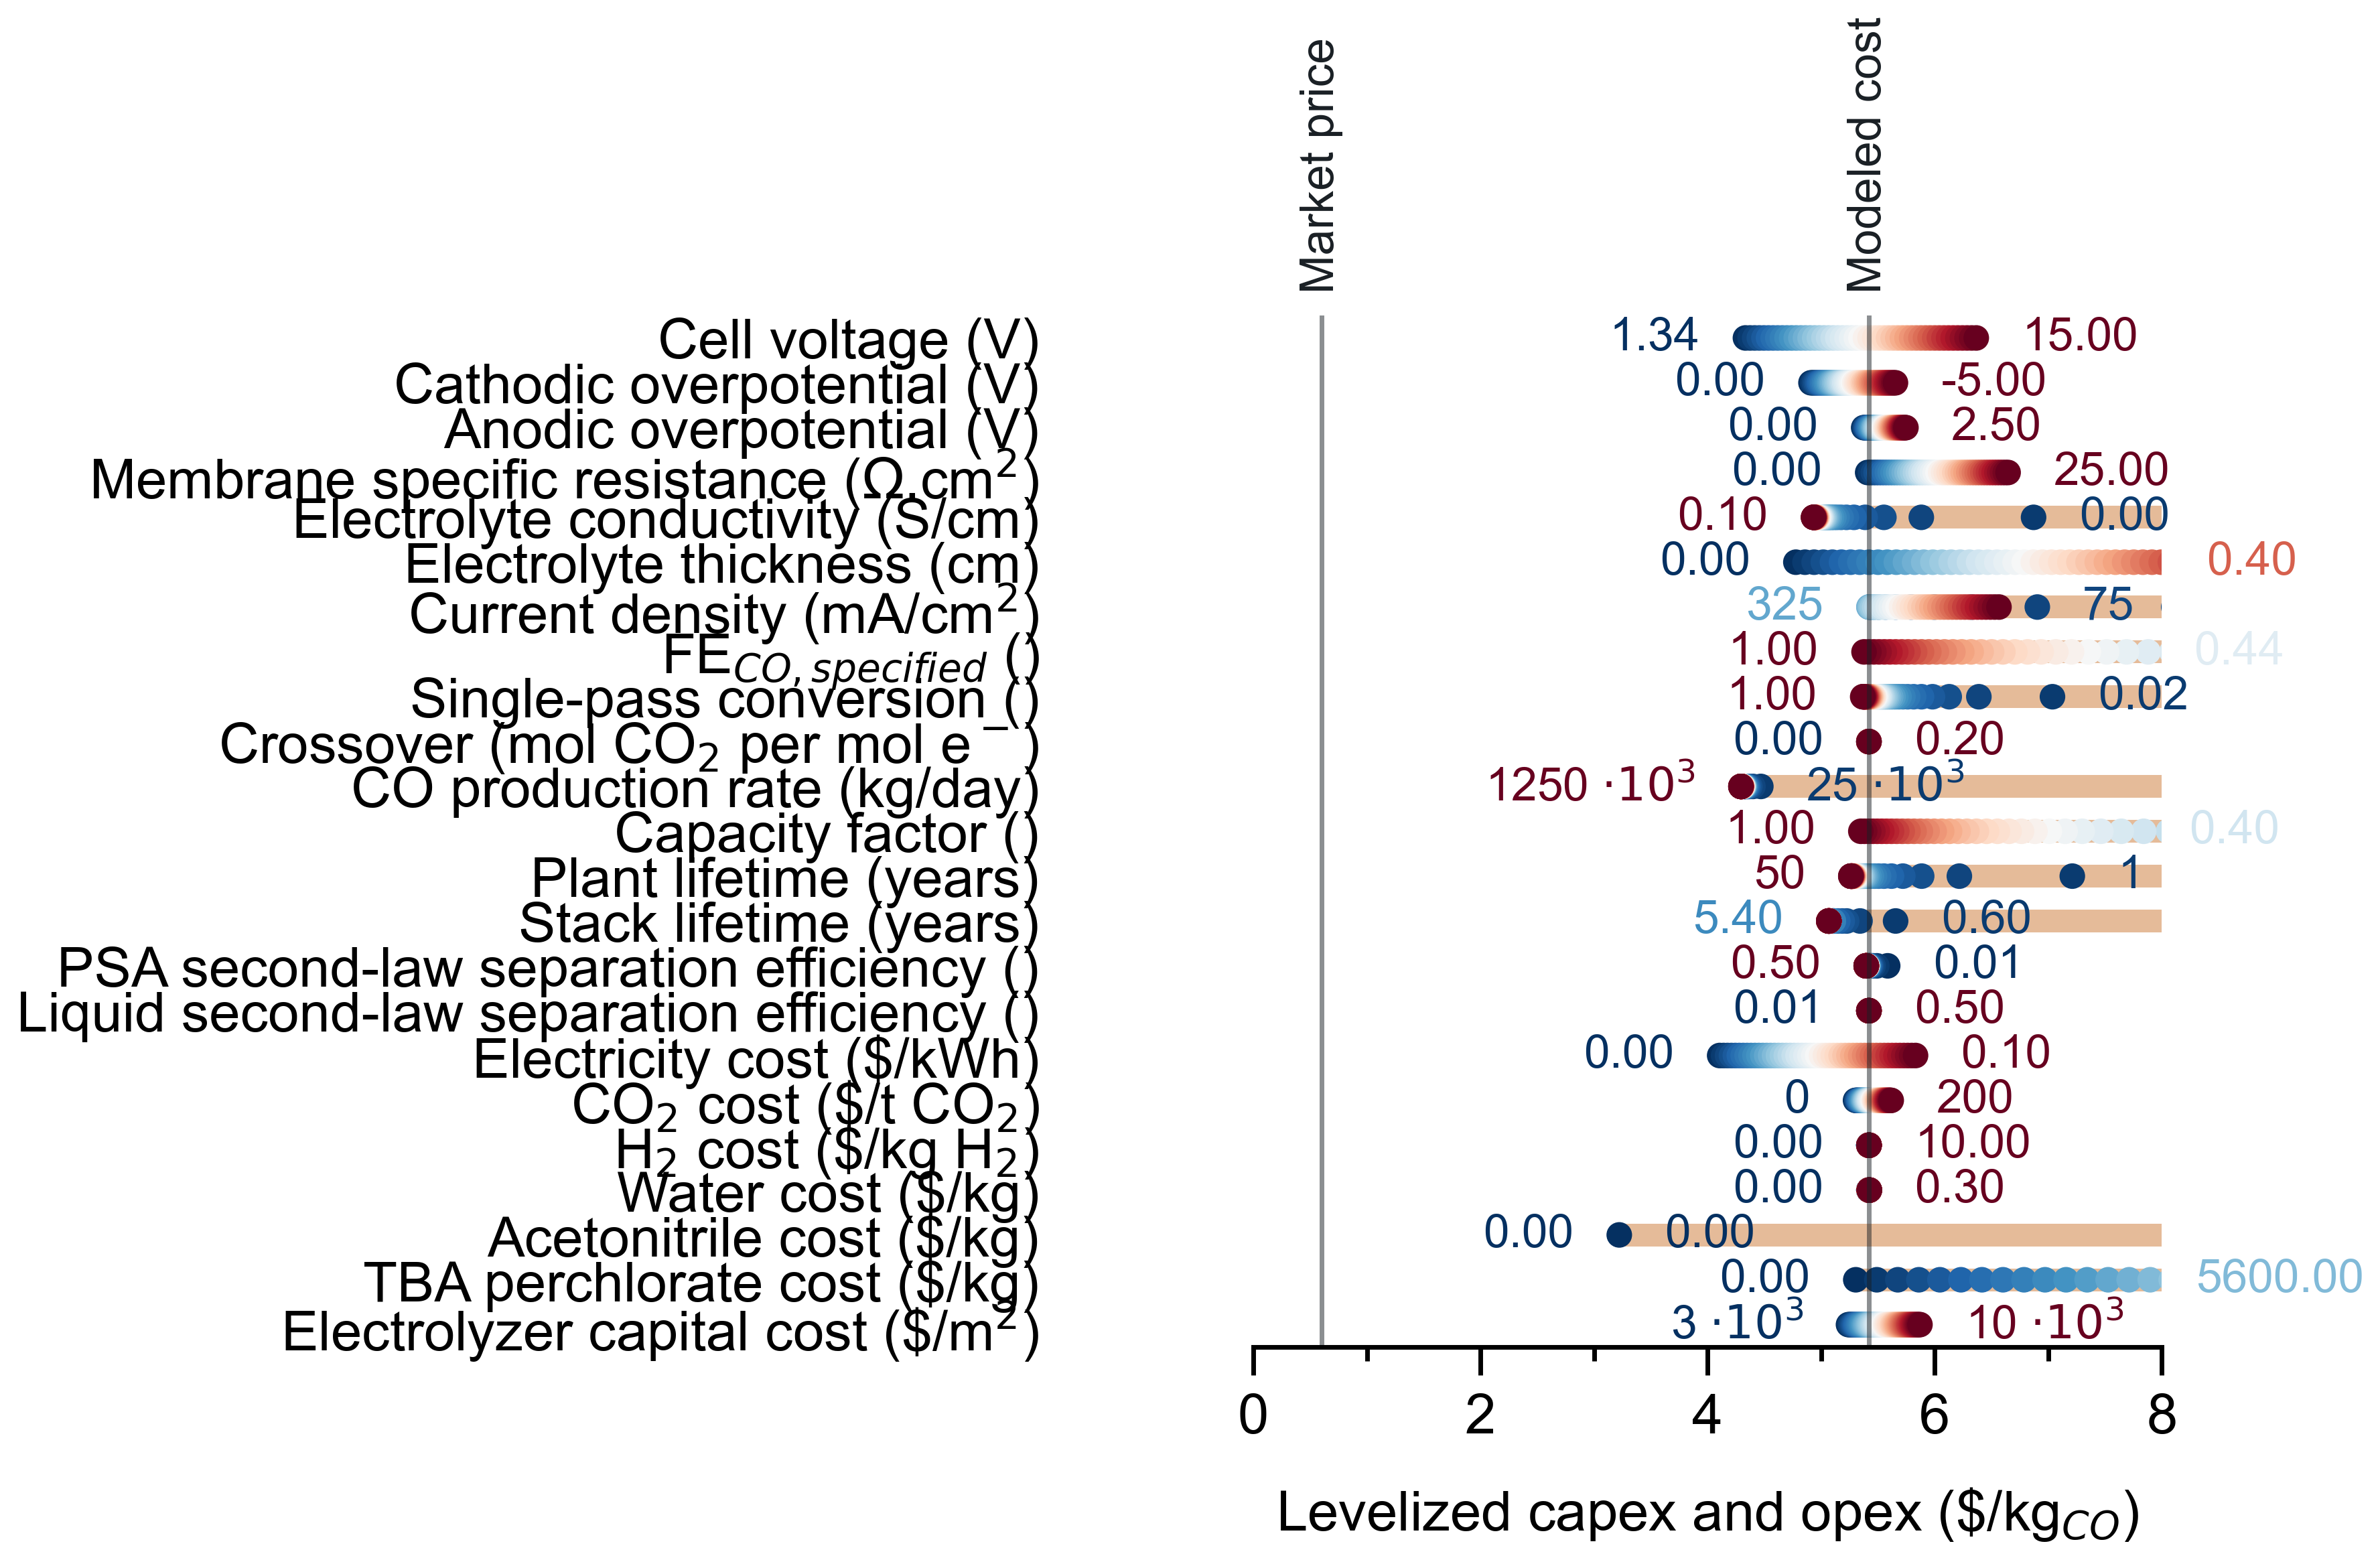

In [ ]:
if override_onebyone == True:
    # Plot emissions per kg product over voltage range - bar chart

    fig, axs = plt.subplots(figsize = (7, 7*aspect_ratio + 1)) # Set up plot
 
    y_axis_min = 0.5
    y_axis_max = len(vbl_names) + 0.5
    
    x_axis_max =  levelized_x_axis_max 
    x_axis_min = levelized_x_axis_min 
    x_axis_step = 2 # 1 # 0.4 
#     x_axis_num = 6
    x_axis_major_ticks =  np.arange(x_axis_min, x_axis_max, step = x_axis_step)
    x_axis_major_ticks = np.append(x_axis_major_ticks, x_axis_max) # since arange omits the last point, have to add it back in manually
#     x_axis_major_ticks = np.linspace(x_axis_min, x_axis_max, num = x_axis_num, endpoint = True) # 

    label_padding = abs(x_axis_max - x_axis_min)/20

    ## Axis labels
    axs.set_xlabel('Levelized capex and opex (\$/kg$_{{{}}}$)'.format(product_name))

    ## Hide or show plot borders 
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    axs.spines['left'].set_visible(False)
    axs.spines['bottom'].set_visible(True)
    axs.tick_params(bottom = True, top = False, left = False, right = False)
            
    ## Handle axis ticks
    axs.minorticks_off()
    axs.tick_params(bottom = True, top = False, left = False, right = False)
            
    ## Draw axis ticks
    axs.tick_params(axis = 'y', pad = 80) # Spacing between y-axis and origin
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, 
                                                     # then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])

    ## Plot bars   
    axs.barh(np.arange(1, len(vbl_names) + 1), width = [levelized_maxima[i] - levelized_minima[i] for i in range(len(vbl_names))], 
             label='', left=levelized_minima, height = barwidth, tick_label = ['{} ({})'.format(vbl_names[i], vbl_units[i]) for i in range(len(vbl_names))],
            color = theme_colors[0], alpha = 0.4) 
    
    ## Plot lines for average cost and price
    axs.plot([product_cost_USD_kgprod, product_cost_USD_kgprod], [y_axis_min - 1, y_axis_max], 
             c = theme_colors[6], alpha = 0.5)
    axs.text(product_cost_USD_kgprod, y_axis_min - 0.5, 
             'Market price', 
             ha = 'center', va = 'bottom', fontsize = SMALL_SIZE,
              rotation = 90, c = theme_colors[6])
    
    ## Plot scatter and min/max labels
    # Levelized cost includes all capex except working capital, which is recovered during operation
    axs.plot([  (df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)] + \
            df_capex_totals.loc['Total permanent investment', 'Cost ($)']/(df_costing_assumptions.loc['Plant lifetime', 'Cost']* \
            365*df_costing_assumptions.loc['Capacity factor', 'Cost']) / df_electrolyzer_assumptions.loc['Production rate', 'Value']) , 
               (df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)] + \
            df_capex_totals.loc['Total permanent investment', 'Cost ($)']/(df_costing_assumptions.loc['Plant lifetime', 'Cost']* \
            365*df_costing_assumptions.loc['Capacity factor', 'Cost']) / df_electrolyzer_assumptions.loc['Production rate', 'Value']) 
               ], 
             [y_axis_min - 1, y_axis_max], 
             c = theme_colors[6], alpha = 0.5)
    axs.text((df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)] + \
            df_capex_totals.loc['Total permanent investment', 'Cost ($)']/(df_costing_assumptions.loc['Plant lifetime', 'Cost']* \
            365*df_costing_assumptions.loc['Capacity factor', 'Cost']) / df_electrolyzer_assumptions.loc['Production rate', 'Value']) , 
             y_axis_min - 0.5, 
             'Modeled cost', 
             ha = 'center', va = 'bottom', fontsize = SMALL_SIZE,
              rotation = 90, c = theme_colors[6])
    
    for i, vbl_name in enumerate(vbl_names):
        # Scatter points 
        axs.scatter(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'], 
                    (i+1)*np.ones(len(dict_sensitivity_cleaned[vbl_name]['Range'])),
                   s = 100, marker = 'o', c = dict_sensitivity_cleaned[vbl_name]['Colors'])

        # Label text, formatted to basically maintain 2-3 sig figs
        if vbl_name == '{} production rate'.format(product_name) or vbl_name == 'Electrolyzer capital cost':
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'][levelized_minima_idx[i]] - label_padding, 
                     i+1, '{:.0f} $ \cdot 10^3$'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][levelized_minima_idx[i]]/1000)),
                    horizontalalignment = 'right', verticalalignment = 'center',
                    fontsize = SMALL_SIZE, c = dict_sensitivity_cleaned[vbl_name]['Colors'][levelized_minima_idx[i]])
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'][levelized_maxima_idx[i]] + label_padding, 
                     i+1, '{:.0f} $ \cdot 10^3$'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][levelized_maxima_idx[i]]/1000)),
                    horizontalalignment = 'left', verticalalignment = 'center', c = dict_sensitivity_cleaned[vbl_name]['Colors'][levelized_maxima_idx[i]],
                    fontsize = SMALL_SIZE)  
        elif vbl_name == 'Current density' or vbl_name == 'Plant lifetime' or vbl_name == 'CO$_2$ cost':
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'][levelized_minima_idx[i]] - label_padding, 
                     i+1, '{:.0f}'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][levelized_minima_idx[i]])),
                    horizontalalignment = 'right', verticalalignment = 'center',
                    fontsize = SMALL_SIZE, c = dict_sensitivity_cleaned[vbl_name]['Colors'][levelized_minima_idx[i]])
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'][levelized_maxima_idx[i]] + label_padding, 
                     i+1, '{:.0f}'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][levelized_maxima_idx[i]])),
                    horizontalalignment = 'left', verticalalignment = 'center', c = dict_sensitivity_cleaned[vbl_name]['Colors'][levelized_maxima_idx[i]],
                    fontsize = SMALL_SIZE)
        else:            
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'][levelized_minima_idx[i]] - label_padding, 
                     i+1, '{:.2f}'.format(dict_sensitivity_cleaned[vbl_name]['Range'][levelized_minima_idx[i]]),
                    horizontalalignment = 'right', verticalalignment = 'center',
                    fontsize = SMALL_SIZE, c = dict_sensitivity_cleaned[vbl_name]['Colors'][levelized_minima_idx[i]])
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'][levelized_maxima_idx[i]] + label_padding, 
                     i+1, '{:.2f}'.format(dict_sensitivity_cleaned[vbl_name]['Range'][levelized_maxima_idx[i]]),
                    horizontalalignment = 'left', verticalalignment = 'center', c = dict_sensitivity_cleaned[vbl_name]['Colors'][levelized_maxima_idx[i]],
                    fontsize = SMALL_SIZE)   
    
    ## Flip the horizontal bars
    axs.invert_yaxis()

    ## Legend
#     axs.legend(bbox_to_anchor=(1, 1), loc='upper left') 
    # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Save figure 
    levelized_sens_fig_name = os.path.join(OP_folder, '{} Opex+capex sensitivity {} {}'.format(current_date, product_name, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(levelized_sens_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(levelized_sens_fig_name + '.jpg', transparent = True, dpi = 80, ) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(levelized_sens_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + levelized_sens_fig_name )
    
    plt.show()

## 5.7 Save sensitivity results to Excel

In [ ]:
if override_onebyone == True:
    excel_file_name = os.path.join(OP_folder, '{} {} sensitivity at {}'.format(current_date, product_name, current_time) )
    excel_file_name = excel_file_name.replace(".", ",") + '.xlsx'
        
    ### Save modeled results to Excel
    print('Writing new file {} \n'.format(excel_file_name)) # Print
    
    # With an ExcelWriter object, write to Excel using openpyxl        
    with pd.ExcelWriter(excel_file_name, engine='openpyxl', mode = 'w', 
                    datetime_format = 'YYYY-MM-DD HH:MM:SS') as writer_obj:  # Open a writer object in mode write ('w'); it will close itself at the end of with loop
        
        # Write constants and imports first
        df_constants.reset_index(inplace = False).to_excel(writer_obj, 
                                                           sheet_name = params_sheet_name, 
                                                           startcol = 0, startrow = 0) # write to Excel - file names
        df_utility_imports.reset_index(inplace = False).to_excel(writer_obj, 
                                                         sheet_name = params_sheet_name, 
                                                         startcol = 0, startrow = df_constants.shape[0] + 4) # write to Excel - constants
        df_solvents.reset_index(inplace = False).to_excel(writer_obj, 
                                                         sheet_name = params_sheet_name, 
                                                         startcol = 0, startrow = df_constants.shape[0] + df_utility_imports.shape[0] + 4) # write to Excel - constants
        df_supporting.reset_index(inplace = False).to_excel(writer_obj, 
                                                         sheet_name = params_sheet_name, 
                                                         startcol = 0, startrow = df_constants.shape[0] + df_utility_imports.shape[0] + df_solvents.shape[0] + 4) # write to Excel - constants
        
        # Iterate through variables
        for vbl_name in vbl_names:
            # Sheet name skeletons
            results_sheet_name = 'Results vs {}'.format(vbl_name)[:30]  # Name results sheet
            streams_sheet_name = 'Streams vs {}'.format(vbl_name)[:30]
            econ_sheet_name = 'Economics vs {}'.format(vbl_name)[:30]
            
            # Iterate through vbl range and save each stream and econ table
            for i, j in enumerate(dict_sensitivity[vbl_name]['Range']):
            
                # Economics writing
                row = 0 # row counter
                for df in [dict_sensitivity[vbl_name][j]['Economics'][df_costing_assumptions.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_capex_BM.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_capex_totals.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_opex.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_opex_totals.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_sales.index.name],  
                       dict_sensitivity[vbl_name][j]['Economics'][df_feedstocks.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_utilities.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_operations.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_maintenance.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_overhead.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_taxes.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_depreciation.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_general.index.name]]:
                    df.reset_index(inplace=False).to_excel(writer_obj, 
                                                            sheet_name = econ_sheet_name, 
                                                            startrow = row, 
                                                            startcol = i*8) # write to Excel - output sheet
                    row += (2 + df.shape[0])
                    

                # Stream and energy table writing            
                row = 0 # row counter
                for df in [dict_sensitivity[vbl_name][j]['Streams'][df_streams_formatted.index.name], 
                           dict_sensitivity[vbl_name][j]['Streams'][df_electrolyzer_assumptions.index.name], 
                           dict_sensitivity[vbl_name][j]['Streams'][df_outlet_assumptions.index.name], 
                           dict_sensitivity[vbl_name][j]['Streams'][df_energy.index.name], 
                           dict_sensitivity[vbl_name][j]['Streams'][df_potentials.index.name]]:
                    df.reset_index(inplace=False).to_excel(writer_obj, 
                                                        sheet_name = streams_sheet_name, 
                                                        startrow = row, 
                                                        startcol = i*26) # write to Excel - output sheet
                    row += (2 + df.shape[0])

            # Write completed "summary" dataframes for variable
            row = 0 # row counter
            for df in [dict_sensitivity[vbl_name]['Opex vs vbl'],
                       dict_sensitivity[vbl_name]['Bare-module investment vs vbl'],
                       dict_sensitivity[vbl_name]['Capex vs vbl'],
                      dict_sensitivity[vbl_name]['Potentials vs vbl'],
                      dict_sensitivity[vbl_name]['Emissions vs vbl'],
                      dict_sensitivity[vbl_name]['Electrolyzer assumptions vs vbl'],
                      dict_sensitivity[vbl_name]['Costing assumptions vs vbl']]:

                df.reset_index(inplace=False).to_excel(writer_obj, 
                                                       sheet_name = results_sheet_name, 
                                                       startrow = row, 
                                                       startcol = 0) # write to Excel - output sheet
                row += (2 + df.shape[0])

            print('Done writing sheets for {}'.format(vbl_name))

        # # Format all sheets
        # book_format(writer = writer_obj) # apply sheet formatting

        # print('\n')
        # print('Done formatting sheets \n')

        ## Write figure to Excel
        book  = writer_obj.book # Get workbook
        sheet = writer_obj.sheets[results_sheet_name] # Get worksheet of last variable  

        counter = 1
        for fig_name in [opex_sens_fig_name, capex_sens_fig_name, levelized_sens_fig_name]:
                img = openpyxl.drawing.image.Image(fig_name + '.jpg') # Image cannot be a .svg
                img.width = 300*aspect_ratio #px
                img.height = 300
                sheet.add_image(img, 'G' + str(counter)) # Add to the sheet

                counter += 20

        print('Saved figures \n')

    print('Written to file ', excel_file_name) # Print 

Writing new file E:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R\LCA TEA non-aq results on 20241111\20241111 CO sensitivity at 04-34PM.xlsx 

Done writing sheets for Cell voltage
Done writing sheets for Cathodic overpotential
Done writing sheets for Anodic overpotential
Done writing sheets for Membrane specific resistance
Done writing sheets for Electrolyte conductivity
Done writing sheets for Electrolyte thickness
Done writing sheets for Current density
Done writing sheets for FE$_{CO , specified}$
Done writing sheets for Single-pass conversion
Done writing sheets for Crossover
Done writing sheets for CO production rate
Done writing sheets for Capacity factor
Done writing sheets for Plant lifetime
Done writing sheets for Stack lifetime
Done writing sheets for PSA second-law separation efficiency
Done writing sheets for Liquid second-law separation efficiency
Done writing sheets for Electricity cost
Done writing sheets for CO$_2$ cost
Done writing shee

----

# 6. Two-variable sensitivity

## 6.1 Range in variables

### 6.1.1 Choose variables

In [ ]:
# Choose variables to vary independently
answer = input('Do you want to vary multiple assumptions together? (y/n) \n ')

if answer.lower() == 'y':
    override_multivbl = True # are you varying any basis? set to true by default, below will falsify if needed
else:
    override_multivbl = False 

In [ ]:
if override_multivbl== True:
    display(df_flags.reset_index(inplace = False, drop = False)) # print df_flags

    answer = input('Enter 2 comma-separated row numbers from the below table (x-axis, y-axis): \n')

    vbl_rows = answer.split(',')

    # Clear flags
    df_flags['T/F?'] = False # add column for truth value of given override

    try:
        vbl_rows = [int(vbl_row) for vbl_row in vbl_rows] # convert input into integer
        vbl_names = df_flags.index[vbl_rows] # set vbl_name from those rows
        vbl_units = df_flags['Unit'].iloc[vbl_rows] # set vbl_unit from those rows
        df_flags.iloc[vbl_rows, df_flags.keys()=='T/F?'] = True # set those flags to be True

    except ValueError:
        print('Valid values were not entered')

# 4,13
# 4,3
# 4,17
# 4,8

### 6.1.2 Choose range

In [ ]:
### Get user to input variables to calculate process costs over

print('NOTE: cathodic overpotentials are NEGATIVE if they are higher!')

dict_multivbl = {}

if override_multivbl == True:
    answer = input('Change from default values? y/n \n \n')

    for i, vbl_name in enumerate(vbl_names):
        
        if answer.lower() != 'y':
            vbl_min = df_flags.loc[vbl_name, 'Range min']
            vbl_max = df_flags.loc[vbl_name, 'Range max']
            vbl_range = np.linspace(start = vbl_min, stop = vbl_max, num = 51, endpoint = True)
            answer_range = 2

        else:    
            vbl_unit = vbl_units[i]
            vbl_min, vbl_max, vbl_range, answer_range = generate_range(vbl_name)
            
        vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in vbl_range]
        print(vbl_range_text, '\n')
        dict_multivbl[vbl_name] = {'Range': vbl_range}

# 50 - 1500 mA/cm2
# 0.01 - 10 ohm.cm2, logscale
# 0 - 0.1 $/kWh
# 3000 - 10000 $/m2 electrolyzer
# 300 - 3e6 kg/day, logscale

NOTE: cathodic overpotentials are NEGATIVE if they are higher!


## 6.2 Generate and save results
### 6.2.1 Process model over variable range

In [ ]:
## Make decisions about electrolyte

if override_multivbl:
    answer = input('Do you want to model electrolyte conductivity? y/n \n \n')

    if answer.lower() == 'y':
        model_conductivity = True

    else:
        model_conductivity = False

In [ ]:
## Make decisions about FE-SPC tradeoff

if override_multivbl:
    answer = input('Do you want to model the FE-SPC tradeoff using plug flow? y/n \n \n')

    if answer.lower() == 'y':
        model_FE = 'Hawks'
        print('Using Hawks and Baker model for FE-SPC tradeoff')

    else:
        # model_FE = 'Kas'
        # print('Using Kas and Smith model for FE-SPC tradeoff')
        
        model_FE = None
        print('Using manually specified selectivity - NO model')

In [ ]:
## Make decisions about battery

if override_multivbl:
    answer = input('Do you want to include a battery system? y/n \n \n')

    if answer.lower() == 'y':
                
        # Handle battery to flatten curve and maximize capacity
        is_battery = True
        avbl_renewables = float(input('What is the minimum fraction of time when renewables power the electrolyzer? \n \n'))
        battery_capacity = 1 - avbl_renewables # assumes daily storage battery
        capacity_factor = 350/365 # capacity is re-maximized
        
    else:
        is_battery = False
        battery_capacity = 0

### 6.2.2 Two-variable heatmap

In [ ]:
### Generate modeling results for variable range 

if override_multivbl == True:
    
    #### Iterate through first 2 variables being changed
    vbl_name_1, vbl_name_2 = vbl_names

    vbl_range_text_1 = ['{} {}'.format(x, vbl_units[0]) for x in dict_multivbl[vbl_name_1]['Range'] ]
    vbl_range_text_2 = ['{} {}'.format(x, vbl_units[1]) for x in dict_multivbl[vbl_name_2]['Range'] ]

    meshgrid_multi_capex = np.zeros([ len(dict_multivbl[vbl_name_2]['Range']), len(dict_multivbl[vbl_name_1]['Range'])])
    meshgrid_multi_opex = np.zeros([len(dict_multivbl[vbl_name_2]['Range']), len(dict_multivbl[vbl_name_1]['Range'])])
    meshgrid_multi_levelized = np.zeros([len(dict_multivbl[vbl_name_2]['Range']), len(dict_multivbl[vbl_name_1]['Range'])])

    
    #### Loop through variable 1
    
    if vbl_name_1 != 'Cell voltage' and vbl_name_1 != 'Cathodic overpotential' and vbl_name_1 != 'Anodic overpotential':
        value_original_1 = globals()[df_flags.loc[vbl_name_1,'Python variable']] # Save the original value of the adjusted variable

    if vbl_name_2 != 'Cell voltage' and vbl_name_2 != 'Cathodic overpotential' and vbl_name_2 != 'Anodic overpotential':
                value_original_2 = globals()[df_flags.loc[vbl_name_2,'Python variable']] # Save the original value of the adjusted variable
        
    for i, vbl_1 in enumerate(dict_multivbl[vbl_name_1]['Range']):    
        # Storage for individual runs
        dict_stream_tables = {}
        dict_econ_tables = {}

        # Storage for summary results across varied independent variable
        df_potentials_vs_vbl = pd.DataFrame()
        df_energy_vs_vbl = pd.DataFrame()
        df_emissions_vs_vbl = pd.DataFrame()
        df_electrolyzer_assumptions_vs_vbl = pd.DataFrame()
        df_outlet_assumptions_vs_vbl = pd.DataFrame()
        df_opex_vs_vbl = pd.DataFrame()
        df_opex_totals_vs_vbl = pd.DataFrame()
        df_capex_BM_vs_vbl = pd.DataFrame()
        df_capex_totals_vs_vbl = pd.DataFrame()
        df_costing_assumptions_vs_vbl = pd.DataFrame()
        df_sales_vs_vbl = pd.DataFrame()

        ### Update variable in its place
        globals()[df_flags.loc[vbl_name_1,'Python variable']] = vbl_1 # Overwrite the global variable whose override flag is True

        #### Loop through variable 2
        for j, vbl_2 in enumerate(dict_multivbl[vbl_name_2]['Range']):
            globals()[df_flags.loc[vbl_name_2,'Python variable']] = vbl_2 # Overwrite the global variable whose override flag is True
            
            ### Update the value of 
            dict_multivbl[vbl_name_1][vbl_1] = {'{}'.format(vbl_name_2) : {vbl_2: ''}}
            
            ### Handle battery to flatten curve
            if is_battery:
                battery_capacity = 1 - avbl_renewables # assumes daily storage battery
                capacity_factor = 350/365 # capacity is re-maximized
            else:
                battery_capacity = 0

            ### Generate physical and costing model
            df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
                    df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
                    df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
                    cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run_nonaq(product_name = product_name, 
                                                                                product_rate_kg_day = product_rate_kg_day, 
                                                                                df_products = df_products, FE_CO2R_0 = FE_CO2R_0, 
                                                                                FE_product_specified = FE_product_specified,                
                                                                                j_total_mA_cm2 = j_total_mA_cm2,
                                                                                SPC = SPC, crossover_ratio = crossover_ratio, 
                                                                                model_FE = model_FE, overridden_vbl = '', 
                                                                                overridden_value = np.NaN, overridden_unit = '', 
                                                                                override_optimization =  override_optimization, 
                                                                                P = P, T_streams = T_streams,         R_membrane_ohmcm2 = R_membrane_ohmcm2,             model_conductivity = model_conductivity,         viscosity_cP = viscosity_cP,             lambda_reference = lambda_reference,         viscosity_reference_cP = viscosity_reference_cP,         kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
                                                                                an_E_eqm = an_E_eqm,
                                                                                an_eta_ref = an_eta_ref,
                                                                                an_Tafel_slope = an_Tafel_slope,
                                                                                an_j_ref = an_j_ref,
                                                                                MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
                                                                                MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
                                                                                cathode_outlet_humidity = cathode_outlet_humidity,
                                                                                excess_water_ratio = excess_water_ratio, 
                                                                                catholyte_conc_M = catholyte_conc_M, anolyte_conc_M = anolyte_conc_M, 
                                                                                density_kgm3 = density_kgm3,
                                                                                PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                                T_sep = T_sep, 
                                                                                CO2_solubility_mol_mol = CO2_solubility_mol_mol,
                                                                                electricity_cost_USD_kWh = electricity_cost_USD_kWh,
                                                                                heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                                electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                                heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh, 
                                                                                electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                                product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                                H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                                water_cost_USD_kg = water_cost_USD_kg,
                                                                                CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                                lifetime_years = lifetime_years,
                                                                                stack_lifetime_years = stack_lifetime_years,
                                                                                capacity_factor = capacity_factor,
                                                                                battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                                battery_capacity = battery_capacity,
                                                                                carbon_capture_efficiency = carbon_capture_efficiency,
                                                                                exponent=exponent, 
                                                                                scaling=scaling,
                                                                                R = R,
                                                                                F = F)

            ### Store results of models  
            if df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)] != 0 and df_capex_totals.loc['Total permanent investment', 'Cost ($)'] != 0:
                meshgrid_multi_opex[j, i] = df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)]
                meshgrid_multi_capex[j, i] = df_capex_totals.loc['Total permanent investment', 'Cost ($)'] # All capex except working capital, which is recovered during operation
                meshgrid_multi_levelized[j, i] = df_opex_totals.loc['Levelized cost', 'Cost ($/kg {})'.format(product_name)]
            else:
                meshgrid_multi_opex[j, i] = np.NaN
                meshgrid_multi_capex[j, i] = np.NaN
                meshgrid_multi_levelized[j, i] = np.NaN
                                
            dict_multivbl[vbl_name_1][vbl_1][vbl_name_2][vbl_2] = { 'Streams' : {
                df_streams_formatted.index.name: df_streams_formatted, 
                df_electrolyzer_assumptions.index.name: df_electrolyzer_assumptions, 
                df_outlet_assumptions.index.name: df_outlet_assumptions, 
                df_energy.index.name: df_energy,
                df_potentials.index.name: df_potentials
                }
                }

            dict_multivbl[vbl_name_1][vbl_1][vbl_name_2][vbl_2]['Economics']= {
             df_costing_assumptions.index.name: df_costing_assumptions, 
             df_capex_BM.index.name: df_capex_BM,
             df_capex_totals.index.name: df_capex_totals, 
             df_opex.index.name: df_opex, 
             df_opex_totals.index.name: df_opex_totals, 
             df_sales.index.name: df_sales, 
             df_feedstocks.index.name: df_feedstocks, 
             df_utilities.index.name: df_utilities, 
             df_operations.index.name: df_operations, 
             df_maintenance.index.name: df_maintenance, 
             df_overhead.index.name: df_overhead,
             df_taxes.index.name: df_taxes, 
             df_depreciation.index.name: df_depreciation, 
             df_general.index.name: df_general,
            }

            df_potentials_vs_vbl = pd.concat([df_potentials_vs_vbl, 
                                          df_potentials['Value']], axis = 1)  # Store cell voltages
            df_energy_vs_vbl = pd.concat([df_energy_vs_vbl, 
                                        df_energy['Energy (kJ/kg {})'.format(product_name)]], axis = 1) # Store energy utility for plotting
            df_emissions_vs_vbl = pd.concat([df_emissions_vs_vbl, 
                                         pd.concat([pd.Series(df_outlet_assumptions.loc['Carbon capture loss', 'Value']), df_energy['Emissions (kg CO2/kg {})'.format(product_name)]]) ], 
                                        axis = 1) # Store emissions for plotting
            df_electrolyzer_assumptions_vs_vbl = pd.concat([df_electrolyzer_assumptions_vs_vbl, 
                                                            df_electrolyzer_assumptions['Value']], axis = 1) # Store assumptions
            df_outlet_assumptions_vs_vbl = pd.concat([df_outlet_assumptions_vs_vbl, 
                                                      df_outlet_assumptions['Value']], axis = 1) # Store assumptions
            df_opex_vs_vbl = pd.concat([df_opex_vs_vbl, 
                                        df_opex['Cost ($/kg {})'.format(product_name)]], axis = 1) # Store opex for plotting
            df_opex_totals_vs_vbl = pd.concat([df_opex_totals_vs_vbl, 
                                        df_opex_totals['Cost ($/kg {})'.format(product_name)]], axis = 1) # Store opex for plotting
            df_capex_BM_vs_vbl = pd.concat([df_capex_BM_vs_vbl, 
                                        df_capex_BM['Cost ($)']], axis = 1) # Store capex for plotting
            df_capex_totals_vs_vbl = pd.concat([df_capex_totals_vs_vbl, 
                                        df_capex_totals['Cost ($)']], axis = 1) # Store capex for plotting
            df_costing_assumptions_vs_vbl = pd.concat([df_costing_assumptions_vs_vbl, 
                                        df_costing_assumptions['Cost']], axis = 1) # Store costing assumptions for plotting
            df_sales_vs_vbl = pd.concat([df_sales_vs_vbl, 
                                    df_sales['Earnings ($/yr)']], axis = 1) # Store costing assumptions for plotting

            ### Adjust FE_product, SPC, capacity_factor and variable back to their original values in globals()
            if vbl_name_2 != 'Cell voltage' and vbl_name_2 != 'Cathodic overpotential' and vbl_name_2 != 'Anodic overpotential':
                globals()[df_flags.loc[vbl_name_2,'Python variable']] = value_original_2

            print('Done testing {} = {:.2f}/ {} = {:.2f}; levelized cost = ${:.3f}/ kg {} \n'.format(vbl_name_1, vbl_1, vbl_name_2, vbl_2, df_opex_totals.loc['Levelized cost', 'Cost ($/kg {})'.format(product_name)], product_name))

            ### End inner loop (vbl values)
        
        ### Format completed "summary" dataframes
        for df in [df_energy_vs_vbl, df_potentials_vs_vbl,  df_emissions_vs_vbl,
                       df_electrolyzer_assumptions_vs_vbl, df_outlet_assumptions_vs_vbl, df_costing_assumptions_vs_vbl, 
                       df_capex_BM_vs_vbl, df_capex_totals_vs_vbl, df_opex_vs_vbl, df_sales_vs_vbl
                      ]:
            df.columns = vbl_range_text_2 # rename columns   

        ## Rename index (rows) for collected dataframes; columns will be renamed in the next section
        ## Add in units column but only after duplicating the df, otherwise indexing for plots is very complicated
        df_electrolyzer_assumptions_vs_vbl.index = df_electrolyzer_assumptions.index
    #         df_electrolyzer_assumptions_vs_vbl_2 = df_electrolyzer_assumptions_vs_vbl.copy()
    #         df_electrolyzer_assumptions_vs_vbl_2.insert(0, 'Units', df_electrolyzer_assumptions['Units'])

        df_outlet_assumptions_vs_vbl.index = df_outlet_assumptions.index
    #         df_outlet_assumptions_vs_vbl_2 = df_outlet_assumptions_vs_vbl.copy()
    #         df_outlet_assumptions_vs_vbl_2.insert(0, 'Units', df_outlet_assumptions['Units'])

        df_costing_assumptions_vs_vbl.index = df_costing_assumptions.index
    #         df_costing_assumptions_vs_vbl_2 = df_costing_assumptions_vs_vbl.copy()
    #         df_costing_assumptions_vs_vbl_2.insert(0, 'Units', df_costing_assumptions['Units'])

        df_potentials_vs_vbl.index = df_potentials.index
    #         df_potentials_vs_vbl_2 = df_potentials_vs_vbl.copy()
    #         df_potentials_vs_vbl_2.insert(0, 'Units', df_potentials['Units'])

        df_opex_vs_vbl.index = df_opex.index
    #         df_opex_vs_vbl_2 = df_opex_vs_vbl.copy()
    #         df_opex_vs_vbl_2.insert(0, 'Units', '\$/kg {}'.format(product_name))

        df_sales_vs_vbl.index = df_sales.index
    #         df_sales_vs_vbl_2 = df_sales_vs_vbl.copy()
    #         df_sales_vs_vbl_2.insert(0, 'Units', '\$/yr')

        try:
            df_capex_BM_vs_vbl.index = df_capex_BM.index 
        except:
            df_capex_BM_vs_vbl.index = np.append(df_capex_BM.index, 'Battery storage')
    #         df_capex_BM_vs_vbl_2 = df_capex_BM_vs_vbl.copy()
    #         df_capex_BM_vs_vbl_2.insert(0, 'Units', '\$')

        df_capex_totals_vs_vbl.index = df_capex_totals.index
    #         df_capex_BM_vs_vbl_2 = df_capex_BM_vs_vbl.copy()
    #         df_capex_BM_vs_vbl_2.insert(0, 'Units', '\$')

        df_energy_vs_vbl.index = df_energy.index    
    #         df_energy_vs_vbl_2 = df_energy_vs_vbl.copy()    
    #         df_energy_vs_vbl_2.index.name  = 'Energy'
    #         df_energy_vs_vbl_2.insert(0, 'Units', 'kJ/kg {}'.format(product_name))

        df_emissions_vs_vbl.index = np.append('Carbon capture', df_energy.index)
    #         df_emissions_vs_vbl_2 = df_emissions_vs_vbl.copy()  
    #         df_emissions_vs_vbl_2.index.name  = 'Emissions'
    #         df_emissions_vs_vbl_2.insert(0, 'Units', 'kg CO2/kg {}'.format(product_name))

        for df in [df_energy_vs_vbl, df_emissions_vs_vbl,
                       df_capex_BM_vs_vbl,  df_opex_vs_vbl, 
                      ]:
            # Add totals rows
            df.loc['Total'] = df.sum(axis = 0)

        # Levelized cost includes all capex except working capital, which is recovered during operation
        dict_multivbl[vbl_name_1][vbl_1][vbl_name_2]['Potentials vs vbl'] = df_potentials_vs_vbl
        dict_multivbl[vbl_name_1][vbl_1][vbl_name_2]['Energy vs vbl'] = df_energy_vs_vbl
        dict_multivbl[vbl_name_1][vbl_1][vbl_name_2]['Emissions vs vbl'] = df_emissions_vs_vbl
        dict_multivbl[vbl_name_1][vbl_1][vbl_name_2]['Electrolyzer assumptions vs vbl'] = df_electrolyzer_assumptions_vs_vbl
        dict_multivbl[vbl_name_1][vbl_1][vbl_name_2]['Opex vs vbl'] = df_opex_vs_vbl
        dict_multivbl[vbl_name_1][vbl_1][vbl_name_2]['Opex totals vs vbl'] = df_opex_totals_vs_vbl
        dict_multivbl[vbl_name_1][vbl_1][vbl_name_2]['Bare-module investment vs vbl'] = df_capex_BM_vs_vbl
        dict_multivbl[vbl_name_1][vbl_1][vbl_name_2]['Capex vs vbl'] = df_capex_totals_vs_vbl
        dict_multivbl[vbl_name_1][vbl_1][vbl_name_2]['Costing assumptions vs vbl'] = df_costing_assumptions_vs_vbl

    ### Adjust FE_product, SPC, capacity_factor and variable back to their original values in globals()
        if vbl_name_1 != 'Cell voltage' and vbl_name_1 != 'Cathodic overpotential' and vbl_name_1 != 'Anodic overpotential':
            globals()[df_flags.loc[vbl_name_1,'Python variable']] = value_original_1
    
    FE_product = FE_product_specified
    SPC = SPC_original

    ### End outer loop (vbls of choice)        

### 6.2.3 Single run at default variable values

This the assumed "standard" or "center point" cost


In [ ]:
# Single run of electrolyzer model    

if override_multivbl:
### Generate modeling results for variable range 

    ### Generate physical and costing model
    
    # Handle battery to flatten curve
    if is_battery:
        battery_capacity = 1 - avbl_renewables # assumes daily storage battery
        capacity_factor = 350/365 # capacity is re-maximized
    else:
        battery_capacity = 0
        
    ### Generate physical and costing model
    df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
            df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
            df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
            cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run_nonaq(product_name = product_name, 
                                                                        product_rate_kg_day = product_rate_kg_day, 
                                                                        df_products = df_products, FE_CO2R_0 = FE_CO2R_0, 
                                                                        FE_product_specified = FE_product_specified, 
                                                                        j_total_mA_cm2 = j_total_mA_cm2,SPC = SPC, 
                                                                        crossover_ratio = crossover_ratio, 
                                                                        model_FE = model_FE, overridden_vbl = '',
                                                                        overridden_value = np.NaN, overridden_unit = '', 
                                                                        override_optimization =  override_optimization, 
                                                                        P = P, T_streams = T_streams,         R_membrane_ohmcm2 = R_membrane_ohmcm2,             model_conductivity = model_conductivity,         viscosity_cP = viscosity_cP,            lambda_reference = lambda_reference,         viscosity_reference_cP = viscosity_reference_cP,         kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
                                                                        an_E_eqm = an_E_eqm,
                                                                        an_eta_ref = an_eta_ref,
                                                                        an_Tafel_slope = an_Tafel_slope,
                                                                        an_j_ref = an_j_ref,
                                                                        MW_CO2 = MW_CO2, 
                                                                        MW_H2O = MW_H2O, MW_O2 = MW_O2,  
                                                                        MW_MX = MW_K2CO3,
                                                                        cathode_outlet_humidity = cathode_outlet_humidity,
                                                                        excess_water_ratio = excess_water_ratio, 
                                                                        catholyte_conc_M = catholyte_conc_M, anolyte_conc_M = anolyte_conc_M, 
                                                                        density_kgm3 = density_kgm3,
                                                                        PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                        T_sep = T_sep, 
                                                                        CO2_solubility_mol_mol = CO2_solubility_mol_mol,
                                                                        electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                        heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                        electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                        heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                        product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                        H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                        water_cost_USD_kg = water_cost_USD_kg,
                                                                        CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                        electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                        lifetime_years = lifetime_years,
                                                                        stack_lifetime_years = stack_lifetime_years,
                                                                        capacity_factor = capacity_factor,
                                                                        battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                        battery_capacity = battery_capacity,
                                                                        carbon_capture_efficiency = carbon_capture_efficiency,
                                                                        exponent=exponent, 
                                                                        scaling=scaling,
                                                                        R = R,
                                                                        F = F)
    
    ### Adjust FE_product, SPC, capacity_factor and variable back to their original values in globals()
    FE_product = FE_product_specified
    SPC = SPC_original

    print('Done with single run')

    ### Write model results to Excel
    current_date = date_now.strftime("%Y%m%d") # format as string
    current_time = time_now.strftime("%I-%M%p") # format as string
    
    excel_file_name = os.path.join(OP_folder, '{} {} single run at {}'.format(current_date, product_name, current_time) )
    excel_file_name = excel_file_name.replace(".", ",") + '.xlsx'

    # Define Excel sheet names
    streams_sheet_name = 'Streams'
    econ_sheet_name = 'Economics'
    params_sheet_name = 'Parameters'
 
    # With an ExcelWriter object, write to Excel using openpyxl        
    with pd.ExcelWriter(excel_file_name, engine='openpyxl', mode = 'w',  
                        datetime_format = 'YYYY-MM-DD HH:MM:SS') as writer_obj:  
        
        # Write constants and imports first
        df_constants.reset_index(inplace = False).to_excel(writer_obj, 
                                                           sheet_name = params_sheet_name, 
                                                           startcol = 0, startrow = 0) # write to Excel - file names
        df_utility_imports.reset_index(inplace = False).to_excel(writer_obj, 
                                                         sheet_name = params_sheet_name, 
                                                         startcol = 0, startrow = df_constants.shape[0] + 4) # write to Excel - constants
        df_solvents.reset_index(inplace = False).to_excel(writer_obj, 
                                                         sheet_name = params_sheet_name, 
                                                         startcol = 0, startrow = df_constants.shape[0] + df_utility_imports.shape[0] + 4) # write to Excel - constants
        df_supporting.reset_index(inplace = False).to_excel(writer_obj, 
                                                         sheet_name = params_sheet_name, 
                                                         startcol = 0, startrow = df_constants.shape[0] + df_utility_imports.shape[0] + df_solvents.shape[0] + 4) # write to Excel - constants
        

        # Economics writing
        row = 0 # row counter
        for df in [df_costing_assumptions,df_capex_BM, 
                   df_capex_totals, 
                   df_opex, 
                   df_opex_totals, 
                   df_sales,  
                   df_feedstocks, 
                   df_utilities, 
                   df_operations, 
                   df_maintenance, 
                   df_overhead, 
                   df_taxes, 
                   df_depreciation, 
                   df_general]:
            df.reset_index(inplace=False).to_excel(writer_obj, 
                                                    sheet_name = econ_sheet_name, 
                                                    startrow = row, 
                                                    startcol = 0) # write to Excel - output sheet
#             df.fillna(-1e-20) # replace NaNs with approximately 0 to plot 
            row += (2 + df.shape[0])

        # Stream and energy table writing            
        row = 0 # row counter
        for df in [df_streams_formatted, 
                   df_electrolyzer_assumptions, 
                   df_outlet_assumptions, 
                   df_energy, 
                   df_potentials]:
            df.reset_index(inplace=False).to_excel(writer_obj, 
                                                sheet_name = streams_sheet_name, 
                                                startrow = row, 
                                                startcol = 0) # write to Excel - output sheet
#             df.fillna(-1e-20) # replace NaNs with approximately 0 to plot 
            row += (2 + df.shape[0])
        book_format(writer = writer_obj) # apply sheet formatting

    print('Written single run to file {}'.format(excel_file_name))

## 6.3 Plot 

### 6.3.1 Axis setup

In [ ]:
if override_multivbl == True:
    ## Define axis limits and ticks - see note below for options
    x_axis_max = max(dict_multivbl[vbl_name_1]['Range'])
    x_axis_min = min(dict_multivbl[vbl_name_1]['Range'])

    if answer_range != 3:
        if len(dict_multivbl[vbl_name_1]['Range']) < 7:
            x_axis_major_ticks = dict_multivbl[vbl_name_1]['Range']
        else:
            x_axis_step = (x_axis_max - x_axis_min) / 5 # Generate 6 linearly spaced ticks
            x_axis_major_ticks = np.arange(x_axis_min, x_axis_max, step = x_axis_step)
            x_axis_major_ticks = np.append(x_axis_major_ticks, x_axis_max) # since arange omits the last point, have to add it back in manually
    else:
        if len(vbl_range) < 7:
            x_axis_major_ticks = dict_multivbl[vbl_name_1]['Range']
        else:
            x_axis_major_ticks = np.logspace(np.log10(x_axis_min), np.log10(x_axis_max), 6, endpoint = True)

    # Some options for ticks:
    # np.arange(min, max, step): returns a list of step-spaced entries between min and max EXCLUDING max
    # np.linspace(min, max, n): returns a list of n linearly spaced entries between min and max, including max
    # np.logspace(min, max, n, base=10.0): returns a list of n log-spaced entries between min and max
    # axs.xaxis.set_major_locator(mpl.ticker.MultipleLocator(n)): sets axis ticks to be multiples of 
                                                                 #n within the data range
        
    y_axis_max = max(dict_multivbl[vbl_name_2]['Range'])
    y_axis_min = min(dict_multivbl[vbl_name_2]['Range'])

    if answer_range != 3:
        if len(dict_multivbl[vbl_name_2]['Range']) < 7:
            y_axis_major_ticks = dict_multivbl[vbl_name_2]['Range']
        else:
            y_axis_step = (y_axis_max - y_axis_min) / 5 # Generate 6 linearly spaced ticks
            y_axis_major_ticks = np.arange(y_axis_min, y_axis_max, step = y_axis_step)
            y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    else:
        if len(vbl_range) < 7:
            y_axis_major_ticks = dict_multivbl[vbl_name_2]['Range']
        else:
            y_axis_major_ticks = np.logspace(np.log10(y_axis_min), np.log10(y_axis_max), 6, endpoint = True)


In [ ]:
# Manually override ranges - if yes, then code in next block will be executed
if override_multivbl == True:
    answer = input('Do you want to change axis parameters? y/n \n')

In [ ]:
if override_multivbl == True:
    if answer.lower() == 'y':
        x_axis_min = 0 # 0.1 # 0 #1 # 0 
        x_axis_max = 1500 # 1 # 1500 # 1200 # 300 # 50000 #0.1 # 1500
        x_axis_step = 500 # 0.2 # 500 #300 # 10000 # 0.02 
        x_axis_major_ticks = np.arange(x_axis_min, x_axis_max, x_axis_step)
        x_axis_major_ticks = np.append(x_axis_major_ticks, x_axis_max)    
        
        y_axis_min = 0 # 0.1 # 3000 # 100 # 3000 # 0 # 0.01
        y_axis_max = 1e6 # 1e6 # 0.5 # 10000 # 0.5 # 10000 # 1e6 # 10000 # 0.1 # 100 # 25 # 10 # 50000 
        y_axis_step = 1 # 0.1 # 0.1 # 1000 # 0.02 # 10 # 1 # 10000 # 0.02 # 300 # 0.2 # 0.1 # 0.2
        y_axis_major_ticks = np.arange(y_axis_min, y_axis_max, y_axis_step)
        y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max)    

In [ ]:
opex_colorbar_min = 0
capex_colorbar_min = 0
levelized_colorbar_min = 0

opex_colorbar_max = 7 # 3 # 2 #3
capex_colorbar_max = 700 # 100 # 700 # 200
levelized_colorbar_max = 7 # 3 # 5 # 2 

opex_colorbar_step = 1 # 0.25 # 1 # 0.5 # 0.25 # 0.3
capex_colorbar_step = 100 # 20
levelized_colorbar_step = 1 # 0.25 # 1 # 0.5 # 0.25 # 0.4

opex_colorbar_labels = np.arange(opex_colorbar_min, opex_colorbar_max, step = opex_colorbar_step)
opex_colorbar_labels  = np.append(opex_colorbar_labels , opex_colorbar_max) # since arange omits the last point, have to add it back in manually
capex_colorbar_labels = np.arange(capex_colorbar_min, capex_colorbar_max, step = capex_colorbar_step)
capex_colorbar_labels = np.append(capex_colorbar_labels, capex_colorbar_max) # since arange omits the last point, have to add it back in manually
levelized_colorbar_labels = np.arange(levelized_colorbar_min, levelized_colorbar_max, step = levelized_colorbar_step)
levelized_colorbar_labels = np.append(levelized_colorbar_labels, levelized_colorbar_max) # since arange omits the last point, have to add it back in manually

In [ ]:
# Get current date and time to name files
time_now = datetime.now().time()
date_now = datetime.now().date()
current_date = date_now.strftime("%Y%m%d") # format string
current_time = time_now.strftime("%I-%M%p") # format string

### 6.3.2 Opex heatmap

In [ ]:
if override_multivbl == True:

    fig, axs = plt.subplots() # Set up plot
    #fig.subplots_adjust(left=0.9, bottom=0.9, right=1, top=1, wspace=None, hspace=None)

    ## Axis labels
    axs.set_xlabel('{} ({})'.format(vbl_name_1, vbl_units[0]))
    axs.set_ylabel('{} ({})'.format(vbl_name_2, vbl_units[1]))
    if vbl_name_2 == 'Electrolyzer capital cost':
        axs.set_ylabel('{} \n ({})'.format(vbl_name_2, vbl_units[1]))
    
    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])

    ## Plot series    
    contour_plot = axs.contourf(dict_multivbl[vbl_name_1]['Range'], dict_multivbl[vbl_name_2]['Range'], 
                                meshgrid_multi_opex, 
                                cmap = 'viridis', levels = 80) # , vmin = 0, vmax = 2, Filled contour
    contour_lines = axs.contour(dict_multivbl[vbl_name_1]['Range'], dict_multivbl[vbl_name_2]['Range'], 
                                meshgrid_multi_opex, # levels = contour_plot.levels[::4],
                                linewidths = 0.4, alpha = 1, 
                                colors = 'w', )
                                # levels = contour_plot.levels[::2]) # , vmin = 0, vmax = 2, Lines for contour
#     axs.scatter(500, 0.05, c = 'red')

    # Show a colorbar
    colorbar = plt.colorbar(contour_plot, label = 'Opex (\$/kg$_{{{}}}$)'.format(product_name),  ticks = opex_colorbar_labels)
#     plt.clabel(contour_lines, colors = 'k', inline=True, fontsize=8)

    #     colorbar.set_ticks([0, 2])

    if vbl_name_2 == 'Specific resistance':
        axs.set_yscale('log')
        axs.set_ylim([10**np.log10(y_axis_min), 10**1]) #10**np.log10(y_axis_max)])
    elif vbl_name_2 == '{} production rate'.format(product_name):
        axs.set_yscale('log')
        axs.set_ylim([10**np.log10(y_axis_min), 10**np.log10(y_axis_max)])
    else:
        plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
 
    ## Save figure 
    opex_2vbl_fig_name = os.path.join(OP_folder, '{} Opex per kg vs {} and {} {}'.format(current_date, vbl_name_1, vbl_name_2, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(opex_2vbl_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex_2vbl_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex_2vbl_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + opex_2vbl_fig_name)

    # Show the plot
    plt.show()

### 6.3.3 Capex heatmap

In [ ]:
if override_multivbl == True:
 
    fig, axs = plt.subplots() # Set up plot

    ## Axis labels
    axs.set_xlabel('{} ({})'.format(vbl_name_1, vbl_units[0]))
    axs.set_ylabel('{} ({})'.format(vbl_name_2, vbl_units[1]))
    if vbl_name_2 == 'Electrolyzer capital cost':
        axs.set_ylabel('{} \n ({})'.format(vbl_name_2, vbl_units[1]))
        
    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
#     plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])

    ## Plot series    
    contour_plot = axs.contourf(dict_multivbl[vbl_name_1]['Range'], dict_multivbl[vbl_name_2]['Range'], 
                                meshgrid_multi_capex/1e6, 
                                cmap = 'bright_summer_r', levels = 80) # , vmin = 0, vmax = 2, Filled contour
    contour_lines = axs.contour(dict_multivbl[vbl_name_1]['Range'], dict_multivbl[vbl_name_2]['Range'], 
                                meshgrid_multi_capex/1e6, linewidths = 0.4,levels = contour_plot.levels[::4],
                                colors = 'k', alpha = 1,)
                                # levels = contour_plot.levels[::2]) # , vmin = 0, vmax = 2, Lines for contour
#     axs.scatter(500, 0.05, c = 'red')
 
    # Show a colorbar
    colorbar = plt.colorbar(contour_plot, label = 'Capex (million $)', ticks = capex_colorbar_labels)
#     plt.clabel(contour_lines, colors = 'k', inline=True, fontsize=8)

#     colorbar.set_ticks([0, 2])
    if vbl_name_2 == 'Specific resistance':
        axs.set_yscale('log')
        axs.set_ylim([10**np.log10(y_axis_min), 10**1]) #10**np.log10(y_axis_max)])
    elif vbl_name_2 == '{} production rate'.format(product_name):
        axs.set_yscale('log')
        axs.set_ylim([10**np.log10(y_axis_min), 10**np.log10(y_axis_max)])
    else:
        plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
   
    ## Save figure 
    capex_2vbl_fig_name = os.path.join(OP_folder, '{} Capex vs {} and {} {}'.format(current_date, vbl_name_1, vbl_name_2, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(capex_2vbl_fig_name + '.svg', transparent = True, bbox_inches = 'tight', pad_inches = 0.2) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(capex_2vbl_fig_name + '.jpg', transparent = True, dpi = 80, bbox_inches = 'tight', pad_inches = 0.2) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(capex_2vbl_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + capex_2vbl_fig_name)

    # Show the plot
    plt.show()

### 6.3.4 Levelized capex and opex heatmap

In [ ]:
if override_multivbl == True:
 
    fig, axs = plt.subplots() # Set up plot

    ## Axis labels
    axs.set_xlabel('{} ({})'.format(vbl_name_1, vbl_units[0]))
    axs.set_ylabel('{} ({})'.format(vbl_name_2, vbl_units[1]))
    if vbl_name_2 == 'Electrolyzer capital cost':
        axs.set_ylabel('{} \n ({})'.format(vbl_name_2, vbl_units[1]))
    
    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
#     plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])

    ## Plot series    
    # lev_exp = np.arange(np.floor(np.log10(meshgrid_multi_levelized.min())-1),
    #                np.ceil(np.log10(meshgrid_multi_levelized.max())+1))
    # levs = np.power(10, lev_exp)
    contour_plot = axs.contourf(dict_multivbl[vbl_name_1]['Range'], dict_multivbl[vbl_name_2]['Range'], 
                                meshgrid_multi_levelized, # locator=ticker.LogLocator(base = 10, numticks = 2),
                                cmap = 'viridis', levels = 80) # , vmin = 0, vmax = 2, Filled contour
    contour_lines = axs.contour(dict_multivbl[vbl_name_1]['Range'], dict_multivbl[vbl_name_2]['Range'], 
                                meshgrid_multi_levelized, linewidths = 0.4, # levels = contour_plot.levels[::4],
                                colors = 'w', alpha = 1,) 
                                # levels = contour_plot.levels[::2])
                                # levels = contour_plot.levels[:-50:2]) # , vmin = 0, vmax = 2, Lines for contour
#     axs.scatter(500, 0.05, c = 'red')

    # Show a colorbar
    colorbar = plt.colorbar(contour_plot, ticks = levelized_colorbar_labels)
#     plt.clabel(contour_lines, colors = 'k', inline=True, fontsize= 12)

#     colorbar.set_ticks([0, 2])
    colorbar.set_label('Levelized capex and opex (\$/kg$_{{{}}}$)'.format(product_name) , fontsize = SMALL_SIZE)
    
    if vbl_name_2 == 'Electricity cost':
        axs.text(x_axis_max*0.975, df_utility_imports.loc['Electricity - current US mix','Cost ($/kWh)'], 
                  'U.S. average', ha='right', va='bottom', c = 'w',
              fontsize = SMALL_SIZE)
        axs.plot([x_axis_min, x_axis_max],
                 [df_utility_imports.loc['Electricity - current US mix', 'Cost ($/kWh)'], df_utility_imports.loc['Electricity - current US mix', 'Cost ($/kWh)']], 
                  alpha = 1,
             c = 'w',) # Plot line for cost 
        axs.text(x_axis_max*0.975,df_utility_imports.loc['Electricity - solar','Cost ($/kWh)'], 
                'Solar', ha='right', va='bottom', c = 'w',
              fontsize = SMALL_SIZE)
        axs.plot([x_axis_min, x_axis_max],
                 [df_utility_imports.loc['Electricity - solar', 'Cost ($/kWh)'], df_utility_imports.loc['Electricity - solar', 'Cost ($/kWh)']], 
                 alpha = 1,
             c = 'w',) # Plot line for cost 
        axs.text(x_axis_max*0.975,df_utility_imports.loc['Electricity - wind + storage','Cost ($/kWh)'], 
                'Wind with storage', ha='right', va='bottom', c = 'w',
              fontsize = SMALL_SIZE)
        axs.plot([x_axis_min, x_axis_max],
                 [df_utility_imports.loc['Electricity - wind + storage', 'Cost ($/kWh)'], df_utility_imports.loc['Electricity - wind + storage', 'Cost ($/kWh)']], 
                 alpha = 1,
             c = 'w',) # Plot line for cost 
    elif vbl_name_2 == 'Membrane specific resistance':
        axs.set_yscale('log')
        axs.set_ylim([10**np.log10(y_axis_min), 10**1]) #10**np.log10(y_axis_max)])
        axs.text(x_axis_max*0.975, R_membrane_ohmcm2, 
                  'Base case (AEM)', ha='right', va='bottom', c = 'w',
                  fontsize = SMALL_SIZE)
        axs.plot([x_axis_min, x_axis_max],
                 [R_membrane_ohmcm2,R_membrane_ohmcm2], 
                  alpha = 1,
                 c = 'w',) # Plot line for cost 
    elif vbl_name_2 == '{} production rate'.format(product_name):
        axs.set_yscale('log')
        axs.set_ylim([10**np.log10(y_axis_min), 10**np.log10(y_axis_max)])        
        axs.text(x_axis_max*0.975,  product_rate_kg_day, 
                  'Base case', ha='right', va='bottom', c = 'w',
                  fontsize = SMALL_SIZE)
        axs.plot([x_axis_min, x_axis_max],
                 [product_rate_kg_day, product_rate_kg_day], 
                  alpha = 1,
                 c = 'w',) # Plot line for cost 
    elif vbl_name_2 == 'Electricity cost':
        axs.text(x_axis_max*0.975, electricity_cost_USD_kWh, 
                  'Base case', ha='right', va='bottom', c = 'w',
                  fontsize = SMALL_SIZE)
        axs.plot([x_axis_min, x_axis_max],
                 [electricity_cost_USD_kWh, electricity_cost_USD_kWh], 
                  alpha = 1,
                 c = 'w',) # Plot line for cost         
    else:
        plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
        
    ## Save figure 
    levelized_2vbl_fig_name = os.path.join(OP_folder, '{} Capex+opex per kg vs {} and {} {}'.format(current_date, vbl_name_1, vbl_name_2, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(levelized_2vbl_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(levelized_2vbl_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(levelized_2vbl_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + levelized_2vbl_fig_name)

    # Show the plot
    plt.show()

_______

# 7. Animations

## 7.1 Set up animation

In [ ]:
# Choose variables to vary independently
answer = input('Do you want to generate an animation? (y/n) \n ')

if answer.lower() == 'y':
    override_animation = True # are you varying any basis? set to true by default, below will falsify if needed
    model_FE = 'Kas' 
else:
    override_animation = False

In [ ]:
## Make decisions about electrolyte

if override_animation:
    answer = input('Do you want to model electrolyte conductivity? y/n \n \n')

    if answer.lower() == 'y':
        model_conductivity = True

    else:
        model_conductivity = False

In [ ]:
## Make decisions about battery

if override_animation:
    answer = input('Do you want to include a battery system? y/n \n \n')

    if answer.lower() == 'y':
                
        # Handle battery to flatten curve and maximize capacity
        is_battery = True
        avbl_renewables = float(input('What is the minimum fraction of time when renewables power the electrolyzer? \n \n'))
        battery_capacity = 1 - avbl_renewables # assumes daily storage battery
        capacity_factor = 350/365 # capacity is re-maximized
    else:
        is_battery = False
        battery_capacity = 0        

### 7.1.1 Single run for axis and color setup

In [ ]:
# ### Generate modeling results for variable range over SPC

if override_animation == True:
    ### Create empty variables

    # Storage for individual runs
    dict_stream_tables = {}
    dict_econ_tables = {}
    
    ### Generate physical and costing model

    # Handle battery to flatten curve
    if is_battery:
        battery_capacity = 1 - avbl_renewables # assumes daily storage battery
        capacity_factor = 350/365 # capacity is re-maximized
    else:
        battery_capacity = 0

    ### Generate physical and costing model
    df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
        df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
        df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
        cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run_nonaq(product_name = product_name, 
                                                                    product_rate_kg_day = product_rate_kg_day, 
                                                                    df_products = df_products, 
                                                                    FE_CO2R_0 = FE_CO2R_0, 
                                                                    FE_product_specified = FE_product_specified, 
                                                                    j_total_mA_cm2 = j_total_mA_cm2,
                                                                    SPC = SPC, 
                                                                    crossover_ratio = crossover_ratio, 
                                                                    model_FE = model_FE, 
                                                                    overridden_vbl = '', 
                                                                    overridden_value = np.NaN, overridden_unit = '', 
                                                                    override_optimization =  override_optimization, 
                                                                    P = P, T_streams = T_streams,         R_membrane_ohmcm2 = R_membrane_ohmcm2,             model_conductivity = model_conductivity,         viscosity_cP = viscosity_cP,                lambda_reference = lambda_reference,         viscosity_reference_cP = viscosity_reference_cP,         kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
                                                                    an_E_eqm = an_E_eqm,
                                                                    an_eta_ref = an_eta_ref,
                                                                    an_Tafel_slope = an_Tafel_slope,
                                                                    an_j_ref = an_j_ref,
                                                                    MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
                                                                    MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
                                                                    cathode_outlet_humidity = cathode_outlet_humidity,
                                                                    excess_water_ratio = excess_water_ratio, 
                                                                    catholyte_conc_M = catholyte_conc_M, anolyte_conc_M = anolyte_conc_M,  
                                                                    density_kgm3 = density_kgm3,
                                                                    PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                    T_sep = T_sep, 
                                                                    CO2_solubility_mol_mol = CO2_solubility_mol_mol,
                                                                    electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                    heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                    electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                    heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                    product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                    H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                    water_cost_USD_kg = water_cost_USD_kg,
                                                                    CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                    lifetime_years = lifetime_years,
                                                                    stack_lifetime_years = stack_lifetime_years,
                                                                    electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                    capacity_factor = capacity_factor,
                                                                    battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                    battery_capacity = battery_capacity,
                                                                    carbon_capture_efficiency = carbon_capture_efficiency,
                                                                    exponent=exponent, 
                                                                    scaling=scaling,
                                                                    R = R,
                                                                    F = F)

## 7.2 Cost response to changing functional form of $FE_{CO_2R}$ vs SPC

### 7.2.1 Range in time variable

In [ ]:
## Set up varying parameters during animation

if override_animation == True:
    exponent_num = int(input('Enter the number of exponents (time) you want to generate \n')) # 50
#     scaling_range = np.linspace(start=0, stop=100, num=50)
#     scaling_range = np.concatenate((scaling_range, scaling_range[::-1]), axis = 0)

    exponent_range = np.linspace(start=1e-2, stop=9, num=exponent_num)
    exponent_range = np.concatenate((exponent_range, exponent_range[::-1]), axis = 0)

In [ ]:
# Choose variable for single-variable cost plot

if override_animation == True:
    #### Create empty variables
    vbl_name = 'Single-pass conversion' 
    answer = input('Change variable {} range from default range? (y/n) \n \n'.format(vbl_name))
    
    if answer.lower() != 'y':
        vbl_min = df_flags.loc[vbl_name, 'Range min']
        vbl_max = df_flags.loc[vbl_name, 'Range max']
        vbl_unit = df_flags['Unit'].loc[vbl_name] # set vbl_unit from that row
        vbl_range = np.linspace(start = vbl_min, stop = vbl_max, num = 26, endpoint = True)
        answer_range = 2

    else:  
        vbl_unit = df_flags['Unit'].loc[vbl_name] # set vbl_unit from that row
        vbl_min, vbl_max, vbl_range, answer_range = generate_range(vbl_name)
        
    vbl_range_text = ['{} {}'.format(x, vbl_unit) for x in vbl_range]
    print(vbl_range_text)

In [ ]:
### Define colors
if override_animation == True:

    # Capex colors
    BM_capex_colors = [bright_summer_r(i) for i in np.linspace(0, 1, len(df_capex_BM.index))]
    # Blues from 0.2 to 1 not bad but low contrast; YlGnbu not but looks jank with PuOr; winter_r is best
    
    # Opex colors
    opex_colors = [diverging(i) for i in np.linspace(0, 1, len(df_opex.index))]
    #PuOr okay but low contrast at ends
    
    # Potentials colors
    potentials_colors = [RdYlBu(i) for i in np.linspace(0, 1, np.shape(df_potentials.iloc[2:7])[0] )  ] # last rows are totals

    # Emissions colors
    emissions_colors = [RdYlBu(i) for i in np.linspace(0, 1, sum(~df_energy['Emissions (kg CO2/kg {})'.format(product_name)].iloc[:-3].isnull()) + 1)  ] # len(df_energy_vs_vbl.index) - 2)] # last rows are totals
    
    # Energy colors
    # energy_colors = [RdYlBu(i) for i in np.linspace(0, 1,  sum(~df_energy['Energy (kJ/kg {})'.format(product_name)].iloc[:-3].isnull()))  ] # last rows are totals
    energy_colors = emissions_colors # energy is 1 shorter than emissions

### 7.2.2 Figure setup for animation

In [ ]:
# Get current date and time to name files
time_now = datetime.now().time()
date_now = datetime.now().date()
current_date = date_now.strftime("%Y%m%d") # format string
current_time = time_now.strftime("%I-%M%p") # format string

In [ ]:
## Set up figure
if override_animation == True:
    
    fig, axs = plt.subplots(1,2, figsize = (5*2 + 2.5, 5*aspect_ratio), dpi = 150)
    plt.subplots_adjust(wspace = 0.65)

    ## Format FE-SPC curve

    ## Axis limits calculate
    x_axis_min = 0 #1 # 0 
    x_axis_max = 0.5 # 0.5 # 50000 #0.1 # 1200 # 1000 # 0.9 #  0.5 # 1
    x_axis_step = 0.1 # 0.1 # 10000 # 0.02 # 300 # 0.2 # 0.1 # 0.2
    x_axis_major_ticks = np.arange(x_axis_min, x_axis_max, x_axis_step)
    x_axis_major_ticks = np.append(x_axis_major_ticks, x_axis_max)    

    ## Axis labels
    axs[0].set_ylabel('FE$_{{{}}}$'.format(product_name))
    axs[0].set_xlabel('Single-pass conversion') 

    ## Draw axis ticks
    axs[0].xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[0].yaxis.set_major_locator(mp.ticker.MultipleLocator(0.2))
    axs[0].set_xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    axs[0].yaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)

    ## Apply axis limits
    axs[0].set_xlim([x_axis_min,x_axis_max])
    axs[0].set_ylim([0,1])

    ## Format cost-SPC bar chart

    ## Axis limits calculate
    y_axis_max = 2.5 # min(2, np.ceil(max(np.sum(df_opex_vs_vbl.loc[:, ~np.isinf(df_opex_vs_vbl).any(axis=0)], axis = 0))/0.5) * 0.5) # round to nearest 0.01)
    y_axis_min = 0 # np.floor(min(cost_vs_vbl)/0.01) * 0.01 
#     y_axis_step = 0.02
    y_axis_num = 6
#     y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
#     y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs[1].set_ylabel('Levelized cost (\$/kg$_{{{}}}$)'.format(product_name))
    axs[1].set_xlabel('Single-pass conversion')

    ## Draw axis ticks
    axs[1].xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[1].yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[1].set_xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    axs[1].set_yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs[1].set_xlim([x_axis_min,x_axis_max])
    axs[1].set_ylim([y_axis_min,y_axis_max])

    ## Bar chart formatting
    barwidth = 1/(1.5*len(vbl_range)) * (x_axis_max - x_axis_min)
    # To get a target of 1/(2.5) spacing, calculate linewidth, which will be drawn on top of bars
    #linewidth_calc = (0.2*barwidth) * (0.8 / 1) * (mp.rcParams['figure.figsize'][0]/(x_axis_max - x_axis_min)) * 72 # convert barwidth fraction in x-data units into points
    # Fix linewidth to be uniform in all plots
    linewidth_calc = 1.4 # 1.4769     

    ## Equation text
    axs[0].text(x_axis_max * 0.975, 0.05, rf'$FE_{{{product_name}}}={FE_CO2R_0:.2f} - {scaling:.1f} \cdot e^{{{exponent:.1f} \cdot X_{{CO2}}}}$',  
          fontsize = SMALL_SIZE*0.9, horizontalalignment = 'right')

    plt.show()

### 7.2.3 Update function for redrawing animation - cost vs SPC

In [ ]:
## Function to generate FE-SPC curve
def FE_of_SPC(exponent, scaling, SPC):
    FE_product = FE_CO2R_0 - scaling*(SPC**exponent)
    
    return(FE_product)  

In [ ]:
# Animation function - this is what changes
def update(frame, video_range, vbl_range, capacity_factor, df_products): # frame number is the input
    
    ### Calculate FE as f(SPC)
    exponent_j = video_range[frame]
#     scaling = video_range[frame]

    # # Use this to troubleshoot individual frames
    # fig, axs = plt.subplots(1,2, figsize = (5*2 + 2.5, 5*aspect_ratio), dpi = 150)
    # plt.subplots_adjust(wspace = 0.65)

    axs[0].clear()
    axs[1].clear()

    ## Format FE-SPC curve

    ## Axis labels
    axs[0].set_ylabel('FE$_{{{}}}$'.format(product_name))
    axs[0].set_xlabel('Single-pass conversion') 

    ## Draw axis ticks
    axs[0].xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[0].yaxis.set_major_locator(mp.ticker.MultipleLocator(0.2))
    axs[0].set_xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    axs[0].yaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)

    ## Apply axis limits
    axs[0].set_xlim([x_axis_min,x_axis_max])
    axs[0].set_ylim([0,1])

    ## Format cost-SPC bar chart

    ## Axis labels
    axs[1].set_ylabel('Levelized cost (\$/kg$_{{{}}}$)'.format(product_name))
    axs[1].set_xlabel('Single-pass conversion')

    ## Draw axis ticks
    axs[1].xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[1].yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[1].set_xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    axs[1].set_yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs[1].set_xlim([x_axis_min,x_axis_max])
    axs[1].set_ylim([y_axis_min,y_axis_max])

    ## Equation text
    axs[0].text(x_axis_max * 0.975, 0.05, rf'$FE_{{{product_name}}}={FE_CO2R_0:.2f} - {scaling:.1f} \cdot e^{{{exponent_j:.1f} \cdot X_{{CO2}}}}$',  
          fontsize = SMALL_SIZE*0.9, horizontalalignment = 'right')

    ## Generate scatterplot data for FE vs SPC
    FE_range = []
    for i in vbl_range:
        FE_range.append(FE_of_SPC(exponent_j, scaling, i))
    FE_range = np.array(FE_range)

    ## Plot FE vs SPC in first subplot
    scatter = axs[0].scatter(vbl_range,
                            FE_range,
                            color = theme_colors[3], 
                            #label = 'FE$_{{CO_2R, 0}}$ > {}'.format(min(df_electrolyzer_assumptions_vs_vbl.loc['FE {} at 0% SPC'.format(product_name)])),
                            s = 200, 
                            alpha = 1, marker = 'o') 
    
    ## Plot bar chart in 2nd subplot
    # Storage for individual runs
    dict_stream_tables = {}
    dict_econ_tables = {}

    # Storage for summary results across varied independent variable
    df_potentials_vs_vbl = pd.DataFrame()
    df_energy_vs_vbl = pd.DataFrame()
    df_emissions_vs_vbl = pd.DataFrame()
    df_electrolyzer_assumptions_vs_vbl = pd.DataFrame()
    df_outlet_assumptions_vs_vbl = pd.DataFrame()
    df_opex_vs_vbl = pd.DataFrame()
    df_opex_totals_vs_vbl = pd.DataFrame()
    df_capex_BM_vs_vbl = pd.DataFrame()
    df_capex_totals_vs_vbl = pd.DataFrame()
    df_costing_assumptions_vs_vbl = pd.DataFrame()
    df_sales_vs_vbl = pd.DataFrame()

    #### Loop through variable
    for vbl in vbl_range:
      
        ### Generate physical and costing model
        
        df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
            df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
            df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
            cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run_nonaq(product_name = product_name, 
                                    product_rate_kg_day = product_rate_kg_day, df_products = df_products, FE_CO2R_0 = FE_CO2R_0, 
                                    FE_product_specified = FE_product_specified, j_total_mA_cm2 = j_total_mA_cm2,
                                    SPC = vbl, # MODIFIED 
                                    crossover_ratio = crossover_ratio, model_FE = model_FE, 
                                    overridden_vbl = 'Single-pass conversion', overridden_value = vbl,  # MODIFIED 
                                    overridden_unit = '',  # MODIFIED
                                    override_optimization =  override_optimization, 
                                    P = P, T_streams = T_streams,         R_membrane_ohmcm2 = R_membrane_ohmcm2,             model_conductivity = model_conductivity,         viscosity_cP = viscosity_cP,                   lambda_reference = lambda_reference,         viscosity_reference_cP = viscosity_reference_cP,         kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, an_E_eqm = an_E_eqm,
                                    an_eta_ref = an_eta_ref,
                                    an_Tafel_slope = an_Tafel_slope,
                                    an_j_ref = an_j_ref,
                                    MW_CO2 = MW_CO2, 
                                    MW_H2O = MW_H2O, MW_O2 = MW_O2,  MW_MX = MW_K2CO3, cathode_outlet_humidity = cathode_outlet_humidity,
                                    excess_water_ratio = excess_water_ratio, catholyte_conc_M = catholyte_conc_M, anolyte_conc_M = anolyte_conc_M, 
                                    density_kgm3 = density_kgm3, 
                                    PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                    T_sep = T_sep, 
                                    CO2_solubility_mol_mol = CO2_solubility_mol_mol,
                                    electricity_cost_USD_kWh = electricity_cost_USD_kWh, heat_cost_USD_kWh = heat_cost_USD_kWh, 
                                    electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                    heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                    product_cost_USD_kgprod = product_cost_USD_kgprod,H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                    water_cost_USD_kg = water_cost_USD_kg,CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                    lifetime_years = lifetime_years,
                                    stack_lifetime_years = stack_lifetime_years,
                                    capacity_factor = capacity_factor,
                                    electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                    battery_capex_USD_kWh = battery_capex_USD_kWh,
                                    battery_capacity = battery_capacity, 
                                    carbon_capture_efficiency = carbon_capture_efficiency,
                                    exponent=exponent_j,  # MODIFIED
                                    scaling=scaling,
                                    R = R,
                                    F = F)
                
        df_potentials_vs_vbl = pd.concat([df_potentials_vs_vbl, 
                                          df_potentials['Value']], axis = 1)  # Store cell voltages
        df_energy_vs_vbl = pd.concat([df_energy_vs_vbl, 
                                    df_energy['Energy (kJ/kg {})'.format(product_name)]], axis = 1) # Store energy utility for plotting
        df_emissions_vs_vbl = pd.concat([df_emissions_vs_vbl, 
                                         pd.concat([df_energy['Emissions (kg CO2/kg {})'.format(product_name)], pd.Series(df_outlet_assumptions.loc['Carbon capture loss', 'Value'])]) ], 
                                        axis = 1) # Store emissions for plotting
        df_electrolyzer_assumptions_vs_vbl = pd.concat([df_electrolyzer_assumptions_vs_vbl, 
                                                        df_electrolyzer_assumptions['Value']], axis = 1) # Store assumptions
        df_outlet_assumptions_vs_vbl = pd.concat([df_outlet_assumptions_vs_vbl, 
                                                  df_outlet_assumptions['Value']], axis = 1) # Store assumptions
        df_opex_vs_vbl = pd.concat([df_opex_vs_vbl, 
                                    df_opex['Cost ($/kg {})'.format(product_name)]], axis = 1) # Store opex for plotting
        df_opex_totals_vs_vbl = pd.concat([df_opex_totals_vs_vbl, 
                                    df_opex_totals['Cost ($/kg {})'.format(product_name)]], axis = 1) # Store opex for plotting
        df_capex_BM_vs_vbl = pd.concat([df_capex_BM_vs_vbl, 
                                    df_capex_BM['Cost ($)']], axis = 1) # Store capex for plotting
        df_capex_totals_vs_vbl = pd.concat([df_capex_totals_vs_vbl, 
                                    df_capex_totals['Cost ($)']], axis = 1) # Store capex for plotting
        df_costing_assumptions_vs_vbl = pd.concat([df_costing_assumptions_vs_vbl, 
                                    df_costing_assumptions['Cost']], axis = 1) # Store costing assumptions for plotting
        df_sales_vs_vbl = pd.concat([df_sales_vs_vbl, 
                                    df_sales['Earnings ($/yr)']], axis = 1) # Store costing assumptions for plotting

        print('Done testing {} = {:.2f} \n'.format(vbl_name, vbl))
        
        ### Adjust FE_product, SPC, capacity_factor and variable back to their original values in globals()
        FE_product = FE_product_specified
        
        ### End loop through variable value    
        
    ## Rename index (rows) for collected dataframes; columns will be renamed in the next section
    for df in [df_energy_vs_vbl, df_potentials_vs_vbl,  df_emissions_vs_vbl,
                   df_electrolyzer_assumptions_vs_vbl, df_outlet_assumptions_vs_vbl, df_costing_assumptions_vs_vbl, 
                   df_capex_BM_vs_vbl, df_capex_totals_vs_vbl, df_opex_vs_vbl, df_sales_vs_vbl
                  ]:
        df.columns = vbl_range # rename columns    

    df_electrolyzer_assumptions_vs_vbl.index = df_electrolyzer_assumptions.index
    df_outlet_assumptions_vs_vbl.index = df_outlet_assumptions.index
    df_costing_assumptions_vs_vbl.index = df_costing_assumptions.index
    df_potentials_vs_vbl.index = df_potentials.index
    df_opex_vs_vbl.index = df_opex.index
    df_opex_totals_vs_vbl.index = df_opex_totals.index
    try:
        df_capex_BM_vs_vbl.index = df_capex_BM.index 
    except:
        df_capex_BM_vs_vbl.index = np.append(df_capex_BM.index, 'Battery storage')
    df_capex_totals_vs_vbl.index = df_capex_totals.index
    df_energy_vs_vbl.index = df_energy.index    
    df_sales_vs_vbl.index = df_sales.index
    df_emissions_vs_vbl.index = np.append(df_energy.index, 'Carbon capture')
    
    ## Plot lines
    axs[1].plot([x_axis_min, x_axis_max],
             [df_costing_assumptions_vs_vbl.loc[product_name],df_costing_assumptions_vs_vbl.loc[product_name]],
             alpha = 1, 
             c = theme_colors[6]) # Plot line for cost 
    axs[1].text(x_axis_max * 1.025, product_cost_USD_kgprod, 'Market price', ha='left', va='center', 
              fontsize = SMALL_SIZE)
    axs[1].plot(vbl_range[df_opex_totals_vs_vbl.loc['Levelized cost'] > 0], 
             df_opex_totals_vs_vbl.loc['Levelized cost', df_opex_totals_vs_vbl.loc['Levelized cost'] > 0],
             label = 'Levelized cost', alpha = 1, c = theme_colors[6]) # Plot line for total levelized cost
            # Levelized cost includes all capex except working capital, which is recovered during operation
   
    ## Plot bar chart in second subplot
    cumsum = 0
    for i, category in enumerate(df_opex.index):
        axs[1].bar(vbl_range, df_opex_vs_vbl.fillna(0).loc[category], label=category , bottom = cumsum, width = barwidth, color = opex_colors[i],
               edgecolor = 'w', linewidth = linewidth_calc)
        cumsum += df_opex_vs_vbl.fillna(0).loc[category]
        
    for i, category in enumerate(df_capex_BM_vs_vbl.index):
        axs[1].bar(vbl_range, df_capex_BM_vs_vbl.fillna(0).loc[category]/(df_costing_assumptions_vs_vbl.loc['Plant lifetime']*365*df_costing_assumptions_vs_vbl.loc['Capacity factor']*df_electrolyzer_assumptions_vs_vbl.loc['Production rate']),
                label=category , bottom = cumsum, width = barwidth, color = BM_capex_colors[i],
               edgecolor = 'w', linewidth = linewidth_calc)
        cumsum += df_capex_BM_vs_vbl.fillna(0).loc[category]/(df_costing_assumptions_vs_vbl.loc['Plant lifetime']*365*df_costing_assumptions_vs_vbl.loc['Capacity factor']*df_electrolyzer_assumptions_vs_vbl.loc['Production rate'])

    plt.show()
    
    print('________________')

### 7.2.4 Call animator to create .gif

In [ ]:
# Call the animator
if override_animation == True:

    anim = animation.FuncAnimation(fig = fig, # master figure
                            func = update, # function that redraws figure
                            frames=len(exponent_range), # number of frames
                            interval=400, # interval between displaying frames (milliseconds)
                            fargs = (exponent_range, vbl_range, capacity_factor, df_products), # other arguments for the redraw function
                            blit=False, # blit=True means only re-draw the parts that have changed
    )

    # Call function to display the animation
    HTML(anim.to_html5_video())

    animation_name = os.path.join(OP_folder, '{} animation FE {}-SPC curve {}.gif'.format(current_date, product_name, current_time))
    anim.save(animation_name)

    from IPython.display import Image
    with open(animation_name,'rb') as file:
        display(Image(file.read()))

    plt.close(anim._fig)

## TODO: add x-axis label, which gets cut off
## TODO: figure out why this cycles twice through the exponent range

## 7.3 Cost vs SPC and electricity

SPC variation is determined in the blocks above.

### 7.3.1 Figure setup for animation

In [ ]:
# Get current date and time to name files
time_now = datetime.now().time()
date_now = datetime.now().date()
current_date = date_now.strftime("%Y%m%d") # format string
current_time = time_now.strftime("%I-%M%p") # format string

In [ ]:
### Get user to input variables to calculate process costs over

dict_multivbl = {}

if override_animation == True:

    vbl_names = ['Single-pass conversion', 'Electricity cost']
    vbl_name_1 = vbl_names[0]
    vbl_name_2 = vbl_names[1]
    vbl_units = ['', '$/kWh'] # set vbl_unit from those rows
    
    answer = input('Change ranges from default values? y/n \n \n')
    
    for i, vbl_name in enumerate(vbl_names):
        
        if answer.lower() != 'y':
            vbl_min = df_flags.loc[vbl_name, 'Range min']
            vbl_max = df_flags.loc[vbl_name, 'Range max']
            vbl_range = np.linspace(start = vbl_min, stop = vbl_max, num = 50, endpoint = True)
            answer_range = 2

        else:    
            vbl_unit = vbl_units[i]
            vbl_min, vbl_max, vbl_range, answer_range = generate_range(vbl_name)
            
        vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in vbl_range]
        print(vbl_range_text, '\n')
        dict_multivbl[vbl_name] = {'Range': vbl_range}

In [ ]:
if override_animation == True:
    x_axis_min = 0 # 0 #1 # 0 
    x_axis_max = 0.6 # 1200 # 300 # 50000 #0.1 # 1500 # 1000 # 0.9 #  0.5 # 1
    x_axis_step = 0.1 #300 # 10000 # 0.02 # 300 # 0.2 # 0.1 # 0.2
    x_axis_major_ticks = np.arange(x_axis_min, x_axis_max, x_axis_step)
    x_axis_major_ticks = np.append(x_axis_major_ticks, x_axis_max)    

    y_axis_min =  0 #1 # 0 
    y_axis_max =  0.1 # 50000 #0.1 # 1500 # 1000 # 0.9 #  0.5 # 1
    y_axis_step = 0.02 # 10000 # 0.02 # 300 # 0.2 # 0.1 # 0.2
    y_axis_major_ticks = np.arange(y_axis_min, y_axis_max, y_axis_step)
    y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max)    

    opex_colorbar_min = 0
    capex_colorbar_min = 0
    levelized_colorbar_min = 0

    opex_colorbar_max = 2 #3 # 7 # 6 # 2
    capex_colorbar_max = 100 # 700 # 200
    levelized_colorbar_max = 2 # 7 # 6 # 2

    opex_colorbar_step = 0.25 # 0.3
    capex_colorbar_step = 10 # 20
    levelized_colorbar_step = 0.25 # 0.4

    opex_colorbar_labels = np.arange(opex_colorbar_min, opex_colorbar_max, step = opex_colorbar_step)
    opex_colorbar_labels  = np.append(opex_colorbar_labels , opex_colorbar_max) # since arange omits the last point, have to add it back in manually
    capex_colorbar_labels = np.arange(capex_colorbar_min, capex_colorbar_max, step = capex_colorbar_step)
    capex_colorbar_labels = np.append(capex_colorbar_labels, capex_colorbar_max) # since arange omits the last point, have to add it back in manually
    levelized_colorbar_labels = np.arange(levelized_colorbar_min, levelized_colorbar_max, step = levelized_colorbar_step)
    levelized_colorbar_labels = np.append(levelized_colorbar_labels, levelized_colorbar_max) # since arange omits the last point, have to add it back in manually

In [ ]:
if override_animation == True:
 
    fig, axs = plt.subplots(1,2, figsize = (7*2 + 4, 7*aspect_ratio), dpi = 150)
    plt.subplots_adjust(wspace = 0.45)

    y0_axis_major_ticks = np.linspace(0, 1, 6) # FE axis ticks
    
    # Cost axis ticks
    y_axis_max = max(dict_multivbl[vbl_name_2]['Range']) #  0.5 # 1
    y_axis_min = 0 # np.floor(min(cost_vs_vbl)/0.01) * 0.01 
#     y_axis_step = 0.02
    y_axis_num = 6
#     y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
#     if y_axis_max // 0.5 == y_axis_max/0.5:
#         y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    x_axis_min = 0
    x_axis_max = np.ceil(max(dict_multivbl[vbl_name_1]['Range'])/0.1)*0.1 #  0.5 # 1
    x_axis_step = 0.1 # 0.1 # 0.2
    x_axis_major_ticks = np.arange(x_axis_min, x_axis_max, x_axis_step)
    x_axis_major_ticks = np.append(x_axis_major_ticks, x_axis_max)    

    barwidth = 1/(2.5*len(vbl_range)) * (x_axis_max - x_axis_min)

    axs[0].set_ylabel('FE$_{{{}}}$'.format(product_name))
    axs[0].set_xlabel('Single-pass conversion')

    ## Draw axis ticks
    axs[0].xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[0].yaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[0].xaxis.set_major_locator(mp.ticker.FixedLocator(x_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])
    axs[0].yaxis.set_major_locator(mp.ticker.FixedLocator(y0_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs[0].set_xlim([0, x_axis_max])
    axs[0].set_ylim([0, 1])

    ## Axis labels
    axs[1].set_ylabel('Single-pass conversion' )
    axs[1].set_xlabel('Levelized cost (\$/kg$_{{{}}}$)'.format(product_name))

    ## Draw axis ticks
    axs[1].xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[1].yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[1].xaxis.set_major_locator(mp.ticker.FixedLocator(x_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])
    axs[1].yaxis.set_major_locator(mp.ticker.FixedLocator(y_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs[1].set_xlim([x_axis_min,x_axis_max])
    axs[1].set_ylim([y_axis_min,y_axis_max])

    ## Axis labels
    axs[1].set_xlabel('{} ({})'.format(vbl_name_1, vbl_units[0]))
    axs[1].set_ylabel('{} ({})'.format(vbl_name_2, vbl_units[1]))
    
    ## Draw axis ticks
    axs[1].xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[1].yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
#     plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs[1].set_xlim([x_axis_min,x_axis_max])
    axs[1].set_ylim([y_axis_min,y_axis_max])

#     ## Plot series    
    contour_plot = axs[1].contourf([0,1],[0,1],[[0,1],[0,1]], 
                                cmap = 'viridis', levels = 80) # , vmin = 0, vmax = 2, Filled contour
    axs[1].plot([x_axis_min, x_axis_max],
                [df_flags.loc[vbl_name_2, 'Default value'],df_flags.loc[vbl_name_2, 'Default value']], 
                alpha = 1,
             c = theme_colors[6]) # Plot line for cost 
    axs[1].text(x_axis_max*0.975, 
                 df_flags.loc[vbl_name_2, 'Default value']*0.975, 'Baseline - {}'.format(vbl_name_2), ha='right', va='top', 
              fontsize = SMALL_SIZE, rotation = 0)

#     contour_lines = axs.contour(dict_multivbl[vbl_name_1]['Range'], dict_multivbl[vbl_name_2]['Range'], 
#                                 meshgrid_multi_levelized, linewidths = 0.5,
#                                 colors = 'k', alpha = 0.25, 
#                                 levels = contour_plot.levels[::2])
#                                 levels = contour_plot.levels[:-50:2]) # , vmin = 0, vmax = 2, Lines for contour
#     axs.scatter(500, 0.05, c = 'red')

    # Show a colorbar
    colorbar = plt.colorbar(contour_plot, ticks = levelized_colorbar_labels)
#     plt.clabel(contour_lines, colors = 'k', inline=True, fontsize= 12)

#     colorbar.set_ticks([0, 2])
    colorbar.set_label('Levelized capex and opex (\$/kg$_{{{}}}$)'.format(product_name) , fontsize = SMALL_SIZE)
    
    # Show the plot
    plt.show()

In [ ]:
# Animation function - this is what changes
def update(frame, video_range, dict_multivbl, capacity_factor, df_products): # frame number is the input
    
    ### Calculate FE as f(SPC)
    exponent_j = video_range[frame]
#     scaling = video_range[frame]

    cutoff_opex = 2 #$opex/kg. Any cost above this will not be plotted, otherwise the colormap is just too difficult to read

    axs[0].clear()
    axs[1].clear()
   
    ## Plot bar chart in 2nd subplot
    # Storage for individual runs
    dict_stream_tables = {}
    dict_econ_tables = {}

    #### Iterate through first 2 variables being changed
    vbl_name_1, vbl_name_2 = vbl_names

    vbl_range_text_1 = ['{} {}'.format(x, vbl_units[0]) for x in dict_multivbl[vbl_name_1]['Range'] ]
    vbl_range_text_2 = ['{} {}'.format(x, vbl_units[1]) for x in dict_multivbl[vbl_name_2]['Range'] ]

    meshgrid_multi_capex = np.zeros([ len(dict_multivbl[vbl_name_2]['Range']), len(dict_multivbl[vbl_name_1]['Range'])])
    meshgrid_multi_opex = np.zeros([len(dict_multivbl[vbl_name_2]['Range']), len(dict_multivbl[vbl_name_1]['Range'])])
    meshgrid_multi_levelized = np.zeros([len(dict_multivbl[vbl_name_2]['Range']), len(dict_multivbl[vbl_name_1]['Range'])])
    
    #### Loop through variable 1
    
    ## Generate scatterplot data for FE vs SPC
    FE_range = []
    for vbl in dict_multivbl[vbl_name_1]['Range']:
        FE_range.append(FE_of_SPC(exponent_j, scaling, vbl))
    FE_range = np.array(FE_range)

    ## Plot FE vs SPC in first subplot
    scatter = axs[0].scatter(dict_multivbl[vbl_name_1]['Range'], FE_range, s = 50, c = theme_colors[3])

    if vbl_name_1 != 'Cell voltage' and vbl_name_1 != 'Cathodic overpotential' and vbl_name_1 != 'Anodic overpotential':
        value_original_1 = globals()[df_flags.loc[vbl_name_1,'Python variable']] # Save the original value of the adjusted variable

    for i, vbl_1 in enumerate(dict_multivbl[vbl_name_1]['Range']):    # iterate through SPC
        # Storage for individual runs
        dict_stream_tables = {}
        dict_econ_tables = {}

        # Storage for summary results across varied independent variable
        df_potentials_vs_vbl = pd.DataFrame()
        df_energy_vs_vbl = pd.DataFrame()
        df_emissions_vs_vbl = pd.DataFrame()
        df_electrolyzer_assumptions_vs_vbl = pd.DataFrame()
        df_outlet_assumptions_vs_vbl = pd.DataFrame()
        df_opex_vs_vbl = pd.DataFrame()
        df_capex_BM_vs_vbl = pd.DataFrame()
        df_capex_totals_vs_vbl = pd.DataFrame()
        df_costing_assumptions_vs_vbl = pd.DataFrame()
        df_sales_vs_vbl = pd.DataFrame()

        ### Update variable in its place
        SPC = vbl_1 # Overwrite the global variable whose override flag is True
        
        #### Loop through variable 2
        if vbl_name_2 != 'Cell voltage' and vbl_name_2 != 'Cathodic overpotential' and vbl_name_2 != 'Anodic overpotential':
                value_original_2 = globals()[df_flags.loc[vbl_name_2,'Python variable']] # Save the original value of the adjusted variable
        
        for j, vbl_2 in enumerate(dict_multivbl[vbl_name_2]['Range']):
            globals()[df_flags.loc[vbl_name_2,'Python variable']] = vbl_2 # Overwrite the global variable whose override flag is True
            
            ### Update the value of 
            dict_multivbl[vbl_name_1][vbl_1] = {'{}'.format(vbl_name_2) : {vbl_2: ''}}
            
            ### Handle battery to flatten curve
            if is_battery:
                battery_capacity = 1 - avbl_renewables # assumes daily storage battery
                capacity_factor = 350/365 # capacity is re-maximized
            else:
                battery_capacity = 0

            ### Generate physical and costing model
            df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
                    df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
                    df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
                    cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run_nonaq(product_name = product_name, 
                                                                                product_rate_kg_day = product_rate_kg_day, 
                                                                                df_products = df_products, FE_CO2R_0 = FE_CO2R_0, 
                                                                                FE_product_specified = FE_product_specified,                
                                                                                j_total_mA_cm2 = j_total_mA_cm2,
                                                                                SPC = SPC, crossover_ratio = crossover_ratio, 
                                                                                model_FE = model_FE, overridden_vbl = '', 
                                                                                overridden_value = np.NaN, overridden_unit = '', 
                                                                                override_optimization =  override_optimization, 
                                                                                P = P, T_streams = T_streams,         R_membrane_ohmcm2 = R_membrane_ohmcm2,             model_conductivity = model_conductivity,         viscosity_cP = viscosity_cP,           lambda_reference = lambda_reference,         viscosity_reference_cP = viscosity_reference_cP,         kappa_electrolyte_default_S_cm = kappa_electrolyte_default_S_cm, 
                                                                                an_E_eqm = an_E_eqm,
                                                                                an_eta_ref = an_eta_ref, 
                                                                                an_Tafel_slope = an_Tafel_slope, 
                                                                                an_j_ref =an_j_ref, 
                                                                                MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
                                                                                MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
                                                                                cathode_outlet_humidity = cathode_outlet_humidity,
                                                                                excess_water_ratio = excess_water_ratio, 
                                                                                catholyte_conc_M = catholyte_conc_M, anolyte_conc_M = anolyte_conc_M, 
                                                                                density_kgm3 = density_kgm3,            
                                                                                PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                                T_sep = T_sep, 
                                                                                CO2_solubility_mol_mol = CO2_solubility_mol_mol,
                                                                                electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                                heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                                electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                                heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                                product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                                H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                                water_cost_USD_kg = water_cost_USD_kg,
                                                                                CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                                lifetime_years = lifetime_years,
                                                                                stack_lifetime_years = stack_lifetime_years,
                                                                                electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                                capacity_factor = capacity_factor,
                                                                                battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                                battery_capacity = battery_capacity,
                                                                                carbon_capture_efficiency = carbon_capture_efficiency,      
                                                                                exponent=exponent_j,  # MODIFIED
                                                                                scaling=scaling,
                                                                                R = R,
                                                                                F = F)

            ### Store results of models  - only if valid and under cutoff range
            if df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)] != 0 and df_capex_totals.loc['Total permanent investment', 'Cost ($)'] != 0 and df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)] < cutoff_opex:
                meshgrid_multi_opex[j, i] = df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)]
                meshgrid_multi_capex[j, i] = df_capex_totals.loc['Total permanent investment', 'Cost ($)'] # All capex except working capital, which is recovered during operation
                meshgrid_multi_levelized[j, i] = df_opex_totals.loc['Levelized cost', 'Cost ($/kg {})'.format(product_name)]
                ## TODO: add a point at the minimum cost
            else:
                meshgrid_multi_opex[j, i] = np.NaN
                meshgrid_multi_capex[j, i] = np.NaN
                meshgrid_multi_levelized[j, i] = np.NaN

            print('At ${}/kWh and SPC = {}, cost is ${}/kg'.format(vbl_2, vbl_1, meshgrid_multi_levelized[j,i]))
                  
    FE_product = FE_product_specified
    SPC = SPC_original
    
    ## Plot series    
    contour_plot = axs[1].contourf(dict_multivbl[vbl_name_1]['Range'], dict_multivbl[vbl_name_2]['Range'], 
                                meshgrid_multi_levelized, 
                                cmap = 'viridis', levels = 80) # , vmin = 0, vmax = 2, Filled contour
    axs[1].plot([x_axis_min, x_axis_max],
                [df_flags.loc[vbl_name_2, 'Default value'],df_flags.loc[vbl_name_2, 'Default value']], 
                alpha = 1,
             c = theme_colors[6]) # Plot line for cost 
    axs[1].text(x_axis_max*0.975, 
                 df_flags.loc[vbl_name_2, 'Default value']*0.975, 'Baseline - {}'.format(vbl_name_2), ha='right', va='top', 
              fontsize = SMALL_SIZE, rotation = 0)

        
#     contour_lines = axs[1].contour(dict_multivbl[vbl_name_1]['Range'], dict_multivbl[vbl_name_2]['Range'], 
#                                 meshgrid_multi_levelized, linewidths = 0.5,
#                                 colors = 'k', alpha = 0.25,  
#                                 levels = contour_plot.levels[::2])
#                                 levels = contour_plot.levels[:-50:2]) # , vmin = 0, vmax = 2, Lines for contour
#     axs[1].scatter(500, 0.05, c = 'red')

    axs[0].set_ylabel('FE$_{{{}}}$'.format(product_name))
    axs[0].set_xlabel('Single-pass conversion')

    ## Draw axis ticks
    axs[0].xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[0].yaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[0].xaxis.set_major_locator(mp.ticker.FixedLocator(x_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])
    axs[0].yaxis.set_major_locator(mp.ticker.FixedLocator(y0_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs[0].set_xlim([0, x_axis_max])
    axs[0].set_ylim([0, 1])

     ## Equation text
    axs[0].text(x_axis_max * 0.975, 2, rf'$FE_{{{product_name}}}={FE_CO2R_0:.2f} - {scaling:.1f} \cdot e^{{{exponent:.1f} \cdot X_{{CO2}}}}$',  
          fontsize = SMALL_SIZE, horizontalalignment = 'right')

    ## Axis labels
    axs[1].set_ylabel('Single-pass conversion' )
    axs[1].set_xlabel('Levelized cost (\$/kg$_{{{}}}$)'.format(product_name))

    ## Draw axis ticks
    axs[1].xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[1].yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[1].xaxis.set_major_locator(mp.ticker.FixedLocator(x_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])
    axs[1].yaxis.set_major_locator(mp.ticker.FixedLocator(y_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs[1].set_xlim([x_axis_min,x_axis_max])
    axs[1].set_ylim([y_axis_min,y_axis_max])

    ## Axis labels
    axs[1].set_xlabel('{} ({})'.format(vbl_name_1, vbl_units[0]))
    axs[1].set_ylabel('{} ({})'.format(vbl_name_2, vbl_units[1]))

In [ ]:
# Call the animator
if override_animation == True:

    anim = animation.FuncAnimation(fig = fig, # master figure
                            func = update, # function that redraws figure
                            frames=len(exponent_range), # number of frames
                            interval=500, # interval between displaying frames (milliseconds)
                            fargs = (exponent_range, dict_multivbl, capacity_factor, df_products), # other arguments for the redraw function
                            blit=False, # blit=True means only re-draw the parts that have changed
    )

    # Call function to display the animation
    HTML(anim.to_html5_video())

    animation_name = os.path.join(OP_folder, '{} animation FE {}-SPC curve {}.gif'.format(current_date, product_name, current_time))
    anim.save(animation_name)

    from IPython.display import Image
    with open(animation_name,'rb') as file:
        display(Image(file.read()))

    plt.close(anim._fig)

# 8. Plot multiple files

In [ ]:
# Choose variables to vary independently
answer = input('Do you want to compare two files? (y/n) \n ')

if answer.lower() == 'y':
    override_2files = True # are you varying any basis? set to true by default, below will falsify if needed
else:
    override_2files = False

## 8.1 Open and label files

In [ ]:
# product_name_compared = 'CO'
product_name_compared = 'Oxalic acid'

In [ ]:
# Open two files 

if override_2files:
    # Non-aqueous file
    # file_1 = r"E:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R\LCA TEA non-aq results on 20241023\20241023 CO single run at 04-38PM - COMPARE.xlsx"
    file_1 = r"E:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R\LCA TEA non-aq results on 20241023\20241023 Oxalic acid single run at 04-38PM - COMPARE.xlsx"
    # r"{}".format(input('Enter filepath for first file \
    #                   \n \n').replace('"', '')

    df_file1 = pd.DataFrame # Create dataframe for product data
    xlsx = pd.ExcelFile(file_1) # Read each data Excel file
    df_file1 = xlsx.parse(sheet_name = 'Economics') # Read the sheet with the product data
    df_file1.set_index('Assumed variable - inputs and costing', drop = True, inplace = True) # reset index to product name
    xlsx.close() # close xlsx file
        
    df_file1

In [ ]:
# Open two files 

if override_2files:
    # Aqueous file

    # file_2 = r"E:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R\LCA TEA results on 20241023\20241023 CO single run at 04-18PM - COMPARE.xlsx"
    file_2 = r"E:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R\LCA TEA results on 20241023\20241023 Ethylene single run at 04-18PM - COMPARE.xlsx"
    # r"{}".format(input('Enter filepath for first file \
    #                   \n \n').replace('"', '')

    df_file2 = pd.DataFrame # Create dataframe for product data
    xlsx = pd.ExcelFile(file_2) # Read each data Excel file
    df_file2 = xlsx.parse(sheet_name = 'Economics') # Read the sheet with the product data
    df_file2.set_index('Assumed variable - inputs and costing', drop = False, inplace = True) # reset index to product name
    xlsx.close() # close xlsx file
        
    df_file2

### 8.1.1 Extract data

In [ ]:
# WARNING: Hardcoded column structure
if override_2files:

    df_capex_BM_1 = df_file1['Unnamed: 4'].iloc[df_file1.index.get_loc('Bare-module cost')+1:df_file1.index.get_loc('Balance of plant')+3] # Last 2 rows are named different things depending on product
    df_opex_1 = df_file1['Unnamed: 4'].iloc[df_file1.index.get_loc('Opex')+1:df_file1.index.get_loc('General expenses')+1]
    
    df_capex_BM_1.loc['Total'] = sum(df_capex_BM_1)
    df_opex_1.loc['Total'] = sum(df_opex_1)


In [ ]:
# WARNING: Hardcoded column structure
if override_2files:

    df_capex_BM_2 = df_file2['Unnamed: 4'].iloc[df_file2.index.get_loc('Bare-module cost')+1:df_file2.index.get_loc('Anode PSA - CO$_2$/O$_2$')+1]
    df_opex_2 = df_file2['Unnamed: 4'].iloc[df_file2.index.get_loc('Opex')+1:df_file2.index.get_loc('General expenses')+1]

    df_capex_BM_2.loc['Total'] = sum(df_capex_BM_2)
    df_opex_2.loc['Total'] = sum(df_opex_2)

In [ ]:
# Combine into dataframe to line up indices
if override_2files:
    df_capex_compared = pd.concat([df_capex_BM_1.copy(), df_capex_BM_2.copy()], axis=1)
    df_opex_compared = pd.concat([df_opex_1.copy(), df_opex_2.copy()], axis=1)
    df_capex_compared.columns = ('Non-aqueuous', 'Aqueous')

    # Move total row to the end
    row_to_move = df_capex_compared.loc['Total']
    df_capex_compared = df_capex_compared.drop('Total')
    df_capex_compared.loc['Total'] = row_to_move


## 8.2 Plot formatting

### 8.2.1 Colors

In [ ]:
### Define colors
## WARNING: HARDCODED!

if override_2files == True:
    if is_battery:
        # Capex colors for bare modules
        BM_capex_colors = [bright_summer_r(i) for i in np.linspace(0, 1, len(df_capex_compared.index)-2)] # battery gets its own color, so 1 less than capex length for other units
        BM_capex_colors.append('#cccccc') # add in battery 
    else:
        # Capex colors
        BM_capex_colors = [bright_summer_r(i) for i in np.linspace(0, 1, len(df_capex_compared.index)-1)]
    BM_capex_colors.append('#000000')
        
    # Blues from 0.2 to 1 not bad but low contrast; YlGnbu not but looks jank with PuOr; winter_r is best
    # Opex colors
    opex_colors = [diverging(i) for i in np.linspace(0, 1, len(df_opex_compared.index)-1)]
    opex_colors.append('#000000') # Color for total
    #PuOr okay but low contrast at ends
    # # Emissions colors
    # emissions_colors = [RdYlBu(i) for i in np.linspace(0, 1, sum(~df_emissions_vs_vbl.T.isnull().all()) - 1 )  ] # len(df_energy_vs_vbl.index) - 2)] # last rows are totals

    # # Potentials colors
    # potentials_colors = [RdYlBu(i) for i in np.linspace(0, 1, np.shape(df_potentials_vs_vbl.iloc[2:7])[0] )  ] # last rows are totals

    # # Energy colors
    # energy_colors = emissions_colors # [RdYlBu(i) for i in np.linspace(0, 1, sum(~df_energy_vs_vbl.iloc[:-3].T.isnull().all())  )  ] # len(df_energy_vs_vbl.index) - 2)] # last rows are totals


In [ ]:
linewidth_calc = 1.4 # 1.4769 

### 8.2.2 Current timestamp

In [ ]:
# Get current date and time to name files
if override_2files == True:
    time_now = datetime.now().time()
    date_now = datetime.now().date()
    current_date = date_now.strftime("%Y%m%d") # format string
    current_time = time_now.strftime("%I-%M%p") # format string

## 8.3 Plotting

### 8.3.1 Capex formatting

In [ ]:
# Set bar width
if override_2files:
    barwidth = 1/(3*len(df_capex_compared.index)) * (1)

In [ ]:
if override_2files == True:
    posn_capex_1 = np.linspace(0, 1, len(df_capex_compared.index))
    posn_capex_2 = [posn + barwidth for posn in posn_capex_1]

### 8.3.2 Capex plotting

In [ ]:
# Plot capex

if override_2files == True:
    # Plot capital costs for lifetime over voltage range - bar chart

    fig, axs = plt.subplots() # Set up plot
    #fig.subplots_adjust(left=0.9, bottom=0.9, right=1, top=1, wspace=None, hspace=None)

    y_axis_max = 20 # np.ceil(max([df_capex_BM_1['Total'],df_capex_BM_2['Total']])/1e6 / 5) * 5  # round to nearest 5 million
    y_axis_min = 0 # np.floor(min(cost_vs_vbl)/0.01) * 0.01 
    y_axis_step = 5
#     y_axis_num = 6
    y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
    # if y_axis_max // 10 == y_axis_max/10:
    y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
#     y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs.set_ylabel('Capital cost (million \$)')
    axs.set_xlabel('Expense')

    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(1e-10)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks([posn + barwidth/2 for posn in posn_capex_1], labels = df_capex_compared.index, fontsize = SMALL_SIZE, rotation = 90)
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([-0.5*barwidth-(2.5*barwidth),1+1.5*barwidth+(2.5*barwidth)])
    axs.set_ylim([y_axis_min,y_axis_max])

    ## Plot series  
    cumsum = 0
    axs.bar(posn_capex_1, df_capex_compared.iloc[:,0]/1e6, color=BM_capex_colors, 
            width=barwidth, edgecolor = 'w', linewidth = linewidth_calc,
            label=labels[0])
    axs.bar(posn_capex_2, df_capex_compared.iloc[:,1]/1e6, color=BM_capex_colors, 
            width=barwidth, edgecolor='w', 
            label=labels[1], 
            hatch = 'xxxx')

    ## Legend
    axs.legend(bbox_to_anchor=(1, 1), loc='upper left', reverse = True) # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Save figure 
    capex_comparison_fig_name = os.path.join(OP_folder, '{} Capex comparison {} {}'.format(current_date, product_name_compared, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(capex_comparison_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(capex_comparison_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(capex_comparison_fig_name + '.jpg', transparent = True,  dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + capex_comparison_fig_name)

    plt.show()

### 8.3.3 Opex formatting

In [ ]:
# Set bar width
if override_2files:
    barwidth = 1/(3*len(df_opex_1.index)) * (1)

In [ ]:
if override_2files == True:
    posn_opex_1 = np.linspace(0, 1, len(df_opex_1.index))
    posn_opex_2 = [posn + barwidth for posn in posn_opex_1]

### 8.3.4 Opex plotting

In [ ]:
# Plot opex

if override_2files == True:
    # Plot operating costs per product over voltage range - bar chart. Not designed for variable product cost

    fig, axs = plt.subplots() # Set up plot

    y_axis_max = 10
    y_axis_min = 0 # np.floor(min(cost_vs_vbl)/0.01) * 0.01 
#     y_axis_step = 0.02
    y_axis_num = 6
#     y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
#     y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    if product_name_compared == 'CO':
        axs.set_ylabel('Operating cost (\$/kg$_{{{}}}$)'.format(product_name))
    elif product_name_compared == 'Oxalic acid':     
        axs.set_ylabel('Operating cost (\$/kg)')

    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(1e-10)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks([posn + barwidth/2 for posn in posn_opex_1], labels = df_opex_1.index, fontsize = SMALL_SIZE, rotation=90)
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([-0.5*barwidth-(2.5*barwidth),1+1.5*barwidth+(2.5*barwidth)])
    axs.set_ylim([y_axis_min,y_axis_max])
    
    ## Plot series
    if product_name_compared == 'CO':
        axs.plot([-0.5*barwidth-(2.5*barwidth),1+1.5*barwidth+(2.5*barwidth)], 
                [df_products.loc[product_name, 'Cost ($/kg product)'],df_products.loc[product_name, 'Cost ($/kg product)']], 
                alpha = 1, c = theme_colors[6]) # Plot line for cost 
        axs.text((1+1.5*barwidth+(2.5*barwidth)) * 1.025, product_cost_USD_kgprod, 'Market price', ha='left', va='center', 
                fontsize = SMALL_SIZE)
        
    elif product_name_compared == 'Oxalic acid':
        axs.plot([-0.5*barwidth-(2.5*barwidth),1+1.5*barwidth+(2.5*barwidth)], 
                [df_products.loc[product_name, 'Cost ($/kg product)'],df_products.loc[product_name, 'Cost ($/kg product)']], 
                alpha = 1, c = theme_colors[6]) # Plot line for cost 
        axs.text((1+1.5*barwidth+(2.5*barwidth)) * 1.025, product_cost_USD_kgprod, 'Market price - oxalic acid', ha='left', va='top', 
                fontsize = SMALL_SIZE)     
        # TODO: extract market price of ethylene from file 2
        axs.plot([-0.5*barwidth-(2.5*barwidth),1+1.5*barwidth+(2.5*barwidth)], 
                [0.95871,0.95871],  # TODO: hardcoded
                alpha = 1, c = theme_colors[6], linestyle = '--') # Plot line for cost 
        axs.text((1+1.5*barwidth+(2.5*barwidth)) * 1.025, 0.95871, 'Market price - ethylene', ha='left', va='bottom', 
                fontsize = SMALL_SIZE)   

    ## Plot series  
    cumsum = 0
    axs.bar(posn_opex_1, df_opex_1, color=opex_colors, 
            width=barwidth, edgecolor = 'w', linewidth = linewidth_calc,
            label=labels[0])
    axs.bar(posn_opex_2, df_opex_2, color=opex_colors, 
            width=barwidth, edgecolor='w', 
            label=labels[1], 
            hatch = 'xxxx')

    ## Legend
    axs.legend(bbox_to_anchor=(1, 1.1), loc='upper left', reverse = True) # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Save figure 
    opex_fig_name = os.path.join(OP_folder, '{} Opex comparison {} {}'.format(current_date, product_name_compared, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(opex_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
     
    print('Saved at ' + opex_fig_name)
    
    plt.show()

### 8.3.5 Levelized cost formatting

In [ ]:
# Set bar width
if override_2files:
    barwidth = 1/(3*((len(df_capex_compared.index)-1) + (len(df_opex_1.index)-1))) * (1)

In [ ]:
if override_2files == True:
    posn_levelized_1 = np.linspace(0, 1, (len(df_capex_compared.index)+len(df_opex_1.index)-2))
    posn_levelized_2 = [posn + barwidth for posn in posn_levelized_1]

### 8.3.6 Levelized cost plotting

In [ ]:
# Plot levelized cost

if override_2files == True:
    # Plot capex and opex per kg product over voltage range - bar chart

    fig, axs = plt.subplots() # Set up plot

    y_axis_max = 6
    y_axis_min = 0 # np.floor(min(cost_vs_vbl)/0.01) * 0.01 
#     y_axis_step = 0.02
    y_axis_num = 7
#     y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
#     y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    if product_name_compared == 'CO':
        axs.set_ylabel('Levelized cost (\$/kg$_{{{}}}$)'.format(product_name))
    elif product_name_compared == 'Oxalic acid':     
        axs.set_ylabel('Levelized cost (\$/kg)')
        
    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(1e-10)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks([posn + barwidth/2 for posn in posn_levelized_1], labels = np.concatenate([np.array(df_capex_compared.index[:-1]), np.array(df_opex_1.index[:-1])]), fontsize = SMALL_SIZE, rotation=90)
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([-0.5*barwidth-(2.5*barwidth),1+1.5*barwidth+(2.5*barwidth)])
    axs.set_ylim([y_axis_min,y_axis_max])
    
    ## Plot series
    if product_name_compared == 'CO':
        axs.plot([-0.5*barwidth-(2.5*barwidth),1+1.5*barwidth+(2.5*barwidth)], 
                [df_products.loc[product_name, 'Cost ($/kg product)'],df_products.loc[product_name, 'Cost ($/kg product)']], 
                alpha = 1, c = theme_colors[6]) # Plot line for cost 
        axs.text((1+1.5*barwidth+(2.5*barwidth)) * 1.025, product_cost_USD_kgprod, 'Market price', ha='left', va='center', 
                fontsize = SMALL_SIZE)
        
    elif product_name_compared == 'Oxalic acid':
        axs.plot([-0.5*barwidth-(2.5*barwidth),1+1.5*barwidth+(2.5*barwidth)], 
                [df_products.loc[product_name, 'Cost ($/kg product)'],df_products.loc[product_name, 'Cost ($/kg product)']], 
                alpha = 1, c = theme_colors[6]) # Plot line for cost 
        axs.text((1+1.5*barwidth+(2.5*barwidth)) * 1.025, product_cost_USD_kgprod, 'Market price - oxalic acid', ha='left', va='top', 
                fontsize = SMALL_SIZE)     
        # TODO: extract market price of ethylene from file 2
        axs.plot([-0.5*barwidth-(2.5*barwidth),1+1.5*barwidth+(2.5*barwidth)], 
                [0.95871,0.95871],  # TODO: hardcoded
                alpha = 1, c = theme_colors[6], linestyle = '--') # Plot line for cost 
        axs.text((1+1.5*barwidth+(2.5*barwidth)) * 1.025, 0.95871, 'Market price - ethylene', ha='left', va='bottom', 
                fontsize = SMALL_SIZE)   
        

    ## Plot series  
    cumsum = 0
    # TODO: extract process parameters (df_costing_assumptions)!!
    axs.bar(posn_levelized_1[:len(df_capex_compared.index)-1], df_capex_compared.iloc[:-1, 0]/(lifetime_years*365*capacity_factor*product_rate_kg_day),
            color=BM_capex_colors, 
            width=barwidth, edgecolor = 'w', linewidth = linewidth_calc,)
    axs.bar(posn_levelized_1[len(df_capex_compared.index)-1:], df_opex_1[:-1], color=opex_colors, 
            width=barwidth, edgecolor = 'w', linewidth = linewidth_calc,
            label=labels[0])    
    axs.bar(posn_levelized_2[:len(df_capex_compared.index)-1], df_capex_compared.iloc[:-1, 1]/(lifetime_years*365*capacity_factor*product_rate_kg_day),
            color=BM_capex_colors, 
            width=barwidth, edgecolor = 'w', linewidth = linewidth_calc,
            hatch = 'xxxx')
    axs.bar(posn_levelized_2[len(df_capex_compared.index)-1:], df_opex_2[:-1], color=opex_colors, 
            width=barwidth, edgecolor = 'w', linewidth = linewidth_calc,
            label=labels[1], hatch = 'xxxx')

    ## Legend
    axs.legend(bbox_to_anchor=(1, 1.1), loc='upper left', reverse = True) # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Save figure 
    opex_capex_fig_name = os.path.join(OP_folder, '{} Opex and capex comparison {}'.format(current_date, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(opex_capex_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex_capex_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex_capex_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + opex_capex_fig_name)
    
    plt.show()